In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Precision WorkStation


No vtk


In [2]:
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

In [3]:
# # Does not work for the mxnet version on 3/30/2017
# # model_dir_name = 'Sat16ClassFinetuned'
# # model_name = 'Sat16ClassFinetuned'
# # model_iteration = 10
# # output_symbol_name = 'flatten_output'
# # mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'saturation_mean_224.npy'))

# # model_dir_name = 'vgg16-blue'
# # model_name = 'vgg16-blue'
# # model_iteration = 0
# # output_symbol_name = 'fc7_output'
# # output_dim = 4096
# # mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'vgg_mean.npy'))

# # model_dir_name = 'vgg19'
# # model_name = 'vgg19'
# # model_iteration = 0
# # output_symbol_name = 'fc8_output'

# # model_dir_name = 'inception-bn'
# # model_name = 'Inception-BN'
# # model_iteration = 126
# # output_symbol_name = 'flatten_output'
# # mean_img = mx.nd.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.nd'))['mean_img'].asnumpy()

# model_dir_name = 'inception-bn-blue'
# download_from_s3(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name), is_dir=True)
# model_name = 'inception-bn-blue'
# model_iteration = 0
# output_symbol_name = 'flatten_output'
# output_dim = 1024
# mean_img = np.load(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# # Reference on how to predict with mxnet model:
# # https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
# model0, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, model_name), 0)
# flatten_output = model0.get_internals()[output_symbol_name]
# model = mx.mod.Module(context=[mx.gpu(i) for i in range(1)], symbol=flatten_output)
# # model = mx.mod.Module(context=[mx.gpu(i) for i in range(8)], symbol=flatten_output)

# # Increase batch_size to 500 does not save any time.
# batch_size = 256
# model.bind(data_shapes=[('data', (batch_size,1,224,224))], for_training=False)
# model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)

# # model_dir_name = 'inception-bn-sat'
# # model_name = 'inception-bn-sat'
# # model_iteration = 0
# # mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# # model = mx.model.FeedForward.load(os.path.join(MODEL_ROOTDIR, model_dir_name, model_name), model_iteration, ctx=mx.gpu())

In [9]:
# batch_size = 256
# model_dir_name = 'inception-bn-pool2'
# model_name = 'inception-bn-pool2'
# model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
#                                    num_gpus=1, batch_size=batch_size, 
#                                    output_symbol_name='pool_2_output')

In [3]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size, 
                                  output_symbol_name='flatten_output')

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [4]:
# Visualize network topology

# a = mx.viz.plot_network(flatten_output, shape={"data":(1, 1, 224, 224)}, node_attrs={"shape":'rect',"fixedsize":'false'})
# a.render(model_name)

In [5]:
# patch_size = 224
# half_size = patch_size/2
# stride = 56

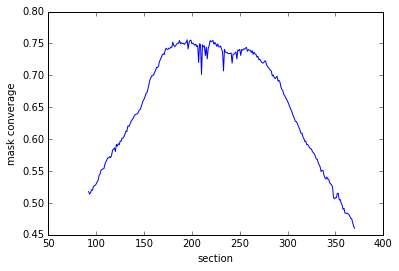

In [4]:
# This shows that a mask covers 50% to 75% of the full area, so predicting only on masks roughly halves the time.

stack = 'MD589'
image_width, image_height = metadata_cache['image_shape'][stack]
first_detect_sec, last_detect_sec = metadata_cache['section_limits'][stack]
a = image_width / 32 * image_height / 32
mask_coverage = {sec: np.count_nonzero(DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, section=sec))/float(a)
for sec in range(first_detect_sec, last_detect_sec+1) if not is_invalid(stack=stack, sec=sec)}
plt.plot(mask_coverage.keys(), mask_coverage.values());
plt.xlabel('section');
plt.ylabel('mask converage');

# Original

In [5]:
prep_id = 2
# input_img_version = 'grayL500H0'
input_img_version = 'grayDefault'
win_id = 5

In [7]:
# for stack in all_stacks:
for stack in ['MD642','MD652','MD653','MD657']:

    tt = time.time()
    
#     download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, version='cropped'), is_dir=True)
#     download_from_s3(DataManager.get_image_dir_v2(stack=stack, prep_id=prep_id, version=input_img_version), is_dir=True)
    # download takes 300 sec.
    
    print stack
    section_to_filename = metadata_cache['sections_to_filenames'][stack]
    
    patch_size = windowing_settings[win_id]['patch_size']
    half_size = patch_size / 2
    stride = windowing_settings[win_id]['spacing']
    image_width, image_height = metadata_cache['image_shape'][stack]
    grid_spec = (patch_size, stride, image_width, image_height)

    sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)
    
    for sec in metadata_cache['valid_sections'][stack]:

        
        sys.stderr.write('\nSection %d.\n' % sec)

        # Use grids only on mask.
        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=prep_id, section=sec)
        indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
        sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
        
#         Use grids on the entire frame.
#         indices_roi = range(len(sample_locations))

        n = len(indices_roi)
        sys.stderr.write('%d samples.\n' % n)

        sample_locations_roi = sample_locations[indices_roi]
        
        t = time.time()
        im = DataManager.load_image_v2(stack=stack, section=sec, prep_id=prep_id, 
                                       version=input_img_version, resol='lossless')
        sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s

        t = time.time()

        patches = extract_patches_given_locations(img=im, locs=sample_locations_roi, patch_size=patch_size)
        
#         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
#                             for x, y in sample_locations_roi]) # n x 224 x 224
        
        features = []
        for i in range(0, len(patches), 80000):
            feats = convert_image_patches_to_features(patches[i:i+80000], model=model, 
                                                     mean_img=mean_img, batch_size=batch_size)
            features.append(feats)
        features = np.concatenate(features)
        
        sys.stderr.write('forward pass: %.2f seconds\n' % (time.time() - t)) 
        # All times below are after the first iteration (which is slow due to model loading into GPU).
        # inception-bn-blue ~125s / 48k patches on workstation single Titan X
        # inception-bn-blue ~27s / 48k patches on AWS p2.8xlarge 8 Tesla K80

    # Had to modify [model]-symbol.json according to this https://github.com/dmlc/mxnet/issues/2718
        
        del patches, im
        
        t = time.time()

        features_fp = DataManager.get_dnn_features_filepath(stack=stack, model_name=model_name, 
                                                            win=win_id,
                                                            section=sec,
                                                           input_img_version=input_img_version)
        create_parent_dir_if_not_exists(features_fp)
        bp.pack_ndarray_file(features.astype(np.float16), features_fp) # bloscpack produces files of similar size
        upload_to_s3(features_fp, local_root=DATA_ROOTDIR)
        
        del features

        feature_locs_fp = DataManager.get_patch_locations_filepath(stack=stack, win=win_id, section=sec)
        create_parent_dir_if_not_exists(feature_locs_fp)
        np.savetxt(feature_locs_fp, np.c_[indices_roi, sample_locations_roi], fmt='%d %d %d')
        upload_to_s3(feature_locs_fp, local_root=DATA_ROOTDIR)

        sys.stderr.write('save: %.2f seconds\n' % (time.time() - t)) # ~.5s
        
        
    print sys.stderr.write('Overall time: %.2f seconds\n' % (time.time() - tt))

# 64 pixels spacing 8697.52 seconds = 2.5hr
# 11631.38s
# Overall time: 2.5 hours / stack, on AWS using p2.8xlarge 8 Tesla K80."

MD642
rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N14-2017.01.18-16.25.58_MD642_2_0041_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N14-2017.01.18-16.25.58_MD642_2_0041_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N14-2017.01.18-16.25.58_MD642_2_0041_prep2_thumbnail_mask.png"



Section 81.
locate patches: 1.16 seconds
29126 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N14-2017.01.18-16.25.58_MD642_2_0041_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N14-2017.01.18-16.25.58_MD642_2_0041_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N14-2017.01.18-16.25.58_MD642_2_0041_prep2_lossless_grayDefault.tif"


load image: 5.66 seconds


(29126, 1, 224, 224)


forward pass: 19.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N14-2017.01.18-16.25.58_MD642_2_0041_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N14-2017.01.18-16.25.58_MD642_2_0041_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N14-2017.01.18-16.25.58_MD642_2_0041_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N14-2017.01.18-16.25.58_MD642_2_0041_prep2_gray_win5_patchLocations.txt"


save: 4.41 seconds

Section 82.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F14-2017.01.14-01.26.25_MD642_2_0041_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F14-2017.01.14-01.26.25_MD642_2_0041_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F14-2017.01.14-01.26.25_MD642_2_0041_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
29296 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F14-2017.01.14-01.26.25_MD642_2_0041_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F14-2017.01.14-01.26.25_MD642_2_0041_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F14-2017.01.14-01.26.25_MD642_2_0041_prep2_lossless_grayDefault.tif"


load image: 4.92 seconds


(29296, 1, 224, 224)


forward pass: 19.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F14-2017.01.14-01.26.25_MD642_2_0041_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F14-2017.01.14-01.26.25_MD642_2_0041_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F14-2017.01.14-01.26.25_MD642_2_0041_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F14-2017.01.14-01.26.25_MD642_2_0041_prep2_gray_win5_patchLocations.txt"


save: 4.39 seconds

Section 83.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N14-2017.01.18-16.25.58_MD642_3_0042_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N14-2017.01.18-16.25.58_MD642_3_0042_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N14-2017.01.18-16.25.58_MD642_3_0042_prep2_thumbnail_mask.png"


locate patches: 1.18 seconds
29486 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N14-2017.01.18-16.25.58_MD642_3_0042_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N14-2017.01.18-16.25.58_MD642_3_0042_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N14-2017.01.18-16.25.58_MD642_3_0042_prep2_lossless_grayDefault.tif"


load image: 4.98 seconds


(29486, 1, 224, 224)


forward pass: 19.82 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N14-2017.01.18-16.25.58_MD642_3_0042_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N14-2017.01.18-16.25.58_MD642_3_0042_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N14-2017.01.18-16.25.58_MD642_3_0042_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N14-2017.01.18-16.25.58_MD642_3_0042_prep2_gray_win5_patchLocations.txt"


save: 4.27 seconds

Section 84.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F14-2017.01.14-01.26.25_MD642_3_0042_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F14-2017.01.14-01.26.25_MD642_3_0042_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F14-2017.01.14-01.26.25_MD642_3_0042_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
29247 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F14-2017.01.14-01.26.25_MD642_3_0042_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F14-2017.01.14-01.26.25_MD642_3_0042_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F14-2017.01.14-01.26.25_MD642_3_0042_prep2_lossless_grayDefault.tif"


load image: 5.90 seconds


(29247, 1, 224, 224)


forward pass: 19.87 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F14-2017.01.14-01.26.25_MD642_3_0042_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F14-2017.01.14-01.26.25_MD642_3_0042_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F14-2017.01.14-01.26.25_MD642_3_0042_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F14-2017.01.14-01.26.25_MD642_3_0042_prep2_gray_win5_patchLocations.txt"


save: 5.63 seconds

Section 85.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N15-2017.01.18-16.30.02_MD642_1_0043_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N15-2017.01.18-16.30.02_MD642_1_0043_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N15-2017.01.18-16.30.02_MD642_1_0043_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
30232 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N15-2017.01.18-16.30.02_MD642_1_0043_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N15-2017.01.18-16.30.02_MD642_1_0043_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N15-2017.01.18-16.30.02_MD642_1_0043_prep2_lossless_grayDefault.tif"


load image: 6.09 seconds


(30232, 1, 224, 224)


forward pass: 21.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N15-2017.01.18-16.30.02_MD642_1_0043_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N15-2017.01.18-16.30.02_MD642_1_0043_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N15-2017.01.18-16.30.02_MD642_1_0043_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N15-2017.01.18-16.30.02_MD642_1_0043_prep2_gray_win5_patchLocations.txt"


save: 4.30 seconds

Section 86.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F15-2017.01.14-01.41.14_MD642_1_0043_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F15-2017.01.14-01.41.14_MD642_1_0043_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F15-2017.01.14-01.41.14_MD642_1_0043_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
30351 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F15-2017.01.14-01.41.14_MD642_1_0043_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F15-2017.01.14-01.41.14_MD642_1_0043_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F15-2017.01.14-01.41.14_MD642_1_0043_prep2_lossless_grayDefault.tif"


load image: 5.22 seconds


(30351, 1, 224, 224)


forward pass: 21.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F15-2017.01.14-01.41.14_MD642_1_0043_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F15-2017.01.14-01.41.14_MD642_1_0043_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F15-2017.01.14-01.41.14_MD642_1_0043_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F15-2017.01.14-01.41.14_MD642_1_0043_prep2_gray_win5_patchLocations.txt"


save: 4.50 seconds

Section 87.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N15-2017.01.18-16.30.02_MD642_2_0044_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N15-2017.01.18-16.30.02_MD642_2_0044_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N15-2017.01.18-16.30.02_MD642_2_0044_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
31128 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N15-2017.01.18-16.30.02_MD642_2_0044_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N15-2017.01.18-16.30.02_MD642_2_0044_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N15-2017.01.18-16.30.02_MD642_2_0044_prep2_lossless_grayDefault.tif"


load image: 4.88 seconds


(31128, 1, 224, 224)


forward pass: 21.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N15-2017.01.18-16.30.02_MD642_2_0044_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N15-2017.01.18-16.30.02_MD642_2_0044_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N15-2017.01.18-16.30.02_MD642_2_0044_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N15-2017.01.18-16.30.02_MD642_2_0044_prep2_gray_win5_patchLocations.txt"


save: 4.46 seconds

Section 88.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F15-2017.01.14-01.41.14_MD642_2_0044_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F15-2017.01.14-01.41.14_MD642_2_0044_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F15-2017.01.14-01.41.14_MD642_2_0044_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
31255 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F15-2017.01.14-01.41.14_MD642_2_0044_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F15-2017.01.14-01.41.14_MD642_2_0044_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F15-2017.01.14-01.41.14_MD642_2_0044_prep2_lossless_grayDefault.tif"


load image: 6.93 seconds


(31255, 1, 224, 224)


forward pass: 21.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F15-2017.01.14-01.41.14_MD642_2_0044_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F15-2017.01.14-01.41.14_MD642_2_0044_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F15-2017.01.14-01.41.14_MD642_2_0044_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F15-2017.01.14-01.41.14_MD642_2_0044_prep2_gray_win5_patchLocations.txt"


save: 4.31 seconds

Section 89.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N15-2017.01.18-16.30.02_MD642_3_0045_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N15-2017.01.18-16.30.02_MD642_3_0045_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N15-2017.01.18-16.30.02_MD642_3_0045_prep2_thumbnail_mask.png"


locate patches: 1.49 seconds
31631 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N15-2017.01.18-16.30.02_MD642_3_0045_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N15-2017.01.18-16.30.02_MD642_3_0045_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N15-2017.01.18-16.30.02_MD642_3_0045_prep2_lossless_grayDefault.tif"


load image: 5.42 seconds


(31631, 1, 224, 224)


forward pass: 21.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N15-2017.01.18-16.30.02_MD642_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N15-2017.01.18-16.30.02_MD642_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N15-2017.01.18-16.30.02_MD642_3_0045_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N15-2017.01.18-16.30.02_MD642_3_0045_prep2_gray_win5_patchLocations.txt"


save: 4.53 seconds

Section 90.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F15-2017.01.14-01.41.14_MD642_3_0045_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F15-2017.01.14-01.41.14_MD642_3_0045_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F15-2017.01.14-01.41.14_MD642_3_0045_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
31922 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F15-2017.01.14-01.41.14_MD642_3_0045_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F15-2017.01.14-01.41.14_MD642_3_0045_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F15-2017.01.14-01.41.14_MD642_3_0045_prep2_lossless_grayDefault.tif"


load image: 5.27 seconds


(31922, 1, 224, 224)


forward pass: 22.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F15-2017.01.14-01.41.14_MD642_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F15-2017.01.14-01.41.14_MD642_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F15-2017.01.14-01.41.14_MD642_3_0045_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F15-2017.01.14-01.41.14_MD642_3_0045_prep2_gray_win5_patchLocations.txt"


save: 4.28 seconds

Section 91.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N16-2017.01.18-16.34.11_MD642_1_0046_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N16-2017.01.18-16.34.11_MD642_1_0046_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N16-2017.01.18-16.34.11_MD642_1_0046_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
32432 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N16-2017.01.18-16.34.11_MD642_1_0046_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N16-2017.01.18-16.34.11_MD642_1_0046_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N16-2017.01.18-16.34.11_MD642_1_0046_prep2_lossless_grayDefault.tif"


load image: 6.03 seconds


(32432, 1, 224, 224)


forward pass: 22.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N16-2017.01.18-16.34.11_MD642_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N16-2017.01.18-16.34.11_MD642_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N16-2017.01.18-16.34.11_MD642_1_0046_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N16-2017.01.18-16.34.11_MD642_1_0046_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 92.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F16-2017.01.14-01.57.29_MD642_1_0046_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F16-2017.01.14-01.57.29_MD642_1_0046_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F16-2017.01.14-01.57.29_MD642_1_0046_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
32819 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F16-2017.01.14-01.57.29_MD642_1_0046_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F16-2017.01.14-01.57.29_MD642_1_0046_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F16-2017.01.14-01.57.29_MD642_1_0046_prep2_lossless_grayDefault.tif"


load image: 5.07 seconds


(32819, 1, 224, 224)


forward pass: 22.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F16-2017.01.14-01.57.29_MD642_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F16-2017.01.14-01.57.29_MD642_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F16-2017.01.14-01.57.29_MD642_1_0046_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F16-2017.01.14-01.57.29_MD642_1_0046_prep2_gray_win5_patchLocations.txt"


save: 5.77 seconds

Section 93.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N16-2017.01.18-16.34.11_MD642_2_0047_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N16-2017.01.18-16.34.11_MD642_2_0047_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N16-2017.01.18-16.34.11_MD642_2_0047_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
32544 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N16-2017.01.18-16.34.11_MD642_2_0047_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N16-2017.01.18-16.34.11_MD642_2_0047_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N16-2017.01.18-16.34.11_MD642_2_0047_prep2_lossless_grayDefault.tif"


load image: 5.94 seconds


(32544, 1, 224, 224)


forward pass: 22.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N16-2017.01.18-16.34.11_MD642_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N16-2017.01.18-16.34.11_MD642_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N16-2017.01.18-16.34.11_MD642_2_0047_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N16-2017.01.18-16.34.11_MD642_2_0047_prep2_gray_win5_patchLocations.txt"


save: 4.23 seconds

Section 94.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F16-2017.01.14-01.57.29_MD642_2_0047_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F16-2017.01.14-01.57.29_MD642_2_0047_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F16-2017.01.14-01.57.29_MD642_2_0047_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
32837 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F16-2017.01.14-01.57.29_MD642_2_0047_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F16-2017.01.14-01.57.29_MD642_2_0047_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F16-2017.01.14-01.57.29_MD642_2_0047_prep2_lossless_grayDefault.tif"


load image: 4.86 seconds


(32837, 1, 224, 224)


forward pass: 22.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F16-2017.01.14-01.57.29_MD642_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F16-2017.01.14-01.57.29_MD642_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F16-2017.01.14-01.57.29_MD642_2_0047_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F16-2017.01.14-01.57.29_MD642_2_0047_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 95.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N16-2017.01.18-16.34.11_MD642_3_0048_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N16-2017.01.18-16.34.11_MD642_3_0048_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N16-2017.01.18-16.34.11_MD642_3_0048_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
32603 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N16-2017.01.18-16.34.11_MD642_3_0048_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N16-2017.01.18-16.34.11_MD642_3_0048_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N16-2017.01.18-16.34.11_MD642_3_0048_prep2_lossless_grayDefault.tif"


load image: 5.57 seconds


(32603, 1, 224, 224)


forward pass: 22.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N16-2017.01.18-16.34.11_MD642_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N16-2017.01.18-16.34.11_MD642_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N16-2017.01.18-16.34.11_MD642_3_0048_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N16-2017.01.18-16.34.11_MD642_3_0048_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 96.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F16-2017.01.14-01.57.29_MD642_3_0048_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F16-2017.01.14-01.57.29_MD642_3_0048_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F16-2017.01.14-01.57.29_MD642_3_0048_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
33302 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F16-2017.01.14-01.57.29_MD642_3_0048_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F16-2017.01.14-01.57.29_MD642_3_0048_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F16-2017.01.14-01.57.29_MD642_3_0048_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(33302, 1, 224, 224)


forward pass: 22.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F16-2017.01.14-01.57.29_MD642_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F16-2017.01.14-01.57.29_MD642_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F16-2017.01.14-01.57.29_MD642_3_0048_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F16-2017.01.14-01.57.29_MD642_3_0048_prep2_gray_win5_patchLocations.txt"


save: 5.34 seconds

Section 98.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F17-2017.01.14-02.13.38_MD642_1_0049_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F17-2017.01.14-02.13.38_MD642_1_0049_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F17-2017.01.14-02.13.38_MD642_1_0049_prep2_thumbnail_mask.png"


locate patches: 1.23 seconds
33529 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F17-2017.01.14-02.13.38_MD642_1_0049_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F17-2017.01.14-02.13.38_MD642_1_0049_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F17-2017.01.14-02.13.38_MD642_1_0049_prep2_lossless_grayDefault.tif"


load image: 4.97 seconds


(33529, 1, 224, 224)


forward pass: 22.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F17-2017.01.14-02.13.38_MD642_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F17-2017.01.14-02.13.38_MD642_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F17-2017.01.14-02.13.38_MD642_1_0049_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F17-2017.01.14-02.13.38_MD642_1_0049_prep2_gray_win5_patchLocations.txt"


save: 4.26 seconds

Section 99.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N17-2017.01.18-16.38.28_MD642_2_0050_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N17-2017.01.18-16.38.28_MD642_2_0050_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N17-2017.01.18-16.38.28_MD642_2_0050_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
33949 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N17-2017.01.18-16.38.28_MD642_2_0050_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N17-2017.01.18-16.38.28_MD642_2_0050_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N17-2017.01.18-16.38.28_MD642_2_0050_prep2_lossless_grayDefault.tif"


load image: 5.36 seconds


(33949, 1, 224, 224)


forward pass: 22.97 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N17-2017.01.18-16.38.28_MD642_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N17-2017.01.18-16.38.28_MD642_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N17-2017.01.18-16.38.28_MD642_2_0050_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N17-2017.01.18-16.38.28_MD642_2_0050_prep2_gray_win5_patchLocations.txt"


save: 4.49 seconds

Section 100.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F17-2017.01.14-02.13.38_MD642_2_0050_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F17-2017.01.14-02.13.38_MD642_2_0050_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F17-2017.01.14-02.13.38_MD642_2_0050_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
34305 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F17-2017.01.14-02.13.38_MD642_2_0050_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F17-2017.01.14-02.13.38_MD642_2_0050_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F17-2017.01.14-02.13.38_MD642_2_0050_prep2_lossless_grayDefault.tif"


load image: 5.73 seconds


(34305, 1, 224, 224)


forward pass: 23.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F17-2017.01.14-02.13.38_MD642_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F17-2017.01.14-02.13.38_MD642_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F17-2017.01.14-02.13.38_MD642_2_0050_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F17-2017.01.14-02.13.38_MD642_2_0050_prep2_gray_win5_patchLocations.txt"


save: 4.48 seconds

Section 101.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N17-2017.01.18-16.38.28_MD642_3_0051_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N17-2017.01.18-16.38.28_MD642_3_0051_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N17-2017.01.18-16.38.28_MD642_3_0051_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
34653 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N17-2017.01.18-16.38.28_MD642_3_0051_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N17-2017.01.18-16.38.28_MD642_3_0051_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N17-2017.01.18-16.38.28_MD642_3_0051_prep2_lossless_grayDefault.tif"


load image: 5.12 seconds


(34653, 1, 224, 224)


forward pass: 23.55 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N17-2017.01.18-16.38.28_MD642_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N17-2017.01.18-16.38.28_MD642_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N17-2017.01.18-16.38.28_MD642_3_0051_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N17-2017.01.18-16.38.28_MD642_3_0051_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 102.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F17-2017.01.14-02.13.38_MD642_3_0051_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F17-2017.01.14-02.13.38_MD642_3_0051_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F17-2017.01.14-02.13.38_MD642_3_0051_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
34848 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F17-2017.01.14-02.13.38_MD642_3_0051_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F17-2017.01.14-02.13.38_MD642_3_0051_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F17-2017.01.14-02.13.38_MD642_3_0051_prep2_lossless_grayDefault.tif"


load image: 5.27 seconds


(34848, 1, 224, 224)


forward pass: 23.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F17-2017.01.14-02.13.38_MD642_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F17-2017.01.14-02.13.38_MD642_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F17-2017.01.14-02.13.38_MD642_3_0051_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F17-2017.01.14-02.13.38_MD642_3_0051_prep2_gray_win5_patchLocations.txt"


save: 5.43 seconds

Section 103.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N18-2017.01.18-16.42.43_MD642_1_0052_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N18-2017.01.18-16.42.43_MD642_1_0052_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N18-2017.01.18-16.42.43_MD642_1_0052_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
35284 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N18-2017.01.18-16.42.43_MD642_1_0052_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N18-2017.01.18-16.42.43_MD642_1_0052_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N18-2017.01.18-16.42.43_MD642_1_0052_prep2_lossless_grayDefault.tif"


load image: 5.02 seconds


(35284, 1, 224, 224)


forward pass: 24.08 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N18-2017.01.18-16.42.43_MD642_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N18-2017.01.18-16.42.43_MD642_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N18-2017.01.18-16.42.43_MD642_1_0052_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N18-2017.01.18-16.42.43_MD642_1_0052_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 104.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F18-2017.01.14-02.29.55_MD642_1_0052_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F18-2017.01.14-02.29.55_MD642_1_0052_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F18-2017.01.14-02.29.55_MD642_1_0052_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
35146 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F18-2017.01.14-02.29.55_MD642_1_0052_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F18-2017.01.14-02.29.55_MD642_1_0052_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F18-2017.01.14-02.29.55_MD642_1_0052_prep2_lossless_grayDefault.tif"


load image: 5.37 seconds


(35146, 1, 224, 224)


forward pass: 24.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F18-2017.01.14-02.29.55_MD642_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F18-2017.01.14-02.29.55_MD642_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F18-2017.01.14-02.29.55_MD642_1_0052_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F18-2017.01.14-02.29.55_MD642_1_0052_prep2_gray_win5_patchLocations.txt"


save: 4.47 seconds

Section 105.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N18-2017.01.18-16.42.43_MD642_2_0053_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N18-2017.01.18-16.42.43_MD642_2_0053_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N18-2017.01.18-16.42.43_MD642_2_0053_prep2_thumbnail_mask.png"


locate patches: 1.26 seconds
35036 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N18-2017.01.18-16.42.43_MD642_2_0053_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N18-2017.01.18-16.42.43_MD642_2_0053_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N18-2017.01.18-16.42.43_MD642_2_0053_prep2_lossless_grayDefault.tif"


load image: 5.57 seconds


(35036, 1, 224, 224)


forward pass: 23.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N18-2017.01.18-16.42.43_MD642_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N18-2017.01.18-16.42.43_MD642_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N18-2017.01.18-16.42.43_MD642_2_0053_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N18-2017.01.18-16.42.43_MD642_2_0053_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 106.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F18-2017.01.14-02.29.55_MD642_2_0053_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F18-2017.01.14-02.29.55_MD642_2_0053_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F18-2017.01.14-02.29.55_MD642_2_0053_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
35443 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F18-2017.01.14-02.29.55_MD642_2_0053_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F18-2017.01.14-02.29.55_MD642_2_0053_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F18-2017.01.14-02.29.55_MD642_2_0053_prep2_lossless_grayDefault.tif"


load image: 5.22 seconds


(35443, 1, 224, 224)


forward pass: 24.86 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F18-2017.01.14-02.29.55_MD642_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F18-2017.01.14-02.29.55_MD642_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F18-2017.01.14-02.29.55_MD642_2_0053_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F18-2017.01.14-02.29.55_MD642_2_0053_prep2_gray_win5_patchLocations.txt"


save: 4.49 seconds

Section 107.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N18-2017.01.18-16.42.43_MD642_3_0054_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N18-2017.01.18-16.42.43_MD642_3_0054_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N18-2017.01.18-16.42.43_MD642_3_0054_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
35413 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N18-2017.01.18-16.42.43_MD642_3_0054_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N18-2017.01.18-16.42.43_MD642_3_0054_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N18-2017.01.18-16.42.43_MD642_3_0054_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(35413, 1, 224, 224)


forward pass: 24.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N18-2017.01.18-16.42.43_MD642_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N18-2017.01.18-16.42.43_MD642_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N18-2017.01.18-16.42.43_MD642_3_0054_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N18-2017.01.18-16.42.43_MD642_3_0054_prep2_gray_win5_patchLocations.txt"


save: 4.68 seconds

Section 108.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F18-2017.01.14-02.29.55_MD642_3_0054_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F18-2017.01.14-02.29.55_MD642_3_0054_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F18-2017.01.14-02.29.55_MD642_3_0054_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
35850 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F18-2017.01.14-02.29.55_MD642_3_0054_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F18-2017.01.14-02.29.55_MD642_3_0054_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F18-2017.01.14-02.29.55_MD642_3_0054_prep2_lossless_grayDefault.tif"


load image: 5.78 seconds


(35850, 1, 224, 224)


forward pass: 25.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F18-2017.01.14-02.29.55_MD642_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F18-2017.01.14-02.29.55_MD642_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F18-2017.01.14-02.29.55_MD642_3_0054_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F18-2017.01.14-02.29.55_MD642_3_0054_prep2_gray_win5_patchLocations.txt"


save: 4.28 seconds

Section 109.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N19-2017.01.18-16.46.53_MD642_1_0055_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N19-2017.01.18-16.46.53_MD642_1_0055_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N19-2017.01.18-16.46.53_MD642_1_0055_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
35604 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N19-2017.01.18-16.46.53_MD642_1_0055_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N19-2017.01.18-16.46.53_MD642_1_0055_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N19-2017.01.18-16.46.53_MD642_1_0055_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(35604, 1, 224, 224)


forward pass: 24.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N19-2017.01.18-16.46.53_MD642_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N19-2017.01.18-16.46.53_MD642_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N19-2017.01.18-16.46.53_MD642_1_0055_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N19-2017.01.18-16.46.53_MD642_1_0055_prep2_gray_win5_patchLocations.txt"


save: 5.03 seconds

Section 110.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F19-2017.01.14-02.45.12_MD642_1_0055_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F19-2017.01.14-02.45.12_MD642_1_0055_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F19-2017.01.14-02.45.12_MD642_1_0055_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
35836 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F19-2017.01.14-02.45.12_MD642_1_0055_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F19-2017.01.14-02.45.12_MD642_1_0055_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F19-2017.01.14-02.45.12_MD642_1_0055_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(35836, 1, 224, 224)


forward pass: 24.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F19-2017.01.14-02.45.12_MD642_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F19-2017.01.14-02.45.12_MD642_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F19-2017.01.14-02.45.12_MD642_1_0055_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F19-2017.01.14-02.45.12_MD642_1_0055_prep2_gray_win5_patchLocations.txt"


save: 4.34 seconds

Section 111.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N19-2017.01.18-16.46.53_MD642_2_0056_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N19-2017.01.18-16.46.53_MD642_2_0056_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N19-2017.01.18-16.46.53_MD642_2_0056_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
32863 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N19-2017.01.18-16.46.53_MD642_2_0056_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N19-2017.01.18-16.46.53_MD642_2_0056_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N19-2017.01.18-16.46.53_MD642_2_0056_prep2_lossless_grayDefault.tif"


load image: 5.27 seconds


(32863, 1, 224, 224)


forward pass: 22.36 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N19-2017.01.18-16.46.53_MD642_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N19-2017.01.18-16.46.53_MD642_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N19-2017.01.18-16.46.53_MD642_2_0056_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N19-2017.01.18-16.46.53_MD642_2_0056_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 112.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F19-2017.01.14-02.45.12_MD642_2_0056_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F19-2017.01.14-02.45.12_MD642_2_0056_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F19-2017.01.14-02.45.12_MD642_2_0056_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
36236 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F19-2017.01.14-02.45.12_MD642_2_0056_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F19-2017.01.14-02.45.12_MD642_2_0056_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F19-2017.01.14-02.45.12_MD642_2_0056_prep2_lossless_grayDefault.tif"


load image: 5.22 seconds


(36236, 1, 224, 224)


forward pass: 24.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F19-2017.01.14-02.45.12_MD642_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F19-2017.01.14-02.45.12_MD642_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F19-2017.01.14-02.45.12_MD642_2_0056_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F19-2017.01.14-02.45.12_MD642_2_0056_prep2_gray_win5_patchLocations.txt"


save: 4.89 seconds

Section 113.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N19-2017.01.18-16.46.53_MD642_3_0057_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N19-2017.01.18-16.46.53_MD642_3_0057_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N19-2017.01.18-16.46.53_MD642_3_0057_prep2_thumbnail_mask.png"


locate patches: 2.37 seconds
36194 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N19-2017.01.18-16.46.53_MD642_3_0057_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N19-2017.01.18-16.46.53_MD642_3_0057_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N19-2017.01.18-16.46.53_MD642_3_0057_prep2_lossless_grayDefault.tif"


load image: 5.95 seconds


(36194, 1, 224, 224)


forward pass: 24.74 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N19-2017.01.18-16.46.53_MD642_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N19-2017.01.18-16.46.53_MD642_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N19-2017.01.18-16.46.53_MD642_3_0057_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N19-2017.01.18-16.46.53_MD642_3_0057_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 114.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F19-2017.01.14-02.45.12_MD642_3_0057_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F19-2017.01.14-02.45.12_MD642_3_0057_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F19-2017.01.14-02.45.12_MD642_3_0057_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
36789 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F19-2017.01.14-02.45.12_MD642_3_0057_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F19-2017.01.14-02.45.12_MD642_3_0057_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F19-2017.01.14-02.45.12_MD642_3_0057_prep2_lossless_grayDefault.tif"


load image: 5.27 seconds


(36789, 1, 224, 224)


forward pass: 24.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F19-2017.01.14-02.45.12_MD642_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F19-2017.01.14-02.45.12_MD642_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F19-2017.01.14-02.45.12_MD642_3_0057_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F19-2017.01.14-02.45.12_MD642_3_0057_prep2_gray_win5_patchLocations.txt"


save: 4.85 seconds

Section 115.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N20-2017.01.18-16.51.02_MD642_1_0058_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N20-2017.01.18-16.51.02_MD642_1_0058_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N20-2017.01.18-16.51.02_MD642_1_0058_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
35796 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N20-2017.01.18-16.51.02_MD642_1_0058_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N20-2017.01.18-16.51.02_MD642_1_0058_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N20-2017.01.18-16.51.02_MD642_1_0058_prep2_lossless_grayDefault.tif"


load image: 5.19 seconds


(35796, 1, 224, 224)


forward pass: 24.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N20-2017.01.18-16.51.02_MD642_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N20-2017.01.18-16.51.02_MD642_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N20-2017.01.18-16.51.02_MD642_1_0058_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N20-2017.01.18-16.51.02_MD642_1_0058_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 116.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F20-2017.01.14-03.02.52_MD642_1_0058_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F20-2017.01.14-03.02.52_MD642_1_0058_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F20-2017.01.14-03.02.52_MD642_1_0058_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
37085 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F20-2017.01.14-03.02.52_MD642_1_0058_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F20-2017.01.14-03.02.52_MD642_1_0058_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F20-2017.01.14-03.02.52_MD642_1_0058_prep2_lossless_grayDefault.tif"


load image: 6.10 seconds


(37085, 1, 224, 224)


forward pass: 25.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F20-2017.01.14-03.02.52_MD642_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F20-2017.01.14-03.02.52_MD642_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F20-2017.01.14-03.02.52_MD642_1_0058_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F20-2017.01.14-03.02.52_MD642_1_0058_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 117.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N20-2017.01.18-16.51.02_MD642_2_0059_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N20-2017.01.18-16.51.02_MD642_2_0059_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N20-2017.01.18-16.51.02_MD642_2_0059_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
35530 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N20-2017.01.18-16.51.02_MD642_2_0059_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N20-2017.01.18-16.51.02_MD642_2_0059_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N20-2017.01.18-16.51.02_MD642_2_0059_prep2_lossless_grayDefault.tif"


load image: 5.25 seconds


(35530, 1, 224, 224)


forward pass: 23.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N20-2017.01.18-16.51.02_MD642_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N20-2017.01.18-16.51.02_MD642_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N20-2017.01.18-16.51.02_MD642_2_0059_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N20-2017.01.18-16.51.02_MD642_2_0059_prep2_gray_win5_patchLocations.txt"


save: 4.41 seconds

Section 118.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F20-2017.01.14-03.02.52_MD642_2_0059_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F20-2017.01.14-03.02.52_MD642_2_0059_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F20-2017.01.14-03.02.52_MD642_2_0059_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
37206 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F20-2017.01.14-03.02.52_MD642_2_0059_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F20-2017.01.14-03.02.52_MD642_2_0059_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F20-2017.01.14-03.02.52_MD642_2_0059_prep2_lossless_grayDefault.tif"


load image: 6.02 seconds


(37206, 1, 224, 224)


forward pass: 25.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F20-2017.01.14-03.02.52_MD642_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F20-2017.01.14-03.02.52_MD642_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F20-2017.01.14-03.02.52_MD642_2_0059_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F20-2017.01.14-03.02.52_MD642_2_0059_prep2_gray_win5_patchLocations.txt"


save: 4.40 seconds

Section 119.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N20-2017.01.18-16.51.02_MD642_3_0060_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N20-2017.01.18-16.51.02_MD642_3_0060_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N20-2017.01.18-16.51.02_MD642_3_0060_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
37061 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N20-2017.01.18-16.51.02_MD642_3_0060_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N20-2017.01.18-16.51.02_MD642_3_0060_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N20-2017.01.18-16.51.02_MD642_3_0060_prep2_lossless_grayDefault.tif"


load image: 5.96 seconds


(37061, 1, 224, 224)


forward pass: 25.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N20-2017.01.18-16.51.02_MD642_3_0060_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N20-2017.01.18-16.51.02_MD642_3_0060_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N20-2017.01.18-16.51.02_MD642_3_0060_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N20-2017.01.18-16.51.02_MD642_3_0060_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 120.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F20-2017.01.14-03.02.52_MD642_3_0060_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F20-2017.01.14-03.02.52_MD642_3_0060_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F20-2017.01.14-03.02.52_MD642_3_0060_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
37789 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F20-2017.01.14-03.02.52_MD642_3_0060_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F20-2017.01.14-03.02.52_MD642_3_0060_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F20-2017.01.14-03.02.52_MD642_3_0060_prep2_lossless_grayDefault.tif"


load image: 5.08 seconds


(37789, 1, 224, 224)


forward pass: 26.15 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F20-2017.01.14-03.02.52_MD642_3_0060_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F20-2017.01.14-03.02.52_MD642_3_0060_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F20-2017.01.14-03.02.52_MD642_3_0060_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F20-2017.01.14-03.02.52_MD642_3_0060_prep2_gray_win5_patchLocations.txt"


save: 5.52 seconds

Section 121.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N21-2017.01.18-16.55.13_MD642_1_0061_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N21-2017.01.18-16.55.13_MD642_1_0061_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N21-2017.01.18-16.55.13_MD642_1_0061_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
37078 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N21-2017.01.18-16.55.13_MD642_1_0061_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N21-2017.01.18-16.55.13_MD642_1_0061_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N21-2017.01.18-16.55.13_MD642_1_0061_prep2_lossless_grayDefault.tif"


load image: 5.68 seconds


(37078, 1, 224, 224)


forward pass: 24.91 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N21-2017.01.18-16.55.13_MD642_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N21-2017.01.18-16.55.13_MD642_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N21-2017.01.18-16.55.13_MD642_1_0061_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N21-2017.01.18-16.55.13_MD642_1_0061_prep2_gray_win5_patchLocations.txt"


save: 4.56 seconds

Section 122.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F21-2017.01.14-03.20.17_MD642_1_0061_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F21-2017.01.14-03.20.17_MD642_1_0061_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F21-2017.01.14-03.20.17_MD642_1_0061_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
37670 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F21-2017.01.14-03.20.17_MD642_1_0061_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F21-2017.01.14-03.20.17_MD642_1_0061_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F21-2017.01.14-03.20.17_MD642_1_0061_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(37670, 1, 224, 224)


forward pass: 25.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F21-2017.01.14-03.20.17_MD642_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F21-2017.01.14-03.20.17_MD642_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F21-2017.01.14-03.20.17_MD642_1_0061_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F21-2017.01.14-03.20.17_MD642_1_0061_prep2_gray_win5_patchLocations.txt"


save: 4.60 seconds

Section 123.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N21-2017.01.18-16.55.13_MD642_2_0062_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N21-2017.01.18-16.55.13_MD642_2_0062_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N21-2017.01.18-16.55.13_MD642_2_0062_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
37203 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N21-2017.01.18-16.55.13_MD642_2_0062_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N21-2017.01.18-16.55.13_MD642_2_0062_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N21-2017.01.18-16.55.13_MD642_2_0062_prep2_lossless_grayDefault.tif"


load image: 5.10 seconds


(37203, 1, 224, 224)


forward pass: 24.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N21-2017.01.18-16.55.13_MD642_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N21-2017.01.18-16.55.13_MD642_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N21-2017.01.18-16.55.13_MD642_2_0062_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N21-2017.01.18-16.55.13_MD642_2_0062_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 124.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F21-2017.01.14-03.20.17_MD642_2_0062_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F21-2017.01.14-03.20.17_MD642_2_0062_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F21-2017.01.14-03.20.17_MD642_2_0062_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
37897 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F21-2017.01.14-03.20.17_MD642_2_0062_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F21-2017.01.14-03.20.17_MD642_2_0062_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F21-2017.01.14-03.20.17_MD642_2_0062_prep2_lossless_grayDefault.tif"


load image: 5.40 seconds


(37897, 1, 224, 224)


forward pass: 25.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F21-2017.01.14-03.20.17_MD642_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F21-2017.01.14-03.20.17_MD642_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F21-2017.01.14-03.20.17_MD642_2_0062_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F21-2017.01.14-03.20.17_MD642_2_0062_prep2_gray_win5_patchLocations.txt"


save: 4.46 seconds

Section 125.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N21-2017.01.18-16.55.13_MD642_3_0063_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N21-2017.01.18-16.55.13_MD642_3_0063_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N21-2017.01.18-16.55.13_MD642_3_0063_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
37744 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N21-2017.01.18-16.55.13_MD642_3_0063_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N21-2017.01.18-16.55.13_MD642_3_0063_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N21-2017.01.18-16.55.13_MD642_3_0063_prep2_lossless_grayDefault.tif"


load image: 5.00 seconds


(37744, 1, 224, 224)


forward pass: 25.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N21-2017.01.18-16.55.13_MD642_3_0063_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N21-2017.01.18-16.55.13_MD642_3_0063_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N21-2017.01.18-16.55.13_MD642_3_0063_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N21-2017.01.18-16.55.13_MD642_3_0063_prep2_gray_win5_patchLocations.txt"


save: 4.44 seconds

Section 126.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F21-2017.01.14-03.20.17_MD642_3_0063_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F21-2017.01.14-03.20.17_MD642_3_0063_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F21-2017.01.14-03.20.17_MD642_3_0063_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
38196 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F21-2017.01.14-03.20.17_MD642_3_0063_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F21-2017.01.14-03.20.17_MD642_3_0063_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F21-2017.01.14-03.20.17_MD642_3_0063_prep2_lossless_grayDefault.tif"


load image: 5.24 seconds


(38196, 1, 224, 224)


forward pass: 25.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F21-2017.01.14-03.20.17_MD642_3_0063_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F21-2017.01.14-03.20.17_MD642_3_0063_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F21-2017.01.14-03.20.17_MD642_3_0063_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F21-2017.01.14-03.20.17_MD642_3_0063_prep2_gray_win5_patchLocations.txt"


save: 4.46 seconds

Section 127.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N22-2017.01.18-16.59.25_MD642_1_0064_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N22-2017.01.18-16.59.25_MD642_1_0064_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N22-2017.01.18-16.59.25_MD642_1_0064_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
37995 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N22-2017.01.18-16.59.25_MD642_1_0064_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N22-2017.01.18-16.59.25_MD642_1_0064_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N22-2017.01.18-16.59.25_MD642_1_0064_prep2_lossless_grayDefault.tif"


load image: 4.99 seconds


(37995, 1, 224, 224)


forward pass: 25.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N22-2017.01.18-16.59.25_MD642_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N22-2017.01.18-16.59.25_MD642_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N22-2017.01.18-16.59.25_MD642_1_0064_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N22-2017.01.18-16.59.25_MD642_1_0064_prep2_gray_win5_patchLocations.txt"


save: 4.50 seconds

Section 128.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F22-2017.01.14-03.38.23_MD642_1_0064_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F22-2017.01.14-03.38.23_MD642_1_0064_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F22-2017.01.14-03.38.23_MD642_1_0064_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
38381 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F22-2017.01.14-03.38.23_MD642_1_0064_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F22-2017.01.14-03.38.23_MD642_1_0064_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F22-2017.01.14-03.38.23_MD642_1_0064_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(38381, 1, 224, 224)


forward pass: 25.87 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F22-2017.01.14-03.38.23_MD642_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F22-2017.01.14-03.38.23_MD642_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F22-2017.01.14-03.38.23_MD642_1_0064_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F22-2017.01.14-03.38.23_MD642_1_0064_prep2_gray_win5_patchLocations.txt"


save: 4.47 seconds

Section 129.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N22-2017.01.18-16.59.25_MD642_2_0065_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N22-2017.01.18-16.59.25_MD642_2_0065_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N22-2017.01.18-16.59.25_MD642_2_0065_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
38078 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N22-2017.01.18-16.59.25_MD642_2_0065_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N22-2017.01.18-16.59.25_MD642_2_0065_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N22-2017.01.18-16.59.25_MD642_2_0065_prep2_lossless_grayDefault.tif"


load image: 5.08 seconds


(38078, 1, 224, 224)


forward pass: 25.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N22-2017.01.18-16.59.25_MD642_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N22-2017.01.18-16.59.25_MD642_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N22-2017.01.18-16.59.25_MD642_2_0065_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N22-2017.01.18-16.59.25_MD642_2_0065_prep2_gray_win5_patchLocations.txt"


save: 4.76 seconds

Section 130.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F22-2017.01.14-03.38.23_MD642_2_0065_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F22-2017.01.14-03.38.23_MD642_2_0065_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F22-2017.01.14-03.38.23_MD642_2_0065_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
38573 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F22-2017.01.14-03.38.23_MD642_2_0065_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F22-2017.01.14-03.38.23_MD642_2_0065_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F22-2017.01.14-03.38.23_MD642_2_0065_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(38573, 1, 224, 224)


forward pass: 25.94 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F22-2017.01.14-03.38.23_MD642_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F22-2017.01.14-03.38.23_MD642_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F22-2017.01.14-03.38.23_MD642_2_0065_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F22-2017.01.14-03.38.23_MD642_2_0065_prep2_gray_win5_patchLocations.txt"


save: 4.97 seconds

Section 131.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N23-2017.01.18-17.02.36_MD642_1_0067_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N23-2017.01.18-17.02.36_MD642_1_0067_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N23-2017.01.18-17.02.36_MD642_1_0067_prep2_thumbnail_mask.png"


locate patches: 1.19 seconds
38500 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N23-2017.01.18-17.02.36_MD642_1_0067_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N23-2017.01.18-17.02.36_MD642_1_0067_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N23-2017.01.18-17.02.36_MD642_1_0067_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(38500, 1, 224, 224)


forward pass: 26.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N23-2017.01.18-17.02.36_MD642_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N23-2017.01.18-17.02.36_MD642_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N23-2017.01.18-17.02.36_MD642_1_0067_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N23-2017.01.18-17.02.36_MD642_1_0067_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 132.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F23-2017.01.14-03.51.55_MD642_1_0067_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F23-2017.01.14-03.51.55_MD642_1_0067_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F23-2017.01.14-03.51.55_MD642_1_0067_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
38886 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F23-2017.01.14-03.51.55_MD642_1_0067_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F23-2017.01.14-03.51.55_MD642_1_0067_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F23-2017.01.14-03.51.55_MD642_1_0067_prep2_lossless_grayDefault.tif"


load image: 5.00 seconds


(38886, 1, 224, 224)


forward pass: 26.27 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F23-2017.01.14-03.51.55_MD642_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F23-2017.01.14-03.51.55_MD642_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F23-2017.01.14-03.51.55_MD642_1_0067_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F23-2017.01.14-03.51.55_MD642_1_0067_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 133.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N23-2017.01.18-17.02.36_MD642_2_0068_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N23-2017.01.18-17.02.36_MD642_2_0068_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N23-2017.01.18-17.02.36_MD642_2_0068_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
38756 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N23-2017.01.18-17.02.36_MD642_2_0068_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N23-2017.01.18-17.02.36_MD642_2_0068_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N23-2017.01.18-17.02.36_MD642_2_0068_prep2_lossless_grayDefault.tif"


load image: 5.18 seconds


(38756, 1, 224, 224)


forward pass: 26.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N23-2017.01.18-17.02.36_MD642_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N23-2017.01.18-17.02.36_MD642_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N23-2017.01.18-17.02.36_MD642_2_0068_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N23-2017.01.18-17.02.36_MD642_2_0068_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 134.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F23-2017.01.14-03.51.55_MD642_2_0068_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F23-2017.01.14-03.51.55_MD642_2_0068_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F23-2017.01.14-03.51.55_MD642_2_0068_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
39301 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F23-2017.01.14-03.51.55_MD642_2_0068_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F23-2017.01.14-03.51.55_MD642_2_0068_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F23-2017.01.14-03.51.55_MD642_2_0068_prep2_lossless_grayDefault.tif"


load image: 5.33 seconds


(39301, 1, 224, 224)


forward pass: 26.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F23-2017.01.14-03.51.55_MD642_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F23-2017.01.14-03.51.55_MD642_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F23-2017.01.14-03.51.55_MD642_2_0068_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F23-2017.01.14-03.51.55_MD642_2_0068_prep2_gray_win5_patchLocations.txt"


save: 4.38 seconds

Section 135.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N24-2017.01.19-10.36.13_MD642_1_0070_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N24-2017.01.19-10.36.13_MD642_1_0070_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N24-2017.01.19-10.36.13_MD642_1_0070_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
38915 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N24-2017.01.19-10.36.13_MD642_1_0070_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N24-2017.01.19-10.36.13_MD642_1_0070_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N24-2017.01.19-10.36.13_MD642_1_0070_prep2_lossless_grayDefault.tif"


load image: 5.41 seconds


(38915, 1, 224, 224)


forward pass: 26.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N24-2017.01.19-10.36.13_MD642_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N24-2017.01.19-10.36.13_MD642_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N24-2017.01.19-10.36.13_MD642_1_0070_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N24-2017.01.19-10.36.13_MD642_1_0070_prep2_gray_win5_patchLocations.txt"


save: 5.13 seconds

Section 136.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N24-2017.01.19-10.36.13_MD642_2_0071_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N24-2017.01.19-10.36.13_MD642_2_0071_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N24-2017.01.19-10.36.13_MD642_2_0071_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
38743 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N24-2017.01.19-10.36.13_MD642_2_0071_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N24-2017.01.19-10.36.13_MD642_2_0071_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N24-2017.01.19-10.36.13_MD642_2_0071_prep2_lossless_grayDefault.tif"


load image: 5.22 seconds


(38743, 1, 224, 224)


forward pass: 26.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N24-2017.01.19-10.36.13_MD642_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N24-2017.01.19-10.36.13_MD642_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N24-2017.01.19-10.36.13_MD642_2_0071_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N24-2017.01.19-10.36.13_MD642_2_0071_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 137.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F24-2017.01.20-12.36.05_MD642_2_0071_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F24-2017.01.20-12.36.05_MD642_2_0071_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F24-2017.01.20-12.36.05_MD642_2_0071_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
39133 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F24-2017.01.20-12.36.05_MD642_2_0071_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F24-2017.01.20-12.36.05_MD642_2_0071_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F24-2017.01.20-12.36.05_MD642_2_0071_prep2_lossless_grayDefault.tif"


load image: 5.08 seconds


(39133, 1, 224, 224)


forward pass: 26.42 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F24-2017.01.20-12.36.05_MD642_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F24-2017.01.20-12.36.05_MD642_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F24-2017.01.20-12.36.05_MD642_2_0071_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F24-2017.01.20-12.36.05_MD642_2_0071_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 138.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F24-2017.01.20-12.36.05_MD642_3_0072_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F24-2017.01.20-12.36.05_MD642_3_0072_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F24-2017.01.20-12.36.05_MD642_3_0072_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
39448 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F24-2017.01.20-12.36.05_MD642_3_0072_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F24-2017.01.20-12.36.05_MD642_3_0072_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F24-2017.01.20-12.36.05_MD642_3_0072_prep2_lossless_grayDefault.tif"


load image: 5.25 seconds


(39448, 1, 224, 224)


forward pass: 26.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F24-2017.01.20-12.36.05_MD642_3_0072_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F24-2017.01.20-12.36.05_MD642_3_0072_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F24-2017.01.20-12.36.05_MD642_3_0072_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F24-2017.01.20-12.36.05_MD642_3_0072_prep2_gray_win5_patchLocations.txt"


save: 4.48 seconds

Section 139.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N25-2017.01.19-10.39.28_MD642_1_0073_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N25-2017.01.19-10.39.28_MD642_1_0073_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N25-2017.01.19-10.39.28_MD642_1_0073_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
39457 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N25-2017.01.19-10.39.28_MD642_1_0073_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N25-2017.01.19-10.39.28_MD642_1_0073_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N25-2017.01.19-10.39.28_MD642_1_0073_prep2_lossless_grayDefault.tif"


load image: 4.94 seconds


(39457, 1, 224, 224)


forward pass: 26.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N25-2017.01.19-10.39.28_MD642_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N25-2017.01.19-10.39.28_MD642_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N25-2017.01.19-10.39.28_MD642_1_0073_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N25-2017.01.19-10.39.28_MD642_1_0073_prep2_gray_win5_patchLocations.txt"


save: 4.63 seconds

Section 140.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F25-2017.01.14-04.05.34_MD642_1_0073_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F25-2017.01.14-04.05.34_MD642_1_0073_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F25-2017.01.14-04.05.34_MD642_1_0073_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
39716 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F25-2017.01.14-04.05.34_MD642_1_0073_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F25-2017.01.14-04.05.34_MD642_1_0073_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F25-2017.01.14-04.05.34_MD642_1_0073_prep2_lossless_grayDefault.tif"


load image: 5.76 seconds


(39716, 1, 224, 224)


forward pass: 26.97 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F25-2017.01.14-04.05.34_MD642_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F25-2017.01.14-04.05.34_MD642_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F25-2017.01.14-04.05.34_MD642_1_0073_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F25-2017.01.14-04.05.34_MD642_1_0073_prep2_gray_win5_patchLocations.txt"


save: 4.59 seconds

Section 141.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N25-2017.01.19-10.39.28_MD642_2_0074_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N25-2017.01.19-10.39.28_MD642_2_0074_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N25-2017.01.19-10.39.28_MD642_2_0074_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
39283 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N25-2017.01.19-10.39.28_MD642_2_0074_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N25-2017.01.19-10.39.28_MD642_2_0074_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N25-2017.01.19-10.39.28_MD642_2_0074_prep2_lossless_grayDefault.tif"


load image: 5.28 seconds


(39283, 1, 224, 224)


forward pass: 26.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N25-2017.01.19-10.39.28_MD642_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N25-2017.01.19-10.39.28_MD642_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N25-2017.01.19-10.39.28_MD642_2_0074_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N25-2017.01.19-10.39.28_MD642_2_0074_prep2_gray_win5_patchLocations.txt"


save: 5.28 seconds

Section 142.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F25-2017.01.14-04.05.34_MD642_2_0074_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F25-2017.01.14-04.05.34_MD642_2_0074_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F25-2017.01.14-04.05.34_MD642_2_0074_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
39873 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F25-2017.01.14-04.05.34_MD642_2_0074_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F25-2017.01.14-04.05.34_MD642_2_0074_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F25-2017.01.14-04.05.34_MD642_2_0074_prep2_lossless_grayDefault.tif"


load image: 4.90 seconds


(39873, 1, 224, 224)


forward pass: 27.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F25-2017.01.14-04.05.34_MD642_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F25-2017.01.14-04.05.34_MD642_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F25-2017.01.14-04.05.34_MD642_2_0074_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F25-2017.01.14-04.05.34_MD642_2_0074_prep2_gray_win5_patchLocations.txt"


save: 5.30 seconds

Section 143.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N26-2017.01.19-10.43.02_MD642_1_0076_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N26-2017.01.19-10.43.02_MD642_1_0076_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N26-2017.01.19-10.43.02_MD642_1_0076_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
39952 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N26-2017.01.19-10.43.02_MD642_1_0076_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N26-2017.01.19-10.43.02_MD642_1_0076_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N26-2017.01.19-10.43.02_MD642_1_0076_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(39952, 1, 224, 224)


forward pass: 26.95 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N26-2017.01.19-10.43.02_MD642_1_0076_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N26-2017.01.19-10.43.02_MD642_1_0076_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N26-2017.01.19-10.43.02_MD642_1_0076_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N26-2017.01.19-10.43.02_MD642_1_0076_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 144.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N26-2017.01.19-10.43.02_MD642_2_0077_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N26-2017.01.19-10.43.02_MD642_2_0077_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N26-2017.01.19-10.43.02_MD642_2_0077_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
40192 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N26-2017.01.19-10.43.02_MD642_2_0077_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N26-2017.01.19-10.43.02_MD642_2_0077_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N26-2017.01.19-10.43.02_MD642_2_0077_prep2_lossless_grayDefault.tif"


load image: 6.50 seconds


(40192, 1, 224, 224)


forward pass: 27.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N26-2017.01.19-10.43.02_MD642_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N26-2017.01.19-10.43.02_MD642_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N26-2017.01.19-10.43.02_MD642_2_0077_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N26-2017.01.19-10.43.02_MD642_2_0077_prep2_gray_win5_patchLocations.txt"


save: 4.70 seconds

Section 145.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F26-2017.01.20-13.12.30_MD642_2_0077_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F26-2017.01.20-13.12.30_MD642_2_0077_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F26-2017.01.20-13.12.30_MD642_2_0077_prep2_thumbnail_mask.png"


locate patches: 1.34 seconds
40038 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F26-2017.01.20-13.12.30_MD642_2_0077_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F26-2017.01.20-13.12.30_MD642_2_0077_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F26-2017.01.20-13.12.30_MD642_2_0077_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(40038, 1, 224, 224)


forward pass: 27.04 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F26-2017.01.20-13.12.30_MD642_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F26-2017.01.20-13.12.30_MD642_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F26-2017.01.20-13.12.30_MD642_2_0077_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F26-2017.01.20-13.12.30_MD642_2_0077_prep2_gray_win5_patchLocations.txt"


save: 4.40 seconds

Section 146.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F26-2017.01.20-13.12.30_MD642_3_0078_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F26-2017.01.20-13.12.30_MD642_3_0078_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F26-2017.01.20-13.12.30_MD642_3_0078_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
40609 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F26-2017.01.20-13.12.30_MD642_3_0078_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F26-2017.01.20-13.12.30_MD642_3_0078_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F26-2017.01.20-13.12.30_MD642_3_0078_prep2_lossless_grayDefault.tif"


load image: 4.99 seconds


(40609, 1, 224, 224)


forward pass: 27.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F26-2017.01.20-13.12.30_MD642_3_0078_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F26-2017.01.20-13.12.30_MD642_3_0078_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F26-2017.01.20-13.12.30_MD642_3_0078_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F26-2017.01.20-13.12.30_MD642_3_0078_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 147.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N27-2017.01.19-10.46.28_MD642_1_0079_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N27-2017.01.19-10.46.28_MD642_1_0079_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N27-2017.01.19-10.46.28_MD642_1_0079_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
40299 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N27-2017.01.19-10.46.28_MD642_1_0079_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N27-2017.01.19-10.46.28_MD642_1_0079_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N27-2017.01.19-10.46.28_MD642_1_0079_prep2_lossless_grayDefault.tif"


load image: 5.19 seconds


(40299, 1, 224, 224)


forward pass: 27.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N27-2017.01.19-10.46.28_MD642_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N27-2017.01.19-10.46.28_MD642_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N27-2017.01.19-10.46.28_MD642_1_0079_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N27-2017.01.19-10.46.28_MD642_1_0079_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 148.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F27-2017.01.14-04.20.38_MD642_1_0079_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F27-2017.01.14-04.20.38_MD642_1_0079_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F27-2017.01.14-04.20.38_MD642_1_0079_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
40826 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F27-2017.01.14-04.20.38_MD642_1_0079_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F27-2017.01.14-04.20.38_MD642_1_0079_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F27-2017.01.14-04.20.38_MD642_1_0079_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(40826, 1, 224, 224)


forward pass: 27.57 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F27-2017.01.14-04.20.38_MD642_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F27-2017.01.14-04.20.38_MD642_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F27-2017.01.14-04.20.38_MD642_1_0079_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F27-2017.01.14-04.20.38_MD642_1_0079_prep2_gray_win5_patchLocations.txt"


save: 4.66 seconds

Section 149.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N27-2017.01.19-10.46.28_MD642_2_0080_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N27-2017.01.19-10.46.28_MD642_2_0080_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N27-2017.01.19-10.46.28_MD642_2_0080_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
40643 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N27-2017.01.19-10.46.28_MD642_2_0080_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N27-2017.01.19-10.46.28_MD642_2_0080_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N27-2017.01.19-10.46.28_MD642_2_0080_prep2_lossless_grayDefault.tif"


load image: 4.95 seconds


(40643, 1, 224, 224)


forward pass: 27.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N27-2017.01.19-10.46.28_MD642_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N27-2017.01.19-10.46.28_MD642_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N27-2017.01.19-10.46.28_MD642_2_0080_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N27-2017.01.19-10.46.28_MD642_2_0080_prep2_gray_win5_patchLocations.txt"


save: 5.56 seconds

Section 150.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F27-2017.01.14-04.20.38_MD642_2_0080_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F27-2017.01.14-04.20.38_MD642_2_0080_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F27-2017.01.14-04.20.38_MD642_2_0080_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
41034 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F27-2017.01.14-04.20.38_MD642_2_0080_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F27-2017.01.14-04.20.38_MD642_2_0080_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F27-2017.01.14-04.20.38_MD642_2_0080_prep2_lossless_grayDefault.tif"


load image: 5.23 seconds


(41034, 1, 224, 224)


forward pass: 27.73 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F27-2017.01.14-04.20.38_MD642_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F27-2017.01.14-04.20.38_MD642_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F27-2017.01.14-04.20.38_MD642_2_0080_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F27-2017.01.14-04.20.38_MD642_2_0080_prep2_gray_win5_patchLocations.txt"


save: 4.57 seconds

Section 151.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N28-2017.01.19-10.49.56_MD642_1_0082_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N28-2017.01.19-10.49.56_MD642_1_0082_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N28-2017.01.19-10.49.56_MD642_1_0082_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
40779 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N28-2017.01.19-10.49.56_MD642_1_0082_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N28-2017.01.19-10.49.56_MD642_1_0082_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N28-2017.01.19-10.49.56_MD642_1_0082_prep2_lossless_grayDefault.tif"


load image: 5.33 seconds


(40779, 1, 224, 224)


forward pass: 27.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N28-2017.01.19-10.49.56_MD642_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N28-2017.01.19-10.49.56_MD642_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N28-2017.01.19-10.49.56_MD642_1_0082_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N28-2017.01.19-10.49.56_MD642_1_0082_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 152.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F28-2017.01.14-04.36.18_MD642_1_0082_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F28-2017.01.14-04.36.18_MD642_1_0082_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F28-2017.01.14-04.36.18_MD642_1_0082_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
40596 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F28-2017.01.14-04.36.18_MD642_1_0082_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F28-2017.01.14-04.36.18_MD642_1_0082_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F28-2017.01.14-04.36.18_MD642_1_0082_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(40596, 1, 224, 224)


forward pass: 27.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F28-2017.01.14-04.36.18_MD642_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F28-2017.01.14-04.36.18_MD642_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F28-2017.01.14-04.36.18_MD642_1_0082_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F28-2017.01.14-04.36.18_MD642_1_0082_prep2_gray_win5_patchLocations.txt"


save: 4.44 seconds

Section 153.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N28-2017.01.19-10.49.56_MD642_2_0083_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N28-2017.01.19-10.49.56_MD642_2_0083_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N28-2017.01.19-10.49.56_MD642_2_0083_prep2_thumbnail_mask.png"


locate patches: 1.74 seconds
34853 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N28-2017.01.19-10.49.56_MD642_2_0083_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N28-2017.01.19-10.49.56_MD642_2_0083_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N28-2017.01.19-10.49.56_MD642_2_0083_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(34853, 1, 224, 224)


forward pass: 23.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N28-2017.01.19-10.49.56_MD642_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N28-2017.01.19-10.49.56_MD642_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N28-2017.01.19-10.49.56_MD642_2_0083_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N28-2017.01.19-10.49.56_MD642_2_0083_prep2_gray_win5_patchLocations.txt"


save: 4.39 seconds

Section 154.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F28-2017.01.14-04.36.18_MD642_2_0083_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F28-2017.01.14-04.36.18_MD642_2_0083_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F28-2017.01.14-04.36.18_MD642_2_0083_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
39312 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F28-2017.01.14-04.36.18_MD642_2_0083_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F28-2017.01.14-04.36.18_MD642_2_0083_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F28-2017.01.14-04.36.18_MD642_2_0083_prep2_lossless_grayDefault.tif"


load image: 5.19 seconds


(39312, 1, 224, 224)


forward pass: 26.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F28-2017.01.14-04.36.18_MD642_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F28-2017.01.14-04.36.18_MD642_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F28-2017.01.14-04.36.18_MD642_2_0083_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F28-2017.01.14-04.36.18_MD642_2_0083_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 155.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
41610 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_lossless_grayDefault.tif"


load image: 6.69 seconds


(41610, 1, 224, 224)


forward pass: 28.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_gray_win5_patchLocations.txt"


save: 4.56 seconds

Section 156.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F29-2017.01.14-04.51.03_MD642_1_0085_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F29-2017.01.14-04.51.03_MD642_1_0085_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F29-2017.01.14-04.51.03_MD642_1_0085_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
42200 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F29-2017.01.14-04.51.03_MD642_1_0085_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F29-2017.01.14-04.51.03_MD642_1_0085_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F29-2017.01.14-04.51.03_MD642_1_0085_prep2_lossless_grayDefault.tif"


load image: 5.05 seconds


(42200, 1, 224, 224)


forward pass: 28.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F29-2017.01.14-04.51.03_MD642_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F29-2017.01.14-04.51.03_MD642_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F29-2017.01.14-04.51.03_MD642_1_0085_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F29-2017.01.14-04.51.03_MD642_1_0085_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 157.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N29-2017.01.19-10.53.19_MD642_2_0086_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N29-2017.01.19-10.53.19_MD642_2_0086_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N29-2017.01.19-10.53.19_MD642_2_0086_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
42093 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N29-2017.01.19-10.53.19_MD642_2_0086_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N29-2017.01.19-10.53.19_MD642_2_0086_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N29-2017.01.19-10.53.19_MD642_2_0086_prep2_lossless_grayDefault.tif"


load image: 5.27 seconds


(42093, 1, 224, 224)


forward pass: 28.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N29-2017.01.19-10.53.19_MD642_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N29-2017.01.19-10.53.19_MD642_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N29-2017.01.19-10.53.19_MD642_2_0086_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N29-2017.01.19-10.53.19_MD642_2_0086_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 158.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F29-2017.01.14-04.51.03_MD642_2_0086_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F29-2017.01.14-04.51.03_MD642_2_0086_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F29-2017.01.14-04.51.03_MD642_2_0086_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
42603 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F29-2017.01.14-04.51.03_MD642_2_0086_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F29-2017.01.14-04.51.03_MD642_2_0086_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F29-2017.01.14-04.51.03_MD642_2_0086_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(42603, 1, 224, 224)


forward pass: 28.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F29-2017.01.14-04.51.03_MD642_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F29-2017.01.14-04.51.03_MD642_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F29-2017.01.14-04.51.03_MD642_2_0086_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F29-2017.01.14-04.51.03_MD642_2_0086_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 159.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N30-2017.01.19-10.56.47_MD642_1_0088_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N30-2017.01.19-10.56.47_MD642_1_0088_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N30-2017.01.19-10.56.47_MD642_1_0088_prep2_thumbnail_mask.png"


locate patches: 1.36 seconds
42450 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N30-2017.01.19-10.56.47_MD642_1_0088_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N30-2017.01.19-10.56.47_MD642_1_0088_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N30-2017.01.19-10.56.47_MD642_1_0088_prep2_lossless_grayDefault.tif"


load image: 5.04 seconds


(42450, 1, 224, 224)


forward pass: 28.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N30-2017.01.19-10.56.47_MD642_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N30-2017.01.19-10.56.47_MD642_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N30-2017.01.19-10.56.47_MD642_1_0088_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N30-2017.01.19-10.56.47_MD642_1_0088_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 160.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F30-2017.01.14-05.05.16_MD642_1_0088_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F30-2017.01.14-05.05.16_MD642_1_0088_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F30-2017.01.14-05.05.16_MD642_1_0088_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
43052 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F30-2017.01.14-05.05.16_MD642_1_0088_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F30-2017.01.14-05.05.16_MD642_1_0088_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F30-2017.01.14-05.05.16_MD642_1_0088_prep2_lossless_grayDefault.tif"


load image: 5.04 seconds


(43052, 1, 224, 224)


forward pass: 29.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F30-2017.01.14-05.05.16_MD642_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F30-2017.01.14-05.05.16_MD642_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F30-2017.01.14-05.05.16_MD642_1_0088_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F30-2017.01.14-05.05.16_MD642_1_0088_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 161.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N30-2017.01.19-10.56.47_MD642_2_0089_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N30-2017.01.19-10.56.47_MD642_2_0089_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N30-2017.01.19-10.56.47_MD642_2_0089_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
43094 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N30-2017.01.19-10.56.47_MD642_2_0089_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N30-2017.01.19-10.56.47_MD642_2_0089_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N30-2017.01.19-10.56.47_MD642_2_0089_prep2_lossless_grayDefault.tif"


load image: 5.80 seconds


(43094, 1, 224, 224)


forward pass: 29.16 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N30-2017.01.19-10.56.47_MD642_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N30-2017.01.19-10.56.47_MD642_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N30-2017.01.19-10.56.47_MD642_2_0089_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N30-2017.01.19-10.56.47_MD642_2_0089_prep2_gray_win5_patchLocations.txt"


save: 5.45 seconds

Section 162.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F30-2017.01.14-05.05.16_MD642_2_0089_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F30-2017.01.14-05.05.16_MD642_2_0089_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F30-2017.01.14-05.05.16_MD642_2_0089_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
43111 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F30-2017.01.14-05.05.16_MD642_2_0089_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F30-2017.01.14-05.05.16_MD642_2_0089_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F30-2017.01.14-05.05.16_MD642_2_0089_prep2_lossless_grayDefault.tif"


load image: 5.39 seconds


(43111, 1, 224, 224)


forward pass: 29.01 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F30-2017.01.14-05.05.16_MD642_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F30-2017.01.14-05.05.16_MD642_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F30-2017.01.14-05.05.16_MD642_2_0089_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F30-2017.01.14-05.05.16_MD642_2_0089_prep2_gray_win5_patchLocations.txt"


save: 4.55 seconds

Section 164.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F31-2017.01.14-05.20.53_MD642_1_0091_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F31-2017.01.14-05.20.53_MD642_1_0091_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F31-2017.01.14-05.20.53_MD642_1_0091_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
43513 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F31-2017.01.14-05.20.53_MD642_1_0091_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F31-2017.01.14-05.20.53_MD642_1_0091_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F31-2017.01.14-05.20.53_MD642_1_0091_prep2_lossless_grayDefault.tif"


load image: 6.88 seconds


(43513, 1, 224, 224)


forward pass: 29.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F31-2017.01.14-05.20.53_MD642_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F31-2017.01.14-05.20.53_MD642_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F31-2017.01.14-05.20.53_MD642_1_0091_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F31-2017.01.14-05.20.53_MD642_1_0091_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 165.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N31-2017.01.19-11.00.37_MD642_2_0092_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N31-2017.01.19-11.00.37_MD642_2_0092_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N31-2017.01.19-11.00.37_MD642_2_0092_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
43412 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N31-2017.01.19-11.00.37_MD642_2_0092_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N31-2017.01.19-11.00.37_MD642_2_0092_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N31-2017.01.19-11.00.37_MD642_2_0092_prep2_lossless_grayDefault.tif"


load image: 4.96 seconds


(43412, 1, 224, 224)


forward pass: 29.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N31-2017.01.19-11.00.37_MD642_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N31-2017.01.19-11.00.37_MD642_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N31-2017.01.19-11.00.37_MD642_2_0092_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N31-2017.01.19-11.00.37_MD642_2_0092_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 166.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F31-2017.01.14-05.20.53_MD642_2_0092_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F31-2017.01.14-05.20.53_MD642_2_0092_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F31-2017.01.14-05.20.53_MD642_2_0092_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
43920 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F31-2017.01.14-05.20.53_MD642_2_0092_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F31-2017.01.14-05.20.53_MD642_2_0092_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F31-2017.01.14-05.20.53_MD642_2_0092_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(43920, 1, 224, 224)


forward pass: 30.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F31-2017.01.14-05.20.53_MD642_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F31-2017.01.14-05.20.53_MD642_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F31-2017.01.14-05.20.53_MD642_2_0092_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F31-2017.01.14-05.20.53_MD642_2_0092_prep2_gray_win5_patchLocations.txt"


save: 4.61 seconds

Section 167.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
44211 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(44211, 1, 224, 224)


forward pass: 29.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_gray_win5_patchLocations.txt"


save: 4.87 seconds

Section 168.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F32-2017.01.14-05.37.24_MD642_1_0094_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F32-2017.01.14-05.37.24_MD642_1_0094_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F32-2017.01.14-05.37.24_MD642_1_0094_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
44657 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F32-2017.01.14-05.37.24_MD642_1_0094_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F32-2017.01.14-05.37.24_MD642_1_0094_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F32-2017.01.14-05.37.24_MD642_1_0094_prep2_lossless_grayDefault.tif"


load image: 6.41 seconds


(44657, 1, 224, 224)


forward pass: 30.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F32-2017.01.14-05.37.24_MD642_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F32-2017.01.14-05.37.24_MD642_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F32-2017.01.14-05.37.24_MD642_1_0094_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F32-2017.01.14-05.37.24_MD642_1_0094_prep2_gray_win5_patchLocations.txt"


save: 6.23 seconds

Section 169.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N32-2017.01.19-11.04.20_MD642_2_0095_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N32-2017.01.19-11.04.20_MD642_2_0095_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N32-2017.01.19-11.04.20_MD642_2_0095_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
44525 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N32-2017.01.19-11.04.20_MD642_2_0095_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N32-2017.01.19-11.04.20_MD642_2_0095_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N32-2017.01.19-11.04.20_MD642_2_0095_prep2_lossless_grayDefault.tif"


load image: 5.01 seconds


(44525, 1, 224, 224)


forward pass: 29.82 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N32-2017.01.19-11.04.20_MD642_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N32-2017.01.19-11.04.20_MD642_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N32-2017.01.19-11.04.20_MD642_2_0095_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N32-2017.01.19-11.04.20_MD642_2_0095_prep2_gray_win5_patchLocations.txt"


save: 4.78 seconds

Section 170.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F32-2017.01.14-05.37.24_MD642_2_0095_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F32-2017.01.14-05.37.24_MD642_2_0095_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F32-2017.01.14-05.37.24_MD642_2_0095_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
45314 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F32-2017.01.14-05.37.24_MD642_2_0095_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F32-2017.01.14-05.37.24_MD642_2_0095_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F32-2017.01.14-05.37.24_MD642_2_0095_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(45314, 1, 224, 224)


forward pass: 30.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F32-2017.01.14-05.37.24_MD642_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F32-2017.01.14-05.37.24_MD642_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F32-2017.01.14-05.37.24_MD642_2_0095_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F32-2017.01.14-05.37.24_MD642_2_0095_prep2_gray_win5_patchLocations.txt"


save: 4.99 seconds

Section 171.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N33-2017.01.19-11.08.05_MD642_1_0097_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N33-2017.01.19-11.08.05_MD642_1_0097_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N33-2017.01.19-11.08.05_MD642_1_0097_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
44914 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N33-2017.01.19-11.08.05_MD642_1_0097_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N33-2017.01.19-11.08.05_MD642_1_0097_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N33-2017.01.19-11.08.05_MD642_1_0097_prep2_lossless_grayDefault.tif"


load image: 4.95 seconds


(44914, 1, 224, 224)


forward pass: 30.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N33-2017.01.19-11.08.05_MD642_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N33-2017.01.19-11.08.05_MD642_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N33-2017.01.19-11.08.05_MD642_1_0097_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N33-2017.01.19-11.08.05_MD642_1_0097_prep2_gray_win5_patchLocations.txt"


save: 4.99 seconds

Section 172.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F33-2017.01.14-05.52.46_MD642_1_0097_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F33-2017.01.14-05.52.46_MD642_1_0097_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F33-2017.01.14-05.52.46_MD642_1_0097_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
45330 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F33-2017.01.14-05.52.46_MD642_1_0097_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F33-2017.01.14-05.52.46_MD642_1_0097_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F33-2017.01.14-05.52.46_MD642_1_0097_prep2_lossless_grayDefault.tif"


load image: 5.08 seconds


(45330, 1, 224, 224)


forward pass: 30.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F33-2017.01.14-05.52.46_MD642_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F33-2017.01.14-05.52.46_MD642_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F33-2017.01.14-05.52.46_MD642_1_0097_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F33-2017.01.14-05.52.46_MD642_1_0097_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 173.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N33-2017.01.19-11.08.05_MD642_2_0098_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N33-2017.01.19-11.08.05_MD642_2_0098_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N33-2017.01.19-11.08.05_MD642_2_0098_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
45404 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N33-2017.01.19-11.08.05_MD642_2_0098_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N33-2017.01.19-11.08.05_MD642_2_0098_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N33-2017.01.19-11.08.05_MD642_2_0098_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(45404, 1, 224, 224)


forward pass: 30.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N33-2017.01.19-11.08.05_MD642_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N33-2017.01.19-11.08.05_MD642_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N33-2017.01.19-11.08.05_MD642_2_0098_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N33-2017.01.19-11.08.05_MD642_2_0098_prep2_gray_win5_patchLocations.txt"


save: 5.34 seconds

Section 174.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F33-2017.01.14-05.52.46_MD642_2_0098_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F33-2017.01.14-05.52.46_MD642_2_0098_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F33-2017.01.14-05.52.46_MD642_2_0098_prep2_thumbnail_mask.png"


locate patches: 1.20 seconds
45804 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F33-2017.01.14-05.52.46_MD642_2_0098_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F33-2017.01.14-05.52.46_MD642_2_0098_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F33-2017.01.14-05.52.46_MD642_2_0098_prep2_lossless_grayDefault.tif"


load image: 5.15 seconds


(45804, 1, 224, 224)


forward pass: 30.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F33-2017.01.14-05.52.46_MD642_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F33-2017.01.14-05.52.46_MD642_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F33-2017.01.14-05.52.46_MD642_2_0098_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F33-2017.01.14-05.52.46_MD642_2_0098_prep2_gray_win5_patchLocations.txt"


save: 5.00 seconds

Section 175.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
45937 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_lossless_grayDefault.tif"


load image: 5.75 seconds


(45937, 1, 224, 224)


forward pass: 31.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_gray_win5_patchLocations.txt"


save: 4.91 seconds

Section 176.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F34-2017.01.14-06.08.54_MD642_1_0100_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F34-2017.01.14-06.08.54_MD642_1_0100_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F34-2017.01.14-06.08.54_MD642_1_0100_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
46448 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F34-2017.01.14-06.08.54_MD642_1_0100_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F34-2017.01.14-06.08.54_MD642_1_0100_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F34-2017.01.14-06.08.54_MD642_1_0100_prep2_lossless_grayDefault.tif"


load image: 5.81 seconds


(46448, 1, 224, 224)


forward pass: 31.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F34-2017.01.14-06.08.54_MD642_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F34-2017.01.14-06.08.54_MD642_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F34-2017.01.14-06.08.54_MD642_1_0100_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F34-2017.01.14-06.08.54_MD642_1_0100_prep2_gray_win5_patchLocations.txt"


save: 5.01 seconds

Section 177.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
46184 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_lossless_grayDefault.tif"


load image: 4.97 seconds


(46184, 1, 224, 224)


forward pass: 31.82 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_gray_win5_patchLocations.txt"


save: 4.66 seconds

Section 178.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F34-2017.01.14-06.08.54_MD642_2_0101_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F34-2017.01.14-06.08.54_MD642_2_0101_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F34-2017.01.14-06.08.54_MD642_2_0101_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
46971 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F34-2017.01.14-06.08.54_MD642_2_0101_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F34-2017.01.14-06.08.54_MD642_2_0101_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F34-2017.01.14-06.08.54_MD642_2_0101_prep2_lossless_grayDefault.tif"


load image: 5.26 seconds


(46971, 1, 224, 224)


forward pass: 31.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F34-2017.01.14-06.08.54_MD642_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F34-2017.01.14-06.08.54_MD642_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F34-2017.01.14-06.08.54_MD642_2_0101_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F34-2017.01.14-06.08.54_MD642_2_0101_prep2_gray_win5_patchLocations.txt"


save: 5.17 seconds

Section 179.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N35-2017.01.19-11.15.32_MD642_1_0103_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N35-2017.01.19-11.15.32_MD642_1_0103_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N35-2017.01.19-11.15.32_MD642_1_0103_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
46811 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N35-2017.01.19-11.15.32_MD642_1_0103_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N35-2017.01.19-11.15.32_MD642_1_0103_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N35-2017.01.19-11.15.32_MD642_1_0103_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(46811, 1, 224, 224)


forward pass: 31.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N35-2017.01.19-11.15.32_MD642_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N35-2017.01.19-11.15.32_MD642_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N35-2017.01.19-11.15.32_MD642_1_0103_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N35-2017.01.19-11.15.32_MD642_1_0103_prep2_gray_win5_patchLocations.txt"


save: 4.98 seconds

Section 181.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N35-2017.01.19-11.15.32_MD642_2_0104_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N35-2017.01.19-11.15.32_MD642_2_0104_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N35-2017.01.19-11.15.32_MD642_2_0104_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
47454 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N35-2017.01.19-11.15.32_MD642_2_0104_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N35-2017.01.19-11.15.32_MD642_2_0104_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N35-2017.01.19-11.15.32_MD642_2_0104_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(47454, 1, 224, 224)


forward pass: 32.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N35-2017.01.19-11.15.32_MD642_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N35-2017.01.19-11.15.32_MD642_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N35-2017.01.19-11.15.32_MD642_2_0104_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N35-2017.01.19-11.15.32_MD642_2_0104_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 182.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F35-2017.01.14-06.26.43_MD642_2_0104_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F35-2017.01.14-06.26.43_MD642_2_0104_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F35-2017.01.14-06.26.43_MD642_2_0104_prep2_thumbnail_mask.png"


locate patches: 1.21 seconds
48398 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F35-2017.01.14-06.26.43_MD642_2_0104_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F35-2017.01.14-06.26.43_MD642_2_0104_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F35-2017.01.14-06.26.43_MD642_2_0104_prep2_lossless_grayDefault.tif"


load image: 6.27 seconds


(48398, 1, 224, 224)


forward pass: 32.74 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F35-2017.01.14-06.26.43_MD642_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F35-2017.01.14-06.26.43_MD642_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F35-2017.01.14-06.26.43_MD642_2_0104_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F35-2017.01.14-06.26.43_MD642_2_0104_prep2_gray_win5_patchLocations.txt"


save: 4.82 seconds

Section 183.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N36-2017.01.19-11.19.18_MD642_1_0106_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N36-2017.01.19-11.19.18_MD642_1_0106_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N36-2017.01.19-11.19.18_MD642_1_0106_prep2_thumbnail_mask.png"


locate patches: 1.19 seconds
48630 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N36-2017.01.19-11.19.18_MD642_1_0106_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N36-2017.01.19-11.19.18_MD642_1_0106_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N36-2017.01.19-11.19.18_MD642_1_0106_prep2_lossless_grayDefault.tif"


load image: 5.28 seconds


(48630, 1, 224, 224)


forward pass: 33.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N36-2017.01.19-11.19.18_MD642_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N36-2017.01.19-11.19.18_MD642_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N36-2017.01.19-11.19.18_MD642_1_0106_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N36-2017.01.19-11.19.18_MD642_1_0106_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 184.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F36-2017.01.14-06.44.13_MD642_1_0106_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F36-2017.01.14-06.44.13_MD642_1_0106_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F36-2017.01.14-06.44.13_MD642_1_0106_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
50018 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F36-2017.01.14-06.44.13_MD642_1_0106_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F36-2017.01.14-06.44.13_MD642_1_0106_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F36-2017.01.14-06.44.13_MD642_1_0106_prep2_lossless_grayDefault.tif"


load image: 5.22 seconds


(50018, 1, 224, 224)


forward pass: 34.28 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F36-2017.01.14-06.44.13_MD642_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F36-2017.01.14-06.44.13_MD642_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F36-2017.01.14-06.44.13_MD642_1_0106_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F36-2017.01.14-06.44.13_MD642_1_0106_prep2_gray_win5_patchLocations.txt"


save: 4.86 seconds

Section 185.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N36-2017.01.19-11.19.18_MD642_2_0107_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N36-2017.01.19-11.19.18_MD642_2_0107_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N36-2017.01.19-11.19.18_MD642_2_0107_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
50097 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N36-2017.01.19-11.19.18_MD642_2_0107_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N36-2017.01.19-11.19.18_MD642_2_0107_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N36-2017.01.19-11.19.18_MD642_2_0107_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(50097, 1, 224, 224)


forward pass: 35.01 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N36-2017.01.19-11.19.18_MD642_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N36-2017.01.19-11.19.18_MD642_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N36-2017.01.19-11.19.18_MD642_2_0107_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N36-2017.01.19-11.19.18_MD642_2_0107_prep2_gray_win5_patchLocations.txt"


save: 4.85 seconds

Section 186.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F36-2017.01.14-06.44.13_MD642_2_0107_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F36-2017.01.14-06.44.13_MD642_2_0107_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F36-2017.01.14-06.44.13_MD642_2_0107_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
51151 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F36-2017.01.14-06.44.13_MD642_2_0107_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F36-2017.01.14-06.44.13_MD642_2_0107_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F36-2017.01.14-06.44.13_MD642_2_0107_prep2_lossless_grayDefault.tif"


load image: 5.27 seconds


(51151, 1, 224, 224)


forward pass: 34.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F36-2017.01.14-06.44.13_MD642_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F36-2017.01.14-06.44.13_MD642_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F36-2017.01.14-06.44.13_MD642_2_0107_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F36-2017.01.14-06.44.13_MD642_2_0107_prep2_gray_win5_patchLocations.txt"


save: 5.28 seconds

Section 187.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N37-2017.01.19-11.23.03_MD642_1_0109_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N37-2017.01.19-11.23.03_MD642_1_0109_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N37-2017.01.19-11.23.03_MD642_1_0109_prep2_thumbnail_mask.png"


locate patches: 1.22 seconds
52176 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N37-2017.01.19-11.23.03_MD642_1_0109_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N37-2017.01.19-11.23.03_MD642_1_0109_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N37-2017.01.19-11.23.03_MD642_1_0109_prep2_lossless_grayDefault.tif"


load image: 5.52 seconds


(52176, 1, 224, 224)


forward pass: 36.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N37-2017.01.19-11.23.03_MD642_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N37-2017.01.19-11.23.03_MD642_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N37-2017.01.19-11.23.03_MD642_1_0109_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N37-2017.01.19-11.23.03_MD642_1_0109_prep2_gray_win5_patchLocations.txt"


save: 5.10 seconds

Section 188.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F37-2017.01.14-07.03.06_MD642_1_0109_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F37-2017.01.14-07.03.06_MD642_1_0109_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F37-2017.01.14-07.03.06_MD642_1_0109_prep2_thumbnail_mask.png"


locate patches: 1.19 seconds
52860 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F37-2017.01.14-07.03.06_MD642_1_0109_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F37-2017.01.14-07.03.06_MD642_1_0109_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F37-2017.01.14-07.03.06_MD642_1_0109_prep2_lossless_grayDefault.tif"


load image: 5.28 seconds


(52860, 1, 224, 224)


forward pass: 36.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F37-2017.01.14-07.03.06_MD642_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F37-2017.01.14-07.03.06_MD642_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F37-2017.01.14-07.03.06_MD642_1_0109_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F37-2017.01.14-07.03.06_MD642_1_0109_prep2_gray_win5_patchLocations.txt"


save: 5.42 seconds

Section 189.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N37-2017.01.19-11.23.03_MD642_2_0110_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N37-2017.01.19-11.23.03_MD642_2_0110_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N37-2017.01.19-11.23.03_MD642_2_0110_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
52635 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N37-2017.01.19-11.23.03_MD642_2_0110_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N37-2017.01.19-11.23.03_MD642_2_0110_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N37-2017.01.19-11.23.03_MD642_2_0110_prep2_lossless_grayDefault.tif"


load image: 5.39 seconds


(52635, 1, 224, 224)


forward pass: 35.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N37-2017.01.19-11.23.03_MD642_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N37-2017.01.19-11.23.03_MD642_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N37-2017.01.19-11.23.03_MD642_2_0110_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N37-2017.01.19-11.23.03_MD642_2_0110_prep2_gray_win5_patchLocations.txt"


save: 5.21 seconds

Section 190.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F37-2017.01.14-07.03.06_MD642_2_0110_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F37-2017.01.14-07.03.06_MD642_2_0110_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F37-2017.01.14-07.03.06_MD642_2_0110_prep2_thumbnail_mask.png"


locate patches: 1.19 seconds
53420 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F37-2017.01.14-07.03.06_MD642_2_0110_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F37-2017.01.14-07.03.06_MD642_2_0110_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F37-2017.01.14-07.03.06_MD642_2_0110_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(53420, 1, 224, 224)


forward pass: 37.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F37-2017.01.14-07.03.06_MD642_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F37-2017.01.14-07.03.06_MD642_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F37-2017.01.14-07.03.06_MD642_2_0110_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F37-2017.01.14-07.03.06_MD642_2_0110_prep2_gray_win5_patchLocations.txt"


save: 5.17 seconds

Section 191.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N38-2017.01.19-11.27.28_MD642_1_0112_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N38-2017.01.19-11.27.28_MD642_1_0112_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N38-2017.01.19-11.27.28_MD642_1_0112_prep2_thumbnail_mask.png"


locate patches: 1.27 seconds
52344 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N38-2017.01.19-11.27.28_MD642_1_0112_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N38-2017.01.19-11.27.28_MD642_1_0112_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N38-2017.01.19-11.27.28_MD642_1_0112_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(52344, 1, 224, 224)


forward pass: 35.79 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N38-2017.01.19-11.27.28_MD642_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N38-2017.01.19-11.27.28_MD642_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N38-2017.01.19-11.27.28_MD642_1_0112_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N38-2017.01.19-11.27.28_MD642_1_0112_prep2_gray_win5_patchLocations.txt"


save: 5.25 seconds

Section 192.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F38-2017.01.14-07.22.31_MD642_1_0112_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F38-2017.01.14-07.22.31_MD642_1_0112_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F38-2017.01.14-07.22.31_MD642_1_0112_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
53776 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F38-2017.01.14-07.22.31_MD642_1_0112_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F38-2017.01.14-07.22.31_MD642_1_0112_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F38-2017.01.14-07.22.31_MD642_1_0112_prep2_lossless_grayDefault.tif"


load image: 5.90 seconds


(53776, 1, 224, 224)


forward pass: 37.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F38-2017.01.14-07.22.31_MD642_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F38-2017.01.14-07.22.31_MD642_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F38-2017.01.14-07.22.31_MD642_1_0112_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F38-2017.01.14-07.22.31_MD642_1_0112_prep2_gray_win5_patchLocations.txt"


save: 5.18 seconds

Section 193.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_prep2_thumbnail_mask.png"


locate patches: 1.19 seconds
53421 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_prep2_lossless_grayDefault.tif"


load image: 5.28 seconds


(53421, 1, 224, 224)


forward pass: 36.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_prep2_gray_win5_patchLocations.txt"


save: 5.03 seconds

Section 194.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F38-2017.01.14-07.22.31_MD642_2_0113_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F38-2017.01.14-07.22.31_MD642_2_0113_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F38-2017.01.14-07.22.31_MD642_2_0113_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
54278 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F38-2017.01.14-07.22.31_MD642_2_0113_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F38-2017.01.14-07.22.31_MD642_2_0113_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F38-2017.01.14-07.22.31_MD642_2_0113_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(54278, 1, 224, 224)


forward pass: 37.14 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F38-2017.01.14-07.22.31_MD642_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F38-2017.01.14-07.22.31_MD642_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F38-2017.01.14-07.22.31_MD642_2_0113_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F38-2017.01.14-07.22.31_MD642_2_0113_prep2_gray_win5_patchLocations.txt"


save: 5.02 seconds

Section 195.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N39-2017.01.19-11.31.36_MD642_1_0115_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N39-2017.01.19-11.31.36_MD642_1_0115_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N39-2017.01.19-11.31.36_MD642_1_0115_prep2_thumbnail_mask.png"


locate patches: 1.18 seconds
53957 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N39-2017.01.19-11.31.36_MD642_1_0115_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N39-2017.01.19-11.31.36_MD642_1_0115_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N39-2017.01.19-11.31.36_MD642_1_0115_prep2_lossless_grayDefault.tif"


load image: 5.26 seconds


(53957, 1, 224, 224)


forward pass: 36.47 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N39-2017.01.19-11.31.36_MD642_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N39-2017.01.19-11.31.36_MD642_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N39-2017.01.19-11.31.36_MD642_1_0115_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N39-2017.01.19-11.31.36_MD642_1_0115_prep2_gray_win5_patchLocations.txt"


save: 5.21 seconds

Section 196.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F39-2017.01.14-07.43.05_MD642_1_0115_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F39-2017.01.14-07.43.05_MD642_1_0115_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F39-2017.01.14-07.43.05_MD642_1_0115_prep2_thumbnail_mask.png"


locate patches: 1.58 seconds
54405 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F39-2017.01.14-07.43.05_MD642_1_0115_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F39-2017.01.14-07.43.05_MD642_1_0115_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F39-2017.01.14-07.43.05_MD642_1_0115_prep2_lossless_grayDefault.tif"


load image: 5.14 seconds


(54405, 1, 224, 224)


forward pass: 36.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F39-2017.01.14-07.43.05_MD642_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F39-2017.01.14-07.43.05_MD642_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F39-2017.01.14-07.43.05_MD642_1_0115_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F39-2017.01.14-07.43.05_MD642_1_0115_prep2_gray_win5_patchLocations.txt"


save: 5.03 seconds

Section 197.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N39-2017.01.19-11.31.36_MD642_2_0116_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N39-2017.01.19-11.31.36_MD642_2_0116_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N39-2017.01.19-11.31.36_MD642_2_0116_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
54265 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N39-2017.01.19-11.31.36_MD642_2_0116_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N39-2017.01.19-11.31.36_MD642_2_0116_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N39-2017.01.19-11.31.36_MD642_2_0116_prep2_lossless_grayDefault.tif"


load image: 4.92 seconds


(54265, 1, 224, 224)


forward pass: 36.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N39-2017.01.19-11.31.36_MD642_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N39-2017.01.19-11.31.36_MD642_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N39-2017.01.19-11.31.36_MD642_2_0116_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N39-2017.01.19-11.31.36_MD642_2_0116_prep2_gray_win5_patchLocations.txt"


save: 5.12 seconds

Section 198.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F39-2017.01.14-07.43.05_MD642_2_0116_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F39-2017.01.14-07.43.05_MD642_2_0116_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F39-2017.01.14-07.43.05_MD642_2_0116_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
54742 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F39-2017.01.14-07.43.05_MD642_2_0116_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F39-2017.01.14-07.43.05_MD642_2_0116_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F39-2017.01.14-07.43.05_MD642_2_0116_prep2_lossless_grayDefault.tif"


load image: 5.63 seconds


(54742, 1, 224, 224)


forward pass: 37.31 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F39-2017.01.14-07.43.05_MD642_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F39-2017.01.14-07.43.05_MD642_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F39-2017.01.14-07.43.05_MD642_2_0116_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F39-2017.01.14-07.43.05_MD642_2_0116_prep2_gray_win5_patchLocations.txt"


save: 5.29 seconds

Section 199.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N40-2017.01.19-11.35.57_MD642_1_0118_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N40-2017.01.19-11.35.57_MD642_1_0118_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N40-2017.01.19-11.35.57_MD642_1_0118_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
54618 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N40-2017.01.19-11.35.57_MD642_1_0118_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N40-2017.01.19-11.35.57_MD642_1_0118_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N40-2017.01.19-11.35.57_MD642_1_0118_prep2_lossless_grayDefault.tif"


load image: 5.37 seconds


(54618, 1, 224, 224)


forward pass: 38.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N40-2017.01.19-11.35.57_MD642_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N40-2017.01.19-11.35.57_MD642_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N40-2017.01.19-11.35.57_MD642_1_0118_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N40-2017.01.19-11.35.57_MD642_1_0118_prep2_gray_win5_patchLocations.txt"


save: 4.98 seconds

Section 200.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F40-2017.01.14-08.03.13_MD642_1_0118_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F40-2017.01.14-08.03.13_MD642_1_0118_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F40-2017.01.14-08.03.13_MD642_1_0118_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
55024 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F40-2017.01.14-08.03.13_MD642_1_0118_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F40-2017.01.14-08.03.13_MD642_1_0118_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F40-2017.01.14-08.03.13_MD642_1_0118_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(55024, 1, 224, 224)


forward pass: 37.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F40-2017.01.14-08.03.13_MD642_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F40-2017.01.14-08.03.13_MD642_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F40-2017.01.14-08.03.13_MD642_1_0118_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F40-2017.01.14-08.03.13_MD642_1_0118_prep2_gray_win5_patchLocations.txt"


save: 5.05 seconds

Section 201.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_prep2_thumbnail_mask.png"


locate patches: 1.18 seconds
54295 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_prep2_lossless_grayDefault.tif"


load image: 5.69 seconds


(54295, 1, 224, 224)


forward pass: 36.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N40-2017.01.19-11.35.57_MD642_2_0119_prep2_gray_win5_patchLocations.txt"


save: 5.19 seconds

Section 202.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
55301 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_prep2_lossless_grayDefault.tif"


load image: 6.13 seconds


(55301, 1, 224, 224)


forward pass: 37.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F40-2017.01.14-08.03.13_MD642_2_0119_prep2_gray_win5_patchLocations.txt"


save: 5.26 seconds

Section 203.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_prep2_thumbnail_mask.png"


locate patches: 1.18 seconds
55048 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(55048, 1, 224, 224)


forward pass: 37.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N41-2017.01.19-11.40.14_MD642_1_0121_prep2_gray_win5_patchLocations.txt"


save: 5.09 seconds

Section 204.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F41-2017.01.14-08.24.04_MD642_1_0121_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F41-2017.01.14-08.24.04_MD642_1_0121_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F41-2017.01.14-08.24.04_MD642_1_0121_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
55415 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F41-2017.01.14-08.24.04_MD642_1_0121_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F41-2017.01.14-08.24.04_MD642_1_0121_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F41-2017.01.14-08.24.04_MD642_1_0121_prep2_lossless_grayDefault.tif"


load image: 5.33 seconds


(55415, 1, 224, 224)


forward pass: 37.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F41-2017.01.14-08.24.04_MD642_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F41-2017.01.14-08.24.04_MD642_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F41-2017.01.14-08.24.04_MD642_1_0121_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F41-2017.01.14-08.24.04_MD642_1_0121_prep2_gray_win5_patchLocations.txt"


save: 5.25 seconds

Section 205.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N41-2017.01.19-11.40.14_MD642_2_0122_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N41-2017.01.19-11.40.14_MD642_2_0122_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N41-2017.01.19-11.40.14_MD642_2_0122_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
55002 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N41-2017.01.19-11.40.14_MD642_2_0122_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N41-2017.01.19-11.40.14_MD642_2_0122_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N41-2017.01.19-11.40.14_MD642_2_0122_prep2_lossless_grayDefault.tif"


load image: 5.39 seconds


(55002, 1, 224, 224)


forward pass: 37.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N41-2017.01.19-11.40.14_MD642_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N41-2017.01.19-11.40.14_MD642_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N41-2017.01.19-11.40.14_MD642_2_0122_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N41-2017.01.19-11.40.14_MD642_2_0122_prep2_gray_win5_patchLocations.txt"


save: 5.19 seconds

Section 206.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F41-2017.01.14-08.24.04_MD642_2_0122_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F41-2017.01.14-08.24.04_MD642_2_0122_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F41-2017.01.14-08.24.04_MD642_2_0122_prep2_thumbnail_mask.png"


locate patches: 1.33 seconds
55492 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F41-2017.01.14-08.24.04_MD642_2_0122_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F41-2017.01.14-08.24.04_MD642_2_0122_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F41-2017.01.14-08.24.04_MD642_2_0122_prep2_lossless_grayDefault.tif"


load image: 5.38 seconds


(55492, 1, 224, 224)


forward pass: 37.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F41-2017.01.14-08.24.04_MD642_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F41-2017.01.14-08.24.04_MD642_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F41-2017.01.14-08.24.04_MD642_2_0122_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F41-2017.01.14-08.24.04_MD642_2_0122_prep2_gray_win5_patchLocations.txt"


save: 5.14 seconds

Section 207.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N42-2017.01.19-11.44.22_MD642_1_0124_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N42-2017.01.19-11.44.22_MD642_1_0124_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N42-2017.01.19-11.44.22_MD642_1_0124_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
55449 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N42-2017.01.19-11.44.22_MD642_1_0124_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N42-2017.01.19-11.44.22_MD642_1_0124_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N42-2017.01.19-11.44.22_MD642_1_0124_prep2_lossless_grayDefault.tif"


load image: 6.67 seconds


(55449, 1, 224, 224)


forward pass: 37.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N42-2017.01.19-11.44.22_MD642_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N42-2017.01.19-11.44.22_MD642_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N42-2017.01.19-11.44.22_MD642_1_0124_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N42-2017.01.19-11.44.22_MD642_1_0124_prep2_gray_win5_patchLocations.txt"


save: 5.23 seconds

Section 208.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F42-2017.01.14-08.45.15_MD642_1_0124_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F42-2017.01.14-08.45.15_MD642_1_0124_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F42-2017.01.14-08.45.15_MD642_1_0124_prep2_thumbnail_mask.png"


locate patches: 1.28 seconds
55608 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F42-2017.01.14-08.45.15_MD642_1_0124_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F42-2017.01.14-08.45.15_MD642_1_0124_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F42-2017.01.14-08.45.15_MD642_1_0124_prep2_lossless_grayDefault.tif"


load image: 6.53 seconds


(55608, 1, 224, 224)


forward pass: 37.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F42-2017.01.14-08.45.15_MD642_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F42-2017.01.14-08.45.15_MD642_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F42-2017.01.14-08.45.15_MD642_1_0124_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F42-2017.01.14-08.45.15_MD642_1_0124_prep2_gray_win5_patchLocations.txt"


save: 5.29 seconds

Section 209.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
55291 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_prep2_lossless_grayDefault.tif"


load image: 5.33 seconds


(55291, 1, 224, 224)


forward pass: 37.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N42-2017.01.19-11.44.22_MD642_2_0125_prep2_gray_win5_patchLocations.txt"


save: 5.83 seconds

Section 210.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F42-2017.01.14-08.45.15_MD642_2_0125_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F42-2017.01.14-08.45.15_MD642_2_0125_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F42-2017.01.14-08.45.15_MD642_2_0125_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
55559 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F42-2017.01.14-08.45.15_MD642_2_0125_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F42-2017.01.14-08.45.15_MD642_2_0125_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F42-2017.01.14-08.45.15_MD642_2_0125_prep2_lossless_grayDefault.tif"


load image: 6.08 seconds


(55559, 1, 224, 224)


forward pass: 37.31 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F42-2017.01.14-08.45.15_MD642_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F42-2017.01.14-08.45.15_MD642_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F42-2017.01.14-08.45.15_MD642_2_0125_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F42-2017.01.14-08.45.15_MD642_2_0125_prep2_gray_win5_patchLocations.txt"


save: 5.10 seconds

Section 211.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N43-2017.01.19-11.48.29_MD642_1_0127_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N43-2017.01.19-11.48.29_MD642_1_0127_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N43-2017.01.19-11.48.29_MD642_1_0127_prep2_thumbnail_mask.png"


locate patches: 1.18 seconds
55207 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N43-2017.01.19-11.48.29_MD642_1_0127_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N43-2017.01.19-11.48.29_MD642_1_0127_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N43-2017.01.19-11.48.29_MD642_1_0127_prep2_lossless_grayDefault.tif"


load image: 5.42 seconds


(55207, 1, 224, 224)


forward pass: 37.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N43-2017.01.19-11.48.29_MD642_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N43-2017.01.19-11.48.29_MD642_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N43-2017.01.19-11.48.29_MD642_1_0127_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N43-2017.01.19-11.48.29_MD642_1_0127_prep2_gray_win5_patchLocations.txt"


save: 5.13 seconds

Section 212.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F43-2017.01.14-09.05.04_MD642_1_0127_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F43-2017.01.14-09.05.04_MD642_1_0127_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F43-2017.01.14-09.05.04_MD642_1_0127_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
55332 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F43-2017.01.14-09.05.04_MD642_1_0127_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F43-2017.01.14-09.05.04_MD642_1_0127_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F43-2017.01.14-09.05.04_MD642_1_0127_prep2_lossless_grayDefault.tif"


load image: 5.22 seconds


(55332, 1, 224, 224)


forward pass: 37.57 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F43-2017.01.14-09.05.04_MD642_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F43-2017.01.14-09.05.04_MD642_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F43-2017.01.14-09.05.04_MD642_1_0127_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F43-2017.01.14-09.05.04_MD642_1_0127_prep2_gray_win5_patchLocations.txt"


save: 5.23 seconds

Section 213.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N43-2017.01.19-11.48.29_MD642_2_0128_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N43-2017.01.19-11.48.29_MD642_2_0128_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N43-2017.01.19-11.48.29_MD642_2_0128_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
54359 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N43-2017.01.19-11.48.29_MD642_2_0128_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N43-2017.01.19-11.48.29_MD642_2_0128_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N43-2017.01.19-11.48.29_MD642_2_0128_prep2_lossless_grayDefault.tif"


load image: 5.26 seconds


(54359, 1, 224, 224)


forward pass: 37.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N43-2017.01.19-11.48.29_MD642_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N43-2017.01.19-11.48.29_MD642_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N43-2017.01.19-11.48.29_MD642_2_0128_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N43-2017.01.19-11.48.29_MD642_2_0128_prep2_gray_win5_patchLocations.txt"


save: 5.32 seconds

Section 214.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F43-2017.01.14-09.05.04_MD642_2_0128_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F43-2017.01.14-09.05.04_MD642_2_0128_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F43-2017.01.14-09.05.04_MD642_2_0128_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
54720 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F43-2017.01.14-09.05.04_MD642_2_0128_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F43-2017.01.14-09.05.04_MD642_2_0128_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F43-2017.01.14-09.05.04_MD642_2_0128_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(54720, 1, 224, 224)


forward pass: 36.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F43-2017.01.14-09.05.04_MD642_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F43-2017.01.14-09.05.04_MD642_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F43-2017.01.14-09.05.04_MD642_2_0128_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F43-2017.01.14-09.05.04_MD642_2_0128_prep2_gray_win5_patchLocations.txt"


save: 5.11 seconds

Section 215.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
54916 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_prep2_lossless_grayDefault.tif"


load image: 5.37 seconds


(54916, 1, 224, 224)


forward pass: 37.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F44-2017.01.14-09.23.44_MD642_1_0130_prep2_gray_win5_patchLocations.txt"


save: 5.28 seconds

Section 216.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N44-2017.01.19-11.52.42_MD642_2_0131_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N44-2017.01.19-11.52.42_MD642_2_0131_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N44-2017.01.19-11.52.42_MD642_2_0131_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
54264 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N44-2017.01.19-11.52.42_MD642_2_0131_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N44-2017.01.19-11.52.42_MD642_2_0131_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N44-2017.01.19-11.52.42_MD642_2_0131_prep2_lossless_grayDefault.tif"


load image: 5.25 seconds


(54264, 1, 224, 224)


forward pass: 36.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N44-2017.01.19-11.52.42_MD642_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N44-2017.01.19-11.52.42_MD642_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N44-2017.01.19-11.52.42_MD642_2_0131_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N44-2017.01.19-11.52.42_MD642_2_0131_prep2_gray_win5_patchLocations.txt"


save: 4.96 seconds

Section 217.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F44-2017.01.14-09.23.44_MD642_2_0131_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F44-2017.01.14-09.23.44_MD642_2_0131_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F44-2017.01.14-09.23.44_MD642_2_0131_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
56032 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F44-2017.01.14-09.23.44_MD642_2_0131_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F44-2017.01.14-09.23.44_MD642_2_0131_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F44-2017.01.14-09.23.44_MD642_2_0131_prep2_lossless_grayDefault.tif"


load image: 5.39 seconds


(56032, 1, 224, 224)


forward pass: 38.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F44-2017.01.14-09.23.44_MD642_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F44-2017.01.14-09.23.44_MD642_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F44-2017.01.14-09.23.44_MD642_2_0131_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F44-2017.01.14-09.23.44_MD642_2_0131_prep2_gray_win5_patchLocations.txt"


save: 5.48 seconds

Section 218.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N45-2017.01.19-11.57.14_MD642_1_0133_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N45-2017.01.19-11.57.14_MD642_1_0133_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N45-2017.01.19-11.57.14_MD642_1_0133_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
55785 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N45-2017.01.19-11.57.14_MD642_1_0133_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N45-2017.01.19-11.57.14_MD642_1_0133_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N45-2017.01.19-11.57.14_MD642_1_0133_prep2_lossless_grayDefault.tif"


load image: 5.05 seconds


(55785, 1, 224, 224)


forward pass: 37.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N45-2017.01.19-11.57.14_MD642_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N45-2017.01.19-11.57.14_MD642_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N45-2017.01.19-11.57.14_MD642_1_0133_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N45-2017.01.19-11.57.14_MD642_1_0133_prep2_gray_win5_patchLocations.txt"


save: 5.17 seconds

Section 219.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F45-2017.01.14-09.42.58_MD642_1_0133_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F45-2017.01.14-09.42.58_MD642_1_0133_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F45-2017.01.14-09.42.58_MD642_1_0133_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
56378 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F45-2017.01.14-09.42.58_MD642_1_0133_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F45-2017.01.14-09.42.58_MD642_1_0133_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F45-2017.01.14-09.42.58_MD642_1_0133_prep2_lossless_grayDefault.tif"


load image: 5.99 seconds


(56378, 1, 224, 224)


forward pass: 38.02 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F45-2017.01.14-09.42.58_MD642_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F45-2017.01.14-09.42.58_MD642_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F45-2017.01.14-09.42.58_MD642_1_0133_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F45-2017.01.14-09.42.58_MD642_1_0133_prep2_gray_win5_patchLocations.txt"


save: 5.25 seconds

Section 220.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N45-2017.01.19-11.57.14_MD642_2_0134_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N45-2017.01.19-11.57.14_MD642_2_0134_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N45-2017.01.19-11.57.14_MD642_2_0134_prep2_thumbnail_mask.png"


locate patches: 1.31 seconds
55904 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N45-2017.01.19-11.57.14_MD642_2_0134_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N45-2017.01.19-11.57.14_MD642_2_0134_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N45-2017.01.19-11.57.14_MD642_2_0134_prep2_lossless_grayDefault.tif"


load image: 5.85 seconds


(55904, 1, 224, 224)


forward pass: 37.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N45-2017.01.19-11.57.14_MD642_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N45-2017.01.19-11.57.14_MD642_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N45-2017.01.19-11.57.14_MD642_2_0134_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N45-2017.01.19-11.57.14_MD642_2_0134_prep2_gray_win5_patchLocations.txt"


save: 5.03 seconds

Section 221.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F45-2017.01.14-09.42.58_MD642_2_0134_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F45-2017.01.14-09.42.58_MD642_2_0134_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F45-2017.01.14-09.42.58_MD642_2_0134_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
56268 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F45-2017.01.14-09.42.58_MD642_2_0134_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F45-2017.01.14-09.42.58_MD642_2_0134_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F45-2017.01.14-09.42.58_MD642_2_0134_prep2_lossless_grayDefault.tif"


load image: 5.06 seconds


(56268, 1, 224, 224)


forward pass: 37.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F45-2017.01.14-09.42.58_MD642_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F45-2017.01.14-09.42.58_MD642_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F45-2017.01.14-09.42.58_MD642_2_0134_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F45-2017.01.14-09.42.58_MD642_2_0134_prep2_gray_win5_patchLocations.txt"


save: 5.13 seconds

Section 222.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N46-2017.01.19-12.01.13_MD642_1_0136_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N46-2017.01.19-12.01.13_MD642_1_0136_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N46-2017.01.19-12.01.13_MD642_1_0136_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
56270 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N46-2017.01.19-12.01.13_MD642_1_0136_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N46-2017.01.19-12.01.13_MD642_1_0136_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N46-2017.01.19-12.01.13_MD642_1_0136_prep2_lossless_grayDefault.tif"


load image: 5.13 seconds


(56270, 1, 224, 224)


forward pass: 37.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N46-2017.01.19-12.01.13_MD642_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N46-2017.01.19-12.01.13_MD642_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N46-2017.01.19-12.01.13_MD642_1_0136_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N46-2017.01.19-12.01.13_MD642_1_0136_prep2_gray_win5_patchLocations.txt"


save: 5.14 seconds

Section 223.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F46-2017.01.14-10.04.15_MD642_1_0136_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F46-2017.01.14-10.04.15_MD642_1_0136_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F46-2017.01.14-10.04.15_MD642_1_0136_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
53928 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F46-2017.01.14-10.04.15_MD642_1_0136_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F46-2017.01.14-10.04.15_MD642_1_0136_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F46-2017.01.14-10.04.15_MD642_1_0136_prep2_lossless_grayDefault.tif"


load image: 5.13 seconds


(53928, 1, 224, 224)


forward pass: 36.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F46-2017.01.14-10.04.15_MD642_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F46-2017.01.14-10.04.15_MD642_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F46-2017.01.14-10.04.15_MD642_1_0136_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F46-2017.01.14-10.04.15_MD642_1_0136_prep2_gray_win5_patchLocations.txt"


save: 5.28 seconds

Section 224.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N46-2017.01.19-12.01.13_MD642_2_0137_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N46-2017.01.19-12.01.13_MD642_2_0137_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N46-2017.01.19-12.01.13_MD642_2_0137_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
56368 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N46-2017.01.19-12.01.13_MD642_2_0137_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N46-2017.01.19-12.01.13_MD642_2_0137_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N46-2017.01.19-12.01.13_MD642_2_0137_prep2_lossless_grayDefault.tif"


load image: 5.11 seconds


(56368, 1, 224, 224)


forward pass: 37.77 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N46-2017.01.19-12.01.13_MD642_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N46-2017.01.19-12.01.13_MD642_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N46-2017.01.19-12.01.13_MD642_2_0137_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N46-2017.01.19-12.01.13_MD642_2_0137_prep2_gray_win5_patchLocations.txt"


save: 5.53 seconds

Section 225.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F46-2017.01.14-10.04.15_MD642_2_0137_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F46-2017.01.14-10.04.15_MD642_2_0137_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F46-2017.01.14-10.04.15_MD642_2_0137_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
56792 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F46-2017.01.14-10.04.15_MD642_2_0137_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F46-2017.01.14-10.04.15_MD642_2_0137_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F46-2017.01.14-10.04.15_MD642_2_0137_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(56792, 1, 224, 224)


forward pass: 38.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F46-2017.01.14-10.04.15_MD642_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F46-2017.01.14-10.04.15_MD642_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F46-2017.01.14-10.04.15_MD642_2_0137_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F46-2017.01.14-10.04.15_MD642_2_0137_prep2_gray_win5_patchLocations.txt"


save: 5.34 seconds

Section 226.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N47-2017.01.19-12.05.35_MD642_1_0139_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N47-2017.01.19-12.05.35_MD642_1_0139_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N47-2017.01.19-12.05.35_MD642_1_0139_prep2_thumbnail_mask.png"


locate patches: 1.84 seconds
56544 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N47-2017.01.19-12.05.35_MD642_1_0139_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N47-2017.01.19-12.05.35_MD642_1_0139_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N47-2017.01.19-12.05.35_MD642_1_0139_prep2_lossless_grayDefault.tif"


load image: 5.74 seconds


(56544, 1, 224, 224)


forward pass: 38.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N47-2017.01.19-12.05.35_MD642_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N47-2017.01.19-12.05.35_MD642_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N47-2017.01.19-12.05.35_MD642_1_0139_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N47-2017.01.19-12.05.35_MD642_1_0139_prep2_gray_win5_patchLocations.txt"


save: 5.02 seconds

Section 227.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F47-2017.01.14-10.24.55_MD642_1_0139_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F47-2017.01.14-10.24.55_MD642_1_0139_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F47-2017.01.14-10.24.55_MD642_1_0139_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
56544 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F47-2017.01.14-10.24.55_MD642_1_0139_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F47-2017.01.14-10.24.55_MD642_1_0139_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F47-2017.01.14-10.24.55_MD642_1_0139_prep2_lossless_grayDefault.tif"


load image: 5.05 seconds


(56544, 1, 224, 224)


forward pass: 37.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F47-2017.01.14-10.24.55_MD642_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F47-2017.01.14-10.24.55_MD642_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F47-2017.01.14-10.24.55_MD642_1_0139_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F47-2017.01.14-10.24.55_MD642_1_0139_prep2_gray_win5_patchLocations.txt"


save: 5.32 seconds

Section 228.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N47-2017.01.19-12.05.35_MD642_2_0140_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N47-2017.01.19-12.05.35_MD642_2_0140_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N47-2017.01.19-12.05.35_MD642_2_0140_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
56669 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N47-2017.01.19-12.05.35_MD642_2_0140_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N47-2017.01.19-12.05.35_MD642_2_0140_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N47-2017.01.19-12.05.35_MD642_2_0140_prep2_lossless_grayDefault.tif"


load image: 5.04 seconds


(56669, 1, 224, 224)


forward pass: 37.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N47-2017.01.19-12.05.35_MD642_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N47-2017.01.19-12.05.35_MD642_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N47-2017.01.19-12.05.35_MD642_2_0140_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N47-2017.01.19-12.05.35_MD642_2_0140_prep2_gray_win5_patchLocations.txt"


save: 5.28 seconds

Section 229.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F47-2017.01.14-10.24.55_MD642_2_0140_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F47-2017.01.14-10.24.55_MD642_2_0140_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F47-2017.01.14-10.24.55_MD642_2_0140_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
57159 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F47-2017.01.14-10.24.55_MD642_2_0140_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F47-2017.01.14-10.24.55_MD642_2_0140_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F47-2017.01.14-10.24.55_MD642_2_0140_prep2_lossless_grayDefault.tif"


load image: 4.96 seconds


(57159, 1, 224, 224)


forward pass: 38.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F47-2017.01.14-10.24.55_MD642_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F47-2017.01.14-10.24.55_MD642_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F47-2017.01.14-10.24.55_MD642_2_0140_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F47-2017.01.14-10.24.55_MD642_2_0140_prep2_gray_win5_patchLocations.txt"


save: 5.24 seconds

Section 230.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N48-2017.01.19-12.11.14_MD642_1_0142_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N48-2017.01.19-12.11.14_MD642_1_0142_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N48-2017.01.19-12.11.14_MD642_1_0142_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
56632 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N48-2017.01.19-12.11.14_MD642_1_0142_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N48-2017.01.19-12.11.14_MD642_1_0142_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N48-2017.01.19-12.11.14_MD642_1_0142_prep2_lossless_grayDefault.tif"


load image: 5.25 seconds


(56632, 1, 224, 224)


forward pass: 38.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N48-2017.01.19-12.11.14_MD642_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N48-2017.01.19-12.11.14_MD642_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N48-2017.01.19-12.11.14_MD642_1_0142_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N48-2017.01.19-12.11.14_MD642_1_0142_prep2_gray_win5_patchLocations.txt"


save: 5.03 seconds

Section 231.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F48-2017.01.14-10.45.22_MD642_1_0142_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F48-2017.01.14-10.45.22_MD642_1_0142_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F48-2017.01.14-10.45.22_MD642_1_0142_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
57133 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F48-2017.01.14-10.45.22_MD642_1_0142_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F48-2017.01.14-10.45.22_MD642_1_0142_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F48-2017.01.14-10.45.22_MD642_1_0142_prep2_lossless_grayDefault.tif"


load image: 5.28 seconds


(57133, 1, 224, 224)


forward pass: 38.42 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F48-2017.01.14-10.45.22_MD642_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F48-2017.01.14-10.45.22_MD642_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F48-2017.01.14-10.45.22_MD642_1_0142_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F48-2017.01.14-10.45.22_MD642_1_0142_prep2_gray_win5_patchLocations.txt"


save: 5.04 seconds

Section 232.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N48-2017.01.19-12.11.14_MD642_2_0143_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N48-2017.01.19-12.11.14_MD642_2_0143_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N48-2017.01.19-12.11.14_MD642_2_0143_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
56700 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N48-2017.01.19-12.11.14_MD642_2_0143_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N48-2017.01.19-12.11.14_MD642_2_0143_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N48-2017.01.19-12.11.14_MD642_2_0143_prep2_lossless_grayDefault.tif"


load image: 5.51 seconds


(56700, 1, 224, 224)


forward pass: 38.38 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N48-2017.01.19-12.11.14_MD642_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N48-2017.01.19-12.11.14_MD642_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N48-2017.01.19-12.11.14_MD642_2_0143_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N48-2017.01.19-12.11.14_MD642_2_0143_prep2_gray_win5_patchLocations.txt"


save: 5.43 seconds

Section 233.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F48-2017.01.14-10.45.22_MD642_2_0143_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F48-2017.01.14-10.45.22_MD642_2_0143_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F48-2017.01.14-10.45.22_MD642_2_0143_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
57140 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F48-2017.01.14-10.45.22_MD642_2_0143_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F48-2017.01.14-10.45.22_MD642_2_0143_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F48-2017.01.14-10.45.22_MD642_2_0143_prep2_lossless_grayDefault.tif"


load image: 5.42 seconds


(57140, 1, 224, 224)


forward pass: 38.27 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F48-2017.01.14-10.45.22_MD642_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F48-2017.01.14-10.45.22_MD642_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F48-2017.01.14-10.45.22_MD642_2_0143_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F48-2017.01.14-10.45.22_MD642_2_0143_prep2_gray_win5_patchLocations.txt"


save: 5.19 seconds

Section 234.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N49-2017.01.19-12.15.17_MD642_1_0145_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N49-2017.01.19-12.15.17_MD642_1_0145_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N49-2017.01.19-12.15.17_MD642_1_0145_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
56860 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N49-2017.01.19-12.15.17_MD642_1_0145_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N49-2017.01.19-12.15.17_MD642_1_0145_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N49-2017.01.19-12.15.17_MD642_1_0145_prep2_lossless_grayDefault.tif"


load image: 6.49 seconds


(56860, 1, 224, 224)


forward pass: 38.27 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N49-2017.01.19-12.15.17_MD642_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N49-2017.01.19-12.15.17_MD642_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N49-2017.01.19-12.15.17_MD642_1_0145_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N49-2017.01.19-12.15.17_MD642_1_0145_prep2_gray_win5_patchLocations.txt"


save: 5.29 seconds

Section 235.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F49-2017.01.14-11.04.31_MD642_1_0145_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F49-2017.01.14-11.04.31_MD642_1_0145_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F49-2017.01.14-11.04.31_MD642_1_0145_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
54508 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F49-2017.01.14-11.04.31_MD642_1_0145_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F49-2017.01.14-11.04.31_MD642_1_0145_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F49-2017.01.14-11.04.31_MD642_1_0145_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(54508, 1, 224, 224)


forward pass: 36.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F49-2017.01.14-11.04.31_MD642_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F49-2017.01.14-11.04.31_MD642_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F49-2017.01.14-11.04.31_MD642_1_0145_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F49-2017.01.14-11.04.31_MD642_1_0145_prep2_gray_win5_patchLocations.txt"


save: 5.06 seconds

Section 236.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N49-2017.01.19-12.15.17_MD642_2_0146_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N49-2017.01.19-12.15.17_MD642_2_0146_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N49-2017.01.19-12.15.17_MD642_2_0146_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
56640 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N49-2017.01.19-12.15.17_MD642_2_0146_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N49-2017.01.19-12.15.17_MD642_2_0146_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N49-2017.01.19-12.15.17_MD642_2_0146_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(56640, 1, 224, 224)


forward pass: 37.87 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N49-2017.01.19-12.15.17_MD642_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N49-2017.01.19-12.15.17_MD642_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N49-2017.01.19-12.15.17_MD642_2_0146_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N49-2017.01.19-12.15.17_MD642_2_0146_prep2_gray_win5_patchLocations.txt"


save: 5.47 seconds

Section 237.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F49-2017.01.14-11.04.31_MD642_2_0146_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F49-2017.01.14-11.04.31_MD642_2_0146_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F49-2017.01.14-11.04.31_MD642_2_0146_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
57036 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F49-2017.01.14-11.04.31_MD642_2_0146_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F49-2017.01.14-11.04.31_MD642_2_0146_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F49-2017.01.14-11.04.31_MD642_2_0146_prep2_lossless_grayDefault.tif"


load image: 5.00 seconds


(57036, 1, 224, 224)


forward pass: 38.19 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F49-2017.01.14-11.04.31_MD642_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F49-2017.01.14-11.04.31_MD642_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F49-2017.01.14-11.04.31_MD642_2_0146_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F49-2017.01.14-11.04.31_MD642_2_0146_prep2_gray_win5_patchLocations.txt"


save: 5.29 seconds

Section 238.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N50-2017.01.19-12.19.19_MD642_1_0148_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N50-2017.01.19-12.19.19_MD642_1_0148_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N50-2017.01.19-12.19.19_MD642_1_0148_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
56855 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N50-2017.01.19-12.19.19_MD642_1_0148_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N50-2017.01.19-12.19.19_MD642_1_0148_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N50-2017.01.19-12.19.19_MD642_1_0148_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(56855, 1, 224, 224)


forward pass: 38.36 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N50-2017.01.19-12.19.19_MD642_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N50-2017.01.19-12.19.19_MD642_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N50-2017.01.19-12.19.19_MD642_1_0148_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N50-2017.01.19-12.19.19_MD642_1_0148_prep2_gray_win5_patchLocations.txt"


save: 5.28 seconds

Section 239.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F50-2017.01.14-11.25.39_MD642_1_0148_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F50-2017.01.14-11.25.39_MD642_1_0148_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F50-2017.01.14-11.25.39_MD642_1_0148_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
57465 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F50-2017.01.14-11.25.39_MD642_1_0148_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F50-2017.01.14-11.25.39_MD642_1_0148_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F50-2017.01.14-11.25.39_MD642_1_0148_prep2_lossless_grayDefault.tif"


load image: 5.05 seconds


(57465, 1, 224, 224)


forward pass: 38.65 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F50-2017.01.14-11.25.39_MD642_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F50-2017.01.14-11.25.39_MD642_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F50-2017.01.14-11.25.39_MD642_1_0148_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F50-2017.01.14-11.25.39_MD642_1_0148_prep2_gray_win5_patchLocations.txt"


save: 5.10 seconds

Section 240.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N50-2017.01.19-12.19.19_MD642_2_0149_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N50-2017.01.19-12.19.19_MD642_2_0149_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N50-2017.01.19-12.19.19_MD642_2_0149_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
57144 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N50-2017.01.19-12.19.19_MD642_2_0149_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N50-2017.01.19-12.19.19_MD642_2_0149_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N50-2017.01.19-12.19.19_MD642_2_0149_prep2_lossless_grayDefault.tif"


load image: 5.25 seconds


(57144, 1, 224, 224)


forward pass: 38.47 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N50-2017.01.19-12.19.19_MD642_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N50-2017.01.19-12.19.19_MD642_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N50-2017.01.19-12.19.19_MD642_2_0149_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N50-2017.01.19-12.19.19_MD642_2_0149_prep2_gray_win5_patchLocations.txt"


save: 5.18 seconds

Section 241.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F50-2017.01.14-11.25.39_MD642_2_0149_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F50-2017.01.14-11.25.39_MD642_2_0149_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F50-2017.01.14-11.25.39_MD642_2_0149_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
57850 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F50-2017.01.14-11.25.39_MD642_2_0149_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F50-2017.01.14-11.25.39_MD642_2_0149_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F50-2017.01.14-11.25.39_MD642_2_0149_prep2_lossless_grayDefault.tif"


load image: 5.01 seconds


(57850, 1, 224, 224)


forward pass: 39.73 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F50-2017.01.14-11.25.39_MD642_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F50-2017.01.14-11.25.39_MD642_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F50-2017.01.14-11.25.39_MD642_2_0149_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F50-2017.01.14-11.25.39_MD642_2_0149_prep2_gray_win5_patchLocations.txt"


save: 5.33 seconds

Section 242.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N51-2017.01.19-12.23.36_MD642_1_0151_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N51-2017.01.19-12.23.36_MD642_1_0151_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N51-2017.01.19-12.23.36_MD642_1_0151_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
57414 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N51-2017.01.19-12.23.36_MD642_1_0151_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N51-2017.01.19-12.23.36_MD642_1_0151_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N51-2017.01.19-12.23.36_MD642_1_0151_prep2_lossless_grayDefault.tif"


load image: 5.24 seconds


(57414, 1, 224, 224)


forward pass: 39.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N51-2017.01.19-12.23.36_MD642_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N51-2017.01.19-12.23.36_MD642_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N51-2017.01.19-12.23.36_MD642_1_0151_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N51-2017.01.19-12.23.36_MD642_1_0151_prep2_gray_win5_patchLocations.txt"


save: 5.09 seconds

Section 243.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F51-2017.01.14-11.44.48_MD642_1_0151_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F51-2017.01.14-11.44.48_MD642_1_0151_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F51-2017.01.14-11.44.48_MD642_1_0151_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
57864 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F51-2017.01.14-11.44.48_MD642_1_0151_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F51-2017.01.14-11.44.48_MD642_1_0151_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F51-2017.01.14-11.44.48_MD642_1_0151_prep2_lossless_grayDefault.tif"


load image: 4.98 seconds


(57864, 1, 224, 224)


forward pass: 39.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F51-2017.01.14-11.44.48_MD642_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F51-2017.01.14-11.44.48_MD642_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F51-2017.01.14-11.44.48_MD642_1_0151_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F51-2017.01.14-11.44.48_MD642_1_0151_prep2_gray_win5_patchLocations.txt"


save: 5.15 seconds

Section 244.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N51-2017.01.19-12.23.36_MD642_2_0152_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N51-2017.01.19-12.23.36_MD642_2_0152_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N51-2017.01.19-12.23.36_MD642_2_0152_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
57580 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N51-2017.01.19-12.23.36_MD642_2_0152_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N51-2017.01.19-12.23.36_MD642_2_0152_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N51-2017.01.19-12.23.36_MD642_2_0152_prep2_lossless_grayDefault.tif"


load image: 5.03 seconds


(57580, 1, 224, 224)


forward pass: 39.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N51-2017.01.19-12.23.36_MD642_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N51-2017.01.19-12.23.36_MD642_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N51-2017.01.19-12.23.36_MD642_2_0152_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N51-2017.01.19-12.23.36_MD642_2_0152_prep2_gray_win5_patchLocations.txt"


save: 5.25 seconds

Section 245.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F51-2017.01.14-11.44.48_MD642_2_0152_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F51-2017.01.14-11.44.48_MD642_2_0152_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F51-2017.01.14-11.44.48_MD642_2_0152_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
58011 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F51-2017.01.14-11.44.48_MD642_2_0152_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F51-2017.01.14-11.44.48_MD642_2_0152_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F51-2017.01.14-11.44.48_MD642_2_0152_prep2_lossless_grayDefault.tif"


load image: 5.04 seconds


(58011, 1, 224, 224)


forward pass: 39.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F51-2017.01.14-11.44.48_MD642_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F51-2017.01.14-11.44.48_MD642_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F51-2017.01.14-11.44.48_MD642_2_0152_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F51-2017.01.14-11.44.48_MD642_2_0152_prep2_gray_win5_patchLocations.txt"


save: 5.35 seconds

Section 246.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N52-2017.01.19-12.27.55_MD642_1_0154_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N52-2017.01.19-12.27.55_MD642_1_0154_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N52-2017.01.19-12.27.55_MD642_1_0154_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
56831 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N52-2017.01.19-12.27.55_MD642_1_0154_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N52-2017.01.19-12.27.55_MD642_1_0154_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N52-2017.01.19-12.27.55_MD642_1_0154_prep2_lossless_grayDefault.tif"


load image: 5.53 seconds


(56831, 1, 224, 224)


forward pass: 38.83 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N52-2017.01.19-12.27.55_MD642_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N52-2017.01.19-12.27.55_MD642_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N52-2017.01.19-12.27.55_MD642_1_0154_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N52-2017.01.19-12.27.55_MD642_1_0154_prep2_gray_win5_patchLocations.txt"


save: 5.29 seconds

Section 247.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F52-2017.01.14-12.03.55_MD642_1_0154_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F52-2017.01.14-12.03.55_MD642_1_0154_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F52-2017.01.14-12.03.55_MD642_1_0154_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
58059 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F52-2017.01.14-12.03.55_MD642_1_0154_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F52-2017.01.14-12.03.55_MD642_1_0154_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F52-2017.01.14-12.03.55_MD642_1_0154_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(58059, 1, 224, 224)


forward pass: 38.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F52-2017.01.14-12.03.55_MD642_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F52-2017.01.14-12.03.55_MD642_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F52-2017.01.14-12.03.55_MD642_1_0154_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F52-2017.01.14-12.03.55_MD642_1_0154_prep2_gray_win5_patchLocations.txt"


save: 5.16 seconds

Section 248.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N52-2017.01.19-12.27.55_MD642_2_0155_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N52-2017.01.19-12.27.55_MD642_2_0155_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N52-2017.01.19-12.27.55_MD642_2_0155_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
57083 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N52-2017.01.19-12.27.55_MD642_2_0155_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N52-2017.01.19-12.27.55_MD642_2_0155_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N52-2017.01.19-12.27.55_MD642_2_0155_prep2_lossless_grayDefault.tif"


load image: 5.18 seconds


(57083, 1, 224, 224)


forward pass: 38.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N52-2017.01.19-12.27.55_MD642_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N52-2017.01.19-12.27.55_MD642_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N52-2017.01.19-12.27.55_MD642_2_0155_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N52-2017.01.19-12.27.55_MD642_2_0155_prep2_gray_win5_patchLocations.txt"


save: 5.15 seconds

Section 249.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F52-2017.01.14-12.03.55_MD642_2_0155_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F52-2017.01.14-12.03.55_MD642_2_0155_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F52-2017.01.14-12.03.55_MD642_2_0155_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
58314 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F52-2017.01.14-12.03.55_MD642_2_0155_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F52-2017.01.14-12.03.55_MD642_2_0155_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F52-2017.01.14-12.03.55_MD642_2_0155_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(58314, 1, 224, 224)


forward pass: 39.01 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F52-2017.01.14-12.03.55_MD642_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F52-2017.01.14-12.03.55_MD642_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F52-2017.01.14-12.03.55_MD642_2_0155_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F52-2017.01.14-12.03.55_MD642_2_0155_prep2_gray_win5_patchLocations.txt"


save: 5.12 seconds

Section 250.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
58001 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_prep2_lossless_grayDefault.tif"


load image: 5.36 seconds


(58001, 1, 224, 224)


forward pass: 38.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N53-2017.01.19-12.32.20_MD642_1_0157_prep2_gray_win5_patchLocations.txt"


save: 5.21 seconds

Section 251.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F53-2017.01.14-12.23.43_MD642_1_0157_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F53-2017.01.14-12.23.43_MD642_1_0157_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F53-2017.01.14-12.23.43_MD642_1_0157_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
57668 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F53-2017.01.14-12.23.43_MD642_1_0157_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F53-2017.01.14-12.23.43_MD642_1_0157_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F53-2017.01.14-12.23.43_MD642_1_0157_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(57668, 1, 224, 224)


forward pass: 38.93 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F53-2017.01.14-12.23.43_MD642_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F53-2017.01.14-12.23.43_MD642_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F53-2017.01.14-12.23.43_MD642_1_0157_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F53-2017.01.14-12.23.43_MD642_1_0157_prep2_gray_win5_patchLocations.txt"


save: 5.30 seconds

Section 252.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N53-2017.01.19-12.32.20_MD642_2_0158_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N53-2017.01.19-12.32.20_MD642_2_0158_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N53-2017.01.19-12.32.20_MD642_2_0158_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
57758 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N53-2017.01.19-12.32.20_MD642_2_0158_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N53-2017.01.19-12.32.20_MD642_2_0158_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N53-2017.01.19-12.32.20_MD642_2_0158_prep2_lossless_grayDefault.tif"


load image: 6.60 seconds


(57758, 1, 224, 224)


forward pass: 38.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N53-2017.01.19-12.32.20_MD642_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N53-2017.01.19-12.32.20_MD642_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N53-2017.01.19-12.32.20_MD642_2_0158_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N53-2017.01.19-12.32.20_MD642_2_0158_prep2_gray_win5_patchLocations.txt"


save: 5.40 seconds

Section 253.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F53-2017.01.14-12.23.43_MD642_2_0158_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F53-2017.01.14-12.23.43_MD642_2_0158_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F53-2017.01.14-12.23.43_MD642_2_0158_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
58135 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F53-2017.01.14-12.23.43_MD642_2_0158_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F53-2017.01.14-12.23.43_MD642_2_0158_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F53-2017.01.14-12.23.43_MD642_2_0158_prep2_lossless_grayDefault.tif"


load image: 4.95 seconds


(58135, 1, 224, 224)


forward pass: 38.91 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F53-2017.01.14-12.23.43_MD642_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F53-2017.01.14-12.23.43_MD642_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F53-2017.01.14-12.23.43_MD642_2_0158_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F53-2017.01.14-12.23.43_MD642_2_0158_prep2_gray_win5_patchLocations.txt"


save: 6.46 seconds

Section 254.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N54-2017.01.19-12.36.42_MD642_1_0160_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N54-2017.01.19-12.36.42_MD642_1_0160_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N54-2017.01.19-12.36.42_MD642_1_0160_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
57976 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N54-2017.01.19-12.36.42_MD642_1_0160_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N54-2017.01.19-12.36.42_MD642_1_0160_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N54-2017.01.19-12.36.42_MD642_1_0160_prep2_lossless_grayDefault.tif"


load image: 6.03 seconds


(57976, 1, 224, 224)


forward pass: 40.01 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N54-2017.01.19-12.36.42_MD642_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N54-2017.01.19-12.36.42_MD642_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N54-2017.01.19-12.36.42_MD642_1_0160_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N54-2017.01.19-12.36.42_MD642_1_0160_prep2_gray_win5_patchLocations.txt"


save: 5.10 seconds

Section 255.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F54-2017.01.14-12.46.28_MD642_1_0160_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F54-2017.01.14-12.46.28_MD642_1_0160_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F54-2017.01.14-12.46.28_MD642_1_0160_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
58514 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F54-2017.01.14-12.46.28_MD642_1_0160_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F54-2017.01.14-12.46.28_MD642_1_0160_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F54-2017.01.14-12.46.28_MD642_1_0160_prep2_lossless_grayDefault.tif"


load image: 4.99 seconds


(58514, 1, 224, 224)


forward pass: 39.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F54-2017.01.14-12.46.28_MD642_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F54-2017.01.14-12.46.28_MD642_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F54-2017.01.14-12.46.28_MD642_1_0160_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F54-2017.01.14-12.46.28_MD642_1_0160_prep2_gray_win5_patchLocations.txt"


save: 5.11 seconds

Section 256.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N54-2017.01.19-12.36.42_MD642_2_0161_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N54-2017.01.19-12.36.42_MD642_2_0161_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N54-2017.01.19-12.36.42_MD642_2_0161_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
57208 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N54-2017.01.19-12.36.42_MD642_2_0161_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N54-2017.01.19-12.36.42_MD642_2_0161_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N54-2017.01.19-12.36.42_MD642_2_0161_prep2_lossless_grayDefault.tif"


load image: 5.23 seconds


(57208, 1, 224, 224)


forward pass: 38.55 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N54-2017.01.19-12.36.42_MD642_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N54-2017.01.19-12.36.42_MD642_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N54-2017.01.19-12.36.42_MD642_2_0161_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N54-2017.01.19-12.36.42_MD642_2_0161_prep2_gray_win5_patchLocations.txt"


save: 5.19 seconds

Section 257.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F54-2017.01.14-12.46.28_MD642_2_0161_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F54-2017.01.14-12.46.28_MD642_2_0161_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F54-2017.01.14-12.46.28_MD642_2_0161_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
58553 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F54-2017.01.14-12.46.28_MD642_2_0161_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F54-2017.01.14-12.46.28_MD642_2_0161_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F54-2017.01.14-12.46.28_MD642_2_0161_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(58553, 1, 224, 224)


forward pass: 39.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F54-2017.01.14-12.46.28_MD642_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F54-2017.01.14-12.46.28_MD642_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F54-2017.01.14-12.46.28_MD642_2_0161_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F54-2017.01.14-12.46.28_MD642_2_0161_prep2_gray_win5_patchLocations.txt"


save: 5.12 seconds

Section 258.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N55-2017.01.19-12.40.56_MD642_1_0163_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N55-2017.01.19-12.40.56_MD642_1_0163_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N55-2017.01.19-12.40.56_MD642_1_0163_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
57144 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N55-2017.01.19-12.40.56_MD642_1_0163_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N55-2017.01.19-12.40.56_MD642_1_0163_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N55-2017.01.19-12.40.56_MD642_1_0163_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(57144, 1, 224, 224)


forward pass: 38.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N55-2017.01.19-12.40.56_MD642_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N55-2017.01.19-12.40.56_MD642_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N55-2017.01.19-12.40.56_MD642_1_0163_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N55-2017.01.19-12.40.56_MD642_1_0163_prep2_gray_win5_patchLocations.txt"


save: 5.09 seconds

Section 259.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F55-2017.01.14-13.07.33_MD642_1_0163_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F55-2017.01.14-13.07.33_MD642_1_0163_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F55-2017.01.14-13.07.33_MD642_1_0163_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
57482 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F55-2017.01.14-13.07.33_MD642_1_0163_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F55-2017.01.14-13.07.33_MD642_1_0163_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F55-2017.01.14-13.07.33_MD642_1_0163_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(57482, 1, 224, 224)


forward pass: 39.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F55-2017.01.14-13.07.33_MD642_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F55-2017.01.14-13.07.33_MD642_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F55-2017.01.14-13.07.33_MD642_1_0163_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F55-2017.01.14-13.07.33_MD642_1_0163_prep2_gray_win5_patchLocations.txt"


save: 5.20 seconds

Section 260.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N55-2017.01.19-12.40.56_MD642_2_0164_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N55-2017.01.19-12.40.56_MD642_2_0164_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N55-2017.01.19-12.40.56_MD642_2_0164_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
56916 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N55-2017.01.19-12.40.56_MD642_2_0164_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N55-2017.01.19-12.40.56_MD642_2_0164_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N55-2017.01.19-12.40.56_MD642_2_0164_prep2_lossless_grayDefault.tif"


load image: 5.47 seconds


(56916, 1, 224, 224)


forward pass: 38.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N55-2017.01.19-12.40.56_MD642_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N55-2017.01.19-12.40.56_MD642_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N55-2017.01.19-12.40.56_MD642_2_0164_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N55-2017.01.19-12.40.56_MD642_2_0164_prep2_gray_win5_patchLocations.txt"


save: 4.93 seconds

Section 261.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F55-2017.01.14-13.07.33_MD642_2_0164_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F55-2017.01.14-13.07.33_MD642_2_0164_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F55-2017.01.14-13.07.33_MD642_2_0164_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
57295 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F55-2017.01.14-13.07.33_MD642_2_0164_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F55-2017.01.14-13.07.33_MD642_2_0164_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F55-2017.01.14-13.07.33_MD642_2_0164_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(57295, 1, 224, 224)


forward pass: 38.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F55-2017.01.14-13.07.33_MD642_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F55-2017.01.14-13.07.33_MD642_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F55-2017.01.14-13.07.33_MD642_2_0164_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F55-2017.01.14-13.07.33_MD642_2_0164_prep2_gray_win5_patchLocations.txt"


save: 5.14 seconds

Section 262.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N56-2017.01.19-12.45.12_MD642_1_0166_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N56-2017.01.19-12.45.12_MD642_1_0166_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N56-2017.01.19-12.45.12_MD642_1_0166_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
56704 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N56-2017.01.19-12.45.12_MD642_1_0166_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N56-2017.01.19-12.45.12_MD642_1_0166_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N56-2017.01.19-12.45.12_MD642_1_0166_prep2_lossless_grayDefault.tif"


load image: 5.25 seconds


(56704, 1, 224, 224)


forward pass: 38.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N56-2017.01.19-12.45.12_MD642_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N56-2017.01.19-12.45.12_MD642_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N56-2017.01.19-12.45.12_MD642_1_0166_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N56-2017.01.19-12.45.12_MD642_1_0166_prep2_gray_win5_patchLocations.txt"


save: 5.19 seconds

Section 263.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F56-2017.01.14-13.26.57_MD642_1_0166_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F56-2017.01.14-13.26.57_MD642_1_0166_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F56-2017.01.14-13.26.57_MD642_1_0166_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
56835 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F56-2017.01.14-13.26.57_MD642_1_0166_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F56-2017.01.14-13.26.57_MD642_1_0166_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F56-2017.01.14-13.26.57_MD642_1_0166_prep2_lossless_grayDefault.tif"


load image: 5.00 seconds


(56835, 1, 224, 224)


forward pass: 39.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F56-2017.01.14-13.26.57_MD642_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F56-2017.01.14-13.26.57_MD642_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F56-2017.01.14-13.26.57_MD642_1_0166_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F56-2017.01.14-13.26.57_MD642_1_0166_prep2_gray_win5_patchLocations.txt"


save: 5.38 seconds

Section 264.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N56-2017.01.19-12.45.12_MD642_2_0167_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N56-2017.01.19-12.45.12_MD642_2_0167_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N56-2017.01.19-12.45.12_MD642_2_0167_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
55559 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N56-2017.01.19-12.45.12_MD642_2_0167_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N56-2017.01.19-12.45.12_MD642_2_0167_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N56-2017.01.19-12.45.12_MD642_2_0167_prep2_lossless_grayDefault.tif"


load image: 5.18 seconds


(55559, 1, 224, 224)


forward pass: 38.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N56-2017.01.19-12.45.12_MD642_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N56-2017.01.19-12.45.12_MD642_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N56-2017.01.19-12.45.12_MD642_2_0167_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N56-2017.01.19-12.45.12_MD642_2_0167_prep2_gray_win5_patchLocations.txt"


save: 5.06 seconds

Section 265.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
56333 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_prep2_lossless_grayDefault.tif"


load image: 6.08 seconds


(56333, 1, 224, 224)


forward pass: 38.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F56-2017.01.14-13.26.57_MD642_2_0167_prep2_gray_win5_patchLocations.txt"


save: 5.10 seconds

Section 266.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N57-2017.01.19-13.11.51_MD642_1_0169_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N57-2017.01.19-13.11.51_MD642_1_0169_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N57-2017.01.19-13.11.51_MD642_1_0169_prep2_thumbnail_mask.png"


locate patches: 1.18 seconds
55737 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N57-2017.01.19-13.11.51_MD642_1_0169_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N57-2017.01.19-13.11.51_MD642_1_0169_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N57-2017.01.19-13.11.51_MD642_1_0169_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(55737, 1, 224, 224)


forward pass: 38.10 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N57-2017.01.19-13.11.51_MD642_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N57-2017.01.19-13.11.51_MD642_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N57-2017.01.19-13.11.51_MD642_1_0169_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N57-2017.01.19-13.11.51_MD642_1_0169_prep2_gray_win5_patchLocations.txt"


save: 5.18 seconds

Section 267.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F57-2017.01.14-13.46.37_MD642_1_0169_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F57-2017.01.14-13.46.37_MD642_1_0169_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F57-2017.01.14-13.46.37_MD642_1_0169_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
55674 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F57-2017.01.14-13.46.37_MD642_1_0169_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F57-2017.01.14-13.46.37_MD642_1_0169_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F57-2017.01.14-13.46.37_MD642_1_0169_prep2_lossless_grayDefault.tif"


load image: 5.46 seconds


(55674, 1, 224, 224)


forward pass: 38.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F57-2017.01.14-13.46.37_MD642_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F57-2017.01.14-13.46.37_MD642_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F57-2017.01.14-13.46.37_MD642_1_0169_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F57-2017.01.14-13.46.37_MD642_1_0169_prep2_gray_win5_patchLocations.txt"


save: 5.89 seconds

Section 268.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N57-2017.01.19-13.11.51_MD642_2_0170_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N57-2017.01.19-13.11.51_MD642_2_0170_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N57-2017.01.19-13.11.51_MD642_2_0170_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
55250 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N57-2017.01.19-13.11.51_MD642_2_0170_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N57-2017.01.19-13.11.51_MD642_2_0170_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N57-2017.01.19-13.11.51_MD642_2_0170_prep2_lossless_grayDefault.tif"


load image: 5.41 seconds


(55250, 1, 224, 224)


forward pass: 37.28 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N57-2017.01.19-13.11.51_MD642_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N57-2017.01.19-13.11.51_MD642_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N57-2017.01.19-13.11.51_MD642_2_0170_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N57-2017.01.19-13.11.51_MD642_2_0170_prep2_gray_win5_patchLocations.txt"


save: 5.81 seconds

Section 269.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F57-2017.01.14-13.46.37_MD642_2_0170_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F57-2017.01.14-13.46.37_MD642_2_0170_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F57-2017.01.14-13.46.37_MD642_2_0170_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
55506 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F57-2017.01.14-13.46.37_MD642_2_0170_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F57-2017.01.14-13.46.37_MD642_2_0170_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F57-2017.01.14-13.46.37_MD642_2_0170_prep2_lossless_grayDefault.tif"


load image: 5.39 seconds


(55506, 1, 224, 224)


forward pass: 37.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F57-2017.01.14-13.46.37_MD642_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F57-2017.01.14-13.46.37_MD642_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F57-2017.01.14-13.46.37_MD642_2_0170_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F57-2017.01.14-13.46.37_MD642_2_0170_prep2_gray_win5_patchLocations.txt"


save: 6.99 seconds

Section 270.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F58-2017.01.14-14.06.12_MD642_1_0172_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F58-2017.01.14-14.06.12_MD642_1_0172_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F58-2017.01.14-14.06.12_MD642_1_0172_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
54952 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F58-2017.01.14-14.06.12_MD642_1_0172_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F58-2017.01.14-14.06.12_MD642_1_0172_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F58-2017.01.14-14.06.12_MD642_1_0172_prep2_lossless_grayDefault.tif"


load image: 6.19 seconds


(54952, 1, 224, 224)


forward pass: 36.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F58-2017.01.14-14.06.12_MD642_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F58-2017.01.14-14.06.12_MD642_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F58-2017.01.14-14.06.12_MD642_1_0172_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F58-2017.01.14-14.06.12_MD642_1_0172_prep2_gray_win5_patchLocations.txt"


save: 5.20 seconds

Section 271.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N58-2017.01.19-13.15.55_MD642_2_0173_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N58-2017.01.19-13.15.55_MD642_2_0173_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N58-2017.01.19-13.15.55_MD642_2_0173_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
54394 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N58-2017.01.19-13.15.55_MD642_2_0173_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N58-2017.01.19-13.15.55_MD642_2_0173_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N58-2017.01.19-13.15.55_MD642_2_0173_prep2_lossless_grayDefault.tif"


load image: 5.19 seconds


(54394, 1, 224, 224)


forward pass: 36.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N58-2017.01.19-13.15.55_MD642_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N58-2017.01.19-13.15.55_MD642_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N58-2017.01.19-13.15.55_MD642_2_0173_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N58-2017.01.19-13.15.55_MD642_2_0173_prep2_gray_win5_patchLocations.txt"


save: 5.18 seconds

Section 272.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F58-2017.01.14-14.06.12_MD642_2_0173_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F58-2017.01.14-14.06.12_MD642_2_0173_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F58-2017.01.14-14.06.12_MD642_2_0173_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
54213 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F58-2017.01.14-14.06.12_MD642_2_0173_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F58-2017.01.14-14.06.12_MD642_2_0173_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F58-2017.01.14-14.06.12_MD642_2_0173_prep2_lossless_grayDefault.tif"


load image: 5.28 seconds


(54213, 1, 224, 224)


forward pass: 36.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F58-2017.01.14-14.06.12_MD642_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F58-2017.01.14-14.06.12_MD642_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F58-2017.01.14-14.06.12_MD642_2_0173_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F58-2017.01.14-14.06.12_MD642_2_0173_prep2_gray_win5_patchLocations.txt"


save: 5.14 seconds

Section 273.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N59-2017.01.19-13.20.18_MD642_1_0175_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N59-2017.01.19-13.20.18_MD642_1_0175_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N59-2017.01.19-13.20.18_MD642_1_0175_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
53698 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N59-2017.01.19-13.20.18_MD642_1_0175_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N59-2017.01.19-13.20.18_MD642_1_0175_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N59-2017.01.19-13.20.18_MD642_1_0175_prep2_lossless_grayDefault.tif"


load image: 4.98 seconds


(53698, 1, 224, 224)


forward pass: 35.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N59-2017.01.19-13.20.18_MD642_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N59-2017.01.19-13.20.18_MD642_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N59-2017.01.19-13.20.18_MD642_1_0175_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N59-2017.01.19-13.20.18_MD642_1_0175_prep2_gray_win5_patchLocations.txt"


save: 5.23 seconds

Section 274.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F59-2017.01.14-14.24.53_MD642_1_0175_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F59-2017.01.14-14.24.53_MD642_1_0175_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F59-2017.01.14-14.24.53_MD642_1_0175_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
53708 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F59-2017.01.14-14.24.53_MD642_1_0175_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F59-2017.01.14-14.24.53_MD642_1_0175_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F59-2017.01.14-14.24.53_MD642_1_0175_prep2_lossless_grayDefault.tif"


load image: 4.88 seconds


(53708, 1, 224, 224)


forward pass: 36.14 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F59-2017.01.14-14.24.53_MD642_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F59-2017.01.14-14.24.53_MD642_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F59-2017.01.14-14.24.53_MD642_1_0175_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F59-2017.01.14-14.24.53_MD642_1_0175_prep2_gray_win5_patchLocations.txt"


save: 4.98 seconds

Section 275.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N59-2017.01.19-13.20.18_MD642_2_0176_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N59-2017.01.19-13.20.18_MD642_2_0176_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N59-2017.01.19-13.20.18_MD642_2_0176_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
51895 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N59-2017.01.19-13.20.18_MD642_2_0176_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N59-2017.01.19-13.20.18_MD642_2_0176_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N59-2017.01.19-13.20.18_MD642_2_0176_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(51895, 1, 224, 224)


forward pass: 34.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N59-2017.01.19-13.20.18_MD642_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N59-2017.01.19-13.20.18_MD642_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N59-2017.01.19-13.20.18_MD642_2_0176_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N59-2017.01.19-13.20.18_MD642_2_0176_prep2_gray_win5_patchLocations.txt"


save: 5.30 seconds

Section 276.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F59-2017.01.14-14.24.53_MD642_2_0176_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F59-2017.01.14-14.24.53_MD642_2_0176_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F59-2017.01.14-14.24.53_MD642_2_0176_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
36833 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F59-2017.01.14-14.24.53_MD642_2_0176_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F59-2017.01.14-14.24.53_MD642_2_0176_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F59-2017.01.14-14.24.53_MD642_2_0176_prep2_lossless_grayDefault.tif"


load image: 5.14 seconds


(36833, 1, 224, 224)


forward pass: 24.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F59-2017.01.14-14.24.53_MD642_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F59-2017.01.14-14.24.53_MD642_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F59-2017.01.14-14.24.53_MD642_2_0176_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F59-2017.01.14-14.24.53_MD642_2_0176_prep2_gray_win5_patchLocations.txt"


save: 4.78 seconds

Section 277.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N60-2017.01.19-13.24.26_MD642_1_0178_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N60-2017.01.19-13.24.26_MD642_1_0178_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N60-2017.01.19-13.24.26_MD642_1_0178_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
53121 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N60-2017.01.19-13.24.26_MD642_1_0178_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N60-2017.01.19-13.24.26_MD642_1_0178_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N60-2017.01.19-13.24.26_MD642_1_0178_prep2_lossless_grayDefault.tif"


load image: 6.35 seconds


(53121, 1, 224, 224)


forward pass: 35.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N60-2017.01.19-13.24.26_MD642_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N60-2017.01.19-13.24.26_MD642_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N60-2017.01.19-13.24.26_MD642_1_0178_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N60-2017.01.19-13.24.26_MD642_1_0178_prep2_gray_win5_patchLocations.txt"


save: 5.18 seconds

Section 278.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F60-2017.01.14-14.43.27_MD642_1_0178_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F60-2017.01.14-14.43.27_MD642_1_0178_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F60-2017.01.14-14.43.27_MD642_1_0178_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
52677 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F60-2017.01.14-14.43.27_MD642_1_0178_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F60-2017.01.14-14.43.27_MD642_1_0178_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F60-2017.01.14-14.43.27_MD642_1_0178_prep2_lossless_grayDefault.tif"


load image: 5.56 seconds


(52677, 1, 224, 224)


forward pass: 35.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F60-2017.01.14-14.43.27_MD642_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F60-2017.01.14-14.43.27_MD642_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F60-2017.01.14-14.43.27_MD642_1_0178_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F60-2017.01.14-14.43.27_MD642_1_0178_prep2_gray_win5_patchLocations.txt"


save: 4.91 seconds

Section 279.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N60-2017.01.19-13.24.26_MD642_2_0179_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N60-2017.01.19-13.24.26_MD642_2_0179_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N60-2017.01.19-13.24.26_MD642_2_0179_prep2_thumbnail_mask.png"


locate patches: 2.48 seconds
52534 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N60-2017.01.19-13.24.26_MD642_2_0179_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N60-2017.01.19-13.24.26_MD642_2_0179_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N60-2017.01.19-13.24.26_MD642_2_0179_prep2_lossless_grayDefault.tif"


load image: 5.12 seconds


(52534, 1, 224, 224)


forward pass: 35.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N60-2017.01.19-13.24.26_MD642_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N60-2017.01.19-13.24.26_MD642_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N60-2017.01.19-13.24.26_MD642_2_0179_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N60-2017.01.19-13.24.26_MD642_2_0179_prep2_gray_win5_patchLocations.txt"


save: 5.06 seconds

Section 280.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F60-2017.01.14-14.43.27_MD642_2_0179_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F60-2017.01.14-14.43.27_MD642_2_0179_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F60-2017.01.14-14.43.27_MD642_2_0179_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
52206 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F60-2017.01.14-14.43.27_MD642_2_0179_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F60-2017.01.14-14.43.27_MD642_2_0179_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F60-2017.01.14-14.43.27_MD642_2_0179_prep2_lossless_grayDefault.tif"


load image: 5.05 seconds


(52206, 1, 224, 224)


forward pass: 35.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F60-2017.01.14-14.43.27_MD642_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F60-2017.01.14-14.43.27_MD642_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F60-2017.01.14-14.43.27_MD642_2_0179_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F60-2017.01.14-14.43.27_MD642_2_0179_prep2_gray_win5_patchLocations.txt"


save: 5.15 seconds

Section 281.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N61-2017.01.19-13.28.35_MD642_1_0181_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N61-2017.01.19-13.28.35_MD642_1_0181_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N61-2017.01.19-13.28.35_MD642_1_0181_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
51612 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N61-2017.01.19-13.28.35_MD642_1_0181_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N61-2017.01.19-13.28.35_MD642_1_0181_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N61-2017.01.19-13.28.35_MD642_1_0181_prep2_lossless_grayDefault.tif"


load image: 5.19 seconds


(51612, 1, 224, 224)


forward pass: 35.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N61-2017.01.19-13.28.35_MD642_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N61-2017.01.19-13.28.35_MD642_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N61-2017.01.19-13.28.35_MD642_1_0181_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N61-2017.01.19-13.28.35_MD642_1_0181_prep2_gray_win5_patchLocations.txt"


save: 5.04 seconds

Section 282.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F61-2017.01.14-15.02.03_MD642_1_0181_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F61-2017.01.14-15.02.03_MD642_1_0181_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F61-2017.01.14-15.02.03_MD642_1_0181_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
46037 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F61-2017.01.14-15.02.03_MD642_1_0181_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F61-2017.01.14-15.02.03_MD642_1_0181_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F61-2017.01.14-15.02.03_MD642_1_0181_prep2_lossless_grayDefault.tif"


load image: 5.18 seconds


(46037, 1, 224, 224)


forward pass: 31.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F61-2017.01.14-15.02.03_MD642_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F61-2017.01.14-15.02.03_MD642_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F61-2017.01.14-15.02.03_MD642_1_0181_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F61-2017.01.14-15.02.03_MD642_1_0181_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 283.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N61-2017.01.19-13.28.35_MD642_2_0182_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N61-2017.01.19-13.28.35_MD642_2_0182_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N61-2017.01.19-13.28.35_MD642_2_0182_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
49760 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N61-2017.01.19-13.28.35_MD642_2_0182_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N61-2017.01.19-13.28.35_MD642_2_0182_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N61-2017.01.19-13.28.35_MD642_2_0182_prep2_lossless_grayDefault.tif"


load image: 5.28 seconds


(49760, 1, 224, 224)


forward pass: 34.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N61-2017.01.19-13.28.35_MD642_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N61-2017.01.19-13.28.35_MD642_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N61-2017.01.19-13.28.35_MD642_2_0182_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N61-2017.01.19-13.28.35_MD642_2_0182_prep2_gray_win5_patchLocations.txt"


save: 6.76 seconds

Section 284.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F61-2017.01.14-15.02.03_MD642_2_0182_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F61-2017.01.14-15.02.03_MD642_2_0182_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F61-2017.01.14-15.02.03_MD642_2_0182_prep2_thumbnail_mask.png"


locate patches: 1.45 seconds
49795 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F61-2017.01.14-15.02.03_MD642_2_0182_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F61-2017.01.14-15.02.03_MD642_2_0182_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F61-2017.01.14-15.02.03_MD642_2_0182_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(49795, 1, 224, 224)


forward pass: 34.36 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F61-2017.01.14-15.02.03_MD642_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F61-2017.01.14-15.02.03_MD642_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F61-2017.01.14-15.02.03_MD642_2_0182_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F61-2017.01.14-15.02.03_MD642_2_0182_prep2_gray_win5_patchLocations.txt"


save: 5.10 seconds

Section 285.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N62-2017.01.19-13.32.49_MD642_1_0184_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N62-2017.01.19-13.32.49_MD642_1_0184_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N62-2017.01.19-13.32.49_MD642_1_0184_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
49691 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N62-2017.01.19-13.32.49_MD642_1_0184_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N62-2017.01.19-13.32.49_MD642_1_0184_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N62-2017.01.19-13.32.49_MD642_1_0184_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(49691, 1, 224, 224)


forward pass: 34.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N62-2017.01.19-13.32.49_MD642_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N62-2017.01.19-13.32.49_MD642_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N62-2017.01.19-13.32.49_MD642_1_0184_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N62-2017.01.19-13.32.49_MD642_1_0184_prep2_gray_win5_patchLocations.txt"


save: 4.95 seconds

Section 286.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F62-2017.01.14-15.21.42_MD642_1_0184_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F62-2017.01.14-15.21.42_MD642_1_0184_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F62-2017.01.14-15.21.42_MD642_1_0184_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
49717 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F62-2017.01.14-15.21.42_MD642_1_0184_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F62-2017.01.14-15.21.42_MD642_1_0184_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F62-2017.01.14-15.21.42_MD642_1_0184_prep2_lossless_grayDefault.tif"


load image: 4.89 seconds


(49717, 1, 224, 224)


forward pass: 34.04 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F62-2017.01.14-15.21.42_MD642_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F62-2017.01.14-15.21.42_MD642_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F62-2017.01.14-15.21.42_MD642_1_0184_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F62-2017.01.14-15.21.42_MD642_1_0184_prep2_gray_win5_patchLocations.txt"


save: 5.15 seconds

Section 287.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N62-2017.01.19-13.32.49_MD642_2_0185_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N62-2017.01.19-13.32.49_MD642_2_0185_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N62-2017.01.19-13.32.49_MD642_2_0185_prep2_thumbnail_mask.png"


locate patches: 1.19 seconds
49375 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N62-2017.01.19-13.32.49_MD642_2_0185_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N62-2017.01.19-13.32.49_MD642_2_0185_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N62-2017.01.19-13.32.49_MD642_2_0185_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(49375, 1, 224, 224)


forward pass: 33.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N62-2017.01.19-13.32.49_MD642_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N62-2017.01.19-13.32.49_MD642_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N62-2017.01.19-13.32.49_MD642_2_0185_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N62-2017.01.19-13.32.49_MD642_2_0185_prep2_gray_win5_patchLocations.txt"


save: 5.01 seconds

Section 288.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F62-2017.01.14-15.21.42_MD642_2_0185_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F62-2017.01.14-15.21.42_MD642_2_0185_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F62-2017.01.14-15.21.42_MD642_2_0185_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
48016 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F62-2017.01.14-15.21.42_MD642_2_0185_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F62-2017.01.14-15.21.42_MD642_2_0185_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F62-2017.01.14-15.21.42_MD642_2_0185_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(48016, 1, 224, 224)


forward pass: 33.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F62-2017.01.14-15.21.42_MD642_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F62-2017.01.14-15.21.42_MD642_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F62-2017.01.14-15.21.42_MD642_2_0185_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F62-2017.01.14-15.21.42_MD642_2_0185_prep2_gray_win5_patchLocations.txt"


save: 5.43 seconds

Section 289.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N63-2017.01.19-13.36.58_MD642_1_0187_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N63-2017.01.19-13.36.58_MD642_1_0187_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N63-2017.01.19-13.36.58_MD642_1_0187_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
48658 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N63-2017.01.19-13.36.58_MD642_1_0187_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N63-2017.01.19-13.36.58_MD642_1_0187_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N63-2017.01.19-13.36.58_MD642_1_0187_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(48658, 1, 224, 224)


forward pass: 32.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N63-2017.01.19-13.36.58_MD642_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N63-2017.01.19-13.36.58_MD642_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N63-2017.01.19-13.36.58_MD642_1_0187_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N63-2017.01.19-13.36.58_MD642_1_0187_prep2_gray_win5_patchLocations.txt"


save: 4.88 seconds

Section 290.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F63-2017.01.14-15.41.18_MD642_1_0187_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F63-2017.01.14-15.41.18_MD642_1_0187_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F63-2017.01.14-15.41.18_MD642_1_0187_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
48194 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F63-2017.01.14-15.41.18_MD642_1_0187_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F63-2017.01.14-15.41.18_MD642_1_0187_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F63-2017.01.14-15.41.18_MD642_1_0187_prep2_lossless_grayDefault.tif"


load image: 5.28 seconds


(48194, 1, 224, 224)


forward pass: 32.27 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F63-2017.01.14-15.41.18_MD642_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F63-2017.01.14-15.41.18_MD642_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F63-2017.01.14-15.41.18_MD642_1_0187_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F63-2017.01.14-15.41.18_MD642_1_0187_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 291.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N63-2017.01.19-13.36.58_MD642_2_0188_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N63-2017.01.19-13.36.58_MD642_2_0188_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N63-2017.01.19-13.36.58_MD642_2_0188_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
47821 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N63-2017.01.19-13.36.58_MD642_2_0188_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N63-2017.01.19-13.36.58_MD642_2_0188_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N63-2017.01.19-13.36.58_MD642_2_0188_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(47821, 1, 224, 224)


forward pass: 32.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N63-2017.01.19-13.36.58_MD642_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N63-2017.01.19-13.36.58_MD642_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N63-2017.01.19-13.36.58_MD642_2_0188_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N63-2017.01.19-13.36.58_MD642_2_0188_prep2_gray_win5_patchLocations.txt"


save: 4.93 seconds

Section 292.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F63-2017.01.14-15.41.18_MD642_2_0188_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F63-2017.01.14-15.41.18_MD642_2_0188_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F63-2017.01.14-15.41.18_MD642_2_0188_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
47770 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F63-2017.01.14-15.41.18_MD642_2_0188_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F63-2017.01.14-15.41.18_MD642_2_0188_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F63-2017.01.14-15.41.18_MD642_2_0188_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(47770, 1, 224, 224)


forward pass: 32.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F63-2017.01.14-15.41.18_MD642_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F63-2017.01.14-15.41.18_MD642_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F63-2017.01.14-15.41.18_MD642_2_0188_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F63-2017.01.14-15.41.18_MD642_2_0188_prep2_gray_win5_patchLocations.txt"


save: 4.82 seconds

Section 293.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N64-2017.01.19-13.41.10_MD642_1_0190_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N64-2017.01.19-13.41.10_MD642_1_0190_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N64-2017.01.19-13.41.10_MD642_1_0190_prep2_thumbnail_mask.png"


locate patches: 1.39 seconds
47045 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N64-2017.01.19-13.41.10_MD642_1_0190_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N64-2017.01.19-13.41.10_MD642_1_0190_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N64-2017.01.19-13.41.10_MD642_1_0190_prep2_lossless_grayDefault.tif"


load image: 5.04 seconds


(47045, 1, 224, 224)


forward pass: 31.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N64-2017.01.19-13.41.10_MD642_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N64-2017.01.19-13.41.10_MD642_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N64-2017.01.19-13.41.10_MD642_1_0190_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N64-2017.01.19-13.41.10_MD642_1_0190_prep2_gray_win5_patchLocations.txt"


save: 5.37 seconds

Section 294.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F64-2017.01.14-16.00.33_MD642_1_0190_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F64-2017.01.14-16.00.33_MD642_1_0190_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F64-2017.01.14-16.00.33_MD642_1_0190_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
46636 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F64-2017.01.14-16.00.33_MD642_1_0190_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F64-2017.01.14-16.00.33_MD642_1_0190_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F64-2017.01.14-16.00.33_MD642_1_0190_prep2_lossless_grayDefault.tif"


load image: 5.10 seconds


(46636, 1, 224, 224)


forward pass: 31.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F64-2017.01.14-16.00.33_MD642_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F64-2017.01.14-16.00.33_MD642_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F64-2017.01.14-16.00.33_MD642_1_0190_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F64-2017.01.14-16.00.33_MD642_1_0190_prep2_gray_win5_patchLocations.txt"


save: 4.96 seconds

Section 295.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N64-2017.01.19-13.41.10_MD642_2_0191_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N64-2017.01.19-13.41.10_MD642_2_0191_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N64-2017.01.19-13.41.10_MD642_2_0191_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
45969 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N64-2017.01.19-13.41.10_MD642_2_0191_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N64-2017.01.19-13.41.10_MD642_2_0191_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N64-2017.01.19-13.41.10_MD642_2_0191_prep2_lossless_grayDefault.tif"


load image: 5.69 seconds


(45969, 1, 224, 224)


forward pass: 30.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N64-2017.01.19-13.41.10_MD642_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N64-2017.01.19-13.41.10_MD642_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N64-2017.01.19-13.41.10_MD642_2_0191_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N64-2017.01.19-13.41.10_MD642_2_0191_prep2_gray_win5_patchLocations.txt"


save: 4.89 seconds

Section 296.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F64-2017.01.14-16.00.33_MD642_2_0191_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F64-2017.01.14-16.00.33_MD642_2_0191_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F64-2017.01.14-16.00.33_MD642_2_0191_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
46240 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F64-2017.01.14-16.00.33_MD642_2_0191_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F64-2017.01.14-16.00.33_MD642_2_0191_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F64-2017.01.14-16.00.33_MD642_2_0191_prep2_lossless_grayDefault.tif"


load image: 5.03 seconds


(46240, 1, 224, 224)


forward pass: 31.08 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F64-2017.01.14-16.00.33_MD642_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F64-2017.01.14-16.00.33_MD642_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F64-2017.01.14-16.00.33_MD642_2_0191_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F64-2017.01.14-16.00.33_MD642_2_0191_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 297.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N65-2017.01.19-13.45.28_MD642_1_0193_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N65-2017.01.19-13.45.28_MD642_1_0193_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N65-2017.01.19-13.45.28_MD642_1_0193_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
43739 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N65-2017.01.19-13.45.28_MD642_1_0193_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N65-2017.01.19-13.45.28_MD642_1_0193_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N65-2017.01.19-13.45.28_MD642_1_0193_prep2_lossless_grayDefault.tif"


load image: 5.41 seconds


(43739, 1, 224, 224)


forward pass: 29.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N65-2017.01.19-13.45.28_MD642_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N65-2017.01.19-13.45.28_MD642_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N65-2017.01.19-13.45.28_MD642_1_0193_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N65-2017.01.19-13.45.28_MD642_1_0193_prep2_gray_win5_patchLocations.txt"


save: 4.86 seconds

Section 298.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F65-2017.01.14-16.18.32_MD642_1_0193_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F65-2017.01.14-16.18.32_MD642_1_0193_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F65-2017.01.14-16.18.32_MD642_1_0193_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
44319 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F65-2017.01.14-16.18.32_MD642_1_0193_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F65-2017.01.14-16.18.32_MD642_1_0193_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F65-2017.01.14-16.18.32_MD642_1_0193_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(44319, 1, 224, 224)


forward pass: 29.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F65-2017.01.14-16.18.32_MD642_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F65-2017.01.14-16.18.32_MD642_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F65-2017.01.14-16.18.32_MD642_1_0193_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F65-2017.01.14-16.18.32_MD642_1_0193_prep2_gray_win5_patchLocations.txt"


save: 4.75 seconds

Section 299.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N65-2017.01.19-13.45.28_MD642_2_0194_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N65-2017.01.19-13.45.28_MD642_2_0194_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N65-2017.01.19-13.45.28_MD642_2_0194_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
42115 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N65-2017.01.19-13.45.28_MD642_2_0194_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N65-2017.01.19-13.45.28_MD642_2_0194_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N65-2017.01.19-13.45.28_MD642_2_0194_prep2_lossless_grayDefault.tif"


load image: 5.38 seconds


(42115, 1, 224, 224)


forward pass: 28.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N65-2017.01.19-13.45.28_MD642_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N65-2017.01.19-13.45.28_MD642_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N65-2017.01.19-13.45.28_MD642_2_0194_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N65-2017.01.19-13.45.28_MD642_2_0194_prep2_gray_win5_patchLocations.txt"


save: 4.63 seconds

Section 300.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F65-2017.01.14-16.18.32_MD642_2_0194_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F65-2017.01.14-16.18.32_MD642_2_0194_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F65-2017.01.14-16.18.32_MD642_2_0194_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
43795 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F65-2017.01.14-16.18.32_MD642_2_0194_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F65-2017.01.14-16.18.32_MD642_2_0194_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F65-2017.01.14-16.18.32_MD642_2_0194_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(43795, 1, 224, 224)


forward pass: 29.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F65-2017.01.14-16.18.32_MD642_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F65-2017.01.14-16.18.32_MD642_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F65-2017.01.14-16.18.32_MD642_2_0194_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F65-2017.01.14-16.18.32_MD642_2_0194_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 301.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N66-2017.01.19-13.49.01_MD642_1_0196_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N66-2017.01.19-13.49.01_MD642_1_0196_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N66-2017.01.19-13.49.01_MD642_1_0196_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
41946 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N66-2017.01.19-13.49.01_MD642_1_0196_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N66-2017.01.19-13.49.01_MD642_1_0196_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N66-2017.01.19-13.49.01_MD642_1_0196_prep2_lossless_grayDefault.tif"


load image: 5.59 seconds


(41946, 1, 224, 224)


forward pass: 28.26 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N66-2017.01.19-13.49.01_MD642_1_0196_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N66-2017.01.19-13.49.01_MD642_1_0196_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N66-2017.01.19-13.49.01_MD642_1_0196_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N66-2017.01.19-13.49.01_MD642_1_0196_prep2_gray_win5_patchLocations.txt"


save: 4.71 seconds

Section 302.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F66-2017.01.14-16.38.30_MD642_1_0196_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F66-2017.01.14-16.38.30_MD642_1_0196_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F66-2017.01.14-16.38.30_MD642_1_0196_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
42445 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F66-2017.01.14-16.38.30_MD642_1_0196_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F66-2017.01.14-16.38.30_MD642_1_0196_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F66-2017.01.14-16.38.30_MD642_1_0196_prep2_lossless_grayDefault.tif"


load image: 5.67 seconds


(42445, 1, 224, 224)


forward pass: 28.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F66-2017.01.14-16.38.30_MD642_1_0196_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F66-2017.01.14-16.38.30_MD642_1_0196_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F66-2017.01.14-16.38.30_MD642_1_0196_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F66-2017.01.14-16.38.30_MD642_1_0196_prep2_gray_win5_patchLocations.txt"


save: 4.68 seconds

Section 303.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N66-2017.01.19-13.49.01_MD642_2_0197_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N66-2017.01.19-13.49.01_MD642_2_0197_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N66-2017.01.19-13.49.01_MD642_2_0197_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
41074 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N66-2017.01.19-13.49.01_MD642_2_0197_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N66-2017.01.19-13.49.01_MD642_2_0197_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N66-2017.01.19-13.49.01_MD642_2_0197_prep2_lossless_grayDefault.tif"


load image: 6.18 seconds


(41074, 1, 224, 224)


forward pass: 27.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N66-2017.01.19-13.49.01_MD642_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N66-2017.01.19-13.49.01_MD642_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N66-2017.01.19-13.49.01_MD642_2_0197_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N66-2017.01.19-13.49.01_MD642_2_0197_prep2_gray_win5_patchLocations.txt"


save: 4.64 seconds

Section 304.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F66-2017.01.14-16.38.30_MD642_2_0197_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F66-2017.01.14-16.38.30_MD642_2_0197_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F66-2017.01.14-16.38.30_MD642_2_0197_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
41827 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F66-2017.01.14-16.38.30_MD642_2_0197_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F66-2017.01.14-16.38.30_MD642_2_0197_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F66-2017.01.14-16.38.30_MD642_2_0197_prep2_lossless_grayDefault.tif"


load image: 5.50 seconds


(41827, 1, 224, 224)


forward pass: 28.16 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F66-2017.01.14-16.38.30_MD642_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F66-2017.01.14-16.38.30_MD642_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F66-2017.01.14-16.38.30_MD642_2_0197_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F66-2017.01.14-16.38.30_MD642_2_0197_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 305.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N67-2017.01.19-13.52.32_MD642_1_0199_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N67-2017.01.19-13.52.32_MD642_1_0199_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N67-2017.01.19-13.52.32_MD642_1_0199_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
40909 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N67-2017.01.19-13.52.32_MD642_1_0199_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N67-2017.01.19-13.52.32_MD642_1_0199_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N67-2017.01.19-13.52.32_MD642_1_0199_prep2_lossless_grayDefault.tif"


load image: 5.10 seconds


(40909, 1, 224, 224)


forward pass: 27.50 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N67-2017.01.19-13.52.32_MD642_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N67-2017.01.19-13.52.32_MD642_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N67-2017.01.19-13.52.32_MD642_1_0199_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N67-2017.01.19-13.52.32_MD642_1_0199_prep2_gray_win5_patchLocations.txt"


save: 4.64 seconds

Section 306.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F67-2017.01.14-16.56.49_MD642_1_0199_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F67-2017.01.14-16.56.49_MD642_1_0199_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F67-2017.01.14-16.56.49_MD642_1_0199_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
41391 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F67-2017.01.14-16.56.49_MD642_1_0199_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F67-2017.01.14-16.56.49_MD642_1_0199_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F67-2017.01.14-16.56.49_MD642_1_0199_prep2_lossless_grayDefault.tif"


load image: 5.38 seconds


(41391, 1, 224, 224)


forward pass: 27.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F67-2017.01.14-16.56.49_MD642_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F67-2017.01.14-16.56.49_MD642_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F67-2017.01.14-16.56.49_MD642_1_0199_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F67-2017.01.14-16.56.49_MD642_1_0199_prep2_gray_win5_patchLocations.txt"


save: 5.33 seconds

Section 307.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N67-2017.01.19-13.52.32_MD642_2_0200_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N67-2017.01.19-13.52.32_MD642_2_0200_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N67-2017.01.19-13.52.32_MD642_2_0200_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
40629 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N67-2017.01.19-13.52.32_MD642_2_0200_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N67-2017.01.19-13.52.32_MD642_2_0200_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N67-2017.01.19-13.52.32_MD642_2_0200_prep2_lossless_grayDefault.tif"


load image: 5.28 seconds


(40629, 1, 224, 224)


forward pass: 27.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N67-2017.01.19-13.52.32_MD642_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N67-2017.01.19-13.52.32_MD642_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N67-2017.01.19-13.52.32_MD642_2_0200_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N67-2017.01.19-13.52.32_MD642_2_0200_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 308.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F67-2017.01.14-16.56.49_MD642_2_0200_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F67-2017.01.14-16.56.49_MD642_2_0200_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F67-2017.01.14-16.56.49_MD642_2_0200_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
40422 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F67-2017.01.14-16.56.49_MD642_2_0200_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F67-2017.01.14-16.56.49_MD642_2_0200_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F67-2017.01.14-16.56.49_MD642_2_0200_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(40422, 1, 224, 224)


forward pass: 27.15 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F67-2017.01.14-16.56.49_MD642_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F67-2017.01.14-16.56.49_MD642_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F67-2017.01.14-16.56.49_MD642_2_0200_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F67-2017.01.14-16.56.49_MD642_2_0200_prep2_gray_win5_patchLocations.txt"


save: 4.94 seconds

Section 309.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N68-2017.01.19-13.55.55_MD642_1_0202_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N68-2017.01.19-13.55.55_MD642_1_0202_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N68-2017.01.19-13.55.55_MD642_1_0202_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
39933 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N68-2017.01.19-13.55.55_MD642_1_0202_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N68-2017.01.19-13.55.55_MD642_1_0202_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N68-2017.01.19-13.55.55_MD642_1_0202_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(39933, 1, 224, 224)


forward pass: 26.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N68-2017.01.19-13.55.55_MD642_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N68-2017.01.19-13.55.55_MD642_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N68-2017.01.19-13.55.55_MD642_1_0202_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N68-2017.01.19-13.55.55_MD642_1_0202_prep2_gray_win5_patchLocations.txt"


save: 4.68 seconds

Section 310.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F68-2017.01.14-17.12.22_MD642_1_0202_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F68-2017.01.14-17.12.22_MD642_1_0202_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F68-2017.01.14-17.12.22_MD642_1_0202_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
40022 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F68-2017.01.14-17.12.22_MD642_1_0202_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F68-2017.01.14-17.12.22_MD642_1_0202_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F68-2017.01.14-17.12.22_MD642_1_0202_prep2_lossless_grayDefault.tif"


load image: 6.34 seconds


(40022, 1, 224, 224)


forward pass: 27.02 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F68-2017.01.14-17.12.22_MD642_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F68-2017.01.14-17.12.22_MD642_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F68-2017.01.14-17.12.22_MD642_1_0202_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F68-2017.01.14-17.12.22_MD642_1_0202_prep2_gray_win5_patchLocations.txt"


save: 6.48 seconds

Section 311.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N68-2017.01.19-13.55.55_MD642_2_0203_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N68-2017.01.19-13.55.55_MD642_2_0203_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N68-2017.01.19-13.55.55_MD642_2_0203_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
39505 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N68-2017.01.19-13.55.55_MD642_2_0203_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N68-2017.01.19-13.55.55_MD642_2_0203_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N68-2017.01.19-13.55.55_MD642_2_0203_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(39505, 1, 224, 224)


forward pass: 26.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N68-2017.01.19-13.55.55_MD642_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N68-2017.01.19-13.55.55_MD642_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N68-2017.01.19-13.55.55_MD642_2_0203_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N68-2017.01.19-13.55.55_MD642_2_0203_prep2_gray_win5_patchLocations.txt"


save: 4.56 seconds

Section 312.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F68-2017.01.14-17.12.22_MD642_2_0203_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F68-2017.01.14-17.12.22_MD642_2_0203_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F68-2017.01.14-17.12.22_MD642_2_0203_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
39729 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F68-2017.01.14-17.12.22_MD642_2_0203_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F68-2017.01.14-17.12.22_MD642_2_0203_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F68-2017.01.14-17.12.22_MD642_2_0203_prep2_lossless_grayDefault.tif"


load image: 5.24 seconds


(39729, 1, 224, 224)


forward pass: 26.54 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F68-2017.01.14-17.12.22_MD642_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F68-2017.01.14-17.12.22_MD642_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F68-2017.01.14-17.12.22_MD642_2_0203_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F68-2017.01.14-17.12.22_MD642_2_0203_prep2_gray_win5_patchLocations.txt"


save: 4.64 seconds

Section 313.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N69-2017.01.19-13.59.14_MD642_1_0205_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N69-2017.01.19-13.59.14_MD642_1_0205_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N69-2017.01.19-13.59.14_MD642_1_0205_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
39108 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N69-2017.01.19-13.59.14_MD642_1_0205_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N69-2017.01.19-13.59.14_MD642_1_0205_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N69-2017.01.19-13.59.14_MD642_1_0205_prep2_lossless_grayDefault.tif"


load image: 5.12 seconds


(39108, 1, 224, 224)


forward pass: 26.16 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N69-2017.01.19-13.59.14_MD642_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N69-2017.01.19-13.59.14_MD642_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N69-2017.01.19-13.59.14_MD642_1_0205_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N69-2017.01.19-13.59.14_MD642_1_0205_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 314.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F69-2017.01.14-17.29.28_MD642_1_0205_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F69-2017.01.14-17.29.28_MD642_1_0205_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F69-2017.01.14-17.29.28_MD642_1_0205_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
39202 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F69-2017.01.14-17.29.28_MD642_1_0205_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F69-2017.01.14-17.29.28_MD642_1_0205_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F69-2017.01.14-17.29.28_MD642_1_0205_prep2_lossless_grayDefault.tif"


load image: 5.13 seconds


(39202, 1, 224, 224)


forward pass: 27.14 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F69-2017.01.14-17.29.28_MD642_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F69-2017.01.14-17.29.28_MD642_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F69-2017.01.14-17.29.28_MD642_1_0205_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F69-2017.01.14-17.29.28_MD642_1_0205_prep2_gray_win5_patchLocations.txt"


save: 4.66 seconds

Section 315.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N69-2017.01.19-13.59.14_MD642_2_0206_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N69-2017.01.19-13.59.14_MD642_2_0206_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N69-2017.01.19-13.59.14_MD642_2_0206_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
38699 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N69-2017.01.19-13.59.14_MD642_2_0206_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N69-2017.01.19-13.59.14_MD642_2_0206_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N69-2017.01.19-13.59.14_MD642_2_0206_prep2_lossless_grayDefault.tif"


load image: 6.78 seconds


(38699, 1, 224, 224)


forward pass: 26.14 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N69-2017.01.19-13.59.14_MD642_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N69-2017.01.19-13.59.14_MD642_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N69-2017.01.19-13.59.14_MD642_2_0206_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N69-2017.01.19-13.59.14_MD642_2_0206_prep2_gray_win5_patchLocations.txt"


save: 4.80 seconds

Section 316.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F69-2017.01.14-17.29.28_MD642_2_0206_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F69-2017.01.14-17.29.28_MD642_2_0206_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F69-2017.01.14-17.29.28_MD642_2_0206_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
38924 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F69-2017.01.14-17.29.28_MD642_2_0206_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F69-2017.01.14-17.29.28_MD642_2_0206_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F69-2017.01.14-17.29.28_MD642_2_0206_prep2_lossless_grayDefault.tif"


load image: 5.12 seconds


(38924, 1, 224, 224)


forward pass: 26.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F69-2017.01.14-17.29.28_MD642_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F69-2017.01.14-17.29.28_MD642_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F69-2017.01.14-17.29.28_MD642_2_0206_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F69-2017.01.14-17.29.28_MD642_2_0206_prep2_gray_win5_patchLocations.txt"


save: 4.76 seconds

Section 317.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N70-2017.01.19-14.02.31_MD642_1_0208_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N70-2017.01.19-14.02.31_MD642_1_0208_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N70-2017.01.19-14.02.31_MD642_1_0208_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
38512 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N70-2017.01.19-14.02.31_MD642_1_0208_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N70-2017.01.19-14.02.31_MD642_1_0208_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N70-2017.01.19-14.02.31_MD642_1_0208_prep2_lossless_grayDefault.tif"


load image: 5.24 seconds


(38512, 1, 224, 224)


forward pass: 25.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N70-2017.01.19-14.02.31_MD642_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N70-2017.01.19-14.02.31_MD642_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N70-2017.01.19-14.02.31_MD642_1_0208_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N70-2017.01.19-14.02.31_MD642_1_0208_prep2_gray_win5_patchLocations.txt"


save: 4.46 seconds

Section 318.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F70-2017.01.14-17.45.16_MD642_1_0208_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F70-2017.01.14-17.45.16_MD642_1_0208_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F70-2017.01.14-17.45.16_MD642_1_0208_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
38682 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F70-2017.01.14-17.45.16_MD642_1_0208_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F70-2017.01.14-17.45.16_MD642_1_0208_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F70-2017.01.14-17.45.16_MD642_1_0208_prep2_lossless_grayDefault.tif"


load image: 5.54 seconds


(38682, 1, 224, 224)


forward pass: 26.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F70-2017.01.14-17.45.16_MD642_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F70-2017.01.14-17.45.16_MD642_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F70-2017.01.14-17.45.16_MD642_1_0208_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F70-2017.01.14-17.45.16_MD642_1_0208_prep2_gray_win5_patchLocations.txt"


save: 4.71 seconds

Section 319.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N70-2017.01.19-14.02.31_MD642_2_0209_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N70-2017.01.19-14.02.31_MD642_2_0209_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N70-2017.01.19-14.02.31_MD642_2_0209_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
38153 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N70-2017.01.19-14.02.31_MD642_2_0209_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N70-2017.01.19-14.02.31_MD642_2_0209_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N70-2017.01.19-14.02.31_MD642_2_0209_prep2_lossless_grayDefault.tif"


load image: 5.36 seconds


(38153, 1, 224, 224)


forward pass: 25.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N70-2017.01.19-14.02.31_MD642_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N70-2017.01.19-14.02.31_MD642_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N70-2017.01.19-14.02.31_MD642_2_0209_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N70-2017.01.19-14.02.31_MD642_2_0209_prep2_gray_win5_patchLocations.txt"


save: 4.75 seconds

Section 320.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F70-2017.01.14-17.45.16_MD642_2_0209_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F70-2017.01.14-17.45.16_MD642_2_0209_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F70-2017.01.14-17.45.16_MD642_2_0209_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
38341 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F70-2017.01.14-17.45.16_MD642_2_0209_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F70-2017.01.14-17.45.16_MD642_2_0209_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F70-2017.01.14-17.45.16_MD642_2_0209_prep2_lossless_grayDefault.tif"


load image: 5.14 seconds


(38341, 1, 224, 224)


forward pass: 26.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F70-2017.01.14-17.45.16_MD642_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F70-2017.01.14-17.45.16_MD642_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F70-2017.01.14-17.45.16_MD642_2_0209_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F70-2017.01.14-17.45.16_MD642_2_0209_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 321.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N70-2017.01.19-14.02.31_MD642_3_0210_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N70-2017.01.19-14.02.31_MD642_3_0210_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N70-2017.01.19-14.02.31_MD642_3_0210_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
37707 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N70-2017.01.19-14.02.31_MD642_3_0210_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N70-2017.01.19-14.02.31_MD642_3_0210_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N70-2017.01.19-14.02.31_MD642_3_0210_prep2_lossless_grayDefault.tif"


load image: 5.19 seconds


(37707, 1, 224, 224)


forward pass: 25.31 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N70-2017.01.19-14.02.31_MD642_3_0210_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N70-2017.01.19-14.02.31_MD642_3_0210_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N70-2017.01.19-14.02.31_MD642_3_0210_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N70-2017.01.19-14.02.31_MD642_3_0210_prep2_gray_win5_patchLocations.txt"


save: 4.34 seconds

Section 322.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F70-2017.01.14-17.45.16_MD642_3_0210_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F70-2017.01.14-17.45.16_MD642_3_0210_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F70-2017.01.14-17.45.16_MD642_3_0210_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
38034 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F70-2017.01.14-17.45.16_MD642_3_0210_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F70-2017.01.14-17.45.16_MD642_3_0210_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F70-2017.01.14-17.45.16_MD642_3_0210_prep2_lossless_grayDefault.tif"


load image: 5.55 seconds


(38034, 1, 224, 224)


forward pass: 25.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F70-2017.01.14-17.45.16_MD642_3_0210_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F70-2017.01.14-17.45.16_MD642_3_0210_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F70-2017.01.14-17.45.16_MD642_3_0210_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F70-2017.01.14-17.45.16_MD642_3_0210_prep2_gray_win5_patchLocations.txt"


save: 4.50 seconds

Section 323.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N71-2017.01.19-14.06.50_MD642_1_0211_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N71-2017.01.19-14.06.50_MD642_1_0211_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N71-2017.01.19-14.06.50_MD642_1_0211_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
37317 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N71-2017.01.19-14.06.50_MD642_1_0211_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N71-2017.01.19-14.06.50_MD642_1_0211_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N71-2017.01.19-14.06.50_MD642_1_0211_prep2_lossless_grayDefault.tif"


load image: 6.44 seconds


(37317, 1, 224, 224)


forward pass: 25.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N71-2017.01.19-14.06.50_MD642_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N71-2017.01.19-14.06.50_MD642_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N71-2017.01.19-14.06.50_MD642_1_0211_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N71-2017.01.19-14.06.50_MD642_1_0211_prep2_gray_win5_patchLocations.txt"


save: 5.12 seconds

Section 324.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F71-2017.01.14-18.03.33_MD642_1_0211_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F71-2017.01.14-18.03.33_MD642_1_0211_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F71-2017.01.14-18.03.33_MD642_1_0211_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
37514 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F71-2017.01.14-18.03.33_MD642_1_0211_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F71-2017.01.14-18.03.33_MD642_1_0211_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F71-2017.01.14-18.03.33_MD642_1_0211_prep2_lossless_grayDefault.tif"


load image: 5.13 seconds


(37514, 1, 224, 224)


forward pass: 25.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F71-2017.01.14-18.03.33_MD642_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F71-2017.01.14-18.03.33_MD642_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F71-2017.01.14-18.03.33_MD642_1_0211_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F71-2017.01.14-18.03.33_MD642_1_0211_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 325.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N71-2017.01.19-14.06.50_MD642_2_0212_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N71-2017.01.19-14.06.50_MD642_2_0212_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N71-2017.01.19-14.06.50_MD642_2_0212_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
36978 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N71-2017.01.19-14.06.50_MD642_2_0212_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N71-2017.01.19-14.06.50_MD642_2_0212_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N71-2017.01.19-14.06.50_MD642_2_0212_prep2_lossless_grayDefault.tif"


load image: 6.56 seconds


(36978, 1, 224, 224)


forward pass: 25.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N71-2017.01.19-14.06.50_MD642_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N71-2017.01.19-14.06.50_MD642_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N71-2017.01.19-14.06.50_MD642_2_0212_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N71-2017.01.19-14.06.50_MD642_2_0212_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 326.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F71-2017.01.14-18.03.33_MD642_2_0212_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F71-2017.01.14-18.03.33_MD642_2_0212_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F71-2017.01.14-18.03.33_MD642_2_0212_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
37115 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F71-2017.01.14-18.03.33_MD642_2_0212_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F71-2017.01.14-18.03.33_MD642_2_0212_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F71-2017.01.14-18.03.33_MD642_2_0212_prep2_lossless_grayDefault.tif"


load image: 10.28 seconds


(37115, 1, 224, 224)


forward pass: 24.82 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F71-2017.01.14-18.03.33_MD642_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F71-2017.01.14-18.03.33_MD642_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F71-2017.01.14-18.03.33_MD642_2_0212_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F71-2017.01.14-18.03.33_MD642_2_0212_prep2_gray_win5_patchLocations.txt"


save: 4.77 seconds

Section 327.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N71-2017.01.19-14.06.50_MD642_3_0213_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N71-2017.01.19-14.06.50_MD642_3_0213_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N71-2017.01.19-14.06.50_MD642_3_0213_prep2_thumbnail_mask.png"


locate patches: 1.19 seconds
36526 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N71-2017.01.19-14.06.50_MD642_3_0213_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N71-2017.01.19-14.06.50_MD642_3_0213_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N71-2017.01.19-14.06.50_MD642_3_0213_prep2_lossless_grayDefault.tif"


load image: 6.30 seconds


(36526, 1, 224, 224)


forward pass: 24.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N71-2017.01.19-14.06.50_MD642_3_0213_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N71-2017.01.19-14.06.50_MD642_3_0213_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N71-2017.01.19-14.06.50_MD642_3_0213_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N71-2017.01.19-14.06.50_MD642_3_0213_prep2_gray_win5_patchLocations.txt"


save: 5.71 seconds

Section 328.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F71-2017.01.14-18.03.33_MD642_3_0213_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F71-2017.01.14-18.03.33_MD642_3_0213_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F71-2017.01.14-18.03.33_MD642_3_0213_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
36722 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F71-2017.01.14-18.03.33_MD642_3_0213_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F71-2017.01.14-18.03.33_MD642_3_0213_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F71-2017.01.14-18.03.33_MD642_3_0213_prep2_lossless_grayDefault.tif"


load image: 5.41 seconds


(36722, 1, 224, 224)


forward pass: 24.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F71-2017.01.14-18.03.33_MD642_3_0213_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F71-2017.01.14-18.03.33_MD642_3_0213_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F71-2017.01.14-18.03.33_MD642_3_0213_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F71-2017.01.14-18.03.33_MD642_3_0213_prep2_gray_win5_patchLocations.txt"


save: 4.92 seconds

Section 329.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N72-2017.01.19-14.11.10_MD642_1_0214_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N72-2017.01.19-14.11.10_MD642_1_0214_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N72-2017.01.19-14.11.10_MD642_1_0214_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
36069 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N72-2017.01.19-14.11.10_MD642_1_0214_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N72-2017.01.19-14.11.10_MD642_1_0214_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N72-2017.01.19-14.11.10_MD642_1_0214_prep2_lossless_grayDefault.tif"


load image: 6.32 seconds


(36069, 1, 224, 224)


forward pass: 24.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N72-2017.01.19-14.11.10_MD642_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N72-2017.01.19-14.11.10_MD642_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N72-2017.01.19-14.11.10_MD642_1_0214_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N72-2017.01.19-14.11.10_MD642_1_0214_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 330.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F72-2017.01.14-18.22.52_MD642_1_0214_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F72-2017.01.14-18.22.52_MD642_1_0214_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F72-2017.01.14-18.22.52_MD642_1_0214_prep2_thumbnail_mask.png"


locate patches: 1.22 seconds
36641 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F72-2017.01.14-18.22.52_MD642_1_0214_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F72-2017.01.14-18.22.52_MD642_1_0214_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F72-2017.01.14-18.22.52_MD642_1_0214_prep2_lossless_grayDefault.tif"


load image: 5.18 seconds


(36641, 1, 224, 224)


forward pass: 24.65 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F72-2017.01.14-18.22.52_MD642_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F72-2017.01.14-18.22.52_MD642_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F72-2017.01.14-18.22.52_MD642_1_0214_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F72-2017.01.14-18.22.52_MD642_1_0214_prep2_gray_win5_patchLocations.txt"


save: 4.70 seconds

Section 331.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N72-2017.01.19-14.11.10_MD642_2_0215_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N72-2017.01.19-14.11.10_MD642_2_0215_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N72-2017.01.19-14.11.10_MD642_2_0215_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
35774 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N72-2017.01.19-14.11.10_MD642_2_0215_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N72-2017.01.19-14.11.10_MD642_2_0215_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N72-2017.01.19-14.11.10_MD642_2_0215_prep2_lossless_grayDefault.tif"


load image: 5.62 seconds


(35774, 1, 224, 224)


forward pass: 23.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N72-2017.01.19-14.11.10_MD642_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N72-2017.01.19-14.11.10_MD642_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N72-2017.01.19-14.11.10_MD642_2_0215_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N72-2017.01.19-14.11.10_MD642_2_0215_prep2_gray_win5_patchLocations.txt"


save: 4.60 seconds

Section 332.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F72-2017.01.14-18.22.52_MD642_2_0215_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F72-2017.01.14-18.22.52_MD642_2_0215_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F72-2017.01.14-18.22.52_MD642_2_0215_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
34856 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F72-2017.01.14-18.22.52_MD642_2_0215_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F72-2017.01.14-18.22.52_MD642_2_0215_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F72-2017.01.14-18.22.52_MD642_2_0215_prep2_lossless_grayDefault.tif"


load image: 6.32 seconds


(34856, 1, 224, 224)


forward pass: 23.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F72-2017.01.14-18.22.52_MD642_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F72-2017.01.14-18.22.52_MD642_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F72-2017.01.14-18.22.52_MD642_2_0215_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F72-2017.01.14-18.22.52_MD642_2_0215_prep2_gray_win5_patchLocations.txt"


save: 4.54 seconds

Section 333.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N72-2017.01.19-14.11.10_MD642_3_0216_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N72-2017.01.19-14.11.10_MD642_3_0216_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N72-2017.01.19-14.11.10_MD642_3_0216_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
35422 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N72-2017.01.19-14.11.10_MD642_3_0216_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N72-2017.01.19-14.11.10_MD642_3_0216_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N72-2017.01.19-14.11.10_MD642_3_0216_prep2_lossless_grayDefault.tif"


load image: 5.18 seconds


(35422, 1, 224, 224)


forward pass: 23.83 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N72-2017.01.19-14.11.10_MD642_3_0216_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N72-2017.01.19-14.11.10_MD642_3_0216_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N72-2017.01.19-14.11.10_MD642_3_0216_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N72-2017.01.19-14.11.10_MD642_3_0216_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 334.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F72-2017.01.14-18.22.52_MD642_3_0216_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F72-2017.01.14-18.22.52_MD642_3_0216_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F72-2017.01.14-18.22.52_MD642_3_0216_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
35726 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F72-2017.01.14-18.22.52_MD642_3_0216_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F72-2017.01.14-18.22.52_MD642_3_0216_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F72-2017.01.14-18.22.52_MD642_3_0216_prep2_lossless_grayDefault.tif"


load image: 4.98 seconds


(35726, 1, 224, 224)


forward pass: 24.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F72-2017.01.14-18.22.52_MD642_3_0216_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F72-2017.01.14-18.22.52_MD642_3_0216_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F72-2017.01.14-18.22.52_MD642_3_0216_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F72-2017.01.14-18.22.52_MD642_3_0216_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 335.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N73-2017.01.19-14.15.26_MD642_1_0217_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N73-2017.01.19-14.15.26_MD642_1_0217_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N73-2017.01.19-14.15.26_MD642_1_0217_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
34907 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N73-2017.01.19-14.15.26_MD642_1_0217_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N73-2017.01.19-14.15.26_MD642_1_0217_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N73-2017.01.19-14.15.26_MD642_1_0217_prep2_lossless_grayDefault.tif"


load image: 5.03 seconds


(34907, 1, 224, 224)


forward pass: 23.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N73-2017.01.19-14.15.26_MD642_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N73-2017.01.19-14.15.26_MD642_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N73-2017.01.19-14.15.26_MD642_1_0217_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N73-2017.01.19-14.15.26_MD642_1_0217_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 336.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F73-2017.01.14-18.41.16_MD642_1_0217_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F73-2017.01.14-18.41.16_MD642_1_0217_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F73-2017.01.14-18.41.16_MD642_1_0217_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
34931 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F73-2017.01.14-18.41.16_MD642_1_0217_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F73-2017.01.14-18.41.16_MD642_1_0217_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F73-2017.01.14-18.41.16_MD642_1_0217_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(34931, 1, 224, 224)


forward pass: 23.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F73-2017.01.14-18.41.16_MD642_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F73-2017.01.14-18.41.16_MD642_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F73-2017.01.14-18.41.16_MD642_1_0217_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F73-2017.01.14-18.41.16_MD642_1_0217_prep2_gray_win5_patchLocations.txt"


save: 4.53 seconds

Section 337.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N73-2017.01.19-14.15.26_MD642_2_0218_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N73-2017.01.19-14.15.26_MD642_2_0218_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N73-2017.01.19-14.15.26_MD642_2_0218_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
34288 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N73-2017.01.19-14.15.26_MD642_2_0218_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N73-2017.01.19-14.15.26_MD642_2_0218_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N73-2017.01.19-14.15.26_MD642_2_0218_prep2_lossless_grayDefault.tif"


load image: 6.74 seconds


(34288, 1, 224, 224)


forward pass: 22.91 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N73-2017.01.19-14.15.26_MD642_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N73-2017.01.19-14.15.26_MD642_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N73-2017.01.19-14.15.26_MD642_2_0218_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N73-2017.01.19-14.15.26_MD642_2_0218_prep2_gray_win5_patchLocations.txt"


save: 4.86 seconds

Section 338.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F73-2017.01.14-18.41.16_MD642_2_0218_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F73-2017.01.14-18.41.16_MD642_2_0218_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F73-2017.01.14-18.41.16_MD642_2_0218_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
34336 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F73-2017.01.14-18.41.16_MD642_2_0218_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F73-2017.01.14-18.41.16_MD642_2_0218_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F73-2017.01.14-18.41.16_MD642_2_0218_prep2_lossless_grayDefault.tif"


load image: 5.53 seconds


(34336, 1, 224, 224)


forward pass: 23.15 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F73-2017.01.14-18.41.16_MD642_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F73-2017.01.14-18.41.16_MD642_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F73-2017.01.14-18.41.16_MD642_2_0218_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F73-2017.01.14-18.41.16_MD642_2_0218_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 339.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N73-2017.01.19-14.15.26_MD642_3_0219_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N73-2017.01.19-14.15.26_MD642_3_0219_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N73-2017.01.19-14.15.26_MD642_3_0219_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
33450 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N73-2017.01.19-14.15.26_MD642_3_0219_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N73-2017.01.19-14.15.26_MD642_3_0219_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N73-2017.01.19-14.15.26_MD642_3_0219_prep2_lossless_grayDefault.tif"


load image: 5.03 seconds


(33450, 1, 224, 224)


forward pass: 22.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N73-2017.01.19-14.15.26_MD642_3_0219_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N73-2017.01.19-14.15.26_MD642_3_0219_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N73-2017.01.19-14.15.26_MD642_3_0219_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N73-2017.01.19-14.15.26_MD642_3_0219_prep2_gray_win5_patchLocations.txt"


save: 4.46 seconds

Section 340.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F73-2017.01.14-18.41.16_MD642_3_0219_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F73-2017.01.14-18.41.16_MD642_3_0219_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F73-2017.01.14-18.41.16_MD642_3_0219_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
33864 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F73-2017.01.14-18.41.16_MD642_3_0219_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F73-2017.01.14-18.41.16_MD642_3_0219_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F73-2017.01.14-18.41.16_MD642_3_0219_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(33864, 1, 224, 224)


forward pass: 22.71 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F73-2017.01.14-18.41.16_MD642_3_0219_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F73-2017.01.14-18.41.16_MD642_3_0219_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F73-2017.01.14-18.41.16_MD642_3_0219_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F73-2017.01.14-18.41.16_MD642_3_0219_prep2_gray_win5_patchLocations.txt"


save: 5.01 seconds

Section 341.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N74-2017.01.19-14.19.40_MD642_1_0220_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N74-2017.01.19-14.19.40_MD642_1_0220_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N74-2017.01.19-14.19.40_MD642_1_0220_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
32974 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N74-2017.01.19-14.19.40_MD642_1_0220_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N74-2017.01.19-14.19.40_MD642_1_0220_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N74-2017.01.19-14.19.40_MD642_1_0220_prep2_lossless_grayDefault.tif"


load image: 6.29 seconds


(32974, 1, 224, 224)


forward pass: 22.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N74-2017.01.19-14.19.40_MD642_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N74-2017.01.19-14.19.40_MD642_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N74-2017.01.19-14.19.40_MD642_1_0220_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N74-2017.01.19-14.19.40_MD642_1_0220_prep2_gray_win5_patchLocations.txt"


save: 5.35 seconds

Section 342.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F74-2017.01.14-18.59.37_MD642_1_0220_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F74-2017.01.14-18.59.37_MD642_1_0220_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F74-2017.01.14-18.59.37_MD642_1_0220_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
33344 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F74-2017.01.14-18.59.37_MD642_1_0220_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F74-2017.01.14-18.59.37_MD642_1_0220_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F74-2017.01.14-18.59.37_MD642_1_0220_prep2_lossless_grayDefault.tif"


load image: 4.97 seconds


(33344, 1, 224, 224)


forward pass: 22.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F74-2017.01.14-18.59.37_MD642_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F74-2017.01.14-18.59.37_MD642_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F74-2017.01.14-18.59.37_MD642_1_0220_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F74-2017.01.14-18.59.37_MD642_1_0220_prep2_gray_win5_patchLocations.txt"


save: 6.12 seconds

Section 343.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N74-2017.01.19-14.19.40_MD642_2_0221_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N74-2017.01.19-14.19.40_MD642_2_0221_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N74-2017.01.19-14.19.40_MD642_2_0221_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
30991 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N74-2017.01.19-14.19.40_MD642_2_0221_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N74-2017.01.19-14.19.40_MD642_2_0221_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N74-2017.01.19-14.19.40_MD642_2_0221_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(30991, 1, 224, 224)


forward pass: 21.42 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N74-2017.01.19-14.19.40_MD642_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N74-2017.01.19-14.19.40_MD642_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N74-2017.01.19-14.19.40_MD642_2_0221_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N74-2017.01.19-14.19.40_MD642_2_0221_prep2_gray_win5_patchLocations.txt"


save: 4.50 seconds

Section 344.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F74-2017.01.14-18.59.37_MD642_2_0221_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F74-2017.01.14-18.59.37_MD642_2_0221_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F74-2017.01.14-18.59.37_MD642_2_0221_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
32387 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F74-2017.01.14-18.59.37_MD642_2_0221_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F74-2017.01.14-18.59.37_MD642_2_0221_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F74-2017.01.14-18.59.37_MD642_2_0221_prep2_lossless_grayDefault.tif"


load image: 5.42 seconds


(32387, 1, 224, 224)


forward pass: 22.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F74-2017.01.14-18.59.37_MD642_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F74-2017.01.14-18.59.37_MD642_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F74-2017.01.14-18.59.37_MD642_2_0221_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F74-2017.01.14-18.59.37_MD642_2_0221_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 345.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N74-2017.01.19-14.19.40_MD642_3_0222_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N74-2017.01.19-14.19.40_MD642_3_0222_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N74-2017.01.19-14.19.40_MD642_3_0222_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
31577 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N74-2017.01.19-14.19.40_MD642_3_0222_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N74-2017.01.19-14.19.40_MD642_3_0222_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N74-2017.01.19-14.19.40_MD642_3_0222_prep2_lossless_grayDefault.tif"


load image: 5.51 seconds


(31577, 1, 224, 224)


forward pass: 21.65 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N74-2017.01.19-14.19.40_MD642_3_0222_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N74-2017.01.19-14.19.40_MD642_3_0222_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N74-2017.01.19-14.19.40_MD642_3_0222_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N74-2017.01.19-14.19.40_MD642_3_0222_prep2_gray_win5_patchLocations.txt"


save: 4.26 seconds

Section 346.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F74-2017.01.14-18.59.37_MD642_3_0222_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F74-2017.01.14-18.59.37_MD642_3_0222_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F74-2017.01.14-18.59.37_MD642_3_0222_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
31905 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F74-2017.01.14-18.59.37_MD642_3_0222_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F74-2017.01.14-18.59.37_MD642_3_0222_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F74-2017.01.14-18.59.37_MD642_3_0222_prep2_lossless_grayDefault.tif"


load image: 5.15 seconds


(31905, 1, 224, 224)


forward pass: 21.95 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F74-2017.01.14-18.59.37_MD642_3_0222_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F74-2017.01.14-18.59.37_MD642_3_0222_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F74-2017.01.14-18.59.37_MD642_3_0222_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F74-2017.01.14-18.59.37_MD642_3_0222_prep2_gray_win5_patchLocations.txt"


save: 4.22 seconds

Section 347.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N75-2017.01.19-14.23.58_MD642_1_0223_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N75-2017.01.19-14.23.58_MD642_1_0223_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N75-2017.01.19-14.23.58_MD642_1_0223_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
31349 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N75-2017.01.19-14.23.58_MD642_1_0223_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N75-2017.01.19-14.23.58_MD642_1_0223_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N75-2017.01.19-14.23.58_MD642_1_0223_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(31349, 1, 224, 224)


forward pass: 21.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N75-2017.01.19-14.23.58_MD642_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N75-2017.01.19-14.23.58_MD642_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N75-2017.01.19-14.23.58_MD642_1_0223_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N75-2017.01.19-14.23.58_MD642_1_0223_prep2_gray_win5_patchLocations.txt"


save: 4.26 seconds

Section 348.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F75-2017.01.14-19.16.52_MD642_1_0223_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F75-2017.01.14-19.16.52_MD642_1_0223_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F75-2017.01.14-19.16.52_MD642_1_0223_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
31486 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F75-2017.01.14-19.16.52_MD642_1_0223_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F75-2017.01.14-19.16.52_MD642_1_0223_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F75-2017.01.14-19.16.52_MD642_1_0223_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(31486, 1, 224, 224)


forward pass: 21.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F75-2017.01.14-19.16.52_MD642_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F75-2017.01.14-19.16.52_MD642_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F75-2017.01.14-19.16.52_MD642_1_0223_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F75-2017.01.14-19.16.52_MD642_1_0223_prep2_gray_win5_patchLocations.txt"


save: 4.57 seconds

Section 349.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N75-2017.01.19-14.23.58_MD642_2_0224_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N75-2017.01.19-14.23.58_MD642_2_0224_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N75-2017.01.19-14.23.58_MD642_2_0224_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
30971 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N75-2017.01.19-14.23.58_MD642_2_0224_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N75-2017.01.19-14.23.58_MD642_2_0224_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N75-2017.01.19-14.23.58_MD642_2_0224_prep2_lossless_grayDefault.tif"


load image: 4.93 seconds


(30971, 1, 224, 224)


forward pass: 20.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N75-2017.01.19-14.23.58_MD642_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N75-2017.01.19-14.23.58_MD642_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N75-2017.01.19-14.23.58_MD642_2_0224_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N75-2017.01.19-14.23.58_MD642_2_0224_prep2_gray_win5_patchLocations.txt"


save: 4.40 seconds

Section 350.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F75-2017.01.14-19.16.52_MD642_2_0224_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F75-2017.01.14-19.16.52_MD642_2_0224_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F75-2017.01.14-19.16.52_MD642_2_0224_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
30694 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F75-2017.01.14-19.16.52_MD642_2_0224_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F75-2017.01.14-19.16.52_MD642_2_0224_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F75-2017.01.14-19.16.52_MD642_2_0224_prep2_lossless_grayDefault.tif"


load image: 5.98 seconds


(30694, 1, 224, 224)


forward pass: 20.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F75-2017.01.14-19.16.52_MD642_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F75-2017.01.14-19.16.52_MD642_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F75-2017.01.14-19.16.52_MD642_2_0224_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F75-2017.01.14-19.16.52_MD642_2_0224_prep2_gray_win5_patchLocations.txt"


save: 5.34 seconds

Section 351.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N75-2017.01.19-14.23.58_MD642_3_0225_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N75-2017.01.19-14.23.58_MD642_3_0225_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N75-2017.01.19-14.23.58_MD642_3_0225_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
30196 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N75-2017.01.19-14.23.58_MD642_3_0225_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N75-2017.01.19-14.23.58_MD642_3_0225_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N75-2017.01.19-14.23.58_MD642_3_0225_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(30196, 1, 224, 224)


forward pass: 20.15 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N75-2017.01.19-14.23.58_MD642_3_0225_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N75-2017.01.19-14.23.58_MD642_3_0225_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N75-2017.01.19-14.23.58_MD642_3_0225_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N75-2017.01.19-14.23.58_MD642_3_0225_prep2_gray_win5_patchLocations.txt"


save: 4.29 seconds

Section 352.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F75-2017.01.14-19.16.52_MD642_3_0225_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F75-2017.01.14-19.16.52_MD642_3_0225_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F75-2017.01.14-19.16.52_MD642_3_0225_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
30448 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F75-2017.01.14-19.16.52_MD642_3_0225_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F75-2017.01.14-19.16.52_MD642_3_0225_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F75-2017.01.14-19.16.52_MD642_3_0225_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(30448, 1, 224, 224)


forward pass: 20.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F75-2017.01.14-19.16.52_MD642_3_0225_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F75-2017.01.14-19.16.52_MD642_3_0225_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F75-2017.01.14-19.16.52_MD642_3_0225_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F75-2017.01.14-19.16.52_MD642_3_0225_prep2_gray_win5_patchLocations.txt"


save: 4.30 seconds

Section 353.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N76-2017.01.19-14.28.07_MD642_1_0226_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N76-2017.01.19-14.28.07_MD642_1_0226_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N76-2017.01.19-14.28.07_MD642_1_0226_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
29876 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N76-2017.01.19-14.28.07_MD642_1_0226_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N76-2017.01.19-14.28.07_MD642_1_0226_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N76-2017.01.19-14.28.07_MD642_1_0226_prep2_lossless_grayDefault.tif"


load image: 6.27 seconds


(29876, 1, 224, 224)


forward pass: 20.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N76-2017.01.19-14.28.07_MD642_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N76-2017.01.19-14.28.07_MD642_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N76-2017.01.19-14.28.07_MD642_1_0226_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N76-2017.01.19-14.28.07_MD642_1_0226_prep2_gray_win5_patchLocations.txt"


save: 4.59 seconds

Section 354.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F76-2017.01.14-19.35.00_MD642_1_0226_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F76-2017.01.14-19.35.00_MD642_1_0226_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F76-2017.01.14-19.35.00_MD642_1_0226_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
29900 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F76-2017.01.14-19.35.00_MD642_1_0226_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F76-2017.01.14-19.35.00_MD642_1_0226_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F76-2017.01.14-19.35.00_MD642_1_0226_prep2_lossless_grayDefault.tif"


load image: 5.04 seconds


(29900, 1, 224, 224)


forward pass: 20.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F76-2017.01.14-19.35.00_MD642_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F76-2017.01.14-19.35.00_MD642_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F76-2017.01.14-19.35.00_MD642_1_0226_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F76-2017.01.14-19.35.00_MD642_1_0226_prep2_gray_win5_patchLocations.txt"


save: 4.29 seconds

Section 355.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N76-2017.01.19-14.28.07_MD642_2_0227_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N76-2017.01.19-14.28.07_MD642_2_0227_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N76-2017.01.19-14.28.07_MD642_2_0227_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
25630 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N76-2017.01.19-14.28.07_MD642_2_0227_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N76-2017.01.19-14.28.07_MD642_2_0227_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N76-2017.01.19-14.28.07_MD642_2_0227_prep2_lossless_grayDefault.tif"


load image: 5.82 seconds


(25630, 1, 224, 224)


forward pass: 17.31 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N76-2017.01.19-14.28.07_MD642_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N76-2017.01.19-14.28.07_MD642_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N76-2017.01.19-14.28.07_MD642_2_0227_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N76-2017.01.19-14.28.07_MD642_2_0227_prep2_gray_win5_patchLocations.txt"


save: 4.21 seconds

Section 356.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F76-2017.01.14-19.35.00_MD642_2_0227_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F76-2017.01.14-19.35.00_MD642_2_0227_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F76-2017.01.14-19.35.00_MD642_2_0227_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
29684 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F76-2017.01.14-19.35.00_MD642_2_0227_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F76-2017.01.14-19.35.00_MD642_2_0227_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F76-2017.01.14-19.35.00_MD642_2_0227_prep2_lossless_grayDefault.tif"


load image: 6.03 seconds


(29684, 1, 224, 224)


forward pass: 19.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F76-2017.01.14-19.35.00_MD642_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F76-2017.01.14-19.35.00_MD642_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F76-2017.01.14-19.35.00_MD642_2_0227_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F76-2017.01.14-19.35.00_MD642_2_0227_prep2_gray_win5_patchLocations.txt"


save: 4.68 seconds

Section 357.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N76-2017.01.19-14.28.07_MD642_3_0228_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N76-2017.01.19-14.28.07_MD642_3_0228_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N76-2017.01.19-14.28.07_MD642_3_0228_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
29071 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N76-2017.01.19-14.28.07_MD642_3_0228_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N76-2017.01.19-14.28.07_MD642_3_0228_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N76-2017.01.19-14.28.07_MD642_3_0228_prep2_lossless_grayDefault.tif"


load image: 5.56 seconds


(29071, 1, 224, 224)


forward pass: 19.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N76-2017.01.19-14.28.07_MD642_3_0228_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N76-2017.01.19-14.28.07_MD642_3_0228_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N76-2017.01.19-14.28.07_MD642_3_0228_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N76-2017.01.19-14.28.07_MD642_3_0228_prep2_gray_win5_patchLocations.txt"


save: 4.22 seconds

Section 358.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F76-2017.01.14-19.35.00_MD642_3_0228_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F76-2017.01.14-19.35.00_MD642_3_0228_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F76-2017.01.14-19.35.00_MD642_3_0228_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
29028 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F76-2017.01.14-19.35.00_MD642_3_0228_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F76-2017.01.14-19.35.00_MD642_3_0228_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F76-2017.01.14-19.35.00_MD642_3_0228_prep2_lossless_grayDefault.tif"


load image: 5.52 seconds


(29028, 1, 224, 224)


forward pass: 19.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F76-2017.01.14-19.35.00_MD642_3_0228_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F76-2017.01.14-19.35.00_MD642_3_0228_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F76-2017.01.14-19.35.00_MD642_3_0228_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F76-2017.01.14-19.35.00_MD642_3_0228_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 359.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N77-2017.01.19-14.32.05_MD642_1_0229_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N77-2017.01.19-14.32.05_MD642_1_0229_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N77-2017.01.19-14.32.05_MD642_1_0229_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
28365 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N77-2017.01.19-14.32.05_MD642_1_0229_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N77-2017.01.19-14.32.05_MD642_1_0229_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N77-2017.01.19-14.32.05_MD642_1_0229_prep2_lossless_grayDefault.tif"


load image: 5.85 seconds


(28365, 1, 224, 224)


forward pass: 19.04 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N77-2017.01.19-14.32.05_MD642_1_0229_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N77-2017.01.19-14.32.05_MD642_1_0229_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N77-2017.01.19-14.32.05_MD642_1_0229_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N77-2017.01.19-14.32.05_MD642_1_0229_prep2_gray_win5_patchLocations.txt"


save: 4.35 seconds

Section 360.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F77-2017.01.14-19.51.19_MD642_1_0229_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F77-2017.01.14-19.51.19_MD642_1_0229_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F77-2017.01.14-19.51.19_MD642_1_0229_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
28340 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F77-2017.01.14-19.51.19_MD642_1_0229_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F77-2017.01.14-19.51.19_MD642_1_0229_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F77-2017.01.14-19.51.19_MD642_1_0229_prep2_lossless_grayDefault.tif"


load image: 6.02 seconds


(28340, 1, 224, 224)


forward pass: 18.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F77-2017.01.14-19.51.19_MD642_1_0229_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F77-2017.01.14-19.51.19_MD642_1_0229_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F77-2017.01.14-19.51.19_MD642_1_0229_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F77-2017.01.14-19.51.19_MD642_1_0229_prep2_gray_win5_patchLocations.txt"


save: 4.21 seconds

Section 361.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N77-2017.01.19-14.32.05_MD642_2_0230_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N77-2017.01.19-14.32.05_MD642_2_0230_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N77-2017.01.19-14.32.05_MD642_2_0230_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
27669 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N77-2017.01.19-14.32.05_MD642_2_0230_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N77-2017.01.19-14.32.05_MD642_2_0230_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N77-2017.01.19-14.32.05_MD642_2_0230_prep2_lossless_grayDefault.tif"


load image: 5.65 seconds


(27669, 1, 224, 224)


forward pass: 18.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N77-2017.01.19-14.32.05_MD642_2_0230_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N77-2017.01.19-14.32.05_MD642_2_0230_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N77-2017.01.19-14.32.05_MD642_2_0230_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N77-2017.01.19-14.32.05_MD642_2_0230_prep2_gray_win5_patchLocations.txt"


save: 4.24 seconds

Section 362.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F77-2017.01.14-19.51.19_MD642_2_0230_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F77-2017.01.14-19.51.19_MD642_2_0230_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F77-2017.01.14-19.51.19_MD642_2_0230_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
27879 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F77-2017.01.14-19.51.19_MD642_2_0230_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F77-2017.01.14-19.51.19_MD642_2_0230_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F77-2017.01.14-19.51.19_MD642_2_0230_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(27879, 1, 224, 224)


forward pass: 18.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F77-2017.01.14-19.51.19_MD642_2_0230_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F77-2017.01.14-19.51.19_MD642_2_0230_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F77-2017.01.14-19.51.19_MD642_2_0230_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F77-2017.01.14-19.51.19_MD642_2_0230_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 363.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N77-2017.01.19-14.32.05_MD642_3_0231_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N77-2017.01.19-14.32.05_MD642_3_0231_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-N77-2017.01.19-14.32.05_MD642_3_0231_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
27206 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N77-2017.01.19-14.32.05_MD642_3_0231_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N77-2017.01.19-14.32.05_MD642_3_0231_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-N77-2017.01.19-14.32.05_MD642_3_0231_prep2_lossless_grayDefault.tif"


load image: 5.83 seconds


(27206, 1, 224, 224)


forward pass: 18.28 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N77-2017.01.19-14.32.05_MD642_3_0231_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-N77-2017.01.19-14.32.05_MD642_3_0231_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N77-2017.01.19-14.32.05_MD642_3_0231_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-N77-2017.01.19-14.32.05_MD642_3_0231_prep2_gray_win5_patchLocations.txt"


save: 4.28 seconds

Section 364.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F77-2017.01.14-19.51.19_MD642_3_0231_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F77-2017.01.14-19.51.19_MD642_3_0231_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD642/MD642_prep2_thumbnail_mask/MD642-F77-2017.01.14-19.51.19_MD642_3_0231_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
26759 samples.


rm -rf "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F77-2017.01.14-19.51.19_MD642_3_0231_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F77-2017.01.14-19.51.19_MD642_3_0231_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD642/MD642_prep2_lossless_grayDefault/MD642-F77-2017.01.14-19.51.19_MD642_3_0231_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(26759, 1, 224, 224)


forward pass: 17.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F77-2017.01.14-19.51.19_MD642_3_0231_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD642/MD642_prep2_grayDefault_win5/MD642-F77-2017.01.14-19.51.19_MD642_3_0231_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F77-2017.01.14-19.51.19_MD642_3_0231_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD642/MD642_prep2_gray_win5/MD642-F77-2017.01.14-19.51.19_MD642_3_0231_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds
Overall time: 11631.38 seconds

Section 90.


None
MD652
rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
25204 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_prep2_lossless_grayDefault.tif"


load image: 4.50 seconds


(25204, 1, 224, 224)


forward pass: 16.95 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F15-2016.12.16-20.45.52_MD652_3_0045_prep2_gray_win5_patchLocations.txt"


save: 4.10 seconds

Section 91.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
25136 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_prep2_lossless_grayDefault.tif"


load image: 4.58 seconds


(25136, 1, 224, 224)


forward pass: 16.86 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N16-2016.12.16-06.00.10_MD652_1_0046_prep2_gray_win5_patchLocations.txt"


save: 4.24 seconds

Section 92.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
25388 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_prep2_lossless_grayDefault.tif"


load image: 4.39 seconds


(25388, 1, 224, 224)


forward pass: 17.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F16-2016.12.16-21.00.10_MD652_1_0046_prep2_gray_win5_patchLocations.txt"


save: 4.11 seconds

Section 93.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
26499 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_prep2_lossless_grayDefault.tif"


load image: 4.81 seconds


(26499, 1, 224, 224)


forward pass: 17.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N16-2016.12.16-06.00.10_MD652_2_0047_prep2_gray_win5_patchLocations.txt"


save: 4.32 seconds

Section 94.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
27132 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_prep2_lossless_grayDefault.tif"


load image: 5.78 seconds


(27132, 1, 224, 224)


forward pass: 18.19 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F16-2016.12.16-21.00.10_MD652_2_0047_prep2_gray_win5_patchLocations.txt"


save: 4.53 seconds

Section 95.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
26743 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_prep2_lossless_grayDefault.tif"


load image: 4.89 seconds


(26743, 1, 224, 224)


forward pass: 17.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N16-2016.12.16-06.00.10_MD652_3_0048_prep2_gray_win5_patchLocations.txt"


save: 4.18 seconds

Section 96.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
27871 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_prep2_lossless_grayDefault.tif"


load image: 4.95 seconds


(27871, 1, 224, 224)


forward pass: 18.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F16-2016.12.16-21.00.10_MD652_3_0048_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 97.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
27930 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_prep2_lossless_grayDefault.tif"


load image: 4.73 seconds


(27930, 1, 224, 224)


forward pass: 18.79 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N17-2016.12.16-06.05.01_MD652_1_0049_prep2_gray_win5_patchLocations.txt"


save: 4.19 seconds

Section 98.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
26894 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_prep2_lossless_grayDefault.tif"


load image: 4.81 seconds


(26894, 1, 224, 224)


forward pass: 18.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F17-2016.12.16-21.14.41_MD652_1_0049_prep2_gray_win5_patchLocations.txt"


save: 4.12 seconds

Section 99.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
27827 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_prep2_lossless_grayDefault.tif"


load image: 4.87 seconds


(27827, 1, 224, 224)


forward pass: 18.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N17-2016.12.16-06.05.01_MD652_2_0050_prep2_gray_win5_patchLocations.txt"


save: 4.85 seconds

Section 100.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
27689 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_prep2_lossless_grayDefault.tif"


load image: 4.63 seconds


(27689, 1, 224, 224)


forward pass: 18.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F17-2016.12.16-21.14.41_MD652_2_0050_prep2_gray_win5_patchLocations.txt"


save: 4.29 seconds

Section 101.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
28368 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_prep2_lossless_grayDefault.tif"


load image: 5.38 seconds


(28368, 1, 224, 224)


forward pass: 18.97 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N17-2016.12.16-06.05.01_MD652_3_0051_prep2_gray_win5_patchLocations.txt"


save: 4.30 seconds

Section 102.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
28418 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_prep2_lossless_grayDefault.tif"


load image: 4.64 seconds


(28418, 1, 224, 224)


forward pass: 19.19 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F17-2016.12.16-21.14.41_MD652_3_0051_prep2_gray_win5_patchLocations.txt"


save: 4.46 seconds

Section 103.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
29125 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_prep2_lossless_grayDefault.tif"


load image: 4.55 seconds


(29125, 1, 224, 224)


forward pass: 19.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N18-2016.12.16-06.09.52_MD652_1_0052_prep2_gray_win5_patchLocations.txt"


save: 4.26 seconds

Section 104.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_prep2_thumbnail_mask.png"


locate patches: 1.61 seconds
29369 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_prep2_lossless_grayDefault.tif"


load image: 4.78 seconds


(29369, 1, 224, 224)


forward pass: 19.74 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F18-2016.12.16-21.30.08_MD652_1_0052_prep2_gray_win5_patchLocations.txt"


save: 4.22 seconds

Section 105.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
29895 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_prep2_lossless_grayDefault.tif"


load image: 4.74 seconds


(29895, 1, 224, 224)


forward pass: 19.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N18-2016.12.16-06.09.52_MD652_2_0053_prep2_gray_win5_patchLocations.txt"


save: 4.54 seconds

Section 106.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
28661 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_prep2_lossless_grayDefault.tif"


load image: 4.92 seconds


(28661, 1, 224, 224)


forward pass: 19.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F18-2016.12.16-21.30.08_MD652_2_0053_prep2_gray_win5_patchLocations.txt"


save: 4.27 seconds

Section 107.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_prep2_thumbnail_mask.png"


locate patches: 1.19 seconds
29722 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_prep2_lossless_grayDefault.tif"


load image: 4.70 seconds


(29722, 1, 224, 224)


forward pass: 20.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N18-2016.12.16-06.09.52_MD652_3_0054_prep2_gray_win5_patchLocations.txt"


save: 4.23 seconds

Section 108.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
30402 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_prep2_lossless_grayDefault.tif"


load image: 4.86 seconds


(30402, 1, 224, 224)


forward pass: 20.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F18-2016.12.16-21.30.08_MD652_3_0054_prep2_gray_win5_patchLocations.txt"


save: 4.44 seconds

Section 109.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
29623 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_prep2_lossless_grayDefault.tif"


load image: 4.75 seconds


(29623, 1, 224, 224)


forward pass: 20.27 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N19-2016.12.16-06.14.44_MD652_1_0055_prep2_gray_win5_patchLocations.txt"


save: 4.89 seconds

Section 110.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
30063 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_prep2_lossless_grayDefault.tif"


load image: 4.41 seconds


(30063, 1, 224, 224)


forward pass: 20.73 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F19-2016.12.16-21.46.59_MD652_1_0055_prep2_gray_win5_patchLocations.txt"


save: 4.99 seconds

Section 111.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
30171 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_prep2_lossless_grayDefault.tif"


load image: 5.13 seconds


(30171, 1, 224, 224)


forward pass: 20.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N19-2016.12.16-06.14.44_MD652_2_0056_prep2_gray_win5_patchLocations.txt"


save: 4.29 seconds

Section 112.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
30939 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_prep2_lossless_grayDefault.tif"


load image: 4.53 seconds


(30939, 1, 224, 224)


forward pass: 21.26 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F19-2016.12.16-21.46.59_MD652_2_0056_prep2_gray_win5_patchLocations.txt"


save: 4.70 seconds

Section 113.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
31111 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_prep2_lossless_grayDefault.tif"


load image: 5.50 seconds


(31111, 1, 224, 224)


forward pass: 21.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N19-2016.12.16-06.14.44_MD652_3_0057_prep2_gray_win5_patchLocations.txt"


save: 9.52 seconds

Section 114.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
31213 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_prep2_lossless_grayDefault.tif"


load image: 6.89 seconds


(31213, 1, 224, 224)


forward pass: 20.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F19-2016.12.16-21.46.59_MD652_3_0057_prep2_gray_win5_patchLocations.txt"


save: 4.20 seconds

Section 115.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
31211 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_prep2_lossless_grayDefault.tif"


load image: 4.93 seconds


(31211, 1, 224, 224)


forward pass: 20.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N20-2016.12.16-06.19.41_MD652_1_0058_prep2_gray_win5_patchLocations.txt"


save: 4.30 seconds

Section 116.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
31219 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_prep2_lossless_grayDefault.tif"


load image: 4.51 seconds


(31219, 1, 224, 224)


forward pass: 20.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F20-2016.12.16-22.03.21_MD652_1_0058_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 117.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
31312 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_prep2_lossless_grayDefault.tif"


load image: 4.79 seconds


(31312, 1, 224, 224)


forward pass: 21.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N20-2016.12.16-06.19.41_MD652_2_0059_prep2_gray_win5_patchLocations.txt"


save: 4.31 seconds

Section 118.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
31798 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_prep2_lossless_grayDefault.tif"


load image: 4.52 seconds


(31798, 1, 224, 224)


forward pass: 21.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F20-2016.12.16-22.03.21_MD652_2_0059_prep2_gray_win5_patchLocations.txt"


save: 4.38 seconds

Section 119.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
31918 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_prep2_lossless_grayDefault.tif"


load image: 5.11 seconds


(31918, 1, 224, 224)


forward pass: 21.42 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N20-2016.12.16-06.19.41_MD652_3_0060_prep2_gray_win5_patchLocations.txt"


save: 4.48 seconds

Section 120.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
32313 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_prep2_lossless_grayDefault.tif"


load image: 6.38 seconds


(32313, 1, 224, 224)


forward pass: 22.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F20-2016.12.16-22.03.21_MD652_3_0060_prep2_gray_win5_patchLocations.txt"


save: 4.47 seconds

Section 121.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
32484 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_prep2_lossless_grayDefault.tif"


load image: 4.69 seconds


(32484, 1, 224, 224)


forward pass: 21.71 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N21-2016.12.16-06.24.42_MD652_1_0061_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 122.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
32220 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_prep2_lossless_grayDefault.tif"


load image: 4.81 seconds


(32220, 1, 224, 224)


forward pass: 21.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F21-2016.12.16-22.20.12_MD652_1_0061_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 123.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
32338 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_prep2_lossless_grayDefault.tif"


load image: 4.90 seconds


(32338, 1, 224, 224)


forward pass: 21.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N21-2016.12.16-06.24.42_MD652_2_0062_prep2_gray_win5_patchLocations.txt"


save: 4.48 seconds

Section 124.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
32767 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_prep2_lossless_grayDefault.tif"


load image: 4.70 seconds


(32767, 1, 224, 224)


forward pass: 21.73 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F21-2016.12.16-22.20.12_MD652_2_0062_prep2_gray_win5_patchLocations.txt"


save: 4.53 seconds

Section 125.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
32715 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_prep2_lossless_grayDefault.tif"


load image: 4.83 seconds


(32715, 1, 224, 224)


forward pass: 22.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N21-2016.12.16-06.24.42_MD652_3_0063_prep2_gray_win5_patchLocations.txt"


save: 4.23 seconds

Section 126.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
33165 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_prep2_lossless_grayDefault.tif"


load image: 5.37 seconds


(33165, 1, 224, 224)


forward pass: 22.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F21-2016.12.16-22.20.12_MD652_3_0063_prep2_gray_win5_patchLocations.txt"


save: 4.91 seconds

Section 127.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
33198 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_prep2_lossless_grayDefault.tif"


load image: 4.67 seconds


(33198, 1, 224, 224)


forward pass: 22.86 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N22-2016.12.16-06.29.48_MD652_1_0064_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 128.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
33173 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_prep2_lossless_grayDefault.tif"


load image: 4.75 seconds


(33173, 1, 224, 224)


forward pass: 22.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F22-2016.12.16-22.38.10_MD652_1_0064_prep2_gray_win5_patchLocations.txt"


save: 4.35 seconds

Section 129.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
33375 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_prep2_lossless_grayDefault.tif"


load image: 4.51 seconds


(33375, 1, 224, 224)


forward pass: 22.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N22-2016.12.16-06.29.48_MD652_2_0065_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 130.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
33740 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_prep2_lossless_grayDefault.tif"


load image: 4.93 seconds


(33740, 1, 224, 224)


forward pass: 23.16 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F22-2016.12.16-22.38.10_MD652_2_0065_prep2_gray_win5_patchLocations.txt"


save: 4.63 seconds

Section 131.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
33650 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_prep2_lossless_grayDefault.tif"


load image: 4.80 seconds


(33650, 1, 224, 224)


forward pass: 22.55 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N22-2016.12.16-06.29.48_MD652_3_0066_prep2_gray_win5_patchLocations.txt"


save: 4.28 seconds

Section 132.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
34287 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_prep2_lossless_grayDefault.tif"


load image: 4.74 seconds


(34287, 1, 224, 224)


forward pass: 22.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F22-2016.12.16-22.38.10_MD652_3_0066_prep2_gray_win5_patchLocations.txt"


save: 4.33 seconds

Section 133.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
33847 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_prep2_lossless_grayDefault.tif"


load image: 5.50 seconds


(33847, 1, 224, 224)


forward pass: 22.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N23-2016.12.16-06.35.05_MD652_1_0067_prep2_gray_win5_patchLocations.txt"


save: 11.25 seconds

Section 134.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
34300 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_prep2_lossless_grayDefault.tif"


load image: 4.70 seconds


(34300, 1, 224, 224)


forward pass: 23.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F23-2016.12.16-22.55.44_MD652_1_0067_prep2_gray_win5_patchLocations.txt"


save: 4.49 seconds

Section 135.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
34394 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_prep2_lossless_grayDefault.tif"


load image: 5.14 seconds


(34394, 1, 224, 224)


forward pass: 23.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N23-2016.12.16-06.35.05_MD652_2_0068_prep2_gray_win5_patchLocations.txt"


save: 5.14 seconds

Section 136.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
32843 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_prep2_lossless_grayDefault.tif"


load image: 4.66 seconds


(32843, 1, 224, 224)


forward pass: 22.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F23-2016.12.16-22.55.44_MD652_2_0068_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 137.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
34627 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_prep2_lossless_grayDefault.tif"


load image: 4.80 seconds


(34627, 1, 224, 224)


forward pass: 23.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N23-2016.12.16-06.35.05_MD652_3_0069_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 138.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
34825 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_prep2_lossless_grayDefault.tif"


load image: 4.70 seconds


(34825, 1, 224, 224)


forward pass: 23.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F23-2016.12.16-22.55.44_MD652_3_0069_prep2_gray_win5_patchLocations.txt"


save: 5.75 seconds

Section 139.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_prep2_thumbnail_mask.png"


locate patches: 2.00 seconds
34701 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_prep2_lossless_grayDefault.tif"


load image: 4.83 seconds


(34701, 1, 224, 224)


forward pass: 23.27 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N24-2016.12.16-06.40.27_MD652_1_0070_prep2_gray_win5_patchLocations.txt"


save: 5.08 seconds

Section 140.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_prep2_thumbnail_mask.png"


locate patches: 1.48 seconds
35350 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_prep2_lossless_grayDefault.tif"


load image: 4.89 seconds


(35350, 1, 224, 224)


forward pass: 23.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F24-2016.12.16-23.13.26_MD652_1_0070_prep2_gray_win5_patchLocations.txt"


save: 4.75 seconds

Section 141.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
34932 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_prep2_lossless_grayDefault.tif"


load image: 4.56 seconds


(34932, 1, 224, 224)


forward pass: 23.36 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N24-2016.12.16-06.40.27_MD652_2_0071_prep2_gray_win5_patchLocations.txt"


save: 4.35 seconds

Section 142.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
34449 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_prep2_lossless_grayDefault.tif"


load image: 5.40 seconds


(34449, 1, 224, 224)


forward pass: 23.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F24-2016.12.16-23.13.26_MD652_2_0071_prep2_gray_win5_patchLocations.txt"


save: 5.33 seconds

Section 143.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
35156 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_prep2_lossless_grayDefault.tif"


load image: 6.19 seconds


(35156, 1, 224, 224)


forward pass: 23.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N24-2016.12.16-06.40.27_MD652_3_0072_prep2_gray_win5_patchLocations.txt"


save: 4.64 seconds

Section 144.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
35703 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_prep2_lossless_grayDefault.tif"


load image: 4.62 seconds


(35703, 1, 224, 224)


forward pass: 23.91 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F24-2016.12.16-23.13.26_MD652_3_0072_prep2_gray_win5_patchLocations.txt"


save: 4.60 seconds

Section 145.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
36083 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_prep2_lossless_grayDefault.tif"


load image: 4.46 seconds


(36083, 1, 224, 224)


forward pass: 24.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N25-2016.12.16-06.45.45_MD652_1_0073_prep2_gray_win5_patchLocations.txt"


save: 4.49 seconds

Section 146.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
35168 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_prep2_lossless_grayDefault.tif"


load image: 4.79 seconds


(35168, 1, 224, 224)


forward pass: 23.91 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F25-2016.12.21-19.17.55_MD652_1_0073_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 147.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
35682 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_prep2_lossless_grayDefault.tif"


load image: 6.08 seconds


(35682, 1, 224, 224)


forward pass: 24.42 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N25-2016.12.16-06.45.45_MD652_2_0074_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 148.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_prep2_thumbnail_mask.png"


locate patches: 1.74 seconds
35265 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_prep2_lossless_grayDefault.tif"


load image: 4.94 seconds


(35265, 1, 224, 224)


forward pass: 23.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F25-2016.12.21-19.17.55_MD652_2_0074_prep2_gray_win5_patchLocations.txt"


save: 4.29 seconds

Section 149.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
36074 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_prep2_lossless_grayDefault.tif"


load image: 6.05 seconds


(36074, 1, 224, 224)


forward pass: 24.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N25-2016.12.16-06.45.45_MD652_3_0075_prep2_gray_win5_patchLocations.txt"


save: 4.95 seconds

Section 150.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
35620 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_prep2_lossless_grayDefault.tif"


load image: 4.55 seconds


(35620, 1, 224, 224)


forward pass: 24.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F25-2016.12.21-19.17.55_MD652_3_0075_prep2_gray_win5_patchLocations.txt"


save: 4.44 seconds

Section 151.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
35952 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_prep2_lossless_grayDefault.tif"


load image: 4.75 seconds


(35952, 1, 224, 224)


forward pass: 24.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N26-2016.12.16-06.51.17_MD652_1_0076_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 152.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
37633 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_prep2_lossless_grayDefault.tif"


load image: 4.85 seconds


(37633, 1, 224, 224)


forward pass: 25.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F26-2016.12.16-23.32.06_MD652_1_0076_prep2_gray_win5_patchLocations.txt"


save: 4.57 seconds

Section 153.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
36327 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_prep2_lossless_grayDefault.tif"


load image: 4.87 seconds


(36327, 1, 224, 224)


forward pass: 24.87 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N26-2016.12.16-06.51.17_MD652_2_0077_prep2_gray_win5_patchLocations.txt"


save: 4.39 seconds

Section 154.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
37302 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_prep2_lossless_grayDefault.tif"


load image: 5.81 seconds


(37302, 1, 224, 224)


forward pass: 25.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F26-2016.12.16-23.32.06_MD652_2_0077_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 155.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
37446 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_prep2_lossless_grayDefault.tif"


load image: 4.65 seconds


(37446, 1, 224, 224)


forward pass: 25.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N27-2016.12.16-06.55.08_MD652_1_0079_prep2_gray_win5_patchLocations.txt"


save: 7.23 seconds

Section 156.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
36455 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_prep2_lossless_grayDefault.tif"


load image: 4.44 seconds


(36455, 1, 224, 224)


forward pass: 24.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F27-2016.12.16-23.47.41_MD652_1_0079_prep2_gray_win5_patchLocations.txt"


save: 4.56 seconds

Section 157.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
37877 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_prep2_lossless_grayDefault.tif"


load image: 4.56 seconds


(37877, 1, 224, 224)


forward pass: 25.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N27-2016.12.16-06.55.08_MD652_2_0080_prep2_gray_win5_patchLocations.txt"


save: 4.53 seconds

Section 158.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
37231 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_prep2_lossless_grayDefault.tif"


load image: 4.71 seconds


(37231, 1, 224, 224)


forward pass: 25.47 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F27-2016.12.16-23.47.41_MD652_2_0080_prep2_gray_win5_patchLocations.txt"


save: 4.46 seconds

Section 159.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
37842 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_prep2_lossless_grayDefault.tif"


load image: 4.89 seconds


(37842, 1, 224, 224)


forward pass: 25.73 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N28-2016.12.16-06.59.20_MD652_1_0082_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 160.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
38472 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_prep2_lossless_grayDefault.tif"


load image: 4.61 seconds


(38472, 1, 224, 224)


forward pass: 26.47 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F28-2016.12.17-00.07.19_MD652_1_0082_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 161.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_prep2_thumbnail_mask.png"


locate patches: 1.30 seconds
38353 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_prep2_lossless_grayDefault.tif"


load image: 4.41 seconds


(38353, 1, 224, 224)


forward pass: 26.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N28-2016.12.16-06.59.20_MD652_2_0083_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 162.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
40480 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_prep2_lossless_grayDefault.tif"


load image: 4.72 seconds


(40480, 1, 224, 224)


forward pass: 28.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F28-2016.12.17-00.07.19_MD652_2_0083_prep2_gray_win5_patchLocations.txt"


save: 5.78 seconds

Section 163.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
38516 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_prep2_lossless_grayDefault.tif"


load image: 4.93 seconds


(38516, 1, 224, 224)


forward pass: 26.02 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N29-2016.12.16-07.03.34_MD652_1_0085_prep2_gray_win5_patchLocations.txt"


save: 4.70 seconds

Section 164.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
38585 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_prep2_lossless_grayDefault.tif"


load image: 5.96 seconds


(38585, 1, 224, 224)


forward pass: 26.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F29-2016.12.17-00.27.10_MD652_1_0085_prep2_gray_win5_patchLocations.txt"


save: 4.61 seconds

Section 165.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
38863 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_prep2_lossless_grayDefault.tif"


load image: 4.80 seconds


(38863, 1, 224, 224)


forward pass: 26.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N29-2016.12.16-07.03.34_MD652_2_0086_prep2_gray_win5_patchLocations.txt"


save: 4.87 seconds

Section 166.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
41514 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_prep2_lossless_grayDefault.tif"


load image: 4.61 seconds


(41514, 1, 224, 224)


forward pass: 28.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F29-2016.12.17-00.27.10_MD652_2_0086_prep2_gray_win5_patchLocations.txt"


save: 4.61 seconds

Section 167.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
38823 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_prep2_lossless_grayDefault.tif"


load image: 4.58 seconds


(38823, 1, 224, 224)


forward pass: 26.87 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N30-2016.12.16-07.07.49_MD652_1_0088_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 168.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
40981 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_prep2_lossless_grayDefault.tif"


load image: 4.48 seconds


(40981, 1, 224, 224)


forward pass: 27.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F30-2016.12.17-00.43.54_MD652_1_0088_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 169.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
39151 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_prep2_lossless_grayDefault.tif"


load image: 5.47 seconds


(39151, 1, 224, 224)


forward pass: 26.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N30-2016.12.16-07.07.49_MD652_2_0089_prep2_gray_win5_patchLocations.txt"


save: 4.56 seconds

Section 170.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
42578 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_prep2_lossless_grayDefault.tif"


load image: 4.70 seconds


(42578, 1, 224, 224)


forward pass: 29.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F30-2016.12.17-00.43.54_MD652_2_0089_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 171.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
40957 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_prep2_lossless_grayDefault.tif"


load image: 4.85 seconds


(40957, 1, 224, 224)


forward pass: 27.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N31-2016.12.16-07.12.04_MD652_1_0091_prep2_gray_win5_patchLocations.txt"


save: 4.63 seconds

Section 172.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
41804 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_prep2_lossless_grayDefault.tif"


load image: 4.72 seconds


(41804, 1, 224, 224)


forward pass: 27.94 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F31-2016.12.17-01.03.29_MD652_1_0091_prep2_gray_win5_patchLocations.txt"


save: 4.61 seconds

Section 173.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
41925 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_prep2_lossless_grayDefault.tif"


load image: 4.72 seconds


(41925, 1, 224, 224)


forward pass: 28.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N31-2016.12.16-07.12.04_MD652_2_0092_prep2_gray_win5_patchLocations.txt"


save: 4.44 seconds

Section 174.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
43550 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_prep2_lossless_grayDefault.tif"


load image: 4.71 seconds


(43550, 1, 224, 224)


forward pass: 29.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F31-2016.12.17-01.03.29_MD652_2_0092_prep2_gray_win5_patchLocations.txt"


save: 4.53 seconds

Section 175.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_prep2_thumbnail_mask.png"


locate patches: 1.18 seconds
40719 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_prep2_lossless_grayDefault.tif"


load image: 4.51 seconds


(40719, 1, 224, 224)


forward pass: 27.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N32-2016.12.16-07.16.28_MD652_1_0094_prep2_gray_win5_patchLocations.txt"


save: 4.92 seconds

Section 176.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
41485 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_prep2_lossless_grayDefault.tif"


load image: 4.46 seconds


(41485, 1, 224, 224)


forward pass: 27.97 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F32-2016.12.17-01.20.56_MD652_1_0094_prep2_gray_win5_patchLocations.txt"


save: 4.95 seconds

Section 177.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
40120 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_prep2_lossless_grayDefault.tif"


load image: 4.50 seconds


(40120, 1, 224, 224)


forward pass: 27.54 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N32-2016.12.16-07.16.28_MD652_2_0095_prep2_gray_win5_patchLocations.txt"


save: 4.46 seconds

Section 178.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
43163 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_prep2_lossless_grayDefault.tif"


load image: 4.70 seconds


(43163, 1, 224, 224)


forward pass: 28.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F32-2016.12.17-01.20.56_MD652_2_0095_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 179.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
41015 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_prep2_lossless_grayDefault.tif"


load image: 4.96 seconds


(41015, 1, 224, 224)


forward pass: 27.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N33-2016.12.16-07.20.49_MD652_1_0097_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 180.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
43778 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_prep2_lossless_grayDefault.tif"


load image: 4.49 seconds


(43778, 1, 224, 224)


forward pass: 29.38 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F33-2016.12.17-01.41.02_MD652_1_0097_prep2_gray_win5_patchLocations.txt"


save: 4.68 seconds

Section 181.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
41264 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_prep2_lossless_grayDefault.tif"


load image: 4.34 seconds


(41264, 1, 224, 224)


forward pass: 27.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N33-2016.12.16-07.20.49_MD652_2_0098_prep2_gray_win5_patchLocations.txt"


save: 4.59 seconds

Section 182.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
43522 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_prep2_lossless_grayDefault.tif"


load image: 4.82 seconds


(43522, 1, 224, 224)


forward pass: 29.19 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F33-2016.12.17-01.41.02_MD652_2_0098_prep2_gray_win5_patchLocations.txt"


save: 4.72 seconds

Section 183.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
42140 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_prep2_lossless_grayDefault.tif"


load image: 4.61 seconds


(42140, 1, 224, 224)


forward pass: 28.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N34-2016.12.16-07.25.09_MD652_1_0100_prep2_gray_win5_patchLocations.txt"


save: 5.09 seconds

Section 184.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
43768 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_prep2_lossless_grayDefault.tif"


load image: 4.97 seconds


(43768, 1, 224, 224)


forward pass: 29.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F34-2016.12.17-02.01.21_MD652_1_0100_prep2_gray_win5_patchLocations.txt"


save: 4.97 seconds

Section 185.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
42519 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_prep2_lossless_grayDefault.tif"


load image: 4.90 seconds


(42519, 1, 224, 224)


forward pass: 28.54 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N34-2016.12.16-07.25.09_MD652_2_0101_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 186.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
43148 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_prep2_lossless_grayDefault.tif"


load image: 4.74 seconds


(43148, 1, 224, 224)


forward pass: 28.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F34-2016.12.17-02.01.21_MD652_2_0101_prep2_gray_win5_patchLocations.txt"


save: 6.26 seconds

Section 187.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_prep2_thumbnail_mask.png"


locate patches: 1.21 seconds
42001 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_prep2_lossless_grayDefault.tif"


load image: 5.04 seconds


(42001, 1, 224, 224)


forward pass: 28.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N35-2016.12.16-07.29.35_MD652_1_0103_prep2_gray_win5_patchLocations.txt"


save: 4.64 seconds

Section 188.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
43344 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_prep2_lossless_grayDefault.tif"


load image: 4.84 seconds


(43344, 1, 224, 224)


forward pass: 28.86 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F35-2016.12.17-02.22.15_MD652_1_0103_prep2_gray_win5_patchLocations.txt"


save: 4.77 seconds

Section 189.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
42285 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_prep2_lossless_grayDefault.tif"


load image: 4.80 seconds


(42285, 1, 224, 224)


forward pass: 28.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N35-2016.12.16-07.29.35_MD652_2_0104_prep2_gray_win5_patchLocations.txt"


save: 4.61 seconds

Section 190.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
44930 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_prep2_lossless_grayDefault.tif"


load image: 4.69 seconds


(44930, 1, 224, 224)


forward pass: 30.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F35-2016.12.17-02.22.15_MD652_2_0104_prep2_gray_win5_patchLocations.txt"


save: 4.75 seconds

Section 191.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
43275 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_prep2_lossless_grayDefault.tif"


load image: 4.57 seconds


(43275, 1, 224, 224)


forward pass: 29.04 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N36-2016.12.16-07.34.00_MD652_1_0106_prep2_gray_win5_patchLocations.txt"


save: 5.07 seconds

Section 192.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
43478 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_prep2_lossless_grayDefault.tif"


load image: 4.55 seconds


(43478, 1, 224, 224)


forward pass: 29.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F36-2016.12.17-02.42.25_MD652_1_0106_prep2_gray_win5_patchLocations.txt"


save: 4.77 seconds

Section 193.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
43639 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_prep2_lossless_grayDefault.tif"


load image: 4.90 seconds


(43639, 1, 224, 224)


forward pass: 29.31 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N36-2016.12.16-07.34.00_MD652_2_0107_prep2_gray_win5_patchLocations.txt"


save: 4.68 seconds

Section 194.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
46589 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_prep2_lossless_grayDefault.tif"


load image: 6.24 seconds


(46589, 1, 224, 224)


forward pass: 31.31 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F36-2016.12.17-02.42.25_MD652_2_0107_prep2_gray_win5_patchLocations.txt"


save: 4.77 seconds

Section 195.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
44825 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_prep2_lossless_grayDefault.tif"


load image: 4.74 seconds


(44825, 1, 224, 224)


forward pass: 29.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N37-2016.12.16-07.38.28_MD652_1_0109_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 196.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
45059 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_prep2_lossless_grayDefault.tif"


load image: 4.78 seconds


(45059, 1, 224, 224)


forward pass: 30.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F37-2016.12.17-03.03.35_MD652_1_0109_prep2_gray_win5_patchLocations.txt"


save: 4.55 seconds

Section 197.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
46690 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(46690, 1, 224, 224)


forward pass: 31.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N37-2016.12.16-07.38.28_MD652_2_0110_prep2_gray_win5_patchLocations.txt"


save: 5.13 seconds

Section 198.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
46601 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_prep2_lossless_grayDefault.tif"


load image: 4.65 seconds


(46601, 1, 224, 224)


forward pass: 31.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F37-2016.12.17-03.03.35_MD652_2_0110_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 199.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
46591 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(46591, 1, 224, 224)


forward pass: 30.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N38-2016.12.16-07.43.16_MD652_1_0112_prep2_gray_win5_patchLocations.txt"


save: 4.97 seconds

Section 200.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
45987 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(45987, 1, 224, 224)


forward pass: 31.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F38-2016.12.17-03.26.49_MD652_1_0112_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 201.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
47132 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_prep2_lossless_grayDefault.tif"


load image: 4.75 seconds


(47132, 1, 224, 224)


forward pass: 32.65 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N38-2016.12.16-07.43.16_MD652_2_0113_prep2_gray_win5_patchLocations.txt"


save: 4.88 seconds

Section 202.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
47732 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_prep2_lossless_grayDefault.tif"


load image: 4.83 seconds


(47732, 1, 224, 224)


forward pass: 32.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F38-2016.12.17-03.26.49_MD652_2_0113_prep2_gray_win5_patchLocations.txt"


save: 4.89 seconds

Section 203.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
46884 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_prep2_lossless_grayDefault.tif"


load image: 4.70 seconds


(46884, 1, 224, 224)


forward pass: 31.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N39-2016.12.16-07.48.08_MD652_1_0115_prep2_gray_win5_patchLocations.txt"


save: 4.78 seconds

Section 204.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
46304 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_prep2_lossless_grayDefault.tif"


load image: 4.53 seconds


(46304, 1, 224, 224)


forward pass: 31.94 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F39-2016.12.17-03.48.57_MD652_1_0115_prep2_gray_win5_patchLocations.txt"


save: 4.92 seconds

Section 205.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
47020 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_prep2_lossless_grayDefault.tif"


load image: 4.58 seconds


(47020, 1, 224, 224)


forward pass: 31.36 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N39-2016.12.16-07.48.08_MD652_2_0116_prep2_gray_win5_patchLocations.txt"


save: 5.09 seconds

Section 206.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
47640 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_prep2_lossless_grayDefault.tif"


load image: 4.70 seconds


(47640, 1, 224, 224)


forward pass: 32.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F39-2016.12.17-03.48.57_MD652_2_0116_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 207.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
47251 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_prep2_lossless_grayDefault.tif"


load image: 4.54 seconds


(47251, 1, 224, 224)


forward pass: 31.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N40-2016.12.16-07.53.01_MD652_1_0118_prep2_gray_win5_patchLocations.txt"


save: 4.78 seconds

Section 208.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
47924 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_prep2_lossless_grayDefault.tif"


load image: 4.77 seconds


(47924, 1, 224, 224)


forward pass: 32.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F40-2016.12.17-04.11.06_MD652_1_0118_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 209.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
47437 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_prep2_lossless_grayDefault.tif"


load image: 4.79 seconds


(47437, 1, 224, 224)


forward pass: 32.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N40-2016.12.16-07.53.01_MD652_2_0119_prep2_gray_win5_patchLocations.txt"


save: 4.84 seconds

Section 210.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
47730 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_prep2_lossless_grayDefault.tif"


load image: 4.59 seconds


(47730, 1, 224, 224)


forward pass: 32.08 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F40-2016.12.17-04.11.06_MD652_2_0119_prep2_gray_win5_patchLocations.txt"


save: 4.90 seconds

Section 211.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
47412 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_prep2_lossless_grayDefault.tif"


load image: 5.03 seconds


(47412, 1, 224, 224)


forward pass: 31.79 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N41-2016.12.16-07.57.55_MD652_1_0121_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 212.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
46897 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(46897, 1, 224, 224)


forward pass: 31.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F41-2016.12.17-04.32.16_MD652_1_0121_prep2_gray_win5_patchLocations.txt"


save: 4.93 seconds

Section 213.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
47325 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_prep2_lossless_grayDefault.tif"


load image: 4.86 seconds


(47325, 1, 224, 224)


forward pass: 31.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N41-2016.12.16-07.57.55_MD652_2_0122_prep2_gray_win5_patchLocations.txt"


save: 4.90 seconds

Section 214.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
48317 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_prep2_lossless_grayDefault.tif"


load image: 4.86 seconds


(48317, 1, 224, 224)


forward pass: 32.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F41-2016.12.17-04.32.16_MD652_2_0122_prep2_gray_win5_patchLocations.txt"


save: 4.80 seconds

Section 215.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
46618 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(46618, 1, 224, 224)


forward pass: 31.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N42-2016.12.16-08.02.35_MD652_1_0124_prep2_gray_win5_patchLocations.txt"


save: 4.97 seconds

Section 216.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
47170 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(47170, 1, 224, 224)


forward pass: 31.86 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F42-2016.12.17-04.52.39_MD652_1_0124_prep2_gray_win5_patchLocations.txt"


save: 4.93 seconds

Section 217.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
47226 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_prep2_lossless_grayDefault.tif"


load image: 4.77 seconds


(47226, 1, 224, 224)


forward pass: 31.57 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N42-2016.12.16-08.02.35_MD652_2_0125_prep2_gray_win5_patchLocations.txt"


save: 4.88 seconds

Section 218.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
47801 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_prep2_lossless_grayDefault.tif"


load image: 4.85 seconds


(47801, 1, 224, 224)


forward pass: 31.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F42-2016.12.17-04.52.39_MD652_2_0125_prep2_gray_win5_patchLocations.txt"


save: 4.84 seconds

Section 219.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
47658 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_prep2_lossless_grayDefault.tif"


load image: 4.50 seconds


(47658, 1, 224, 224)


forward pass: 32.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N43-2016.12.16-08.07.23_MD652_1_0127_prep2_gray_win5_patchLocations.txt"


save: 4.85 seconds

Section 220.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
47855 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_prep2_lossless_grayDefault.tif"


load image: 6.06 seconds


(47855, 1, 224, 224)


forward pass: 31.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F43-2016.12.17-05.14.08_MD652_1_0127_prep2_gray_win5_patchLocations.txt"


save: 4.84 seconds

Section 221.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
47822 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_prep2_lossless_grayDefault.tif"


load image: 4.80 seconds


(47822, 1, 224, 224)


forward pass: 31.91 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N43-2016.12.16-08.07.23_MD652_2_0128_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 222.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
48306 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_prep2_lossless_grayDefault.tif"


load image: 4.78 seconds


(48306, 1, 224, 224)


forward pass: 32.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F43-2016.12.17-05.14.08_MD652_2_0128_prep2_gray_win5_patchLocations.txt"


save: 5.86 seconds

Section 223.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
47542 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_prep2_lossless_grayDefault.tif"


load image: 4.80 seconds


(47542, 1, 224, 224)


forward pass: 31.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N44-2016.12.16-08.12.21_MD652_1_0130_prep2_gray_win5_patchLocations.txt"


save: 6.04 seconds

Section 224.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
47846 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_prep2_lossless_grayDefault.tif"


load image: 4.47 seconds


(47846, 1, 224, 224)


forward pass: 31.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F44-2016.12.17-05.33.57_MD652_1_0130_prep2_gray_win5_patchLocations.txt"


save: 4.59 seconds

Section 225.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
47452 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_prep2_lossless_grayDefault.tif"


load image: 5.41 seconds


(47452, 1, 224, 224)


forward pass: 31.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N44-2016.12.16-08.12.21_MD652_2_0131_prep2_gray_win5_patchLocations.txt"


save: 4.85 seconds

Section 226.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
48248 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_prep2_lossless_grayDefault.tif"


load image: 4.80 seconds


(48248, 1, 224, 224)


forward pass: 32.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F44-2016.12.17-05.33.57_MD652_2_0131_prep2_gray_win5_patchLocations.txt"


save: 4.91 seconds

Section 227.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_prep2_thumbnail_mask.png"


locate patches: 1.29 seconds
47410 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(47410, 1, 224, 224)


forward pass: 31.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N45-2016.12.16-08.17.19_MD652_1_0133_prep2_gray_win5_patchLocations.txt"


save: 5.05 seconds

Section 228.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
47420 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_prep2_lossless_grayDefault.tif"


load image: 5.26 seconds


(47420, 1, 224, 224)


forward pass: 32.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F45-2016.12.17-05.56.31_MD652_1_0133_prep2_gray_win5_patchLocations.txt"


save: 4.89 seconds

Section 229.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
47479 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_prep2_lossless_grayDefault.tif"


load image: 4.80 seconds


(47479, 1, 224, 224)


forward pass: 31.94 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N45-2016.12.16-08.17.19_MD652_2_0134_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 230.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
48210 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_prep2_lossless_grayDefault.tif"


load image: 4.50 seconds


(48210, 1, 224, 224)


forward pass: 33.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F45-2016.12.17-05.56.31_MD652_2_0134_prep2_gray_win5_patchLocations.txt"


save: 4.70 seconds

Section 231.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
47333 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_prep2_lossless_grayDefault.tif"


load image: 4.40 seconds


(47333, 1, 224, 224)


forward pass: 31.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N46-2016.12.16-08.22.33_MD652_1_0136_prep2_gray_win5_patchLocations.txt"


save: 4.84 seconds

Section 232.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
48259 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_prep2_lossless_grayDefault.tif"


load image: 4.64 seconds


(48259, 1, 224, 224)


forward pass: 32.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F46-2016.12.17-06.19.10_MD652_1_0136_prep2_gray_win5_patchLocations.txt"


save: 4.91 seconds

Section 233.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_prep2_thumbnail_mask.png"


locate patches: 1.43 seconds
47078 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_prep2_lossless_grayDefault.tif"


load image: 5.01 seconds


(47078, 1, 224, 224)


forward pass: 31.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N46-2016.12.16-08.22.33_MD652_2_0137_prep2_gray_win5_patchLocations.txt"


save: 4.88 seconds

Section 234.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
48781 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_prep2_lossless_grayDefault.tif"


load image: 4.73 seconds


(48781, 1, 224, 224)


forward pass: 33.55 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F46-2016.12.17-06.19.10_MD652_2_0137_prep2_gray_win5_patchLocations.txt"


save: 4.92 seconds

Section 235.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
46934 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_prep2_lossless_grayDefault.tif"


load image: 4.79 seconds


(46934, 1, 224, 224)


forward pass: 31.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N47-2016.12.16-08.27.41_MD652_1_0139_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 236.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
45337 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_prep2_lossless_grayDefault.tif"


load image: 4.84 seconds


(45337, 1, 224, 224)


forward pass: 30.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F47-2016.12.17-06.39.51_MD652_1_0139_prep2_gray_win5_patchLocations.txt"


save: 4.81 seconds

Section 237.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
47267 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_prep2_lossless_grayDefault.tif"


load image: 4.45 seconds


(47267, 1, 224, 224)


forward pass: 31.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N47-2016.12.16-08.27.41_MD652_2_0140_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 238.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
47769 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_prep2_lossless_grayDefault.tif"


load image: 4.46 seconds


(47769, 1, 224, 224)


forward pass: 31.74 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F47-2016.12.17-06.39.51_MD652_2_0140_prep2_gray_win5_patchLocations.txt"


save: 5.00 seconds

Section 239.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
47350 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_prep2_lossless_grayDefault.tif"


load image: 4.72 seconds


(47350, 1, 224, 224)


forward pass: 31.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N48-2016.12.16-08.32.56_MD652_1_0142_prep2_gray_win5_patchLocations.txt"


save: 4.94 seconds

Section 240.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
46984 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_prep2_lossless_grayDefault.tif"


load image: 4.70 seconds


(46984, 1, 224, 224)


forward pass: 31.54 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F48-2016.12.17-07.02.21_MD652_1_0142_prep2_gray_win5_patchLocations.txt"


save: 4.70 seconds

Section 241.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
47063 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_prep2_lossless_grayDefault.tif"


load image: 4.83 seconds


(47063, 1, 224, 224)


forward pass: 31.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N48-2016.12.16-08.32.56_MD652_2_0143_prep2_gray_win5_patchLocations.txt"


save: 4.89 seconds

Section 242.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
47498 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_prep2_lossless_grayDefault.tif"


load image: 4.83 seconds


(47498, 1, 224, 224)


forward pass: 31.86 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F48-2016.12.17-07.02.21_MD652_2_0143_prep2_gray_win5_patchLocations.txt"


save: 5.45 seconds

Section 243.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
47666 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_prep2_lossless_grayDefault.tif"


load image: 4.88 seconds


(47666, 1, 224, 224)


forward pass: 31.82 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N49-2016.12.16-08.37.58_MD652_1_0145_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 244.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_prep2_thumbnail_mask.png"


locate patches: 1.32 seconds
47164 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_prep2_lossless_grayDefault.tif"


load image: 4.87 seconds


(47164, 1, 224, 224)


forward pass: 31.50 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F49-2016.12.17-07.24.25_MD652_1_0145_prep2_gray_win5_patchLocations.txt"


save: 4.73 seconds

Section 245.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
46859 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_prep2_lossless_grayDefault.tif"


load image: 4.48 seconds


(46859, 1, 224, 224)


forward pass: 31.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N49-2016.12.16-08.37.58_MD652_2_0146_prep2_gray_win5_patchLocations.txt"


save: 4.89 seconds

Section 246.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
46954 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(46954, 1, 224, 224)


forward pass: 31.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F49-2016.12.17-07.24.25_MD652_2_0146_prep2_gray_win5_patchLocations.txt"


save: 4.64 seconds

Section 247.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
46944 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_prep2_lossless_grayDefault.tif"


load image: 4.85 seconds


(46944, 1, 224, 224)


forward pass: 31.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N50-2016.12.16-08.43.08_MD652_1_0148_prep2_gray_win5_patchLocations.txt"


save: 5.18 seconds

Section 248.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_prep2_thumbnail_mask.png"


locate patches: 1.19 seconds
46087 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_prep2_lossless_grayDefault.tif"


load image: 5.70 seconds


(46087, 1, 224, 224)


forward pass: 30.74 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F50-2016.12.17-07.45.18_MD652_1_0148_prep2_gray_win5_patchLocations.txt"


save: 4.76 seconds

Section 249.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
46396 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_prep2_lossless_grayDefault.tif"


load image: 4.89 seconds


(46396, 1, 224, 224)


forward pass: 30.95 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N50-2016.12.16-08.43.08_MD652_2_0149_prep2_gray_win5_patchLocations.txt"


save: 4.68 seconds

Section 250.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
46212 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_prep2_lossless_grayDefault.tif"


load image: 5.85 seconds


(46212, 1, 224, 224)


forward pass: 30.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F50-2016.12.17-07.45.18_MD652_2_0149_prep2_gray_win5_patchLocations.txt"


save: 4.98 seconds

Section 251.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
46331 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_prep2_lossless_grayDefault.tif"


load image: 4.63 seconds


(46331, 1, 224, 224)


forward pass: 31.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N51-2016.12.16-08.48.37_MD652_1_0151_prep2_gray_win5_patchLocations.txt"


save: 4.93 seconds

Section 252.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
46201 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_prep2_lossless_grayDefault.tif"


load image: 4.64 seconds


(46201, 1, 224, 224)


forward pass: 30.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F51-2016.12.17-08.06.38_MD652_1_0151_prep2_gray_win5_patchLocations.txt"


save: 5.43 seconds

Section 253.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
46684 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_prep2_lossless_grayDefault.tif"


load image: 5.65 seconds


(46684, 1, 224, 224)


forward pass: 31.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N51-2016.12.16-08.48.37_MD652_2_0152_prep2_gray_win5_patchLocations.txt"


save: 4.68 seconds

Section 254.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
45464 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_prep2_lossless_grayDefault.tif"


load image: 4.69 seconds


(45464, 1, 224, 224)


forward pass: 31.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F51-2016.12.17-08.06.38_MD652_2_0152_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 255.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_prep2_thumbnail_mask.png"


locate patches: 1.20 seconds
46696 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_prep2_lossless_grayDefault.tif"


load image: 5.13 seconds


(46696, 1, 224, 224)


forward pass: 31.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N52-2016.12.16-08.53.31_MD652_1_0154_prep2_gray_win5_patchLocations.txt"


save: 7.79 seconds

Section 256.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
46470 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_prep2_lossless_grayDefault.tif"


load image: 4.71 seconds


(46470, 1, 224, 224)


forward pass: 31.05 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F52-2016.12.17-08.27.19_MD652_1_0154_prep2_gray_win5_patchLocations.txt"


save: 7.09 seconds

Section 257.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
45935 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_prep2_lossless_grayDefault.tif"


load image: 4.79 seconds


(45935, 1, 224, 224)


forward pass: 30.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N52-2016.12.16-08.53.31_MD652_2_0155_prep2_gray_win5_patchLocations.txt"


save: 4.66 seconds

Section 258.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
46975 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_prep2_lossless_grayDefault.tif"


load image: 4.70 seconds


(46975, 1, 224, 224)


forward pass: 31.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F52-2016.12.17-08.27.19_MD652_2_0155_prep2_gray_win5_patchLocations.txt"


save: 4.73 seconds

Section 259.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
46649 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_prep2_lossless_grayDefault.tif"


load image: 4.79 seconds


(46649, 1, 224, 224)


forward pass: 31.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N53-2016.12.16-08.58.44_MD652_1_0157_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 260.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
46932 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_prep2_lossless_grayDefault.tif"


load image: 4.54 seconds


(46932, 1, 224, 224)


forward pass: 31.42 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F53-2016.12.17-08.49.58_MD652_1_0157_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 261.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
46653 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_prep2_lossless_grayDefault.tif"


load image: 4.77 seconds


(46653, 1, 224, 224)


forward pass: 31.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N53-2016.12.16-08.58.44_MD652_2_0158_prep2_gray_win5_patchLocations.txt"


save: 5.68 seconds

Section 262.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
47401 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_prep2_lossless_grayDefault.tif"


load image: 4.46 seconds


(47401, 1, 224, 224)


forward pass: 31.82 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F53-2016.12.17-08.49.58_MD652_2_0158_prep2_gray_win5_patchLocations.txt"


save: 4.99 seconds

Section 263.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
46577 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_prep2_lossless_grayDefault.tif"


load image: 4.88 seconds


(46577, 1, 224, 224)


forward pass: 31.16 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N54-2016.12.16-09.04.08_MD652_1_0160_prep2_gray_win5_patchLocations.txt"


save: 4.78 seconds

Section 264.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_prep2_thumbnail_mask.png"


locate patches: 1.91 seconds
47190 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_prep2_lossless_grayDefault.tif"


load image: 4.95 seconds


(47190, 1, 224, 224)


forward pass: 31.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F54-2016.12.17-09.11.29_MD652_1_0160_prep2_gray_win5_patchLocations.txt"


save: 5.70 seconds

Section 265.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
46381 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_prep2_lossless_grayDefault.tif"


load image: 4.63 seconds


(46381, 1, 224, 224)


forward pass: 31.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N54-2016.12.16-09.04.08_MD652_2_0161_prep2_gray_win5_patchLocations.txt"


save: 4.88 seconds

Section 266.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
46723 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_prep2_lossless_grayDefault.tif"


load image: 4.51 seconds


(46723, 1, 224, 224)


forward pass: 31.05 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F54-2016.12.17-09.11.29_MD652_2_0161_prep2_gray_win5_patchLocations.txt"


save: 4.89 seconds

Section 267.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
45875 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(45875, 1, 224, 224)


forward pass: 30.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N55-2016.12.16-09.09.34_MD652_1_0163_prep2_gray_win5_patchLocations.txt"


save: 5.28 seconds

Section 268.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
46030 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_prep2_lossless_grayDefault.tif"


load image: 4.73 seconds


(46030, 1, 224, 224)


forward pass: 30.74 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F55-2016.12.17-09.33.02_MD652_1_0163_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 269.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
46269 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_prep2_lossless_grayDefault.tif"


load image: 4.89 seconds


(46269, 1, 224, 224)


forward pass: 30.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N55-2016.12.16-09.09.34_MD652_2_0164_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 270.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
47116 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_prep2_lossless_grayDefault.tif"


load image: 5.65 seconds


(47116, 1, 224, 224)


forward pass: 31.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F55-2016.12.17-09.33.02_MD652_2_0164_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 271.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
45973 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_prep2_lossless_grayDefault.tif"


load image: 4.51 seconds


(45973, 1, 224, 224)


forward pass: 30.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N56-2016.12.16-09.14.38_MD652_1_0166_prep2_gray_win5_patchLocations.txt"


save: 5.01 seconds

Section 272.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
45380 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_prep2_lossless_grayDefault.tif"


load image: 4.61 seconds


(45380, 1, 224, 224)


forward pass: 30.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F56-2016.12.17-09.52.35_MD652_1_0166_prep2_gray_win5_patchLocations.txt"


save: 4.72 seconds

Section 273.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
45534 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_prep2_lossless_grayDefault.tif"


load image: 4.60 seconds


(45534, 1, 224, 224)


forward pass: 30.77 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N56-2016.12.16-09.14.38_MD652_2_0167_prep2_gray_win5_patchLocations.txt"


save: 4.87 seconds

Section 274.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
46110 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_prep2_lossless_grayDefault.tif"


load image: 4.78 seconds


(46110, 1, 224, 224)


forward pass: 31.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F56-2016.12.17-09.52.35_MD652_2_0167_prep2_gray_win5_patchLocations.txt"


save: 4.82 seconds

Section 275.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
45342 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_prep2_lossless_grayDefault.tif"


load image: 6.86 seconds


(45342, 1, 224, 224)


forward pass: 30.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N57-2016.12.16-09.19.48_MD652_1_0169_prep2_gray_win5_patchLocations.txt"


save: 4.81 seconds

Section 276.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
45291 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(45291, 1, 224, 224)


forward pass: 30.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F57-2016.12.17-10.12.43_MD652_1_0169_prep2_gray_win5_patchLocations.txt"


save: 5.07 seconds

Section 277.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
45575 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_prep2_lossless_grayDefault.tif"


load image: 4.52 seconds


(45575, 1, 224, 224)


forward pass: 30.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N57-2016.12.16-09.19.48_MD652_2_0170_prep2_gray_win5_patchLocations.txt"


save: 4.92 seconds

Section 278.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
46398 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_prep2_lossless_grayDefault.tif"


load image: 4.50 seconds


(46398, 1, 224, 224)


forward pass: 31.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F57-2016.12.17-10.12.43_MD652_2_0170_prep2_gray_win5_patchLocations.txt"


save: 4.88 seconds

Section 279.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
44803 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_prep2_lossless_grayDefault.tif"


load image: 5.06 seconds


(44803, 1, 224, 224)


forward pass: 30.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N58-2016.12.16-09.25.05_MD652_1_0172_prep2_gray_win5_patchLocations.txt"


save: 5.91 seconds

Section 280.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
44939 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_prep2_lossless_grayDefault.tif"


load image: 4.93 seconds


(44939, 1, 224, 224)


forward pass: 31.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F58-2016.12.17-10.32.53_MD652_1_0172_prep2_gray_win5_patchLocations.txt"


save: 8.21 seconds

Section 281.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_prep2_thumbnail_mask.png"


locate patches: 1.37 seconds
44324 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(44324, 1, 224, 224)


forward pass: 30.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N58-2016.12.16-09.25.05_MD652_2_0173_prep2_gray_win5_patchLocations.txt"


save: 5.00 seconds

Section 282.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
44860 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_prep2_lossless_grayDefault.tif"


load image: 6.30 seconds


(44860, 1, 224, 224)


forward pass: 30.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F58-2016.12.17-10.32.53_MD652_2_0173_prep2_gray_win5_patchLocations.txt"


save: 4.70 seconds

Section 283.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
43635 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_prep2_lossless_grayDefault.tif"


load image: 4.79 seconds


(43635, 1, 224, 224)


forward pass: 29.91 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N59-2016.12.16-12.13.21_MD652_1_0175_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 284.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
43536 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_prep2_lossless_grayDefault.tif"


load image: 4.72 seconds


(43536, 1, 224, 224)


forward pass: 29.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F59-2016.12.17-10.54.18_MD652_1_0175_prep2_gray_win5_patchLocations.txt"


save: 4.78 seconds

Section 285.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
43506 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_prep2_lossless_grayDefault.tif"


load image: 4.50 seconds


(43506, 1, 224, 224)


forward pass: 29.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N59-2016.12.16-12.13.21_MD652_2_0176_prep2_gray_win5_patchLocations.txt"


save: 4.98 seconds

Section 286.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
44489 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_prep2_lossless_grayDefault.tif"


load image: 4.88 seconds


(44489, 1, 224, 224)


forward pass: 30.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F59-2016.12.17-10.54.18_MD652_2_0176_prep2_gray_win5_patchLocations.txt"


save: 5.75 seconds

Section 287.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
43003 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_prep2_lossless_grayDefault.tif"


load image: 4.52 seconds


(43003, 1, 224, 224)


forward pass: 29.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N60-2016.12.16-12.18.31_MD652_1_0178_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 288.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
42623 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_prep2_lossless_grayDefault.tif"


load image: 4.80 seconds


(42623, 1, 224, 224)


forward pass: 29.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F60-2016.12.17-11.14.14_MD652_1_0178_prep2_gray_win5_patchLocations.txt"


save: 5.56 seconds

Section 289.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
42613 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_prep2_lossless_grayDefault.tif"


load image: 4.52 seconds


(42613, 1, 224, 224)


forward pass: 29.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N60-2016.12.16-12.18.31_MD652_2_0179_prep2_gray_win5_patchLocations.txt"


save: 4.61 seconds

Section 290.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
43144 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_lossless_grayDefault.tif"


load image: 5.10 seconds


(43144, 1, 224, 224)


forward pass: 29.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_gray_win5_patchLocations.txt"


save: 4.56 seconds

Section 291.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
42107 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_prep2_lossless_grayDefault.tif"


load image: 4.90 seconds


(42107, 1, 224, 224)


forward pass: 28.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N61-2016.12.16-12.23.48_MD652_1_0181_prep2_gray_win5_patchLocations.txt"


save: 4.50 seconds

Section 292.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
42136 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_prep2_lossless_grayDefault.tif"


load image: 4.99 seconds


(42136, 1, 224, 224)


forward pass: 28.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F61-2016.12.17-11.34.22_MD652_1_0181_prep2_gray_win5_patchLocations.txt"


save: 4.56 seconds

Section 293.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
41249 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_prep2_lossless_grayDefault.tif"


load image: 4.77 seconds


(41249, 1, 224, 224)


forward pass: 28.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N61-2016.12.16-12.23.48_MD652_2_0182_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 294.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
41093 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_prep2_lossless_grayDefault.tif"


load image: 4.60 seconds


(41093, 1, 224, 224)


forward pass: 28.10 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F61-2016.12.17-11.34.22_MD652_2_0182_prep2_gray_win5_patchLocations.txt"


save: 4.73 seconds

Section 295.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
36022 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_prep2_lossless_grayDefault.tif"


load image: 4.78 seconds


(36022, 1, 224, 224)


forward pass: 24.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N62-2016.12.16-12.46.01_MD652_1_0184_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 296.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
38159 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_prep2_lossless_grayDefault.tif"


load image: 6.06 seconds


(38159, 1, 224, 224)


forward pass: 26.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F62-2016.12.17-11.54.35_MD652_1_0184_prep2_gray_win5_patchLocations.txt"


save: 4.75 seconds

Section 297.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
39359 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_prep2_lossless_grayDefault.tif"


load image: 4.51 seconds


(39359, 1, 224, 224)


forward pass: 27.02 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N62-2016.12.16-12.46.01_MD652_2_0185_prep2_gray_win5_patchLocations.txt"


save: 4.60 seconds

Section 298.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
39682 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_prep2_lossless_grayDefault.tif"


load image: 4.74 seconds


(39682, 1, 224, 224)


forward pass: 27.31 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F62-2016.12.17-11.54.35_MD652_2_0185_prep2_gray_win5_patchLocations.txt"


save: 4.60 seconds

Section 299.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
31341 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_prep2_lossless_grayDefault.tif"


load image: 5.11 seconds


(31341, 1, 224, 224)


forward pass: 21.04 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N62-2016.12.16-12.46.01_MD652_3_0186_prep2_gray_win5_patchLocations.txt"


save: 4.55 seconds

Section 300.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
40562 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_prep2_lossless_grayDefault.tif"


load image: 4.98 seconds


(40562, 1, 224, 224)


forward pass: 27.16 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F62-2016.12.17-11.54.35_MD652_3_0186_prep2_gray_win5_patchLocations.txt"


save: 4.63 seconds

Section 301.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
39191 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_prep2_lossless_grayDefault.tif"


load image: 4.75 seconds


(39191, 1, 224, 224)


forward pass: 26.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N63-2016.12.16-12.51.42_MD652_1_0187_prep2_gray_win5_patchLocations.txt"


save: 4.86 seconds

Section 302.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
38513 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_prep2_lossless_grayDefault.tif"


load image: 4.56 seconds


(38513, 1, 224, 224)


forward pass: 25.91 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F63-2016.12.17-12.13.44_MD652_1_0187_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 303.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_prep2_thumbnail_mask.png"


locate patches: 1.30 seconds
39019 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_prep2_lossless_grayDefault.tif"


load image: 5.64 seconds


(39019, 1, 224, 224)


forward pass: 26.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N63-2016.12.16-12.51.42_MD652_2_0188_prep2_gray_win5_patchLocations.txt"


save: 4.54 seconds

Section 304.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
39219 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_prep2_lossless_grayDefault.tif"


load image: 4.84 seconds


(39219, 1, 224, 224)


forward pass: 26.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F63-2016.12.17-12.13.44_MD652_2_0188_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 305.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
38042 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_prep2_lossless_grayDefault.tif"


load image: 4.71 seconds


(38042, 1, 224, 224)


forward pass: 25.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N63-2016.12.16-12.51.42_MD652_3_0189_prep2_gray_win5_patchLocations.txt"


save: 4.64 seconds

Section 306.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
37865 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_prep2_lossless_grayDefault.tif"


load image: 6.06 seconds


(37865, 1, 224, 224)


forward pass: 25.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F63-2016.12.17-12.13.44_MD652_3_0189_prep2_gray_win5_patchLocations.txt"


save: 4.98 seconds

Section 307.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
38320 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_prep2_lossless_grayDefault.tif"


load image: 4.87 seconds


(38320, 1, 224, 224)


forward pass: 25.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N64-2016.12.16-12.57.33_MD652_1_0190_prep2_gray_win5_patchLocations.txt"


save: 4.68 seconds

Section 308.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
38247 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_prep2_lossless_grayDefault.tif"


load image: 5.12 seconds


(38247, 1, 224, 224)


forward pass: 25.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F64-2016.12.17-12.36.08_MD652_1_0190_prep2_gray_win5_patchLocations.txt"


save: 4.44 seconds

Section 309.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
38021 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_prep2_lossless_grayDefault.tif"


load image: 4.79 seconds


(38021, 1, 224, 224)


forward pass: 26.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N64-2016.12.16-12.57.33_MD652_2_0191_prep2_gray_win5_patchLocations.txt"


save: 5.27 seconds

Section 310.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
38055 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_prep2_lossless_grayDefault.tif"


load image: 5.65 seconds


(38055, 1, 224, 224)


forward pass: 25.27 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F64-2016.12.17-12.36.08_MD652_2_0191_prep2_gray_win5_patchLocations.txt"


save: 4.48 seconds

Section 311.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
37938 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_prep2_lossless_grayDefault.tif"


load image: 4.78 seconds


(37938, 1, 224, 224)


forward pass: 25.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N64-2016.12.16-12.57.33_MD652_3_0192_prep2_gray_win5_patchLocations.txt"


save: 4.72 seconds

Section 312.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
37478 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_prep2_lossless_grayDefault.tif"


load image: 4.66 seconds


(37478, 1, 224, 224)


forward pass: 25.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F64-2016.12.17-12.36.08_MD652_3_0192_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 313.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_prep2_thumbnail_mask.png"


locate patches: 1.04 seconds
37116 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_prep2_lossless_grayDefault.tif"


load image: 4.74 seconds


(37116, 1, 224, 224)


forward pass: 24.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N65-2016.12.21-19.42.51_MD652_1_0193_prep2_gray_win5_patchLocations.txt"


save: 4.56 seconds

Section 314.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
37141 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(37141, 1, 224, 224)


forward pass: 25.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F65-2016.12.17-12.56.37_MD652_1_0193_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 315.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
37156 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_prep2_lossless_grayDefault.tif"


load image: 4.64 seconds


(37156, 1, 224, 224)


forward pass: 24.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N65-2016.12.21-19.42.51_MD652_2_0194_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 316.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
37355 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_prep2_lossless_grayDefault.tif"


load image: 6.59 seconds


(37355, 1, 224, 224)


forward pass: 24.94 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F65-2016.12.17-12.56.37_MD652_2_0194_prep2_gray_win5_patchLocations.txt"


save: 5.12 seconds

Section 317.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_prep2_thumbnail_mask.png"


locate patches: 1.51 seconds
37075 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_prep2_lossless_grayDefault.tif"


load image: 4.85 seconds


(37075, 1, 224, 224)


forward pass: 24.77 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N65-2016.12.21-19.42.51_MD652_3_0195_prep2_gray_win5_patchLocations.txt"


save: 4.47 seconds

Section 318.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
37021 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_lossless_grayDefault.tif"


load image: 4.80 seconds


(37021, 1, 224, 224)


forward pass: 24.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_gray_win5_patchLocations.txt"


save: 4.36 seconds

Section 319.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
36874 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_prep2_lossless_grayDefault.tif"


load image: 5.90 seconds


(36874, 1, 224, 224)


forward pass: 24.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N66-2016.12.16-13.08.48_MD652_1_0196_prep2_gray_win5_patchLocations.txt"


save: 5.62 seconds

Section 320.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
37141 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_prep2_lossless_grayDefault.tif"


load image: 4.50 seconds


(37141, 1, 224, 224)


forward pass: 24.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F66-2016.12.17-13.17.05_MD652_1_0196_prep2_gray_win5_patchLocations.txt"


save: 5.02 seconds

Section 321.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
36681 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_prep2_lossless_grayDefault.tif"


load image: 4.69 seconds


(36681, 1, 224, 224)


forward pass: 24.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N66-2016.12.16-13.08.48_MD652_2_0197_prep2_gray_win5_patchLocations.txt"


save: 5.76 seconds

Section 322.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
36822 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_prep2_lossless_grayDefault.tif"


load image: 4.95 seconds


(36822, 1, 224, 224)


forward pass: 24.57 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F66-2016.12.17-13.17.05_MD652_2_0197_prep2_gray_win5_patchLocations.txt"


save: 29.22 seconds

Section 323.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
36690 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_prep2_lossless_grayDefault.tif"


load image: 4.70 seconds


(36690, 1, 224, 224)


forward pass: 24.55 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N66-2016.12.16-13.08.48_MD652_3_0198_prep2_gray_win5_patchLocations.txt"


save: 4.46 seconds

Section 324.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_prep2_thumbnail_mask.png"


locate patches: 2.15 seconds
36816 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_prep2_lossless_grayDefault.tif"


load image: 5.38 seconds


(36816, 1, 224, 224)


forward pass: 24.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F66-2016.12.17-13.17.05_MD652_3_0198_prep2_gray_win5_patchLocations.txt"


save: 4.61 seconds

Section 325.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
36487 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_prep2_lossless_grayDefault.tif"


load image: 4.79 seconds


(36487, 1, 224, 224)


forward pass: 24.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N67-2016.12.16-13.14.13_MD652_1_0199_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 326.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
36649 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_prep2_lossless_grayDefault.tif"


load image: 4.62 seconds


(36649, 1, 224, 224)


forward pass: 24.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F67-2016.12.17-13.38.34_MD652_1_0199_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 327.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
36427 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_prep2_lossless_grayDefault.tif"


load image: 4.76 seconds


(36427, 1, 224, 224)


forward pass: 24.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N67-2016.12.16-13.14.13_MD652_2_0200_prep2_gray_win5_patchLocations.txt"


save: 4.70 seconds

Section 328.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
36900 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_prep2_lossless_grayDefault.tif"


load image: 4.80 seconds


(36900, 1, 224, 224)


forward pass: 24.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F67-2016.12.17-13.38.34_MD652_2_0200_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 329.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
36062 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_prep2_lossless_grayDefault.tif"


load image: 4.68 seconds


(36062, 1, 224, 224)


forward pass: 24.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N67-2016.12.16-13.14.13_MD652_3_0201_prep2_gray_win5_patchLocations.txt"


save: 4.54 seconds

Section 330.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
36333 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_prep2_lossless_grayDefault.tif"


load image: 4.55 seconds


(36333, 1, 224, 224)


forward pass: 24.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F67-2016.12.17-13.38.34_MD652_3_0201_prep2_gray_win5_patchLocations.txt"


save: 4.54 seconds

Section 331.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
35463 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_prep2_lossless_grayDefault.tif"


load image: 4.73 seconds


(35463, 1, 224, 224)


forward pass: 23.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N68-2016.12.16-13.19.41_MD652_1_0202_prep2_gray_win5_patchLocations.txt"


save: 4.63 seconds

Section 332.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
35534 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(35534, 1, 224, 224)


forward pass: 23.77 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F68-2016.12.17-14.00.21_MD652_1_0202_prep2_gray_win5_patchLocations.txt"


save: 4.33 seconds

Section 333.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
35298 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_prep2_lossless_grayDefault.tif"


load image: 4.75 seconds


(35298, 1, 224, 224)


forward pass: 23.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N68-2016.12.16-13.19.41_MD652_2_0203_prep2_gray_win5_patchLocations.txt"


save: 4.47 seconds

Section 334.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
35283 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_prep2_lossless_grayDefault.tif"


load image: 5.05 seconds


(35283, 1, 224, 224)


forward pass: 23.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F68-2016.12.17-14.00.21_MD652_2_0203_prep2_gray_win5_patchLocations.txt"


save: 4.53 seconds

Section 335.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
34869 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_prep2_lossless_grayDefault.tif"


load image: 4.75 seconds


(34869, 1, 224, 224)


forward pass: 23.38 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N68-2016.12.16-13.19.41_MD652_3_0204_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 336.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
35194 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_prep2_lossless_grayDefault.tif"


load image: 4.51 seconds


(35194, 1, 224, 224)


forward pass: 23.65 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F68-2016.12.17-14.00.21_MD652_3_0204_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 337.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
34857 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_prep2_lossless_grayDefault.tif"


load image: 4.50 seconds


(34857, 1, 224, 224)


forward pass: 23.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N69-2016.12.16-13.25.06_MD652_1_0205_prep2_gray_win5_patchLocations.txt"


save: 4.91 seconds

Section 338.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
34642 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_prep2_lossless_grayDefault.tif"


load image: 4.82 seconds


(34642, 1, 224, 224)


forward pass: 23.26 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F69-2016.12.17-14.21.17_MD652_1_0205_prep2_gray_win5_patchLocations.txt"


save: 4.41 seconds

Section 339.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
34527 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_prep2_lossless_grayDefault.tif"


load image: 4.69 seconds


(34527, 1, 224, 224)


forward pass: 23.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N69-2016.12.16-13.25.06_MD652_2_0206_prep2_gray_win5_patchLocations.txt"


save: 4.50 seconds

Section 340.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
34520 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_prep2_lossless_grayDefault.tif"


load image: 5.11 seconds


(34520, 1, 224, 224)


forward pass: 23.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F69-2016.12.17-14.21.17_MD652_2_0206_prep2_gray_win5_patchLocations.txt"


save: 4.92 seconds

Section 341.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_prep2_thumbnail_mask.png"


locate patches: 1.37 seconds
33674 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_prep2_lossless_grayDefault.tif"


load image: 4.92 seconds


(33674, 1, 224, 224)


forward pass: 22.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N69-2016.12.16-13.25.06_MD652_3_0207_prep2_gray_win5_patchLocations.txt"


save: 5.05 seconds

Section 342.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
33863 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_prep2_lossless_grayDefault.tif"


load image: 4.44 seconds


(33863, 1, 224, 224)


forward pass: 22.79 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F69-2016.12.17-14.21.17_MD652_3_0207_prep2_gray_win5_patchLocations.txt"


save: 4.76 seconds

Section 343.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
33384 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_prep2_lossless_grayDefault.tif"


load image: 4.50 seconds


(33384, 1, 224, 224)


forward pass: 22.47 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N70-2016.12.16-13.30.25_MD652_1_0208_prep2_gray_win5_patchLocations.txt"


save: 4.39 seconds

Section 344.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
33310 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_prep2_lossless_grayDefault.tif"


load image: 4.53 seconds


(33310, 1, 224, 224)


forward pass: 22.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F70-2016.12.17-14.40.15_MD652_1_0208_prep2_gray_win5_patchLocations.txt"


save: 4.29 seconds

Section 345.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
33071 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_prep2_lossless_grayDefault.tif"


load image: 4.90 seconds


(33071, 1, 224, 224)


forward pass: 22.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N70-2016.12.16-13.30.25_MD652_2_0209_prep2_gray_win5_patchLocations.txt"


save: 4.48 seconds

Section 346.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
33171 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_prep2_lossless_grayDefault.tif"


load image: 4.61 seconds


(33171, 1, 224, 224)


forward pass: 22.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F70-2016.12.17-14.40.15_MD652_2_0209_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 347.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
32725 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_prep2_lossless_grayDefault.tif"


load image: 4.55 seconds


(32725, 1, 224, 224)


forward pass: 21.83 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N70-2016.12.16-13.30.25_MD652_3_0210_prep2_gray_win5_patchLocations.txt"


save: 6.08 seconds

Section 348.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_prep2_thumbnail_mask.png"


locate patches: 1.99 seconds
33236 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_prep2_lossless_grayDefault.tif"


load image: 4.94 seconds


(33236, 1, 224, 224)


forward pass: 22.26 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F70-2016.12.17-14.40.15_MD652_3_0210_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 349.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
32458 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_prep2_lossless_grayDefault.tif"


load image: 4.83 seconds


(32458, 1, 224, 224)


forward pass: 21.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N71-2016.12.16-13.35.37_MD652_1_0211_prep2_gray_win5_patchLocations.txt"


save: 4.38 seconds

Section 350.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
32218 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_prep2_lossless_grayDefault.tif"


load image: 5.70 seconds


(32218, 1, 224, 224)


forward pass: 21.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F71-2016.12.17-14.57.58_MD652_1_0211_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 351.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
32308 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_prep2_lossless_grayDefault.tif"


load image: 6.14 seconds


(32308, 1, 224, 224)


forward pass: 21.73 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N71-2016.12.16-13.35.37_MD652_2_0212_prep2_gray_win5_patchLocations.txt"


save: 5.32 seconds

Section 352.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
32325 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_prep2_lossless_grayDefault.tif"


load image: 4.79 seconds


(32325, 1, 224, 224)


forward pass: 21.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F71-2016.12.17-14.57.58_MD652_2_0212_prep2_gray_win5_patchLocations.txt"


save: 4.22 seconds

Section 353.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
31723 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_prep2_lossless_grayDefault.tif"


load image: 4.45 seconds


(31723, 1, 224, 224)


forward pass: 21.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N71-2016.12.16-13.35.37_MD652_3_0213_prep2_gray_win5_patchLocations.txt"


save: 4.36 seconds

Section 354.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
31732 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_prep2_lossless_grayDefault.tif"


load image: 4.77 seconds


(31732, 1, 224, 224)


forward pass: 21.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F71-2016.12.17-14.57.58_MD652_3_0213_prep2_gray_win5_patchLocations.txt"


save: 4.48 seconds

Section 355.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
30397 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_prep2_lossless_grayDefault.tif"


load image: 4.95 seconds


(30397, 1, 224, 224)


forward pass: 20.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N72-2016.12.16-13.40.42_MD652_1_0214_prep2_gray_win5_patchLocations.txt"


save: 4.23 seconds

Section 356.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
28195 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_prep2_lossless_grayDefault.tif"


load image: 4.80 seconds


(28195, 1, 224, 224)


forward pass: 18.91 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F72-2016.12.17-15.15.41_MD652_1_0214_prep2_gray_win5_patchLocations.txt"


save: 4.29 seconds

Section 357.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
30512 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_prep2_lossless_grayDefault.tif"


load image: 4.65 seconds


(30512, 1, 224, 224)


forward pass: 20.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N72-2016.12.16-13.40.42_MD652_2_0215_prep2_gray_win5_patchLocations.txt"


save: 4.35 seconds

Section 358.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
29392 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_prep2_lossless_grayDefault.tif"


load image: 5.03 seconds


(29392, 1, 224, 224)


forward pass: 19.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F72-2016.12.17-15.15.41_MD652_2_0215_prep2_gray_win5_patchLocations.txt"


save: 4.21 seconds

Section 359.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
29624 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_prep2_lossless_grayDefault.tif"


load image: 7.64 seconds


(29624, 1, 224, 224)


forward pass: 19.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N72-2016.12.16-13.40.42_MD652_3_0216_prep2_gray_win5_patchLocations.txt"


save: 6.48 seconds

Section 360.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
29701 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_prep2_lossless_grayDefault.tif"


load image: 4.91 seconds


(29701, 1, 224, 224)


forward pass: 19.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F72-2016.12.17-15.15.41_MD652_3_0216_prep2_gray_win5_patchLocations.txt"


save: 4.27 seconds

Section 361.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
29757 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(29757, 1, 224, 224)


forward pass: 19.93 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N73-2016.12.16-13.45.53_MD652_1_0217_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 362.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
30218 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_prep2_lossless_grayDefault.tif"


load image: 4.73 seconds


(30218, 1, 224, 224)


forward pass: 20.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F73-2016.12.17-15.32.01_MD652_1_0217_prep2_gray_win5_patchLocations.txt"


save: 5.68 seconds

Section 363.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
30084 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_prep2_lossless_grayDefault.tif"


load image: 5.14 seconds


(30084, 1, 224, 224)


forward pass: 20.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N73-2016.12.16-13.45.53_MD652_2_0218_prep2_gray_win5_patchLocations.txt"


save: 4.18 seconds

Section 364.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
29868 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_prep2_lossless_grayDefault.tif"


load image: 4.84 seconds


(29868, 1, 224, 224)


forward pass: 19.93 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F73-2016.12.17-15.32.01_MD652_2_0218_prep2_gray_win5_patchLocations.txt"


save: 4.23 seconds

Section 365.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_prep2_thumbnail_mask.png"


locate patches: 1.41 seconds
29908 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_prep2_lossless_grayDefault.tif"


load image: 4.84 seconds


(29908, 1, 224, 224)


forward pass: 19.94 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N73-2016.12.16-13.45.53_MD652_3_0219_prep2_gray_win5_patchLocations.txt"


save: 13.10 seconds

Section 366.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
30214 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_prep2_lossless_grayDefault.tif"


load image: 4.74 seconds


(30214, 1, 224, 224)


forward pass: 20.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F73-2016.12.17-15.32.01_MD652_3_0219_prep2_gray_win5_patchLocations.txt"


save: 4.70 seconds

Section 367.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
28806 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_prep2_lossless_grayDefault.tif"


load image: 5.03 seconds


(28806, 1, 224, 224)


forward pass: 19.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N74-2016.12.16-13.50.52_MD652_1_0220_prep2_gray_win5_patchLocations.txt"


save: 4.26 seconds

Section 368.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
28523 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_prep2_lossless_grayDefault.tif"


load image: 5.18 seconds


(28523, 1, 224, 224)


forward pass: 18.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F74-2016.12.17-15.50.00_MD652_1_0220_prep2_gray_win5_patchLocations.txt"


save: 4.16 seconds

Section 369.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
30298 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_prep2_lossless_grayDefault.tif"


load image: 6.33 seconds


(30298, 1, 224, 224)


forward pass: 20.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N74-2016.12.16-13.50.52_MD652_2_0221_prep2_gray_win5_patchLocations.txt"


save: 4.28 seconds

Section 370.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
27886 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_prep2_lossless_grayDefault.tif"


load image: 4.90 seconds


(27886, 1, 224, 224)


forward pass: 18.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F74-2016.12.17-15.50.00_MD652_2_0221_prep2_gray_win5_patchLocations.txt"


save: 4.50 seconds

Section 371.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
28862 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_prep2_lossless_grayDefault.tif"


load image: 4.53 seconds


(28862, 1, 224, 224)


forward pass: 19.31 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N74-2016.12.16-13.50.52_MD652_3_0222_prep2_gray_win5_patchLocations.txt"


save: 4.42 seconds

Section 372.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
27965 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_prep2_lossless_grayDefault.tif"


load image: 7.17 seconds


(27965, 1, 224, 224)


forward pass: 18.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F74-2016.12.17-15.50.00_MD652_3_0222_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 373.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
27778 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_prep2_lossless_grayDefault.tif"


load image: 5.00 seconds


(27778, 1, 224, 224)


forward pass: 18.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N75-2016.12.16-13.55.48_MD652_1_0223_prep2_gray_win5_patchLocations.txt"


save: 4.25 seconds

Section 374.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
26834 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_prep2_lossless_grayDefault.tif"


load image: 4.68 seconds


(26834, 1, 224, 224)


forward pass: 17.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F75-2016.12.17-16.07.27_MD652_1_0223_prep2_gray_win5_patchLocations.txt"


save: 4.48 seconds

Section 375.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
27384 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(27384, 1, 224, 224)


forward pass: 18.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N75-2016.12.16-13.55.48_MD652_2_0224_prep2_gray_win5_patchLocations.txt"


save: 4.19 seconds

Section 376.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
27205 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_prep2_lossless_grayDefault.tif"


load image: 4.85 seconds


(27205, 1, 224, 224)


forward pass: 18.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F75-2016.12.17-16.07.27_MD652_2_0224_prep2_gray_win5_patchLocations.txt"


save: 4.39 seconds

Section 377.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
27560 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_prep2_lossless_grayDefault.tif"


load image: 4.52 seconds


(27560, 1, 224, 224)


forward pass: 18.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N75-2016.12.16-13.55.48_MD652_3_0225_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 378.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
27250 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_prep2_lossless_grayDefault.tif"


load image: 4.83 seconds


(27250, 1, 224, 224)


forward pass: 18.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F75-2016.12.17-16.07.27_MD652_3_0225_prep2_gray_win5_patchLocations.txt"


save: 4.42 seconds

Section 379.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
26805 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_prep2_lossless_grayDefault.tif"


load image: 4.55 seconds


(26805, 1, 224, 224)


forward pass: 18.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N76-2016.12.16-14.00.44_MD652_1_0226_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 380.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
26762 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_prep2_lossless_grayDefault.tif"


load image: 4.90 seconds


(26762, 1, 224, 224)


forward pass: 17.77 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F76-2016.12.17-16.24.34_MD652_1_0226_prep2_gray_win5_patchLocations.txt"


save: 4.02 seconds

Section 381.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
26846 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_prep2_lossless_grayDefault.tif"


load image: 4.88 seconds


(26846, 1, 224, 224)


forward pass: 17.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N76-2016.12.16-14.00.44_MD652_2_0227_prep2_gray_win5_patchLocations.txt"


save: 4.38 seconds

Section 382.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
26565 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_prep2_lossless_grayDefault.tif"


load image: 4.74 seconds


(26565, 1, 224, 224)


forward pass: 17.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-F76-2016.12.17-16.24.34_MD652_2_0227_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 383.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD652/MD652_prep2_thumbnail_mask/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
26511 samples.


rm -rf "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD652/MD652_prep2_lossless_grayDefault/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_prep2_lossless_grayDefault.tif"


load image: 4.60 seconds


(26511, 1, 224, 224)


forward pass: 17.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD652/MD652_prep2_grayDefault_win5/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD652/MD652_prep2_gray_win5/MD652-N76-2016.12.16-14.00.44_MD652_3_0228_prep2_gray_win5_patchLocations.txt"


save: 4.21 seconds
Overall time: 10860.90 seconds

Section 86.


None
MD653
rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
19524 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_prep2_lossless_grayDefault.tif"


load image: 5.36 seconds


(19524, 1, 224, 224)


forward pass: 13.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F15-2016.12.20-21.04.12_MD653_1_0043_prep2_gray_win5_patchLocations.txt"


save: 4.14 seconds

Section 87.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
19567 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_prep2_lossless_grayDefault.tif"


load image: 6.42 seconds


(19567, 1, 224, 224)


forward pass: 13.19 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N15-2016.12.17-03.37.17_MD653_2_0044_prep2_gray_win5_patchLocations.txt"


save: 4.09 seconds

Section 88.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
19781 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_prep2_lossless_grayDefault.tif"


load image: 6.45 seconds


(19781, 1, 224, 224)


forward pass: 13.26 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F15-2016.12.20-21.04.12_MD653_2_0044_prep2_gray_win5_patchLocations.txt"


save: 3.95 seconds

Section 89.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
19897 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_prep2_lossless_grayDefault.tif"


load image: 5.03 seconds


(19897, 1, 224, 224)


forward pass: 13.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N15-2016.12.17-03.37.17_MD653_3_0045_prep2_gray_win5_patchLocations.txt"


save: 4.15 seconds

Section 90.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
20053 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_prep2_lossless_grayDefault.tif"


load image: 5.07 seconds


(20053, 1, 224, 224)


forward pass: 13.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F15-2016.12.20-21.04.12_MD653_3_0045_prep2_gray_win5_patchLocations.txt"


save: 4.00 seconds

Section 91.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
20015 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_prep2_lossless_grayDefault.tif"


load image: 4.99 seconds


(20015, 1, 224, 224)


forward pass: 13.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N16-2016.12.17-03.41.18_MD653_1_0046_prep2_gray_win5_patchLocations.txt"


save: 4.29 seconds

Section 92.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
20511 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_prep2_lossless_grayDefault.tif"


load image: 5.25 seconds


(20511, 1, 224, 224)


forward pass: 13.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F16-2016.12.20-21.19.34_MD653_1_0046_prep2_gray_win5_patchLocations.txt"


save: 4.72 seconds

Section 93.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
20597 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_prep2_lossless_grayDefault.tif"


load image: 5.48 seconds


(20597, 1, 224, 224)


forward pass: 13.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N16-2016.12.17-03.41.18_MD653_2_0047_prep2_gray_win5_patchLocations.txt"


save: 3.86 seconds

Section 94.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
20870 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_prep2_lossless_grayDefault.tif"


load image: 6.15 seconds


(20870, 1, 224, 224)


forward pass: 13.94 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F16-2016.12.20-21.19.34_MD653_2_0047_prep2_gray_win5_patchLocations.txt"


save: 4.57 seconds

Section 95.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
20721 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_prep2_lossless_grayDefault.tif"


load image: 5.82 seconds


(20721, 1, 224, 224)


forward pass: 13.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N16-2016.12.17-03.41.18_MD653_3_0048_prep2_gray_win5_patchLocations.txt"


save: 4.21 seconds

Section 96.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
21030 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(21030, 1, 224, 224)


forward pass: 14.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F16-2016.12.20-21.19.34_MD653_3_0048_prep2_gray_win5_patchLocations.txt"


save: 3.96 seconds

Section 97.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_prep2_thumbnail_mask.png"


locate patches: 1.20 seconds
21135 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_prep2_lossless_grayDefault.tif"


load image: 6.61 seconds


(21135, 1, 224, 224)


forward pass: 14.23 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N17-2016.12.17-03.45.21_MD653_1_0049_prep2_gray_win5_patchLocations.txt"


save: 4.18 seconds

Section 98.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_prep2_thumbnail_mask.png"


locate patches: 1.57 seconds
21394 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(21394, 1, 224, 224)


forward pass: 14.28 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F17-2016.12.22-15.35.56_MD653_1_0049_prep2_gray_win5_patchLocations.txt"


save: 4.18 seconds

Section 99.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
21384 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_prep2_lossless_grayDefault.tif"


load image: 5.15 seconds


(21384, 1, 224, 224)


forward pass: 14.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N17-2016.12.17-03.45.21_MD653_2_0050_prep2_gray_win5_patchLocations.txt"


save: 4.13 seconds

Section 100.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
21606 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_prep2_lossless_grayDefault.tif"


load image: 5.96 seconds


(21606, 1, 224, 224)


forward pass: 14.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F17-2016.12.22-15.35.56_MD653_2_0050_prep2_gray_win5_patchLocations.txt"


save: 4.18 seconds

Section 101.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
21814 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_prep2_lossless_grayDefault.tif"


load image: 5.46 seconds


(21814, 1, 224, 224)


forward pass: 14.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N17-2016.12.17-03.45.21_MD653_3_0051_prep2_gray_win5_patchLocations.txt"


save: 4.03 seconds

Section 102.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
21666 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_prep2_lossless_grayDefault.tif"


load image: 5.33 seconds


(21666, 1, 224, 224)


forward pass: 14.50 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F17-2016.12.22-15.35.56_MD653_3_0051_prep2_gray_win5_patchLocations.txt"


save: 3.93 seconds

Section 103.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
22082 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(22082, 1, 224, 224)


forward pass: 14.87 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N18-2016.12.17-03.49.39_MD653_1_0052_prep2_gray_win5_patchLocations.txt"


save: 4.04 seconds

Section 104.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
21748 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_prep2_lossless_grayDefault.tif"


load image: 5.10 seconds


(21748, 1, 224, 224)


forward pass: 14.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F18-2016.12.22-15.51.22_MD653_1_0052_prep2_gray_win5_patchLocations.txt"


save: 4.23 seconds

Section 105.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
23055 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_prep2_lossless_grayDefault.tif"


load image: 4.96 seconds


(23055, 1, 224, 224)


forward pass: 15.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N18-2016.12.17-03.49.39_MD653_2_0053_prep2_gray_win5_patchLocations.txt"


save: 4.15 seconds

Section 106.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
23132 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(23132, 1, 224, 224)


forward pass: 15.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F18-2016.12.22-15.51.22_MD653_2_0053_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 107.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
22957 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_prep2_lossless_grayDefault.tif"


load image: 4.98 seconds


(22957, 1, 224, 224)


forward pass: 15.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N18-2016.12.17-03.49.39_MD653_3_0054_prep2_gray_win5_patchLocations.txt"


save: 3.96 seconds

Section 108.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
23285 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(23285, 1, 224, 224)


forward pass: 15.50 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F18-2016.12.22-15.51.22_MD653_3_0054_prep2_gray_win5_patchLocations.txt"


save: 4.01 seconds

Section 109.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
23913 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_prep2_lossless_grayDefault.tif"


load image: 5.71 seconds


(23913, 1, 224, 224)


forward pass: 16.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F19-2016.12.22-16.10.29_MD653_1_0055_prep2_gray_win5_patchLocations.txt"


save: 4.72 seconds

Section 110.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
24643 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_prep2_lossless_grayDefault.tif"


load image: 5.06 seconds


(24643, 1, 224, 224)


forward pass: 16.50 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F19-2016.12.22-16.10.29_MD653_2_0056_prep2_gray_win5_patchLocations.txt"


save: 4.33 seconds

Section 111.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
25269 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(25269, 1, 224, 224)


forward pass: 16.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F19-2016.12.22-16.10.29_MD653_3_0057_prep2_gray_win5_patchLocations.txt"


save: 4.05 seconds

Section 112.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
25915 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(25915, 1, 224, 224)


forward pass: 17.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N20-2016.12.17-03.53.36_MD653_1_0058_prep2_gray_win5_patchLocations.txt"


save: 4.11 seconds

Section 113.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
25698 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(25698, 1, 224, 224)


forward pass: 17.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F20-2016.12.20-21.35.31_MD653_1_0058_prep2_gray_win5_patchLocations.txt"


save: 4.27 seconds

Section 114.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
26341 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_prep2_lossless_grayDefault.tif"


load image: 5.06 seconds


(26341, 1, 224, 224)


forward pass: 17.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N20-2016.12.17-03.53.36_MD653_2_0059_prep2_gray_win5_patchLocations.txt"


save: 4.28 seconds

Section 115.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
26182 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_prep2_lossless_grayDefault.tif"


load image: 5.21 seconds


(26182, 1, 224, 224)


forward pass: 17.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F20-2016.12.20-21.35.31_MD653_2_0059_prep2_gray_win5_patchLocations.txt"


save: 4.21 seconds

Section 116.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
26931 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_prep2_lossless_grayDefault.tif"


load image: 5.25 seconds


(26931, 1, 224, 224)


forward pass: 17.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F20-2016.12.20-21.35.31_MD653_3_0060_prep2_gray_win5_patchLocations.txt"


save: 4.53 seconds

Section 117.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
27059 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_prep2_lossless_grayDefault.tif"


load image: 4.96 seconds


(27059, 1, 224, 224)


forward pass: 18.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N21-2016.12.17-03.56.27_MD653_1_0061_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 118.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
27545 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_prep2_lossless_grayDefault.tif"


load image: 5.66 seconds


(27545, 1, 224, 224)


forward pass: 18.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F21-2016.12.20-21.53.38_MD653_1_0061_prep2_gray_win5_patchLocations.txt"


save: 4.19 seconds

Section 119.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
27554 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_prep2_lossless_grayDefault.tif"


load image: 5.11 seconds


(27554, 1, 224, 224)


forward pass: 18.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N21-2016.12.17-03.56.27_MD653_2_0062_prep2_gray_win5_patchLocations.txt"


save: 4.38 seconds

Section 120.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
28128 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(28128, 1, 224, 224)


forward pass: 18.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F21-2016.12.20-21.53.38_MD653_2_0062_prep2_gray_win5_patchLocations.txt"


save: 4.39 seconds

Section 121.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
28132 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_prep2_lossless_grayDefault.tif"


load image: 6.50 seconds


(28132, 1, 224, 224)


forward pass: 18.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N21-2016.12.17-03.56.27_MD653_3_0063_prep2_gray_win5_patchLocations.txt"


save: 4.14 seconds

Section 122.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_prep2_thumbnail_mask.png"


locate patches: 1.52 seconds
28696 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_prep2_lossless_grayDefault.tif"


load image: 5.08 seconds


(28696, 1, 224, 224)


forward pass: 19.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F21-2016.12.20-21.53.38_MD653_3_0063_prep2_gray_win5_patchLocations.txt"


save: 4.16 seconds

Section 123.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
28583 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_prep2_lossless_grayDefault.tif"


load image: 5.15 seconds


(28583, 1, 224, 224)


forward pass: 19.19 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N22-2016.12.17-04.00.48_MD653_1_0064_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 124.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
29015 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_prep2_lossless_grayDefault.tif"


load image: 5.15 seconds


(29015, 1, 224, 224)


forward pass: 19.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F22-2016.12.20-22.11.34_MD653_1_0064_prep2_gray_win5_patchLocations.txt"


save: 4.27 seconds

Section 125.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
29519 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_prep2_lossless_grayDefault.tif"


load image: 5.05 seconds


(29519, 1, 224, 224)


forward pass: 19.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N22-2016.12.17-04.00.48_MD653_2_0065_prep2_gray_win5_patchLocations.txt"


save: 4.47 seconds

Section 126.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
28731 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_prep2_lossless_grayDefault.tif"


load image: 4.95 seconds


(28731, 1, 224, 224)


forward pass: 19.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F22-2016.12.20-22.11.34_MD653_2_0065_prep2_gray_win5_patchLocations.txt"


save: 4.16 seconds

Section 127.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
29907 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_prep2_lossless_grayDefault.tif"


load image: 4.96 seconds


(29907, 1, 224, 224)


forward pass: 19.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N22-2016.12.17-04.00.48_MD653_3_0066_prep2_gray_win5_patchLocations.txt"


save: 4.12 seconds

Section 128.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
29699 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(29699, 1, 224, 224)


forward pass: 19.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F22-2016.12.20-22.11.34_MD653_3_0066_prep2_gray_win5_patchLocations.txt"


save: 4.13 seconds

Section 129.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
29951 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(29951, 1, 224, 224)


forward pass: 20.01 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N23-2016.12.17-04.05.17_MD653_1_0067_prep2_gray_win5_patchLocations.txt"


save: 4.32 seconds

Section 130.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
30094 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_prep2_lossless_grayDefault.tif"


load image: 5.21 seconds


(30094, 1, 224, 224)


forward pass: 20.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F23-2016.12.20-22.31.25_MD653_1_0067_prep2_gray_win5_patchLocations.txt"


save: 4.27 seconds

Section 131.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
30240 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_prep2_lossless_grayDefault.tif"


load image: 4.90 seconds


(30240, 1, 224, 224)


forward pass: 20.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N23-2016.12.17-04.05.17_MD653_2_0068_prep2_gray_win5_patchLocations.txt"


save: 4.59 seconds

Section 132.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
30637 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(30637, 1, 224, 224)


forward pass: 20.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F23-2016.12.20-22.31.25_MD653_2_0068_prep2_gray_win5_patchLocations.txt"


save: 4.39 seconds

Section 133.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
30694 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(30694, 1, 224, 224)


forward pass: 20.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N23-2016.12.17-04.05.17_MD653_3_0069_prep2_gray_win5_patchLocations.txt"


save: 4.34 seconds

Section 134.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
31098 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_prep2_lossless_grayDefault.tif"


load image: 4.85 seconds


(31098, 1, 224, 224)


forward pass: 20.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F23-2016.12.20-22.31.25_MD653_3_0069_prep2_gray_win5_patchLocations.txt"


save: 4.46 seconds

Section 135.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
31020 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_prep2_lossless_grayDefault.tif"


load image: 5.04 seconds


(31020, 1, 224, 224)


forward pass: 20.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N24-2016.12.17-04.09.51_MD653_1_0070_prep2_gray_win5_patchLocations.txt"


save: 4.70 seconds

Section 136.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
31847 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_prep2_lossless_grayDefault.tif"


load image: 4.95 seconds


(31847, 1, 224, 224)


forward pass: 21.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F24-2016.12.20-22.50.13_MD653_1_0070_prep2_gray_win5_patchLocations.txt"


save: 4.97 seconds

Section 137.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
31792 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_prep2_lossless_grayDefault.tif"


load image: 5.13 seconds


(31792, 1, 224, 224)


forward pass: 21.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N24-2016.12.17-04.09.51_MD653_2_0071_prep2_gray_win5_patchLocations.txt"


save: 4.26 seconds

Section 138.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
32595 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_prep2_lossless_grayDefault.tif"


load image: 6.10 seconds


(32595, 1, 224, 224)


forward pass: 21.86 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F24-2016.12.20-22.50.13_MD653_2_0071_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 139.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
32803 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_prep2_lossless_grayDefault.tif"


load image: 5.40 seconds


(32803, 1, 224, 224)


forward pass: 21.94 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N24-2016.12.17-04.09.51_MD653_3_0072_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 140.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
32625 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_prep2_lossless_grayDefault.tif"


load image: 5.40 seconds


(32625, 1, 224, 224)


forward pass: 22.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F24-2016.12.20-22.50.13_MD653_3_0072_prep2_gray_win5_patchLocations.txt"


save: 5.47 seconds

Section 141.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
32551 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_prep2_lossless_grayDefault.tif"


load image: 5.21 seconds


(32551, 1, 224, 224)


forward pass: 22.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N25-2016.12.17-04.14.42_MD653_1_0073_prep2_gray_win5_patchLocations.txt"


save: 5.23 seconds

Section 142.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
33063 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(33063, 1, 224, 224)


forward pass: 22.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F25-2016.12.20-23.10.49_MD653_1_0073_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 143.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
33354 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_prep2_lossless_grayDefault.tif"


load image: 5.26 seconds


(33354, 1, 224, 224)


forward pass: 22.93 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N25-2016.12.17-04.14.42_MD653_2_0074_prep2_gray_win5_patchLocations.txt"


save: 4.29 seconds

Section 144.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
33540 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_prep2_lossless_grayDefault.tif"


load image: 5.25 seconds


(33540, 1, 224, 224)


forward pass: 22.93 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F25-2016.12.20-23.10.49_MD653_2_0074_prep2_gray_win5_patchLocations.txt"


save: 4.76 seconds

Section 145.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
33489 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_prep2_lossless_grayDefault.tif"


load image: 5.51 seconds


(33489, 1, 224, 224)


forward pass: 22.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N25-2016.12.17-04.14.42_MD653_3_0075_prep2_gray_win5_patchLocations.txt"


save: 5.04 seconds

Section 146.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
34016 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_prep2_lossless_grayDefault.tif"


load image: 5.42 seconds


(34016, 1, 224, 224)


forward pass: 23.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F25-2016.12.20-23.10.49_MD653_3_0075_prep2_gray_win5_patchLocations.txt"


save: 4.36 seconds

Section 147.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
33868 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(33868, 1, 224, 224)


forward pass: 22.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N26-2016.12.17-04.19.43_MD653_1_0076_prep2_gray_win5_patchLocations.txt"


save: 5.56 seconds

Section 148.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
34488 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_prep2_lossless_grayDefault.tif"


load image: 5.07 seconds


(34488, 1, 224, 224)


forward pass: 23.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F26-2016.12.20-23.30.31_MD653_1_0076_prep2_gray_win5_patchLocations.txt"


save: 4.48 seconds

Section 149.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
34426 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_prep2_lossless_grayDefault.tif"


load image: 5.38 seconds


(34426, 1, 224, 224)


forward pass: 23.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N26-2016.12.17-04.19.43_MD653_2_0077_prep2_gray_win5_patchLocations.txt"


save: 5.92 seconds

Section 150.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
35024 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_prep2_lossless_grayDefault.tif"


load image: 5.04 seconds


(35024, 1, 224, 224)


forward pass: 23.42 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F26-2016.12.20-23.30.31_MD653_2_0077_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 151.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
34704 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(34704, 1, 224, 224)


forward pass: 23.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N26-2016.12.17-04.19.43_MD653_3_0078_prep2_gray_win5_patchLocations.txt"


save: 5.03 seconds

Section 152.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
35495 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_prep2_lossless_grayDefault.tif"


load image: 5.06 seconds


(35495, 1, 224, 224)


forward pass: 23.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F26-2016.12.20-23.30.31_MD653_3_0078_prep2_gray_win5_patchLocations.txt"


save: 4.49 seconds

Section 153.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
34964 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(34964, 1, 224, 224)


forward pass: 23.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N27-2016.12.17-04.24.36_MD653_1_0079_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 154.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
36100 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(36100, 1, 224, 224)


forward pass: 24.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F27-2016.12.20-23.52.13_MD653_1_0079_prep2_gray_win5_patchLocations.txt"


save: 4.71 seconds

Section 155.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
35195 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(35195, 1, 224, 224)


forward pass: 24.15 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N27-2016.12.17-04.24.36_MD653_2_0080_prep2_gray_win5_patchLocations.txt"


save: 4.33 seconds

Section 156.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
33320 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_prep2_lossless_grayDefault.tif"


load image: 4.88 seconds


(33320, 1, 224, 224)


forward pass: 22.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F27-2016.12.20-23.52.13_MD653_2_0080_prep2_gray_win5_patchLocations.txt"


save: 4.55 seconds

Section 157.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
36087 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_prep2_lossless_grayDefault.tif"


load image: 5.25 seconds


(36087, 1, 224, 224)


forward pass: 24.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N27-2016.12.17-04.24.36_MD653_3_0081_prep2_gray_win5_patchLocations.txt"


save: 4.40 seconds

Section 158.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
37009 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_prep2_lossless_grayDefault.tif"


load image: 5.08 seconds


(37009, 1, 224, 224)


forward pass: 24.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F27-2016.12.20-23.52.13_MD653_3_0081_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 159.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
36108 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_prep2_lossless_grayDefault.tif"


load image: 5.28 seconds


(36108, 1, 224, 224)


forward pass: 24.82 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N28-2016.12.17-04.29.26_MD653_1_0082_prep2_gray_win5_patchLocations.txt"


save: 4.39 seconds

Section 160.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
37461 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(37461, 1, 224, 224)


forward pass: 25.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F28-2016.12.21-00.12.35_MD653_1_0082_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 161.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
36801 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(36801, 1, 224, 224)


forward pass: 25.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N28-2016.12.17-04.29.26_MD653_2_0083_prep2_gray_win5_patchLocations.txt"


save: 4.66 seconds

Section 162.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
37888 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_prep2_lossless_grayDefault.tif"


load image: 5.04 seconds


(37888, 1, 224, 224)


forward pass: 25.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F28-2016.12.21-00.12.35_MD653_2_0083_prep2_gray_win5_patchLocations.txt"


save: 4.33 seconds

Section 163.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_prep2_thumbnail_mask.png"


locate patches: 1.49 seconds
37440 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_prep2_lossless_grayDefault.tif"


load image: 5.97 seconds


(37440, 1, 224, 224)


forward pass: 25.82 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N28-2016.12.17-04.29.26_MD653_3_0084_prep2_gray_win5_patchLocations.txt"


save: 4.57 seconds

Section 164.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
38307 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_prep2_lossless_grayDefault.tif"


load image: 5.42 seconds


(38307, 1, 224, 224)


forward pass: 25.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F28-2016.12.21-00.12.35_MD653_3_0084_prep2_gray_win5_patchLocations.txt"


save: 4.63 seconds

Section 165.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
37849 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_prep2_lossless_grayDefault.tif"


load image: 5.15 seconds


(37849, 1, 224, 224)


forward pass: 26.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N29-2016.12.17-04.34.26_MD653_1_0085_prep2_gray_win5_patchLocations.txt"


save: 4.77 seconds

Section 166.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
38709 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_prep2_lossless_grayDefault.tif"


load image: 5.17 seconds


(38709, 1, 224, 224)


forward pass: 26.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F29-2016.12.21-00.36.49_MD653_1_0085_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 167.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
38211 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_prep2_lossless_grayDefault.tif"


load image: 4.96 seconds


(38211, 1, 224, 224)


forward pass: 26.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N29-2016.12.17-04.34.26_MD653_2_0086_prep2_gray_win5_patchLocations.txt"


save: 4.48 seconds

Section 168.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
39010 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_prep2_lossless_grayDefault.tif"


load image: 5.25 seconds


(39010, 1, 224, 224)


forward pass: 26.83 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F29-2016.12.21-00.36.49_MD653_2_0086_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 169.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
38398 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_prep2_lossless_grayDefault.tif"


load image: 6.56 seconds


(38398, 1, 224, 224)


forward pass: 25.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N30-2016.12.17-04.38.11_MD653_1_0088_prep2_gray_win5_patchLocations.txt"


save: 4.64 seconds

Section 170.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
39403 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(39403, 1, 224, 224)


forward pass: 26.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F30-2016.12.21-00.54.01_MD653_1_0088_prep2_gray_win5_patchLocations.txt"


save: 4.46 seconds

Section 171.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
38798 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_prep2_lossless_grayDefault.tif"


load image: 5.06 seconds


(38798, 1, 224, 224)


forward pass: 25.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N30-2016.12.17-04.38.11_MD653_2_0089_prep2_gray_win5_patchLocations.txt"


save: 6.46 seconds

Section 172.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
39617 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_prep2_lossless_grayDefault.tif"


load image: 5.59 seconds


(39617, 1, 224, 224)


forward pass: 26.50 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F30-2016.12.21-00.54.01_MD653_2_0089_prep2_gray_win5_patchLocations.txt"


save: 4.61 seconds

Section 173.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_prep2_thumbnail_mask.png"


locate patches: 2.21 seconds
39108 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_prep2_lossless_grayDefault.tif"


load image: 5.01 seconds


(39108, 1, 224, 224)


forward pass: 26.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N31-2016.12.17-04.41.47_MD653_1_0091_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 174.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
40025 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_prep2_lossless_grayDefault.tif"


load image: 5.11 seconds


(40025, 1, 224, 224)


forward pass: 26.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F31-2016.12.21-01.14.19_MD653_1_0091_prep2_gray_win5_patchLocations.txt"


save: 4.73 seconds

Section 175.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
39572 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_prep2_lossless_grayDefault.tif"


load image: 5.19 seconds


(39572, 1, 224, 224)


forward pass: 26.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N31-2016.12.17-04.41.47_MD653_2_0092_prep2_gray_win5_patchLocations.txt"


save: 4.76 seconds

Section 176.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
40078 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(40078, 1, 224, 224)


forward pass: 27.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F31-2016.12.21-01.14.19_MD653_2_0092_prep2_gray_win5_patchLocations.txt"


save: 4.57 seconds

Section 177.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
39813 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_prep2_lossless_grayDefault.tif"


load image: 5.25 seconds


(39813, 1, 224, 224)


forward pass: 26.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N32-2016.12.17-04.45.26_MD653_1_0094_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 178.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
30314 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_prep2_lossless_grayDefault.tif"


load image: 5.82 seconds


(30314, 1, 224, 224)


forward pass: 20.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F32-2016.12.21-01.30.08_MD653_1_0094_prep2_gray_win5_patchLocations.txt"


save: 4.39 seconds

Section 179.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
40148 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(40148, 1, 224, 224)


forward pass: 26.79 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N32-2016.12.17-04.45.26_MD653_2_0095_prep2_gray_win5_patchLocations.txt"


save: 4.88 seconds

Section 180.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_prep2_thumbnail_mask.png"


locate patches: 1.95 seconds
39307 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(39307, 1, 224, 224)


forward pass: 26.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F32-2016.12.21-01.30.08_MD653_2_0095_prep2_gray_win5_patchLocations.txt"


save: 4.81 seconds

Section 181.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
40304 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_prep2_lossless_grayDefault.tif"


load image: 4.92 seconds


(40304, 1, 224, 224)


forward pass: 27.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N33-2016.12.17-04.49.01_MD653_1_0097_prep2_gray_win5_patchLocations.txt"


save: 4.77 seconds

Section 182.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
40965 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_prep2_lossless_grayDefault.tif"


load image: 4.96 seconds


(40965, 1, 224, 224)


forward pass: 28.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F33-2016.12.21-01.48.00_MD653_1_0097_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 183.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
40267 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(40267, 1, 224, 224)


forward pass: 27.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N33-2016.12.17-04.49.01_MD653_2_0098_prep2_gray_win5_patchLocations.txt"


save: 6.06 seconds

Section 184.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
41274 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_prep2_lossless_grayDefault.tif"


load image: 5.55 seconds


(41274, 1, 224, 224)


forward pass: 28.14 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F33-2016.12.21-01.48.00_MD653_2_0098_prep2_gray_win5_patchLocations.txt"


save: 5.39 seconds

Section 185.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
41107 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_prep2_lossless_grayDefault.tif"


load image: 5.10 seconds


(41107, 1, 224, 224)


forward pass: 28.05 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N34-2016.12.17-04.52.55_MD653_1_0100_prep2_gray_win5_patchLocations.txt"


save: 5.08 seconds

Section 186.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
41692 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_prep2_lossless_grayDefault.tif"


load image: 5.79 seconds


(41692, 1, 224, 224)


forward pass: 27.79 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F34-2016.12.21-02.08.06_MD653_1_0100_prep2_gray_win5_patchLocations.txt"


save: 5.05 seconds

Section 187.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
40968 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_prep2_lossless_grayDefault.tif"


load image: 5.11 seconds


(40968, 1, 224, 224)


forward pass: 28.16 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N34-2016.12.17-04.52.55_MD653_2_0101_prep2_gray_win5_patchLocations.txt"


save: 4.80 seconds

Section 188.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
42239 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_prep2_lossless_grayDefault.tif"


load image: 5.10 seconds


(42239, 1, 224, 224)


forward pass: 28.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F34-2016.12.21-02.08.06_MD653_2_0101_prep2_gray_win5_patchLocations.txt"


save: 5.51 seconds

Section 189.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
41743 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_prep2_lossless_grayDefault.tif"


load image: 5.06 seconds


(41743, 1, 224, 224)


forward pass: 28.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N35-2016.12.17-04.56.44_MD653_1_0103_prep2_gray_win5_patchLocations.txt"


save: 4.55 seconds

Section 190.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
42537 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_prep2_lossless_grayDefault.tif"


load image: 6.66 seconds


(42537, 1, 224, 224)


forward pass: 29.19 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F35-2016.12.21-02.26.16_MD653_1_0103_prep2_gray_win5_patchLocations.txt"


save: 4.81 seconds

Section 191.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
41770 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_prep2_lossless_grayDefault.tif"


load image: 5.21 seconds


(41770, 1, 224, 224)


forward pass: 28.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N35-2016.12.17-04.56.44_MD653_2_0104_prep2_gray_win5_patchLocations.txt"


save: 4.80 seconds

Section 192.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
42589 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_prep2_lossless_grayDefault.tif"


load image: 6.69 seconds


(42589, 1, 224, 224)


forward pass: 29.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F35-2016.12.21-02.26.16_MD653_2_0104_prep2_gray_win5_patchLocations.txt"


save: 4.50 seconds

Section 193.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
42884 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(42884, 1, 224, 224)


forward pass: 29.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N36-2016.12.17-05.00.40_MD653_1_0106_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 194.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
42608 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_prep2_lossless_grayDefault.tif"


load image: 5.26 seconds


(42608, 1, 224, 224)


forward pass: 29.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F36-2016.12.21-02.43.07_MD653_1_0106_prep2_gray_win5_patchLocations.txt"


save: 6.97 seconds

Section 195.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
43557 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_prep2_lossless_grayDefault.tif"


load image: 5.02 seconds


(43557, 1, 224, 224)


forward pass: 29.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F36-2016.12.21-02.43.07_MD653_2_0107_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 196.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_prep2_thumbnail_mask.png"


locate patches: 1.18 seconds
41699 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_prep2_lossless_grayDefault.tif"


load image: 5.21 seconds


(41699, 1, 224, 224)


forward pass: 27.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N37-2016.12.17-05.02.54_MD653_1_0109_prep2_gray_win5_patchLocations.txt"


save: 4.85 seconds

Section 197.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
44015 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_prep2_lossless_grayDefault.tif"


load image: 5.19 seconds


(44015, 1, 224, 224)


forward pass: 29.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F37-2016.12.21-03.00.33_MD653_1_0109_prep2_gray_win5_patchLocations.txt"


save: 5.03 seconds

Section 198.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
44369 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(44369, 1, 224, 224)


forward pass: 30.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N37-2016.12.17-05.02.54_MD653_2_0110_prep2_gray_win5_patchLocations.txt"


save: 5.39 seconds

Section 199.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
45110 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(45110, 1, 224, 224)


forward pass: 30.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F37-2016.12.21-03.00.33_MD653_2_0110_prep2_gray_win5_patchLocations.txt"


save: 4.85 seconds

Section 200.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
44904 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_prep2_lossless_grayDefault.tif"


load image: 4.97 seconds


(44904, 1, 224, 224)


forward pass: 30.08 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N38-2016.12.17-05.07.35_MD653_1_0112_prep2_gray_win5_patchLocations.txt"


save: 4.64 seconds

Section 201.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
45783 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(45783, 1, 224, 224)


forward pass: 31.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F38-2016.12.21-03.20.41_MD653_1_0112_prep2_gray_win5_patchLocations.txt"


save: 4.81 seconds

Section 202.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
45241 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_prep2_lossless_grayDefault.tif"


load image: 6.15 seconds


(45241, 1, 224, 224)


forward pass: 30.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N38-2016.12.17-05.07.35_MD653_2_0113_prep2_gray_win5_patchLocations.txt"


save: 4.85 seconds

Section 203.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
46210 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(46210, 1, 224, 224)


forward pass: 31.71 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F38-2016.12.21-03.20.41_MD653_2_0113_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 204.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_prep2_thumbnail_mask.png"


locate patches: 2.22 seconds
46075 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_prep2_lossless_grayDefault.tif"


load image: 5.13 seconds


(46075, 1, 224, 224)


forward pass: 31.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N39-2016.12.17-05.12.35_MD653_1_0115_prep2_gray_win5_patchLocations.txt"


save: 4.82 seconds

Section 205.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
46841 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_prep2_lossless_grayDefault.tif"


load image: 5.21 seconds


(46841, 1, 224, 224)


forward pass: 31.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F39-2016.12.21-03.40.02_MD653_1_0115_prep2_gray_win5_patchLocations.txt"


save: 4.84 seconds

Section 206.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
46281 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_prep2_lossless_grayDefault.tif"


load image: 4.95 seconds


(46281, 1, 224, 224)


forward pass: 30.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N39-2016.12.17-05.12.35_MD653_2_0116_prep2_gray_win5_patchLocations.txt"


save: 4.92 seconds

Section 207.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
46968 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_prep2_lossless_grayDefault.tif"


load image: 6.70 seconds


(46968, 1, 224, 224)


forward pass: 31.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F39-2016.12.21-03.40.02_MD653_2_0116_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 208.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
46761 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(46761, 1, 224, 224)


forward pass: 31.14 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N40-2016.12.17-05.17.35_MD653_1_0118_prep2_gray_win5_patchLocations.txt"


save: 4.93 seconds

Section 209.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
47386 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_prep2_lossless_grayDefault.tif"


load image: 4.99 seconds


(47386, 1, 224, 224)


forward pass: 31.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F40-2016.12.21-03.58.02_MD653_1_0118_prep2_gray_win5_patchLocations.txt"


save: 4.64 seconds

Section 210.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
47014 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_prep2_lossless_grayDefault.tif"


load image: 5.50 seconds


(47014, 1, 224, 224)


forward pass: 31.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N40-2016.12.17-05.17.35_MD653_2_0119_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 211.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
47675 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_prep2_lossless_grayDefault.tif"


load image: 5.10 seconds


(47675, 1, 224, 224)


forward pass: 32.16 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F40-2016.12.21-03.58.02_MD653_2_0119_prep2_gray_win5_patchLocations.txt"


save: 5.61 seconds

Section 212.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_prep2_thumbnail_mask.png"


locate patches: 1.23 seconds
47002 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_prep2_lossless_grayDefault.tif"


load image: 5.22 seconds


(47002, 1, 224, 224)


forward pass: 31.74 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N41-2016.12.17-05.22.35_MD653_1_0121_prep2_gray_win5_patchLocations.txt"


save: 4.98 seconds

Section 213.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
47729 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_prep2_lossless_grayDefault.tif"


load image: 5.89 seconds


(47729, 1, 224, 224)


forward pass: 32.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F41-2016.12.21-04.16.46_MD653_1_0121_prep2_gray_win5_patchLocations.txt"


save: 5.00 seconds

Section 214.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
47459 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(47459, 1, 224, 224)


forward pass: 31.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N41-2016.12.17-05.22.35_MD653_2_0122_prep2_gray_win5_patchLocations.txt"


save: 4.94 seconds

Section 215.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
46940 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_prep2_lossless_grayDefault.tif"


load image: 5.50 seconds


(46940, 1, 224, 224)


forward pass: 31.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F41-2016.12.21-04.16.46_MD653_2_0122_prep2_gray_win5_patchLocations.txt"


save: 5.09 seconds

Section 216.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
47723 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_prep2_lossless_grayDefault.tif"


load image: 5.21 seconds


(47723, 1, 224, 224)


forward pass: 32.28 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N42-2016.12.17-05.27.37_MD653_1_0124_prep2_gray_win5_patchLocations.txt"


save: 4.95 seconds

Section 217.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
48455 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_prep2_lossless_grayDefault.tif"


load image: 6.64 seconds


(48455, 1, 224, 224)


forward pass: 32.47 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F42-2016.12.21-04.36.51_MD653_1_0124_prep2_gray_win5_patchLocations.txt"


save: 4.82 seconds

Section 218.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_prep2_thumbnail_mask.png"


locate patches: 1.30 seconds
47667 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_prep2_lossless_grayDefault.tif"


load image: 5.39 seconds


(47667, 1, 224, 224)


forward pass: 31.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N42-2016.12.17-05.27.37_MD653_2_0125_prep2_gray_win5_patchLocations.txt"


save: 5.30 seconds

Section 219.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
48576 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(48576, 1, 224, 224)


forward pass: 32.79 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F42-2016.12.21-04.36.51_MD653_2_0125_prep2_gray_win5_patchLocations.txt"


save: 5.01 seconds

Section 220.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
48097 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_prep2_lossless_grayDefault.tif"


load image: 5.47 seconds


(48097, 1, 224, 224)


forward pass: 32.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N43-2016.12.17-05.32.29_MD653_1_0127_prep2_gray_win5_patchLocations.txt"


save: 5.16 seconds

Section 221.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
48906 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(48906, 1, 224, 224)


forward pass: 32.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F43-2016.12.21-04.57.18_MD653_1_0127_prep2_gray_win5_patchLocations.txt"


save: 4.82 seconds

Section 222.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
48303 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(48303, 1, 224, 224)


forward pass: 32.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N43-2016.12.17-05.32.29_MD653_2_0128_prep2_gray_win5_patchLocations.txt"


save: 5.25 seconds

Section 223.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
48916 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_prep2_lossless_grayDefault.tif"


load image: 5.06 seconds


(48916, 1, 224, 224)


forward pass: 32.95 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F43-2016.12.21-04.57.18_MD653_2_0128_prep2_gray_win5_patchLocations.txt"


save: 4.87 seconds

Section 224.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
48421 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(48421, 1, 224, 224)


forward pass: 32.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N44-2016.12.17-05.37.25_MD653_1_0130_prep2_gray_win5_patchLocations.txt"


save: 4.91 seconds

Section 225.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
49169 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_prep2_lossless_grayDefault.tif"


load image: 5.41 seconds


(49169, 1, 224, 224)


forward pass: 32.93 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F44-2016.12.21-05.17.15_MD653_1_0130_prep2_gray_win5_patchLocations.txt"


save: 5.07 seconds

Section 226.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
48383 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_prep2_lossless_grayDefault.tif"


load image: 5.93 seconds


(48383, 1, 224, 224)


forward pass: 32.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N44-2016.12.17-05.37.25_MD653_2_0131_prep2_gray_win5_patchLocations.txt"


save: 4.81 seconds

Section 227.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
48897 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(48897, 1, 224, 224)


forward pass: 32.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F44-2016.12.21-05.17.15_MD653_2_0131_prep2_gray_win5_patchLocations.txt"


save: 5.01 seconds

Section 228.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
48302 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(48302, 1, 224, 224)


forward pass: 32.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N45-2016.12.17-05.43.00_MD653_1_0133_prep2_gray_win5_patchLocations.txt"


save: 4.80 seconds

Section 229.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
48966 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(48966, 1, 224, 224)


forward pass: 32.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F45-2016.12.21-05.36.07_MD653_1_0133_prep2_gray_win5_patchLocations.txt"


save: 4.88 seconds

Section 230.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
48405 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(48405, 1, 224, 224)


forward pass: 33.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N45-2016.12.17-05.43.00_MD653_2_0134_prep2_gray_win5_patchLocations.txt"


save: 4.76 seconds

Section 231.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
48707 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(48707, 1, 224, 224)


forward pass: 33.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F45-2016.12.21-05.36.07_MD653_2_0134_prep2_gray_win5_patchLocations.txt"


save: 4.76 seconds

Section 232.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
48520 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_prep2_lossless_grayDefault.tif"


load image: 5.90 seconds


(48520, 1, 224, 224)


forward pass: 32.57 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N46-2016.12.17-05.48.02_MD653_1_0136_prep2_gray_win5_patchLocations.txt"


save: 5.40 seconds

Section 233.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
48732 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_prep2_lossless_grayDefault.tif"


load image: 5.07 seconds


(48732, 1, 224, 224)


forward pass: 32.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F46-2016.12.21-05.54.44_MD653_1_0136_prep2_gray_win5_patchLocations.txt"


save: 4.92 seconds

Section 234.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
48529 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_prep2_lossless_grayDefault.tif"


load image: 5.24 seconds


(48529, 1, 224, 224)


forward pass: 32.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N46-2016.12.17-05.48.02_MD653_2_0137_prep2_gray_win5_patchLocations.txt"


save: 4.96 seconds

Section 235.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
49133 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_prep2_lossless_grayDefault.tif"


load image: 5.48 seconds


(49133, 1, 224, 224)


forward pass: 33.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F46-2016.12.21-05.54.44_MD653_2_0137_prep2_gray_win5_patchLocations.txt"


save: 5.07 seconds

Section 236.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
48263 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_prep2_lossless_grayDefault.tif"


load image: 6.10 seconds


(48263, 1, 224, 224)


forward pass: 32.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N47-2016.12.17-05.53.49_MD653_1_0139_prep2_gray_win5_patchLocations.txt"


save: 4.70 seconds

Section 237.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
49000 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_prep2_lossless_grayDefault.tif"


load image: 5.26 seconds


(49000, 1, 224, 224)


forward pass: 33.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F47-2016.12.21-06.14.51_MD653_1_0139_prep2_gray_win5_patchLocations.txt"


save: 5.52 seconds

Section 238.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
48302 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_prep2_lossless_grayDefault.tif"


load image: 4.81 seconds


(48302, 1, 224, 224)


forward pass: 32.95 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N47-2016.12.17-05.53.49_MD653_2_0140_prep2_gray_win5_patchLocations.txt"


save: 6.86 seconds

Section 239.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
48968 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_prep2_lossless_grayDefault.tif"


load image: 5.11 seconds


(48968, 1, 224, 224)


forward pass: 32.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F47-2016.12.21-06.14.51_MD653_2_0140_prep2_gray_win5_patchLocations.txt"


save: 5.07 seconds

Section 240.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
42483 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_prep2_lossless_grayDefault.tif"


load image: 5.22 seconds


(42483, 1, 224, 224)


forward pass: 28.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N48-2016.12.17-05.59.03_MD653_1_0142_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 241.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_prep2_thumbnail_mask.png"


locate patches: 1.25 seconds
48617 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_prep2_lossless_grayDefault.tif"


load image: 5.24 seconds


(48617, 1, 224, 224)


forward pass: 33.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F48-2016.12.21-06.34.12_MD653_1_0142_prep2_gray_win5_patchLocations.txt"


save: 4.96 seconds

Section 242.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
47931 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_prep2_lossless_grayDefault.tif"


load image: 5.36 seconds


(47931, 1, 224, 224)


forward pass: 32.71 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N48-2016.12.17-05.59.03_MD653_2_0143_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 243.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
48640 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_prep2_lossless_grayDefault.tif"


load image: 5.00 seconds


(48640, 1, 224, 224)


forward pass: 33.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F48-2016.12.21-06.34.12_MD653_2_0143_prep2_gray_win5_patchLocations.txt"


save: 5.21 seconds

Section 244.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
47846 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_prep2_lossless_grayDefault.tif"


load image: 6.60 seconds


(47846, 1, 224, 224)


forward pass: 32.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N49-2016.12.17-06.04.17_MD653_1_0145_prep2_gray_win5_patchLocations.txt"


save: 4.75 seconds

Section 245.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
48208 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_prep2_lossless_grayDefault.tif"


load image: 5.05 seconds


(48208, 1, 224, 224)


forward pass: 32.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F49-2016.12.21-06.53.34_MD653_1_0145_prep2_gray_win5_patchLocations.txt"


save: 5.05 seconds

Section 246.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
47727 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_prep2_lossless_grayDefault.tif"


load image: 5.36 seconds


(47727, 1, 224, 224)


forward pass: 32.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N49-2016.12.17-06.04.17_MD653_2_0146_prep2_gray_win5_patchLocations.txt"


save: 4.89 seconds

Section 247.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
48291 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(48291, 1, 224, 224)


forward pass: 33.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F49-2016.12.21-06.53.34_MD653_2_0146_prep2_gray_win5_patchLocations.txt"


save: 5.06 seconds

Section 248.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
47510 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_prep2_lossless_grayDefault.tif"


load image: 5.63 seconds


(47510, 1, 224, 224)


forward pass: 32.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N50-2016.12.17-06.09.52_MD653_1_0148_prep2_gray_win5_patchLocations.txt"


save: 5.14 seconds

Section 249.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
47626 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_prep2_lossless_grayDefault.tif"


load image: 5.42 seconds


(47626, 1, 224, 224)


forward pass: 32.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F50-2016.12.21-07.14.16_MD653_1_0148_prep2_gray_win5_patchLocations.txt"


save: 4.80 seconds

Section 250.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
46808 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(46808, 1, 224, 224)


forward pass: 31.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N50-2016.12.17-06.09.52_MD653_2_0149_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 251.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
47562 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(47562, 1, 224, 224)


forward pass: 32.54 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F50-2016.12.21-07.14.16_MD653_2_0149_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 252.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
47304 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(47304, 1, 224, 224)


forward pass: 32.42 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N51-2016.12.21-19.37.45_MD653_1_0151_prep2_gray_win5_patchLocations.txt"


save: 4.98 seconds

Section 253.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
47507 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_prep2_lossless_grayDefault.tif"


load image: 5.39 seconds


(47507, 1, 224, 224)


forward pass: 32.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F51-2016.12.21-07.34.18_MD653_1_0151_prep2_gray_win5_patchLocations.txt"


save: 5.20 seconds

Section 254.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
47136 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_prep2_lossless_grayDefault.tif"


load image: 6.39 seconds


(47136, 1, 224, 224)


forward pass: 32.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N51-2016.12.21-19.37.45_MD653_2_0152_prep2_gray_win5_patchLocations.txt"


save: 5.08 seconds

Section 255.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
47917 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_prep2_lossless_grayDefault.tif"


load image: 6.27 seconds


(47917, 1, 224, 224)


forward pass: 31.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F51-2016.12.21-07.34.18_MD653_2_0152_prep2_gray_win5_patchLocations.txt"


save: 4.90 seconds

Section 256.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
46952 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_prep2_lossless_grayDefault.tif"


load image: 5.21 seconds


(46952, 1, 224, 224)


forward pass: 31.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N52-2016.12.17-06.15.13_MD653_1_0154_prep2_gray_win5_patchLocations.txt"


save: 4.90 seconds

Section 257.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
47732 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_prep2_lossless_grayDefault.tif"


load image: 6.19 seconds


(47732, 1, 224, 224)


forward pass: 31.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F52-2016.12.21-07.53.13_MD653_1_0154_prep2_gray_win5_patchLocations.txt"


save: 5.05 seconds

Section 258.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_prep2_thumbnail_mask.png"


locate patches: 2.02 seconds
46965 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_prep2_lossless_grayDefault.tif"


load image: 5.38 seconds


(46965, 1, 224, 224)


forward pass: 32.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N52-2016.12.17-06.15.13_MD653_2_0155_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 259.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
47782 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_prep2_lossless_grayDefault.tif"


load image: 5.79 seconds


(47782, 1, 224, 224)


forward pass: 32.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F52-2016.12.21-07.53.13_MD653_2_0155_prep2_gray_win5_patchLocations.txt"


save: 4.75 seconds

Section 260.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
47181 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_prep2_lossless_grayDefault.tif"


load image: 5.11 seconds


(47181, 1, 224, 224)


forward pass: 32.28 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N53-2016.12.17-06.21.01_MD653_1_0157_prep2_gray_win5_patchLocations.txt"


save: 5.64 seconds

Section 261.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
47593 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(47593, 1, 224, 224)


forward pass: 32.83 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F53-2016.12.21-08.13.17_MD653_1_0157_prep2_gray_win5_patchLocations.txt"


save: 4.75 seconds

Section 262.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
46917 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_prep2_lossless_grayDefault.tif"


load image: 5.78 seconds


(46917, 1, 224, 224)


forward pass: 32.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N53-2016.12.17-06.21.01_MD653_2_0158_prep2_gray_win5_patchLocations.txt"


save: 4.68 seconds

Section 263.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
47428 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(47428, 1, 224, 224)


forward pass: 32.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F53-2016.12.21-08.13.17_MD653_2_0158_prep2_gray_win5_patchLocations.txt"


save: 5.49 seconds

Section 264.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
46736 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_prep2_lossless_grayDefault.tif"


load image: 6.01 seconds


(46736, 1, 224, 224)


forward pass: 32.08 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N54-2016.12.17-06.26.14_MD653_1_0160_prep2_gray_win5_patchLocations.txt"


save: 5.98 seconds

Section 265.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
47295 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(47295, 1, 224, 224)


forward pass: 32.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F54-2016.12.21-08.33.51_MD653_1_0160_prep2_gray_win5_patchLocations.txt"


save: 4.84 seconds

Section 266.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
46537 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_prep2_lossless_grayDefault.tif"


load image: 5.08 seconds


(46537, 1, 224, 224)


forward pass: 32.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N54-2016.12.17-06.26.14_MD653_2_0161_prep2_gray_win5_patchLocations.txt"


save: 4.82 seconds

Section 267.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
47261 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_prep2_lossless_grayDefault.tif"


load image: 5.12 seconds


(47261, 1, 224, 224)


forward pass: 32.38 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F54-2016.12.21-08.33.51_MD653_2_0161_prep2_gray_win5_patchLocations.txt"


save: 4.73 seconds

Section 268.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
46321 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_prep2_lossless_grayDefault.tif"


load image: 5.57 seconds


(46321, 1, 224, 224)


forward pass: 31.71 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N55-2016.12.17-06.31.59_MD653_1_0163_prep2_gray_win5_patchLocations.txt"


save: 4.72 seconds

Section 269.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
46790 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_prep2_lossless_grayDefault.tif"


load image: 5.47 seconds


(46790, 1, 224, 224)


forward pass: 32.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F55-2016.12.21-08.54.11_MD653_1_0163_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 270.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
45924 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_prep2_lossless_grayDefault.tif"


load image: 5.02 seconds


(45924, 1, 224, 224)


forward pass: 31.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N55-2016.12.17-06.31.59_MD653_2_0164_prep2_gray_win5_patchLocations.txt"


save: 4.76 seconds

Section 271.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
46521 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_prep2_lossless_grayDefault.tif"


load image: 5.01 seconds


(46521, 1, 224, 224)


forward pass: 32.14 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F55-2016.12.21-08.54.11_MD653_2_0164_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 272.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_prep2_thumbnail_mask.png"


locate patches: 1.28 seconds
45800 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_prep2_lossless_grayDefault.tif"


load image: 6.66 seconds


(45800, 1, 224, 224)


forward pass: 30.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N56-2016.12.17-06.37.21_MD653_1_0166_prep2_gray_win5_patchLocations.txt"


save: 4.71 seconds

Section 273.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
46397 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(46397, 1, 224, 224)


forward pass: 31.86 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F56-2016.12.21-09.15.02_MD653_1_0166_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 274.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
45836 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_prep2_lossless_grayDefault.tif"


load image: 5.64 seconds


(45836, 1, 224, 224)


forward pass: 30.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N56-2016.12.17-06.37.21_MD653_2_0167_prep2_gray_win5_patchLocations.txt"


save: 5.01 seconds

Section 275.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
46382 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_prep2_lossless_grayDefault.tif"


load image: 5.40 seconds


(46382, 1, 224, 224)


forward pass: 31.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F56-2016.12.21-09.15.02_MD653_2_0167_prep2_gray_win5_patchLocations.txt"


save: 4.87 seconds

Section 276.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
45526 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(45526, 1, 224, 224)


forward pass: 30.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N57-2016.12.17-06.43.04_MD653_1_0169_prep2_gray_win5_patchLocations.txt"


save: 4.98 seconds

Section 277.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
46044 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(46044, 1, 224, 224)


forward pass: 30.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F57-2016.12.21-09.35.07_MD653_1_0169_prep2_gray_win5_patchLocations.txt"


save: 5.02 seconds

Section 278.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
45284 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(45284, 1, 224, 224)


forward pass: 31.02 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N57-2016.12.17-06.43.04_MD653_2_0170_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 279.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
45841 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(45841, 1, 224, 224)


forward pass: 30.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F57-2016.12.21-09.35.07_MD653_2_0170_prep2_gray_win5_patchLocations.txt"


save: 4.92 seconds

Section 280.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
44996 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(44996, 1, 224, 224)


forward pass: 30.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N58-2016.12.17-06.48.33_MD653_1_0172_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 281.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
45412 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(45412, 1, 224, 224)


forward pass: 31.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F58-2016.12.21-09.56.43_MD653_1_0172_prep2_gray_win5_patchLocations.txt"


save: 5.61 seconds

Section 282.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
44722 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(44722, 1, 224, 224)


forward pass: 30.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N58-2016.12.17-06.48.33_MD653_2_0173_prep2_gray_win5_patchLocations.txt"


save: 9.55 seconds

Section 283.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
45112 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_prep2_lossless_grayDefault.tif"


load image: 5.39 seconds


(45112, 1, 224, 224)


forward pass: 30.36 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F58-2016.12.21-09.56.43_MD653_2_0173_prep2_gray_win5_patchLocations.txt"


save: 5.19 seconds

Section 284.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
44337 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(44337, 1, 224, 224)


forward pass: 29.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N59-2016.12.17-06.53.55_MD653_1_0175_prep2_gray_win5_patchLocations.txt"


save: 4.68 seconds

Section 285.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
44839 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_prep2_lossless_grayDefault.tif"


load image: 5.05 seconds


(44839, 1, 224, 224)


forward pass: 30.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F59-2016.12.21-10.16.36_MD653_1_0175_prep2_gray_win5_patchLocations.txt"


save: 7.85 seconds

Section 286.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
43890 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_prep2_lossless_grayDefault.tif"


load image: 6.45 seconds


(43890, 1, 224, 224)


forward pass: 29.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N59-2016.12.17-06.53.55_MD653_2_0176_prep2_gray_win5_patchLocations.txt"


save: 4.72 seconds

Section 287.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
43973 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(43973, 1, 224, 224)


forward pass: 29.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F59-2016.12.21-10.16.36_MD653_2_0176_prep2_gray_win5_patchLocations.txt"


save: 4.63 seconds

Section 288.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
43239 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_prep2_lossless_grayDefault.tif"


load image: 5.48 seconds


(43239, 1, 224, 224)


forward pass: 28.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N60-2016.12.17-06.58.49_MD653_1_0178_prep2_gray_win5_patchLocations.txt"


save: 4.91 seconds

Section 289.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
43209 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_prep2_lossless_grayDefault.tif"


load image: 5.52 seconds


(43209, 1, 224, 224)


forward pass: 28.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F60-2016.12.21-10.37.21_MD653_1_0178_prep2_gray_win5_patchLocations.txt"


save: 4.96 seconds

Section 290.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
42879 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_prep2_lossless_grayDefault.tif"


load image: 5.36 seconds


(42879, 1, 224, 224)


forward pass: 29.28 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N60-2016.12.17-06.58.49_MD653_2_0179_prep2_gray_win5_patchLocations.txt"


save: 4.75 seconds

Section 291.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_prep2_thumbnail_mask.png"


locate patches: 2.26 seconds
42845 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_prep2_lossless_grayDefault.tif"


load image: 5.53 seconds


(42845, 1, 224, 224)


forward pass: 28.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F60-2016.12.21-10.37.21_MD653_2_0179_prep2_gray_win5_patchLocations.txt"


save: 4.81 seconds

Section 292.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
42281 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(42281, 1, 224, 224)


forward pass: 28.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N61-2016.12.17-07.03.41_MD653_1_0181_prep2_gray_win5_patchLocations.txt"


save: 4.94 seconds

Section 293.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
41773 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_prep2_lossless_grayDefault.tif"


load image: 5.33 seconds


(41773, 1, 224, 224)


forward pass: 28.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F61-2016.12.21-10.59.14_MD653_1_0181_prep2_gray_win5_patchLocations.txt"


save: 4.99 seconds

Section 294.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
41343 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_prep2_lossless_grayDefault.tif"


load image: 4.95 seconds


(41343, 1, 224, 224)


forward pass: 27.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N61-2016.12.17-07.03.41_MD653_2_0182_prep2_gray_win5_patchLocations.txt"


save: 4.47 seconds

Section 295.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
41256 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_prep2_lossless_grayDefault.tif"


load image: 7.48 seconds


(41256, 1, 224, 224)


forward pass: 27.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F61-2016.12.21-10.59.14_MD653_2_0182_prep2_gray_win5_patchLocations.txt"


save: 4.57 seconds

Section 296.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
38881 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(38881, 1, 224, 224)


forward pass: 25.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N62-2016.12.17-07.08.46_MD653_1_0184_prep2_gray_win5_patchLocations.txt"


save: 4.75 seconds

Section 297.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
40427 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_prep2_lossless_grayDefault.tif"


load image: 4.92 seconds


(40427, 1, 224, 224)


forward pass: 27.02 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F62-2016.12.21-11.19.37_MD653_1_0184_prep2_gray_win5_patchLocations.txt"


save: 4.76 seconds

Section 298.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
39637 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_prep2_lossless_grayDefault.tif"


load image: 5.68 seconds


(39637, 1, 224, 224)


forward pass: 26.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N62-2016.12.17-07.08.46_MD653_2_0185_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 299.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
39631 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_prep2_lossless_grayDefault.tif"


load image: 5.03 seconds


(39631, 1, 224, 224)


forward pass: 26.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F62-2016.12.21-11.19.37_MD653_2_0185_prep2_gray_win5_patchLocations.txt"


save: 4.68 seconds

Section 300.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
38829 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_prep2_lossless_grayDefault.tif"


load image: 5.36 seconds


(38829, 1, 224, 224)


forward pass: 26.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N63-2016.12.17-07.14.03_MD653_1_0187_prep2_gray_win5_patchLocations.txt"


save: 4.63 seconds

Section 301.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
38135 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_prep2_lossless_grayDefault.tif"


load image: 5.06 seconds


(38135, 1, 224, 224)


forward pass: 25.47 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F63-2016.12.21-11.41.38_MD653_1_0187_prep2_gray_win5_patchLocations.txt"


save: 5.03 seconds

Section 302.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
38863 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_prep2_lossless_grayDefault.tif"


load image: 5.46 seconds


(38863, 1, 224, 224)


forward pass: 26.02 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N63-2016.12.17-07.14.03_MD653_2_0188_prep2_gray_win5_patchLocations.txt"


save: 4.94 seconds

Section 303.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
38101 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(38101, 1, 224, 224)


forward pass: 26.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F63-2016.12.21-11.41.38_MD653_2_0188_prep2_gray_win5_patchLocations.txt"


save: 4.57 seconds

Section 304.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
36851 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_prep2_lossless_grayDefault.tif"


load image: 6.51 seconds


(36851, 1, 224, 224)


forward pass: 24.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N64-2016.12.17-07.19.07_MD653_1_0190_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 305.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
36559 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_prep2_lossless_grayDefault.tif"


load image: 5.18 seconds


(36559, 1, 224, 224)


forward pass: 25.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F64-2016.12.21-12.03.55_MD653_1_0190_prep2_gray_win5_patchLocations.txt"


save: 4.54 seconds

Section 306.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
35889 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(35889, 1, 224, 224)


forward pass: 23.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N64-2016.12.17-07.19.07_MD653_2_0191_prep2_gray_win5_patchLocations.txt"


save: 4.48 seconds

Section 307.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
34612 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_prep2_lossless_grayDefault.tif"


load image: 8.00 seconds


(34612, 1, 224, 224)


forward pass: 23.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F64-2016.12.21-12.03.55_MD653_2_0191_prep2_gray_win5_patchLocations.txt"


save: 4.36 seconds

Section 308.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
35135 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(35135, 1, 224, 224)


forward pass: 23.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N65-2016.12.17-07.24.12_MD653_1_0193_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 309.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
34855 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_prep2_lossless_grayDefault.tif"


load image: 5.46 seconds


(34855, 1, 224, 224)


forward pass: 23.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F65-2016.12.21-12.26.18_MD653_1_0193_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 310.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_prep2_thumbnail_mask.png"


locate patches: 1.23 seconds
34316 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_prep2_lossless_grayDefault.tif"


load image: 6.70 seconds


(34316, 1, 224, 224)


forward pass: 22.87 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N65-2016.12.17-07.24.12_MD653_2_0194_prep2_gray_win5_patchLocations.txt"


save: 4.61 seconds

Section 311.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
34157 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(34157, 1, 224, 224)


forward pass: 22.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F65-2016.12.21-12.26.18_MD653_2_0194_prep2_gray_win5_patchLocations.txt"


save: 4.47 seconds

Section 312.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
33781 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_prep2_lossless_grayDefault.tif"


load image: 5.24 seconds


(33781, 1, 224, 224)


forward pass: 22.74 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N66-2016.12.17-07.28.51_MD653_1_0196_prep2_gray_win5_patchLocations.txt"


save: 4.80 seconds

Section 313.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
33704 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_prep2_lossless_grayDefault.tif"


load image: 5.83 seconds


(33704, 1, 224, 224)


forward pass: 22.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F66-2016.12.21-12.46.35_MD653_1_0196_prep2_gray_win5_patchLocations.txt"


save: 4.50 seconds

Section 314.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_prep2_thumbnail_mask.png"


locate patches: 1.22 seconds
33769 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(33769, 1, 224, 224)


forward pass: 22.83 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N66-2016.12.17-07.28.51_MD653_2_0197_prep2_gray_win5_patchLocations.txt"


save: 4.57 seconds

Section 315.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
33329 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(33329, 1, 224, 224)


forward pass: 22.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F66-2016.12.21-12.46.35_MD653_2_0197_prep2_gray_win5_patchLocations.txt"


save: 4.35 seconds

Section 316.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
32065 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_prep2_lossless_grayDefault.tif"


load image: 5.37 seconds


(32065, 1, 224, 224)


forward pass: 21.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N67-2016.12.17-07.33.51_MD653_1_0199_prep2_gray_win5_patchLocations.txt"


save: 4.31 seconds

Section 317.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
31963 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_prep2_lossless_grayDefault.tif"


load image: 5.24 seconds


(31963, 1, 224, 224)


forward pass: 21.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F67-2016.12.21-13.03.22_MD653_1_0199_prep2_gray_win5_patchLocations.txt"


save: 4.26 seconds

Section 318.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
31985 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(31985, 1, 224, 224)


forward pass: 21.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N67-2016.12.17-07.33.51_MD653_2_0200_prep2_gray_win5_patchLocations.txt"


save: 5.41 seconds

Section 319.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
32030 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_prep2_lossless_grayDefault.tif"


load image: 6.12 seconds


(32030, 1, 224, 224)


forward pass: 21.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F67-2016.12.21-13.03.22_MD653_2_0200_prep2_gray_win5_patchLocations.txt"


save: 4.32 seconds

Section 320.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_prep2_thumbnail_mask.png"


locate patches: 1.18 seconds
31539 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_prep2_lossless_grayDefault.tif"


load image: 5.37 seconds


(31539, 1, 224, 224)


forward pass: 21.19 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N68-2016.12.17-07.38.14_MD653_1_0202_prep2_gray_win5_patchLocations.txt"


save: 5.50 seconds

Section 321.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
31789 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(31789, 1, 224, 224)


forward pass: 21.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F68-2016.12.21-13.18.32_MD653_1_0202_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 322.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
31708 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_prep2_lossless_grayDefault.tif"


load image: 5.61 seconds


(31708, 1, 224, 224)


forward pass: 21.23 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N68-2016.12.17-07.38.14_MD653_2_0203_prep2_gray_win5_patchLocations.txt"


save: 4.25 seconds

Section 323.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
31749 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_prep2_lossless_grayDefault.tif"


load image: 4.96 seconds


(31749, 1, 224, 224)


forward pass: 21.36 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F68-2016.12.21-13.18.32_MD653_2_0203_prep2_gray_win5_patchLocations.txt"


save: 4.87 seconds

Section 324.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
32565 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_prep2_lossless_grayDefault.tif"


load image: 5.07 seconds


(32565, 1, 224, 224)


forward pass: 21.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N68-2016.12.17-07.38.14_MD653_3_0204_prep2_gray_win5_patchLocations.txt"


save: 4.22 seconds

Section 325.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
31798 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_prep2_lossless_grayDefault.tif"


load image: 5.23 seconds


(31798, 1, 224, 224)


forward pass: 21.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F68-2016.12.21-13.18.32_MD653_3_0204_prep2_gray_win5_patchLocations.txt"


save: 4.92 seconds

Section 326.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
30598 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_prep2_lossless_grayDefault.tif"


load image: 5.04 seconds


(30598, 1, 224, 224)


forward pass: 20.50 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N69-2016.12.17-07.43.03_MD653_1_0205_prep2_gray_win5_patchLocations.txt"


save: 4.38 seconds

Section 327.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
31841 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_prep2_lossless_grayDefault.tif"


load image: 5.65 seconds


(31841, 1, 224, 224)


forward pass: 21.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F69-2016.12.21-13.35.53_MD653_1_0205_prep2_gray_win5_patchLocations.txt"


save: 4.26 seconds

Section 328.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
31547 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_prep2_lossless_grayDefault.tif"


load image: 5.07 seconds


(31547, 1, 224, 224)


forward pass: 21.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N69-2016.12.17-07.43.03_MD653_2_0206_prep2_gray_win5_patchLocations.txt"


save: 5.25 seconds

Section 329.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
30997 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_prep2_lossless_grayDefault.tif"


load image: 5.26 seconds


(30997, 1, 224, 224)


forward pass: 20.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F69-2016.12.21-13.35.53_MD653_2_0206_prep2_gray_win5_patchLocations.txt"


save: 4.24 seconds

Section 330.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
31475 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_prep2_lossless_grayDefault.tif"


load image: 5.79 seconds


(31475, 1, 224, 224)


forward pass: 20.97 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F69-2016.12.21-13.35.53_MD653_3_0207_prep2_gray_win5_patchLocations.txt"


save: 4.25 seconds

Section 331.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
31228 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_prep2_lossless_grayDefault.tif"


load image: 5.26 seconds


(31228, 1, 224, 224)


forward pass: 20.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N70-2016.12.17-07.46.14_MD653_1_0208_prep2_gray_win5_patchLocations.txt"


save: 5.70 seconds

Section 332.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
31177 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(31177, 1, 224, 224)


forward pass: 20.87 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F70-2016.12.21-13.53.58_MD653_1_0208_prep2_gray_win5_patchLocations.txt"


save: 4.86 seconds

Section 333.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
31337 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_prep2_lossless_grayDefault.tif"


load image: 5.39 seconds


(31337, 1, 224, 224)


forward pass: 20.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N70-2016.12.17-07.46.14_MD653_2_0209_prep2_gray_win5_patchLocations.txt"


save: 4.56 seconds

Section 334.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
30883 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(30883, 1, 224, 224)


forward pass: 20.65 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F70-2016.12.21-13.53.58_MD653_2_0209_prep2_gray_win5_patchLocations.txt"


save: 4.25 seconds

Section 335.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
30636 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_prep2_lossless_grayDefault.tif"


load image: 5.33 seconds


(30636, 1, 224, 224)


forward pass: 20.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N70-2016.12.17-07.46.14_MD653_3_0210_prep2_gray_win5_patchLocations.txt"


save: 4.33 seconds

Section 336.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
30815 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(30815, 1, 224, 224)


forward pass: 20.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F70-2016.12.21-13.53.58_MD653_3_0210_prep2_gray_win5_patchLocations.txt"


save: 4.32 seconds

Section 337.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
30378 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_prep2_lossless_grayDefault.tif"


load image: 5.15 seconds


(30378, 1, 224, 224)


forward pass: 20.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N71-2016.12.17-07.50.50_MD653_1_0211_prep2_gray_win5_patchLocations.txt"


save: 4.18 seconds

Section 338.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
30407 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_prep2_lossless_grayDefault.tif"


load image: 5.11 seconds


(30407, 1, 224, 224)


forward pass: 20.26 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F71-2016.12.21-14.10.42_MD653_1_0211_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 339.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
30203 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_prep2_lossless_grayDefault.tif"


load image: 4.90 seconds


(30203, 1, 224, 224)


forward pass: 20.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N71-2016.12.17-07.50.50_MD653_2_0212_prep2_gray_win5_patchLocations.txt"


save: 4.23 seconds

Section 340.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
29846 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_prep2_lossless_grayDefault.tif"


load image: 6.71 seconds


(29846, 1, 224, 224)


forward pass: 19.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F71-2016.12.21-14.10.42_MD653_2_0212_prep2_gray_win5_patchLocations.txt"


save: 4.23 seconds

Section 341.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
30381 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_prep2_lossless_grayDefault.tif"


load image: 5.13 seconds


(30381, 1, 224, 224)


forward pass: 20.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N71-2016.12.17-07.50.50_MD653_3_0213_prep2_gray_win5_patchLocations.txt"


save: 4.23 seconds

Section 342.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
29525 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(29525, 1, 224, 224)


forward pass: 19.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F71-2016.12.21-14.10.42_MD653_3_0213_prep2_gray_win5_patchLocations.txt"


save: 4.41 seconds

Section 343.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
29381 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_prep2_lossless_grayDefault.tif"


load image: 6.61 seconds


(29381, 1, 224, 224)


forward pass: 19.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N72-2016.12.17-07.55.27_MD653_1_0214_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 344.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
29224 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(29224, 1, 224, 224)


forward pass: 19.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F72-2016.12.21-14.26.45_MD653_1_0214_prep2_gray_win5_patchLocations.txt"


save: 5.51 seconds

Section 345.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
28788 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_prep2_lossless_grayDefault.tif"


load image: 5.40 seconds


(28788, 1, 224, 224)


forward pass: 19.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N72-2016.12.17-07.55.27_MD653_2_0215_prep2_gray_win5_patchLocations.txt"


save: 4.75 seconds

Section 346.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
28336 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_prep2_lossless_grayDefault.tif"


load image: 6.84 seconds


(28336, 1, 224, 224)


forward pass: 18.97 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F72-2016.12.21-14.26.45_MD653_2_0215_prep2_gray_win5_patchLocations.txt"


save: 4.20 seconds

Section 347.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
28185 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_prep2_lossless_grayDefault.tif"


load image: 4.92 seconds


(28185, 1, 224, 224)


forward pass: 18.86 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N72-2016.12.17-07.55.27_MD653_3_0216_prep2_gray_win5_patchLocations.txt"


save: 5.25 seconds

Section 348.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
28127 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_prep2_lossless_grayDefault.tif"


load image: 5.51 seconds


(28127, 1, 224, 224)


forward pass: 18.83 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F72-2016.12.21-14.26.45_MD653_3_0216_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 349.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
27547 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(27547, 1, 224, 224)


forward pass: 18.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N73-2016.12.17-08.00.12_MD653_1_0217_prep2_gray_win5_patchLocations.txt"


save: 4.22 seconds

Section 350.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
27470 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_prep2_lossless_grayDefault.tif"


load image: 5.71 seconds


(27470, 1, 224, 224)


forward pass: 18.47 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F73-2016.12.21-14.43.43_MD653_1_0217_prep2_gray_win5_patchLocations.txt"


save: 4.33 seconds

Section 351.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
26890 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_prep2_lossless_grayDefault.tif"


load image: 5.15 seconds


(26890, 1, 224, 224)


forward pass: 17.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N73-2016.12.17-08.00.12_MD653_2_0218_prep2_gray_win5_patchLocations.txt"


save: 4.07 seconds

Section 352.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
26135 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_prep2_lossless_grayDefault.tif"


load image: 5.41 seconds


(26135, 1, 224, 224)


forward pass: 17.42 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F73-2016.12.21-14.43.43_MD653_2_0218_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 353.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_prep2_thumbnail_mask.png"


locate patches: 1.19 seconds
25793 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_prep2_lossless_grayDefault.tif"


load image: 5.41 seconds


(25793, 1, 224, 224)


forward pass: 17.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N73-2016.12.17-08.00.12_MD653_3_0219_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 354.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
25822 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_prep2_lossless_grayDefault.tif"


load image: 7.14 seconds


(25822, 1, 224, 224)


forward pass: 17.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F73-2016.12.21-14.43.43_MD653_3_0219_prep2_gray_win5_patchLocations.txt"


save: 4.10 seconds

Section 355.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
25573 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(25573, 1, 224, 224)


forward pass: 17.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N74-2016.12.17-08.05.09_MD653_1_0220_prep2_gray_win5_patchLocations.txt"


save: 4.24 seconds

Section 356.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
25390 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_prep2_lossless_grayDefault.tif"


load image: 5.40 seconds


(25390, 1, 224, 224)


forward pass: 17.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F74-2016.12.21-15.01.48_MD653_1_0220_prep2_gray_win5_patchLocations.txt"


save: 4.09 seconds

Section 357.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
25195 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_prep2_lossless_grayDefault.tif"


load image: 5.52 seconds


(25195, 1, 224, 224)


forward pass: 16.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N74-2016.12.17-08.05.09_MD653_2_0221_prep2_gray_win5_patchLocations.txt"


save: 4.34 seconds

Section 358.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
25236 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_prep2_lossless_grayDefault.tif"


load image: 5.54 seconds


(25236, 1, 224, 224)


forward pass: 16.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F74-2016.12.21-15.01.48_MD653_2_0221_prep2_gray_win5_patchLocations.txt"


save: 4.29 seconds

Section 359.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
24795 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_prep2_lossless_grayDefault.tif"


load image: 6.58 seconds


(24795, 1, 224, 224)


forward pass: 16.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N74-2016.12.17-08.05.09_MD653_3_0222_prep2_gray_win5_patchLocations.txt"


save: 4.19 seconds

Section 360.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
25022 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_prep2_lossless_grayDefault.tif"


load image: 4.91 seconds


(25022, 1, 224, 224)


forward pass: 16.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F74-2016.12.21-15.01.48_MD653_3_0222_prep2_gray_win5_patchLocations.txt"


save: 4.24 seconds

Section 361.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
24841 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_prep2_lossless_grayDefault.tif"


load image: 5.70 seconds


(24841, 1, 224, 224)


forward pass: 16.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N75-2016.12.17-08.09.40_MD653_1_0223_prep2_gray_win5_patchLocations.txt"


save: 4.28 seconds

Section 362.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
24655 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(24655, 1, 224, 224)


forward pass: 16.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F75-2016.12.21-15.18.14_MD653_1_0223_prep2_gray_win5_patchLocations.txt"


save: 10.40 seconds

Section 363.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
24630 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_prep2_lossless_grayDefault.tif"


load image: 5.80 seconds


(24630, 1, 224, 224)


forward pass: 16.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N75-2016.12.17-08.09.40_MD653_2_0224_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 364.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
24234 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_prep2_lossless_grayDefault.tif"


load image: 5.26 seconds


(24234, 1, 224, 224)


forward pass: 16.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F75-2016.12.21-15.18.14_MD653_2_0224_prep2_gray_win5_patchLocations.txt"


save: 4.07 seconds

Section 365.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
23633 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_prep2_lossless_grayDefault.tif"


load image: 4.96 seconds


(23633, 1, 224, 224)


forward pass: 15.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N75-2016.12.17-08.09.40_MD653_3_0225_prep2_gray_win5_patchLocations.txt"


save: 3.96 seconds

Section 366.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
23437 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_prep2_lossless_grayDefault.tif"


load image: 6.00 seconds


(23437, 1, 224, 224)


forward pass: 15.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F75-2016.12.21-15.18.14_MD653_3_0225_prep2_gray_win5_patchLocations.txt"


save: 4.10 seconds

Section 367.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
23007 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(23007, 1, 224, 224)


forward pass: 15.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N76-2016.12.17-08.14.07_MD653_1_0226_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 368.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
23177 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_prep2_lossless_grayDefault.tif"


load image: 6.21 seconds


(23177, 1, 224, 224)


forward pass: 15.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F76-2016.12.21-15.34.16_MD653_1_0226_prep2_gray_win5_patchLocations.txt"


save: 4.31 seconds

Section 369.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
22705 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_prep2_lossless_grayDefault.tif"


load image: 5.61 seconds


(22705, 1, 224, 224)


forward pass: 15.26 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N76-2016.12.17-08.14.07_MD653_2_0227_prep2_gray_win5_patchLocations.txt"


save: 3.94 seconds

Section 370.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
22889 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_prep2_lossless_grayDefault.tif"


load image: 6.71 seconds


(22889, 1, 224, 224)


forward pass: 15.23 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F76-2016.12.21-15.34.16_MD653_2_0227_prep2_gray_win5_patchLocations.txt"


save: 4.70 seconds

Section 371.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_prep2_thumbnail_mask.png"


locate patches: 1.21 seconds
22831 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_prep2_lossless_grayDefault.tif"


load image: 6.26 seconds


(22831, 1, 224, 224)


forward pass: 15.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-N76-2016.12.17-08.14.07_MD653_3_0228_prep2_gray_win5_patchLocations.txt"


save: 4.40 seconds

Section 372.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD653/MD653_prep2_thumbnail_mask/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
22536 samples.


rm -rf "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD653/MD653_prep2_lossless_grayDefault/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_prep2_lossless_grayDefault.tif"


load image: 5.03 seconds


(22536, 1, 224, 224)


forward pass: 15.08 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD653/MD653_prep2_grayDefault_win5/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD653/MD653_prep2_gray_win5/MD653-F76-2016.12.21-15.34.16_MD653_3_0228_prep2_gray_win5_patchLocations.txt"


save: 4.08 seconds
Overall time: 10328.40 seconds

Section 77.


None
MD657
rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
27661 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_lossless_grayDefault.tif"


load image: 5.12 seconds


(27661, 1, 224, 224)


forward pass: 19.10 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_gray_win5_patchLocations.txt"


save: 4.04 seconds

Section 78.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
28531 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_prep2_lossless_grayDefault.tif"


load image: 5.48 seconds


(28531, 1, 224, 224)


forward pass: 19.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_prep2_gray_win5_patchLocations.txt"


save: 4.50 seconds

Section 79.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
28418 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_lossless_grayDefault.tif"


load image: 5.62 seconds


(28418, 1, 224, 224)


forward pass: 19.23 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_gray_win5_patchLocations.txt"


save: 4.60 seconds

Section 80.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
28879 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(28879, 1, 224, 224)


forward pass: 19.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_prep2_gray_win5_patchLocations.txt"


save: 4.41 seconds

Section 81.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_thumbnail_mask.png"


locate patches: 1.80 seconds
29058 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_lossless_grayDefault.tif"


load image: 5.64 seconds


(29058, 1, 224, 224)


forward pass: 19.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_gray_win5_patchLocations.txt"


save: 4.36 seconds

Section 82.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
29531 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(29531, 1, 224, 224)


forward pass: 19.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_prep2_gray_win5_patchLocations.txt"


save: 4.17 seconds

Section 83.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
29422 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(29422, 1, 224, 224)


forward pass: 20.01 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 84.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
30084 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_prep2_lossless_grayDefault.tif"


load image: 5.62 seconds


(30084, 1, 224, 224)


forward pass: 20.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_prep2_gray_win5_patchLocations.txt"


save: 4.28 seconds

Section 85.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
30002 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(30002, 1, 224, 224)


forward pass: 20.16 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_gray_win5_patchLocations.txt"


save: 4.27 seconds

Section 86.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
31185 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(31185, 1, 224, 224)


forward pass: 20.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_prep2_gray_win5_patchLocations.txt"


save: 4.25 seconds

Section 87.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
30834 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_lossless_grayDefault.tif"


load image: 7.18 seconds


(30834, 1, 224, 224)


forward pass: 20.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_gray_win5_patchLocations.txt"


save: 4.40 seconds

Section 88.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
29536 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_prep2_lossless_grayDefault.tif"


load image: 5.41 seconds


(29536, 1, 224, 224)


forward pass: 19.74 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_prep2_gray_win5_patchLocations.txt"


save: 4.27 seconds

Section 89.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
31557 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_lossless_grayDefault.tif"


load image: 5.19 seconds


(31557, 1, 224, 224)


forward pass: 21.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_gray_win5_patchLocations.txt"


save: 4.71 seconds

Section 90.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
32239 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_prep2_lossless_grayDefault.tif"


load image: 5.79 seconds


(32239, 1, 224, 224)


forward pass: 21.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 91.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
31944 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_lossless_grayDefault.tif"


load image: 5.48 seconds


(31944, 1, 224, 224)


forward pass: 21.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_gray_win5_patchLocations.txt"


save: 4.31 seconds

Section 92.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
32364 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_prep2_lossless_grayDefault.tif"


load image: 5.13 seconds


(32364, 1, 224, 224)


forward pass: 21.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 93.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
32418 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_lossless_grayDefault.tif"


load image: 5.03 seconds


(32418, 1, 224, 224)


forward pass: 21.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_gray_win5_patchLocations.txt"


save: 4.42 seconds

Section 94.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
33098 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_prep2_lossless_grayDefault.tif"


load image: 5.42 seconds


(33098, 1, 224, 224)


forward pass: 22.15 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_prep2_gray_win5_patchLocations.txt"


save: 4.29 seconds

Section 95.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
32577 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_lossless_grayDefault.tif"


load image: 6.54 seconds


(32577, 1, 224, 224)


forward pass: 21.95 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_gray_win5_patchLocations.txt"


save: 4.28 seconds

Section 96.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
34134 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_prep2_lossless_grayDefault.tif"


load image: 5.48 seconds


(34134, 1, 224, 224)


forward pass: 22.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 97.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
33410 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_lossless_grayDefault.tif"


load image: 5.54 seconds


(33410, 1, 224, 224)


forward pass: 22.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_gray_win5_patchLocations.txt"


save: 28.69 seconds

Section 98.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_prep2_thumbnail_mask.png"


locate patches: 1.27 seconds
33971 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(33971, 1, 224, 224)


forward pass: 22.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_prep2_gray_win5_patchLocations.txt"


save: 4.39 seconds

Section 99.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
33914 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_lossless_grayDefault.tif"


load image: 5.83 seconds


(33914, 1, 224, 224)


forward pass: 22.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_gray_win5_patchLocations.txt"


save: 4.35 seconds

Section 100.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
34506 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_prep2_lossless_grayDefault.tif"


load image: 5.38 seconds


(34506, 1, 224, 224)


forward pass: 23.08 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_prep2_gray_win5_patchLocations.txt"


save: 4.87 seconds

Section 101.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
34390 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_lossless_grayDefault.tif"


load image: 5.62 seconds


(34390, 1, 224, 224)


forward pass: 23.01 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_gray_win5_patchLocations.txt"


save: 4.80 seconds

Section 102.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
35319 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_prep2_lossless_grayDefault.tif"


load image: 6.30 seconds


(35319, 1, 224, 224)


forward pass: 23.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 103.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
34786 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_lossless_grayDefault.tif"


load image: 5.37 seconds


(34786, 1, 224, 224)


forward pass: 23.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 104.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
35319 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(35319, 1, 224, 224)


forward pass: 23.55 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_prep2_gray_win5_patchLocations.txt"


save: 4.57 seconds

Section 105.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
35224 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_lossless_grayDefault.tif"


load image: 5.54 seconds


(35224, 1, 224, 224)


forward pass: 23.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_gray_win5_patchLocations.txt"


save: 5.58 seconds

Section 106.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
35436 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(35436, 1, 224, 224)


forward pass: 23.77 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_prep2_gray_win5_patchLocations.txt"


save: 4.53 seconds

Section 107.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
35648 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_lossless_grayDefault.tif"


load image: 6.10 seconds


(35648, 1, 224, 224)


forward pass: 23.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 108.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
36442 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_prep2_lossless_grayDefault.tif"


load image: 6.23 seconds


(36442, 1, 224, 224)


forward pass: 24.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_prep2_gray_win5_patchLocations.txt"


save: 4.54 seconds

Section 109.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
36138 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_lossless_grayDefault.tif"


load image: 5.26 seconds


(36138, 1, 224, 224)


forward pass: 24.28 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_gray_win5_patchLocations.txt"


save: 4.64 seconds

Section 110.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
36673 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_prep2_lossless_grayDefault.tif"


load image: 5.38 seconds


(36673, 1, 224, 224)


forward pass: 24.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 111.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_thumbnail_mask.png"


locate patches: 1.92 seconds
36574 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_lossless_grayDefault.tif"


load image: 5.57 seconds


(36574, 1, 224, 224)


forward pass: 24.54 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_gray_win5_patchLocations.txt"


save: 4.39 seconds

Section 112.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
37073 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_prep2_lossless_grayDefault.tif"


load image: 6.14 seconds


(37073, 1, 224, 224)


forward pass: 24.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 113.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
36864 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_lossless_grayDefault.tif"


load image: 7.65 seconds


(36864, 1, 224, 224)


forward pass: 24.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_gray_win5_patchLocations.txt"


save: 4.60 seconds

Section 114.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
37483 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(37483, 1, 224, 224)


forward pass: 25.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_prep2_gray_win5_patchLocations.txt"


save: 4.36 seconds

Section 115.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_thumbnail_mask.png"


locate patches: 1.53 seconds
37273 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_lossless_grayDefault.tif"


load image: 6.92 seconds


(37273, 1, 224, 224)


forward pass: 24.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_gray_win5_patchLocations.txt"


save: 4.61 seconds

Section 116.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
37833 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_prep2_lossless_grayDefault.tif"


load image: 5.36 seconds


(37833, 1, 224, 224)


forward pass: 25.27 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_prep2_gray_win5_patchLocations.txt"


save: 4.43 seconds

Section 117.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
37650 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(37650, 1, 224, 224)


forward pass: 25.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_gray_win5_patchLocations.txt"


save: 5.07 seconds

Section 118.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
38747 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_prep2_lossless_grayDefault.tif"


load image: 6.89 seconds


(38747, 1, 224, 224)


forward pass: 25.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_prep2_gray_win5_patchLocations.txt"


save: 4.40 seconds

Section 119.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
38023 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_lossless_grayDefault.tif"


load image: 5.48 seconds


(38023, 1, 224, 224)


forward pass: 25.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_gray_win5_patchLocations.txt"


save: 4.54 seconds

Section 120.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
38560 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_prep2_lossless_grayDefault.tif"


load image: 5.03 seconds


(38560, 1, 224, 224)


forward pass: 25.83 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_prep2_gray_win5_patchLocations.txt"


save: 4.85 seconds

Section 121.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_thumbnail_mask.png"


locate patches: 1.23 seconds
38425 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_lossless_grayDefault.tif"


load image: 5.42 seconds


(38425, 1, 224, 224)


forward pass: 25.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_gray_win5_patchLocations.txt"


save: 4.69 seconds

Section 122.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
39073 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_prep2_lossless_grayDefault.tif"


load image: 5.68 seconds


(39073, 1, 224, 224)


forward pass: 25.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_prep2_gray_win5_patchLocations.txt"


save: 4.65 seconds

Section 123.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
38854 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_lossless_grayDefault.tif"


load image: 5.19 seconds


(38854, 1, 224, 224)


forward pass: 26.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_gray_win5_patchLocations.txt"


save: 4.99 seconds

Section 124.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
39324 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_prep2_lossless_grayDefault.tif"


load image: 5.52 seconds


(39324, 1, 224, 224)


forward pass: 26.36 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_prep2_gray_win5_patchLocations.txt"


save: 4.59 seconds

Section 125.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
39176 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_lossless_grayDefault.tif"


load image: 7.55 seconds


(39176, 1, 224, 224)


forward pass: 26.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_gray_win5_patchLocations.txt"


save: 4.64 seconds

Section 126.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
39712 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_prep2_lossless_grayDefault.tif"


load image: 5.08 seconds


(39712, 1, 224, 224)


forward pass: 26.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 127.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
39654 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(39654, 1, 224, 224)


forward pass: 26.54 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_gray_win5_patchLocations.txt"


save: 4.81 seconds

Section 128.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
40119 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(40119, 1, 224, 224)


forward pass: 26.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_prep2_gray_win5_patchLocations.txt"


save: 4.36 seconds

Section 129.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
39901 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_lossless_grayDefault.tif"


load image: 5.50 seconds


(39901, 1, 224, 224)


forward pass: 26.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_gray_win5_patchLocations.txt"


save: 4.77 seconds

Section 130.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
40381 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_prep2_lossless_grayDefault.tif"


load image: 6.95 seconds


(40381, 1, 224, 224)


forward pass: 27.05 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 131.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
40210 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_prep2_lossless_grayDefault.tif"


load image: 5.75 seconds


(40210, 1, 224, 224)


forward pass: 27.05 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_prep2_gray_win5_patchLocations.txt"


save: 4.56 seconds

Section 132.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
40704 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_prep2_lossless_grayDefault.tif"


load image: 5.48 seconds


(40704, 1, 224, 224)


forward pass: 27.01 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_prep2_gray_win5_patchLocations.txt"


save: 4.57 seconds

Section 133.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_prep2_thumbnail_mask.png"


locate patches: 1.18 seconds
40548 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_prep2_lossless_grayDefault.tif"


load image: 5.61 seconds


(40548, 1, 224, 224)


forward pass: 26.97 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_prep2_gray_win5_patchLocations.txt"


save: 4.78 seconds

Section 134.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
40841 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_prep2_lossless_grayDefault.tif"


load image: 5.54 seconds


(40841, 1, 224, 224)


forward pass: 27.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_prep2_gray_win5_patchLocations.txt"


save: 4.84 seconds

Section 135.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
41008 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(41008, 1, 224, 224)


forward pass: 27.50 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_prep2_gray_win5_patchLocations.txt"


save: 4.78 seconds

Section 136.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
41554 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_prep2_lossless_grayDefault.tif"


load image: 5.53 seconds


(41554, 1, 224, 224)


forward pass: 27.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_prep2_gray_win5_patchLocations.txt"


save: 4.90 seconds

Section 137.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
41686 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_prep2_lossless_grayDefault.tif"


load image: 5.14 seconds


(41686, 1, 224, 224)


forward pass: 28.55 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_prep2_gray_win5_patchLocations.txt"


save: 4.50 seconds

Section 138.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
42289 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_prep2_lossless_grayDefault.tif"


load image: 6.89 seconds


(42289, 1, 224, 224)


forward pass: 28.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 139.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_prep2_thumbnail_mask.png"


locate patches: 1.91 seconds
42954 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(42954, 1, 224, 224)


forward pass: 28.71 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 140.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
42478 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_prep2_lossless_grayDefault.tif"


load image: 5.51 seconds


(42478, 1, 224, 224)


forward pass: 28.38 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_prep2_gray_win5_patchLocations.txt"


save: 5.01 seconds

Section 141.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
43776 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_prep2_lossless_grayDefault.tif"


load image: 5.58 seconds


(43776, 1, 224, 224)


forward pass: 29.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_prep2_gray_win5_patchLocations.txt"


save: 4.89 seconds

Section 142.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
43186 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_prep2_lossless_grayDefault.tif"


load image: 5.47 seconds


(43186, 1, 224, 224)


forward pass: 28.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_prep2_gray_win5_patchLocations.txt"


save: 4.63 seconds

Section 144.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
44214 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_prep2_lossless_grayDefault.tif"


load image: 5.59 seconds


(44214, 1, 224, 224)


forward pass: 30.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_prep2_gray_win5_patchLocations.txt"


save: 5.44 seconds

Section 145.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
44016 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_prep2_lossless_grayDefault.tif"


load image: 5.40 seconds


(44016, 1, 224, 224)


forward pass: 30.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_prep2_gray_win5_patchLocations.txt"


save: 5.03 seconds

Section 146.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_prep2_thumbnail_mask.png"


locate patches: 1.25 seconds
44820 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_prep2_lossless_grayDefault.tif"


load image: 5.52 seconds


(44820, 1, 224, 224)


forward pass: 30.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_prep2_gray_win5_patchLocations.txt"


save: 4.66 seconds

Section 147.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
44552 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_prep2_lossless_grayDefault.tif"


load image: 5.96 seconds


(44552, 1, 224, 224)


forward pass: 35.97 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_prep2_gray_win5_patchLocations.txt"


save: 5.14 seconds

Section 148.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
45277 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_prep2_lossless_grayDefault.tif"


load image: 5.78 seconds


(45277, 1, 224, 224)


forward pass: 49.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_prep2_gray_win5_patchLocations.txt"


save: 5.00 seconds

Section 149.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
44992 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_prep2_lossless_grayDefault.tif"


load image: 5.46 seconds


(44992, 1, 224, 224)


forward pass: 35.47 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_prep2_gray_win5_patchLocations.txt"


save: 4.91 seconds

Section 150.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
45915 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_prep2_lossless_grayDefault.tif"


load image: 5.61 seconds


(45915, 1, 224, 224)


forward pass: 43.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_prep2_gray_win5_patchLocations.txt"


save: 6.04 seconds

Section 151.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
45968 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_prep2_lossless_grayDefault.tif"


load image: 5.62 seconds


(45968, 1, 224, 224)


forward pass: 35.79 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_prep2_gray_win5_patchLocations.txt"


save: 5.03 seconds

Section 152.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
46801 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_prep2_lossless_grayDefault.tif"


load image: 5.55 seconds


(46801, 1, 224, 224)


forward pass: 39.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_prep2_gray_win5_patchLocations.txt"


save: 4.84 seconds

Section 153.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
46460 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_prep2_lossless_grayDefault.tif"


load image: 5.74 seconds


(46460, 1, 224, 224)


forward pass: 37.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 154.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
46776 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(46776, 1, 224, 224)


forward pass: 38.65 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_prep2_gray_win5_patchLocations.txt"


save: 5.00 seconds

Section 155.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
46528 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_prep2_lossless_grayDefault.tif"


load image: 5.38 seconds


(46528, 1, 224, 224)


forward pass: 34.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_prep2_gray_win5_patchLocations.txt"


save: 4.93 seconds

Section 156.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
47035 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_prep2_lossless_grayDefault.tif"


load image: 5.07 seconds


(47035, 1, 224, 224)


forward pass: 40.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_prep2_gray_win5_patchLocations.txt"


save: 4.84 seconds

Section 157.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
47294 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(47294, 1, 224, 224)


forward pass: 36.57 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_prep2_gray_win5_patchLocations.txt"


save: 4.86 seconds

Section 158.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
47662 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_prep2_lossless_grayDefault.tif"


load image: 5.14 seconds


(47662, 1, 224, 224)


forward pass: 41.04 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_prep2_gray_win5_patchLocations.txt"


save: 4.87 seconds

Section 159.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
47524 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_prep2_lossless_grayDefault.tif"


load image: 5.80 seconds


(47524, 1, 224, 224)


forward pass: 39.55 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_prep2_gray_win5_patchLocations.txt"


save: 4.90 seconds

Section 160.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
48486 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_prep2_lossless_grayDefault.tif"


load image: 5.24 seconds


(48486, 1, 224, 224)


forward pass: 50.31 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_prep2_gray_win5_patchLocations.txt"


save: 5.29 seconds

Section 161.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
48153 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_prep2_lossless_grayDefault.tif"


load image: 5.68 seconds


(48153, 1, 224, 224)


forward pass: 41.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_prep2_gray_win5_patchLocations.txt"


save: 5.01 seconds

Section 162.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_prep2_thumbnail_mask.png"


locate patches: 1.73 seconds
48601 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_prep2_lossless_grayDefault.tif"


load image: 5.64 seconds


(48601, 1, 224, 224)


forward pass: 48.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_prep2_gray_win5_patchLocations.txt"


save: 5.23 seconds

Section 163.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
48837 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_prep2_lossless_grayDefault.tif"


load image: 5.39 seconds


(48837, 1, 224, 224)


forward pass: 45.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 164.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_prep2_thumbnail_mask.png"


locate patches: 1.51 seconds
50077 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_prep2_lossless_grayDefault.tif"


load image: 5.61 seconds


(50077, 1, 224, 224)


forward pass: 57.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_prep2_gray_win5_patchLocations.txt"


save: 5.00 seconds

Section 165.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
49519 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(49519, 1, 224, 224)


forward pass: 39.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_prep2_gray_win5_patchLocations.txt"


save: 5.08 seconds

Section 166.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
50184 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_prep2_lossless_grayDefault.tif"


load image: 5.58 seconds


(50184, 1, 224, 224)


forward pass: 54.04 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 167.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
49896 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_prep2_lossless_grayDefault.tif"


load image: 5.72 seconds


(49896, 1, 224, 224)


forward pass: 43.19 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_prep2_gray_win5_patchLocations.txt"


save: 5.69 seconds

Section 168.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
50567 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_prep2_lossless_grayDefault.tif"


load image: 5.48 seconds


(50567, 1, 224, 224)


forward pass: 53.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_prep2_gray_win5_patchLocations.txt"


save: 5.10 seconds

Section 169.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
50389 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(50389, 1, 224, 224)


forward pass: 45.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_prep2_gray_win5_patchLocations.txt"


save: 4.94 seconds

Section 170.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
51279 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_prep2_lossless_grayDefault.tif"


load image: 6.05 seconds


(51279, 1, 224, 224)


forward pass: 52.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_prep2_gray_win5_patchLocations.txt"


save: 5.67 seconds

Section 171.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
51225 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_prep2_lossless_grayDefault.tif"


load image: 6.79 seconds


(51225, 1, 224, 224)


forward pass: 47.71 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_prep2_gray_win5_patchLocations.txt"


save: 5.01 seconds

Section 172.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
51892 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_prep2_lossless_grayDefault.tif"


load image: 5.23 seconds


(51892, 1, 224, 224)


forward pass: 54.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_prep2_gray_win5_patchLocations.txt"


save: 5.14 seconds

Section 173.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_thumbnail_mask.png"


locate patches: 1.37 seconds
50951 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_lossless_grayDefault.tif"


load image: 5.70 seconds


(50951, 1, 224, 224)


forward pass: 34.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_gray_win5_patchLocations.txt"


save: 5.05 seconds

Section 174.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
51932 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(51932, 1, 224, 224)


forward pass: 49.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_prep2_gray_win5_patchLocations.txt"


save: 4.94 seconds

Section 175.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
51687 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_lossless_grayDefault.tif"


load image: 5.75 seconds


(51687, 1, 224, 224)


forward pass: 48.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_gray_win5_patchLocations.txt"


save: 4.97 seconds

Section 176.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
52169 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_prep2_lossless_grayDefault.tif"


load image: 5.60 seconds


(52169, 1, 224, 224)


forward pass: 54.73 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_prep2_gray_win5_patchLocations.txt"


save: 5.24 seconds

Section 177.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
52051 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_lossless_grayDefault.tif"


load image: 5.20 seconds


(52051, 1, 224, 224)


forward pass: 45.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_gray_win5_patchLocations.txt"


save: 5.00 seconds

Section 178.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
52303 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(52303, 1, 224, 224)


forward pass: 49.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_prep2_gray_win5_patchLocations.txt"


save: 5.14 seconds

Section 179.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_thumbnail_mask.png"


locate patches: 1.22 seconds
51970 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_lossless_grayDefault.tif"


load image: 5.54 seconds


(51970, 1, 224, 224)


forward pass: 40.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_gray_win5_patchLocations.txt"


save: 4.92 seconds

Section 180.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
47296 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(47296, 1, 224, 224)


forward pass: 31.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_prep2_gray_win5_patchLocations.txt"


save: 4.99 seconds

Section 181.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
52259 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_lossless_grayDefault.tif"


load image: 5.23 seconds


(52259, 1, 224, 224)


forward pass: 58.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_gray_win5_patchLocations.txt"


save: 5.39 seconds

Section 182.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
52922 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_prep2_lossless_grayDefault.tif"


load image: 6.84 seconds


(52922, 1, 224, 224)


forward pass: 60.42 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_prep2_gray_win5_patchLocations.txt"


save: 5.05 seconds

Section 183.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
52596 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_lossless_grayDefault.tif"


load image: 5.54 seconds


(52596, 1, 224, 224)


forward pass: 45.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_gray_win5_patchLocations.txt"


save: 5.05 seconds

Section 184.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
52994 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_prep2_lossless_grayDefault.tif"


load image: 6.22 seconds


(52994, 1, 224, 224)


forward pass: 51.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_prep2_gray_win5_patchLocations.txt"


save: 5.72 seconds

Section 185.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
52586 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(52586, 1, 224, 224)


forward pass: 43.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_gray_win5_patchLocations.txt"


save: 5.05 seconds

Section 186.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_prep2_thumbnail_mask.png"


locate patches: 1.26 seconds
53392 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_prep2_lossless_grayDefault.tif"


load image: 5.51 seconds


(53392, 1, 224, 224)


forward pass: 57.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_prep2_gray_win5_patchLocations.txt"


save: 5.01 seconds

Section 187.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
53097 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_lossless_grayDefault.tif"


load image: 4.99 seconds


(53097, 1, 224, 224)


forward pass: 44.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_gray_win5_patchLocations.txt"


save: 4.95 seconds

Section 188.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
53499 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_prep2_lossless_grayDefault.tif"


load image: 5.54 seconds


(53499, 1, 224, 224)


forward pass: 50.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_prep2_gray_win5_patchLocations.txt"


save: 5.22 seconds

Section 189.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
53095 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_lossless_grayDefault.tif"


load image: 5.59 seconds


(53095, 1, 224, 224)


forward pass: 44.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_gray_win5_patchLocations.txt"


save: 5.15 seconds

Section 190.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
53569 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_prep2_lossless_grayDefault.tif"


load image: 5.50 seconds


(53569, 1, 224, 224)


forward pass: 51.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_prep2_gray_win5_patchLocations.txt"


save: 5.13 seconds

Section 191.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
52921 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(52921, 1, 224, 224)


forward pass: 41.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_gray_win5_patchLocations.txt"


save: 5.26 seconds

Section 192.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
53537 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_prep2_lossless_grayDefault.tif"


load image: 5.41 seconds


(53537, 1, 224, 224)


forward pass: 54.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_prep2_gray_win5_patchLocations.txt"


save: 5.22 seconds

Section 193.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_thumbnail_mask.png"


locate patches: 1.92 seconds
53046 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_lossless_grayDefault.tif"


load image: 5.51 seconds


(53046, 1, 224, 224)


forward pass: 41.97 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_gray_win5_patchLocations.txt"


save: 5.21 seconds

Section 194.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
53094 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_prep2_lossless_grayDefault.tif"


load image: 5.55 seconds


(53094, 1, 224, 224)


forward pass: 48.15 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_prep2_gray_win5_patchLocations.txt"


save: 5.27 seconds

Section 195.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
53377 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_lossless_grayDefault.tif"


load image: 5.37 seconds


(53377, 1, 224, 224)


forward pass: 51.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_gray_win5_patchLocations.txt"


save: 5.26 seconds

Section 196.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
53332 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_prep2_lossless_grayDefault.tif"


load image: 5.70 seconds


(53332, 1, 224, 224)


forward pass: 47.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_prep2_gray_win5_patchLocations.txt"


save: 4.96 seconds

Section 197.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
53195 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_lossless_grayDefault.tif"


load image: 6.27 seconds


(53195, 1, 224, 224)


forward pass: 46.16 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_gray_win5_patchLocations.txt"


save: 5.25 seconds

Section 198.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
53704 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(53704, 1, 224, 224)


forward pass: 50.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_prep2_gray_win5_patchLocations.txt"


save: 5.32 seconds

Section 199.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
53307 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(53307, 1, 224, 224)


forward pass: 41.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_gray_win5_patchLocations.txt"


save: 5.21 seconds

Section 200.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_prep2_thumbnail_mask.png"


locate patches: 1.21 seconds
53741 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_prep2_lossless_grayDefault.tif"


load image: 5.11 seconds


(53741, 1, 224, 224)


forward pass: 48.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_prep2_gray_win5_patchLocations.txt"


save: 4.97 seconds

Section 201.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
52877 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(52877, 1, 224, 224)


forward pass: 38.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_gray_win5_patchLocations.txt"


save: 5.24 seconds

Section 202.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
54240 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_prep2_lossless_grayDefault.tif"


load image: 5.23 seconds


(54240, 1, 224, 224)


forward pass: 58.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_prep2_gray_win5_patchLocations.txt"


save: 5.28 seconds

Section 203.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
53509 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_lossless_grayDefault.tif"


load image: 5.83 seconds


(53509, 1, 224, 224)


forward pass: 40.54 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_gray_win5_patchLocations.txt"


save: 5.16 seconds

Section 204.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
54288 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_prep2_lossless_grayDefault.tif"


load image: 5.15 seconds


(54288, 1, 224, 224)


forward pass: 55.01 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_prep2_gray_win5_patchLocations.txt"


save: 5.27 seconds

Section 205.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
53337 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(53337, 1, 224, 224)


forward pass: 36.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_gray_win5_patchLocations.txt"


save: 5.16 seconds

Section 206.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
54100 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(54100, 1, 224, 224)


forward pass: 56.15 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_prep2_gray_win5_patchLocations.txt"


save: 5.02 seconds

Section 207.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
53775 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_lossless_grayDefault.tif"


load image: 5.46 seconds


(53775, 1, 224, 224)


forward pass: 43.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_gray_win5_patchLocations.txt"


save: 5.21 seconds

Section 210.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_prep2_thumbnail_mask.png"


locate patches: 1.21 seconds
54233 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_prep2_lossless_grayDefault.tif"


load image: 5.65 seconds


(54233, 1, 224, 224)


forward pass: 50.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_prep2_gray_win5_patchLocations.txt"


save: 5.18 seconds

Section 211.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
53791 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_lossless_grayDefault.tif"


load image: 5.59 seconds


(53791, 1, 224, 224)


forward pass: 43.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_gray_win5_patchLocations.txt"


save: 5.06 seconds

Section 212.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
52911 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_prep2_lossless_grayDefault.tif"


load image: 5.11 seconds


(52911, 1, 224, 224)


forward pass: 35.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_prep2_gray_win5_patchLocations.txt"


save: 6.70 seconds

Section 213.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
53925 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_lossless_grayDefault.tif"


load image: 5.64 seconds


(53925, 1, 224, 224)


forward pass: 53.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_gray_win5_patchLocations.txt"


save: 5.17 seconds

Section 214.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
54310 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_prep2_lossless_grayDefault.tif"


load image: 5.54 seconds


(54310, 1, 224, 224)


forward pass: 50.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_prep2_gray_win5_patchLocations.txt"


save: 5.43 seconds

Section 215.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
53785 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_lossless_grayDefault.tif"


load image: 5.14 seconds


(53785, 1, 224, 224)


forward pass: 41.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_gray_win5_patchLocations.txt"


save: 6.31 seconds

Section 216.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
54711 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_prep2_lossless_grayDefault.tif"


load image: 5.32 seconds


(54711, 1, 224, 224)


forward pass: 57.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_prep2_gray_win5_patchLocations.txt"


save: 6.04 seconds

Section 217.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
53221 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_lossless_grayDefault.tif"


load image: 5.71 seconds


(53221, 1, 224, 224)


forward pass: 35.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_gray_win5_patchLocations.txt"


save: 5.19 seconds

Section 218.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
54157 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_prep2_lossless_grayDefault.tif"


load image: 5.52 seconds


(54157, 1, 224, 224)


forward pass: 45.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_prep2_gray_win5_patchLocations.txt"


save: 7.08 seconds

Section 219.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
53467 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_lossless_grayDefault.tif"


load image: 5.31 seconds


(53467, 1, 224, 224)


forward pass: 35.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_gray_win5_patchLocations.txt"


save: 5.15 seconds

Section 220.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
53783 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_prep2_lossless_grayDefault.tif"


load image: 5.53 seconds


(53783, 1, 224, 224)


forward pass: 48.93 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_prep2_gray_win5_patchLocations.txt"


save: 5.31 seconds

Section 221.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
53227 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_lossless_grayDefault.tif"


load image: 5.27 seconds


(53227, 1, 224, 224)


forward pass: 36.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_gray_win5_patchLocations.txt"


save: 5.20 seconds

Section 222.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
53736 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_prep2_lossless_grayDefault.tif"


load image: 5.77 seconds


(53736, 1, 224, 224)


forward pass: 44.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_prep2_gray_win5_patchLocations.txt"


save: 6.17 seconds

Section 223.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
53201 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_lossless_grayDefault.tif"


load image: 5.84 seconds


(53201, 1, 224, 224)


forward pass: 36.54 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_gray_win5_patchLocations.txt"


save: 5.60 seconds

Section 224.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
53942 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_prep2_lossless_grayDefault.tif"


load image: 5.47 seconds


(53942, 1, 224, 224)


forward pass: 42.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_prep2_gray_win5_patchLocations.txt"


save: 5.22 seconds

Section 225.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
52728 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_lossless_grayDefault.tif"


load image: 5.69 seconds


(52728, 1, 224, 224)


forward pass: 35.10 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_gray_win5_patchLocations.txt"


save: 5.13 seconds

Section 226.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
53908 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_prep2_lossless_grayDefault.tif"


load image: 7.42 seconds


(53908, 1, 224, 224)


forward pass: 48.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_prep2_gray_win5_patchLocations.txt"


save: 4.97 seconds

Section 227.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
53362 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_lossless_grayDefault.tif"


load image: 5.35 seconds


(53362, 1, 224, 224)


forward pass: 36.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_gray_win5_patchLocations.txt"


save: 5.40 seconds

Section 228.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
53824 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_prep2_lossless_grayDefault.tif"


load image: 6.40 seconds


(53824, 1, 224, 224)


forward pass: 47.95 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_prep2_gray_win5_patchLocations.txt"


save: 5.22 seconds

Section 229.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_thumbnail_mask.png"


locate patches: 1.18 seconds
53184 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_lossless_grayDefault.tif"


load image: 5.52 seconds


(53184, 1, 224, 224)


forward pass: 36.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_gray_win5_patchLocations.txt"


save: 5.51 seconds

Section 230.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
53816 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_prep2_lossless_grayDefault.tif"


load image: 5.80 seconds


(53816, 1, 224, 224)


forward pass: 44.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_prep2_gray_win5_patchLocations.txt"


save: 5.27 seconds

Section 231.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
53166 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_lossless_grayDefault.tif"


load image: 5.58 seconds


(53166, 1, 224, 224)


forward pass: 36.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_gray_win5_patchLocations.txt"


save: 5.70 seconds

Section 232.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
53563 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_prep2_lossless_grayDefault.tif"


load image: 5.68 seconds


(53563, 1, 224, 224)


forward pass: 39.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_prep2_gray_win5_patchLocations.txt"


save: 5.17 seconds

Section 233.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
52412 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(52412, 1, 224, 224)


forward pass: 34.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_gray_win5_patchLocations.txt"


save: 4.98 seconds

Section 234.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
53387 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_prep2_lossless_grayDefault.tif"


load image: 6.79 seconds


(53387, 1, 224, 224)


forward pass: 48.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_prep2_gray_win5_patchLocations.txt"


save: 5.97 seconds

Section 235.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
52834 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_lossless_grayDefault.tif"


load image: 5.15 seconds


(52834, 1, 224, 224)


forward pass: 36.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_gray_win5_patchLocations.txt"


save: 5.34 seconds

Section 236.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
52970 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_prep2_lossless_grayDefault.tif"


load image: 5.60 seconds


(52970, 1, 224, 224)


forward pass: 38.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_prep2_gray_win5_patchLocations.txt"


save: 4.89 seconds

Section 237.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
52580 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_lossless_grayDefault.tif"


load image: 5.48 seconds


(52580, 1, 224, 224)


forward pass: 36.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_gray_win5_patchLocations.txt"


save: 4.94 seconds

Section 238.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
52778 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_prep2_lossless_grayDefault.tif"


load image: 5.61 seconds


(52778, 1, 224, 224)


forward pass: 47.15 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_prep2_gray_win5_patchLocations.txt"


save: 4.90 seconds

Section 240.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
52689 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_prep2_lossless_grayDefault.tif"


load image: 5.42 seconds


(52689, 1, 224, 224)


forward pass: 36.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_prep2_gray_win5_patchLocations.txt"


save: 5.15 seconds

Section 241.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
51691 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_lossless_grayDefault.tif"


load image: 5.61 seconds


(51691, 1, 224, 224)


forward pass: 35.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_gray_win5_patchLocations.txt"


save: 5.18 seconds

Section 242.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
52406 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_prep2_lossless_grayDefault.tif"


load image: 5.66 seconds


(52406, 1, 224, 224)


forward pass: 43.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_prep2_gray_win5_patchLocations.txt"


save: 5.05 seconds

Section 243.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
51799 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_lossless_grayDefault.tif"


load image: 7.62 seconds


(51799, 1, 224, 224)


forward pass: 35.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_gray_win5_patchLocations.txt"


save: 5.03 seconds

Section 244.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
52225 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_prep2_lossless_grayDefault.tif"


load image: 5.42 seconds


(52225, 1, 224, 224)


forward pass: 48.71 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_prep2_gray_win5_patchLocations.txt"


save: 5.14 seconds

Section 245.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
49991 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_lossless_grayDefault.tif"


load image: 6.52 seconds


(49991, 1, 224, 224)


forward pass: 34.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_gray_win5_patchLocations.txt"


save: 4.84 seconds

Section 246.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_prep2_thumbnail_mask.png"


locate patches: 1.32 seconds
51742 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_prep2_lossless_grayDefault.tif"


load image: 5.14 seconds


(51742, 1, 224, 224)


forward pass: 37.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_prep2_gray_win5_patchLocations.txt"


save: 4.93 seconds

Section 247.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
50832 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(50832, 1, 224, 224)


forward pass: 34.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_gray_win5_patchLocations.txt"


save: 4.97 seconds

Section 248.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_prep2_thumbnail_mask.png"


locate patches: 1.23 seconds
51454 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_prep2_lossless_grayDefault.tif"


load image: 5.62 seconds


(51454, 1, 224, 224)


forward pass: 45.23 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_prep2_gray_win5_patchLocations.txt"


save: 4.93 seconds

Section 249.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
50586 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_lossless_grayDefault.tif"


load image: 5.54 seconds


(50586, 1, 224, 224)


forward pass: 34.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_gray_win5_patchLocations.txt"


save: 5.30 seconds

Section 250.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
50707 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_prep2_lossless_grayDefault.tif"


load image: 5.37 seconds


(50707, 1, 224, 224)


forward pass: 39.50 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_prep2_gray_win5_patchLocations.txt"


save: 4.96 seconds

Section 251.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
50108 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_lossless_grayDefault.tif"


load image: 5.17 seconds


(50108, 1, 224, 224)


forward pass: 34.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_gray_win5_patchLocations.txt"


save: 4.84 seconds

Section 252.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
50593 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_prep2_lossless_grayDefault.tif"


load image: 5.89 seconds


(50593, 1, 224, 224)


forward pass: 39.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_prep2_gray_win5_patchLocations.txt"


save: 4.95 seconds

Section 253.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
49971 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_lossless_grayDefault.tif"


load image: 5.63 seconds


(49971, 1, 224, 224)


forward pass: 33.71 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_gray_win5_patchLocations.txt"


save: 5.04 seconds

Section 254.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
50200 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_prep2_lossless_grayDefault.tif"


load image: 5.14 seconds


(50200, 1, 224, 224)


forward pass: 44.47 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_prep2_gray_win5_patchLocations.txt"


save: 5.25 seconds

Section 255.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
49436 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(49436, 1, 224, 224)


forward pass: 33.87 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_gray_win5_patchLocations.txt"


save: 4.78 seconds

Section 256.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
49667 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_prep2_lossless_grayDefault.tif"


load image: 5.63 seconds


(49667, 1, 224, 224)


forward pass: 41.65 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_prep2_gray_win5_patchLocations.txt"


save: 4.84 seconds

Section 257.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
49272 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(49272, 1, 224, 224)


forward pass: 33.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 258.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
49607 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_prep2_lossless_grayDefault.tif"


load image: 5.37 seconds


(49607, 1, 224, 224)


forward pass: 38.57 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_prep2_gray_win5_patchLocations.txt"


save: 4.99 seconds

Section 259.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
48653 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_lossless_grayDefault.tif"


load image: 5.51 seconds


(48653, 1, 224, 224)


forward pass: 33.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_gray_win5_patchLocations.txt"


save: 6.31 seconds

Section 260.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
48863 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_prep2_lossless_grayDefault.tif"


load image: 5.34 seconds


(48863, 1, 224, 224)


forward pass: 36.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_prep2_gray_win5_patchLocations.txt"


save: 5.07 seconds

Section 261.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
47902 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_lossless_grayDefault.tif"


load image: 5.59 seconds


(47902, 1, 224, 224)


forward pass: 32.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_gray_win5_patchLocations.txt"


save: 5.20 seconds

Section 262.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
48388 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_prep2_lossless_grayDefault.tif"


load image: 5.33 seconds


(48388, 1, 224, 224)


forward pass: 43.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_prep2_gray_win5_patchLocations.txt"


save: 4.97 seconds

Section 263.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_thumbnail_mask.png"


locate patches: 1.49 seconds
47720 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(47720, 1, 224, 224)


forward pass: 33.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_gray_win5_patchLocations.txt"


save: 5.10 seconds

Section 264.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
47628 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_prep2_lossless_grayDefault.tif"


load image: 5.67 seconds


(47628, 1, 224, 224)


forward pass: 37.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_prep2_gray_win5_patchLocations.txt"


save: 4.90 seconds

Section 265.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
47252 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_lossless_grayDefault.tif"


load image: 5.65 seconds


(47252, 1, 224, 224)


forward pass: 32.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 266.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
47323 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_prep2_lossless_grayDefault.tif"


load image: 5.41 seconds


(47323, 1, 224, 224)


forward pass: 35.57 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_prep2_gray_win5_patchLocations.txt"


save: 5.30 seconds

Section 267.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
46360 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_lossless_grayDefault.tif"


load image: 5.57 seconds


(46360, 1, 224, 224)


forward pass: 31.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_gray_win5_patchLocations.txt"


save: 5.82 seconds

Section 268.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
47192 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_prep2_lossless_grayDefault.tif"


load image: 6.03 seconds


(47192, 1, 224, 224)


forward pass: 37.57 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_prep2_gray_win5_patchLocations.txt"


save: 4.75 seconds

Section 269.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
45773 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_lossless_grayDefault.tif"


load image: 5.44 seconds


(45773, 1, 224, 224)


forward pass: 31.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_gray_win5_patchLocations.txt"


save: 4.76 seconds

Section 270.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
46248 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_prep2_lossless_grayDefault.tif"


load image: 5.86 seconds


(46248, 1, 224, 224)


forward pass: 42.02 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_prep2_gray_win5_patchLocations.txt"


save: 4.73 seconds

Section 271.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
45543 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_lossless_grayDefault.tif"


load image: 5.50 seconds


(45543, 1, 224, 224)


forward pass: 31.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_gray_win5_patchLocations.txt"


save: 4.66 seconds

Section 272.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
45894 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_prep2_lossless_grayDefault.tif"


load image: 5.54 seconds


(45894, 1, 224, 224)


forward pass: 37.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_prep2_gray_win5_patchLocations.txt"


save: 4.83 seconds

Section 273.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
45371 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_lossless_grayDefault.tif"


load image: 5.50 seconds


(45371, 1, 224, 224)


forward pass: 31.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_gray_win5_patchLocations.txt"


save: 4.81 seconds

Section 274.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
45217 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_prep2_lossless_grayDefault.tif"


load image: 5.38 seconds


(45217, 1, 224, 224)


forward pass: 33.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_prep2_gray_win5_patchLocations.txt"


save: 4.66 seconds

Section 275.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
45219 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_lossless_grayDefault.tif"


load image: 5.70 seconds


(45219, 1, 224, 224)


forward pass: 32.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_gray_win5_patchLocations.txt"


save: 4.92 seconds

Section 276.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
45387 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(45387, 1, 224, 224)


forward pass: 32.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_prep2_gray_win5_patchLocations.txt"


save: 4.93 seconds

Section 277.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
45024 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_lossless_grayDefault.tif"


load image: 5.69 seconds


(45024, 1, 224, 224)


forward pass: 32.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_gray_win5_patchLocations.txt"


save: 4.85 seconds

Section 278.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
45043 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_prep2_lossless_grayDefault.tif"


load image: 5.60 seconds


(45043, 1, 224, 224)


forward pass: 32.54 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_prep2_gray_win5_patchLocations.txt"


save: 4.86 seconds

Section 280.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_prep2_thumbnail_mask.png"


locate patches: 1.22 seconds
45241 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_prep2_lossless_grayDefault.tif"


load image: 5.67 seconds


(45241, 1, 224, 224)


forward pass: 43.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_prep2_gray_win5_patchLocations.txt"


save: 4.91 seconds

Section 281.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
44546 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_lossless_grayDefault.tif"


load image: 5.09 seconds


(44546, 1, 224, 224)


forward pass: 30.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_gray_win5_patchLocations.txt"


save: 4.59 seconds

Section 282.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
44738 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_prep2_lossless_grayDefault.tif"


load image: 5.42 seconds


(44738, 1, 224, 224)


forward pass: 42.73 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_prep2_gray_win5_patchLocations.txt"


save: 6.63 seconds

Section 283.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_thumbnail_mask.png"


locate patches: 1.20 seconds
44040 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_lossless_grayDefault.tif"


load image: 5.57 seconds


(44040, 1, 224, 224)


forward pass: 30.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_gray_win5_patchLocations.txt"


save: 4.79 seconds

Section 284.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
44932 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_prep2_lossless_grayDefault.tif"


load image: 7.71 seconds


(44932, 1, 224, 224)


forward pass: 46.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_prep2_gray_win5_patchLocations.txt"


save: 4.82 seconds

Section 285.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
43722 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_lossless_grayDefault.tif"


load image: 5.85 seconds


(43722, 1, 224, 224)


forward pass: 29.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_gray_win5_patchLocations.txt"


save: 4.82 seconds

Section 286.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_prep2_thumbnail_mask.png"


locate patches: 1.16 seconds
43823 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_prep2_lossless_grayDefault.tif"


load image: 5.63 seconds


(43823, 1, 224, 224)


forward pass: 32.14 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_prep2_gray_win5_patchLocations.txt"


save: 4.78 seconds

Section 287.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
43251 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_lossless_grayDefault.tif"


load image: 5.62 seconds


(43251, 1, 224, 224)


forward pass: 29.93 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 288.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
43097 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_prep2_lossless_grayDefault.tif"


load image: 5.47 seconds


(43097, 1, 224, 224)


forward pass: 29.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_prep2_gray_win5_patchLocations.txt"


save: 4.67 seconds

Section 289.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_thumbnail_mask.png"


locate patches: 2.66 seconds
42700 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_lossless_grayDefault.tif"


load image: 5.16 seconds


(42700, 1, 224, 224)


forward pass: 29.28 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_gray_win5_patchLocations.txt"


save: 4.71 seconds

Section 290.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
42721 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_prep2_lossless_grayDefault.tif"


load image: 6.18 seconds


(42721, 1, 224, 224)


forward pass: 34.19 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_prep2_gray_win5_patchLocations.txt"


save: 4.73 seconds

Section 291.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
42202 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_lossless_grayDefault.tif"


load image: 6.84 seconds


(42202, 1, 224, 224)


forward pass: 28.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_gray_win5_patchLocations.txt"


save: 4.59 seconds

Section 292.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
42310 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_prep2_lossless_grayDefault.tif"


load image: 6.63 seconds


(42310, 1, 224, 224)


forward pass: 30.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_prep2_gray_win5_patchLocations.txt"


save: 4.81 seconds

Section 293.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
41644 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_lossless_grayDefault.tif"


load image: 5.66 seconds


(41644, 1, 224, 224)


forward pass: 28.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_gray_win5_patchLocations.txt"


save: 4.88 seconds

Section 294.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
41711 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_prep2_lossless_grayDefault.tif"


load image: 5.53 seconds


(41711, 1, 224, 224)


forward pass: 36.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_prep2_gray_win5_patchLocations.txt"


save: 4.74 seconds

Section 295.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
41266 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_lossless_grayDefault.tif"


load image: 5.30 seconds


(41266, 1, 224, 224)


forward pass: 28.10 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_gray_win5_patchLocations.txt"


save: 4.98 seconds

Section 296.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
41378 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_prep2_lossless_grayDefault.tif"


load image: 5.08 seconds


(41378, 1, 224, 224)


forward pass: 40.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_prep2_gray_win5_patchLocations.txt"


save: 4.54 seconds

Section 297.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_thumbnail_mask.png"


locate patches: 2.42 seconds
40421 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_lossless_grayDefault.tif"


load image: 5.64 seconds


(40421, 1, 224, 224)


forward pass: 26.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_gray_win5_patchLocations.txt"


save: 4.66 seconds

Section 298.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
40527 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_prep2_lossless_grayDefault.tif"


load image: 5.10 seconds


(40527, 1, 224, 224)


forward pass: 29.16 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_prep2_gray_win5_patchLocations.txt"


save: 4.82 seconds

Section 301.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
39362 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_lossless_grayDefault.tif"


load image: 5.49 seconds


(39362, 1, 224, 224)


forward pass: 26.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_gray_win5_patchLocations.txt"


save: 5.15 seconds

Section 302.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
39022 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_prep2_lossless_grayDefault.tif"


load image: 6.48 seconds


(39022, 1, 224, 224)


forward pass: 28.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_prep2_gray_win5_patchLocations.txt"


save: 4.90 seconds

Section 303.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
38553 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_lossless_grayDefault.tif"


load image: 5.68 seconds


(38553, 1, 224, 224)


forward pass: 26.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_gray_win5_patchLocations.txt"


save: 4.58 seconds

Section 304.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
38692 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_prep2_lossless_grayDefault.tif"


load image: 5.23 seconds


(38692, 1, 224, 224)


forward pass: 34.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_prep2_gray_win5_patchLocations.txt"


save: 4.53 seconds

Section 305.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
38125 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_lossless_grayDefault.tif"


load image: 5.97 seconds


(38125, 1, 224, 224)


forward pass: 26.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_gray_win5_patchLocations.txt"


save: 4.73 seconds

Section 306.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
38444 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_prep2_lossless_grayDefault.tif"


load image: 6.58 seconds


(38444, 1, 224, 224)


forward pass: 33.01 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_prep2_gray_win5_patchLocations.txt"


save: 4.59 seconds

Section 307.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
37923 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_lossless_grayDefault.tif"


load image: 6.23 seconds


(37923, 1, 224, 224)


forward pass: 25.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_gray_win5_patchLocations.txt"


save: 4.38 seconds

Section 308.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_prep2_thumbnail_mask.png"


locate patches: 1.05 seconds
38280 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_prep2_lossless_grayDefault.tif"


load image: 5.13 seconds


(38280, 1, 224, 224)


forward pass: 36.55 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_prep2_gray_win5_patchLocations.txt"


save: 4.59 seconds

Section 309.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_thumbnail_mask.png"


locate patches: 1.13 seconds
37555 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_lossless_grayDefault.tif"


load image: 5.48 seconds


(37555, 1, 224, 224)


forward pass: 25.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 310.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
37961 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_prep2_lossless_grayDefault.tif"


load image: 5.70 seconds


(37961, 1, 224, 224)


forward pass: 25.47 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_prep2_gray_win5_patchLocations.txt"


save: 7.08 seconds

Section 311.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
37366 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_lossless_grayDefault.tif"


load image: 5.63 seconds


(37366, 1, 224, 224)


forward pass: 24.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_gray_win5_patchLocations.txt"


save: 4.76 seconds

Section 312.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_prep2_thumbnail_mask.png"


locate patches: 1.09 seconds
37402 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_prep2_lossless_grayDefault.tif"


load image: 5.18 seconds


(37402, 1, 224, 224)


forward pass: 25.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_prep2_gray_win5_patchLocations.txt"


save: 5.02 seconds

Section 313.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
37038 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_lossless_grayDefault.tif"


load image: 5.55 seconds


(37038, 1, 224, 224)


forward pass: 25.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 314.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
37249 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_prep2_lossless_grayDefault.tif"


load image: 5.08 seconds


(37249, 1, 224, 224)


forward pass: 33.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 315.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
36521 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_lossless_grayDefault.tif"


load image: 5.61 seconds


(36521, 1, 224, 224)


forward pass: 25.93 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_gray_win5_patchLocations.txt"


save: 4.61 seconds

Section 316.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
36737 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_prep2_lossless_grayDefault.tif"


load image: 5.68 seconds


(36737, 1, 224, 224)


forward pass: 34.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 317.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
36060 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_lossless_grayDefault.tif"


load image: 5.40 seconds


(36060, 1, 224, 224)


forward pass: 24.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_gray_win5_patchLocations.txt"


save: 4.33 seconds

Section 318.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
36273 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_prep2_lossless_grayDefault.tif"


load image: 5.73 seconds


(36273, 1, 224, 224)


forward pass: 34.49 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_prep2_gray_win5_patchLocations.txt"


save: 4.49 seconds

Section 319.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
35548 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_lossless_grayDefault.tif"


load image: 6.21 seconds


(35548, 1, 224, 224)


forward pass: 24.10 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_gray_win5_patchLocations.txt"


save: 5.02 seconds

Section 320.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
35621 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(35621, 1, 224, 224)


forward pass: 33.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_prep2_gray_win5_patchLocations.txt"


save: 4.33 seconds

Section 321.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
34885 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_lossless_grayDefault.tif"


load image: 5.51 seconds


(34885, 1, 224, 224)


forward pass: 24.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_gray_win5_patchLocations.txt"


save: 4.41 seconds

Section 322.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
35038 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_prep2_lossless_grayDefault.tif"


load image: 5.19 seconds


(35038, 1, 224, 224)


forward pass: 31.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_prep2_gray_win5_patchLocations.txt"


save: 4.63 seconds

Section 323.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
34281 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_lossless_grayDefault.tif"


load image: 5.52 seconds


(34281, 1, 224, 224)


forward pass: 23.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_gray_win5_patchLocations.txt"


save: 4.30 seconds

Section 324.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
34284 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_prep2_lossless_grayDefault.tif"


load image: 5.59 seconds


(34284, 1, 224, 224)


forward pass: 32.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_prep2_gray_win5_patchLocations.txt"


save: 4.66 seconds

Section 325.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
33748 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_lossless_grayDefault.tif"


load image: 5.63 seconds


(33748, 1, 224, 224)


forward pass: 23.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_gray_win5_patchLocations.txt"


save: 4.40 seconds

Section 326.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_prep2_thumbnail_mask.png"


locate patches: 1.10 seconds
33930 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(33930, 1, 224, 224)


forward pass: 30.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 327.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
33332 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_lossless_grayDefault.tif"


load image: 5.63 seconds


(33332, 1, 224, 224)


forward pass: 22.87 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_gray_win5_patchLocations.txt"


save: 4.39 seconds

Section 328.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
33405 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_prep2_lossless_grayDefault.tif"


load image: 5.68 seconds


(33405, 1, 224, 224)


forward pass: 33.87 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_prep2_gray_win5_patchLocations.txt"


save: 4.44 seconds

Section 329.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
32845 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_lossless_grayDefault.tif"


load image: 5.61 seconds


(32845, 1, 224, 224)


forward pass: 22.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_gray_win5_patchLocations.txt"


save: 4.33 seconds

Section 330.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
32940 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_prep2_lossless_grayDefault.tif"


load image: 5.45 seconds


(32940, 1, 224, 224)


forward pass: 29.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_prep2_gray_win5_patchLocations.txt"


save: 4.28 seconds

Section 332.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
32652 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_prep2_lossless_grayDefault.tif"


load image: 5.43 seconds


(32652, 1, 224, 224)


forward pass: 27.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_prep2_gray_win5_patchLocations.txt"


save: 4.42 seconds

Section 333.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_thumbnail_mask.png"


locate patches: 1.39 seconds
32314 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_lossless_grayDefault.tif"


load image: 5.54 seconds


(32314, 1, 224, 224)


forward pass: 26.83 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_gray_win5_patchLocations.txt"


save: 4.42 seconds

Section 334.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_prep2_thumbnail_mask.png"


locate patches: 1.08 seconds
32441 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_prep2_lossless_grayDefault.tif"


load image: 5.51 seconds


(32441, 1, 224, 224)


forward pass: 31.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_prep2_gray_win5_patchLocations.txt"


save: 4.38 seconds

Section 335.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_thumbnail_mask.png"


locate patches: 1.68 seconds
32077 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_lossless_grayDefault.tif"


load image: 6.34 seconds


(32077, 1, 224, 224)


forward pass: 26.95 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_gray_win5_patchLocations.txt"


save: 4.11 seconds

Section 336.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
32222 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_prep2_lossless_grayDefault.tif"


load image: 5.71 seconds


(32222, 1, 224, 224)


forward pass: 23.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_prep2_gray_win5_patchLocations.txt"


save: 4.62 seconds

Section 337.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
31845 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_lossless_grayDefault.tif"


load image: 5.66 seconds


(31845, 1, 224, 224)


forward pass: 22.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_gray_win5_patchLocations.txt"


save: 4.37 seconds

Section 338.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_prep2_thumbnail_mask.png"


locate patches: 1.40 seconds
32003 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_prep2_lossless_grayDefault.tif"


load image: 5.26 seconds


(32003, 1, 224, 224)


forward pass: 23.61 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_prep2_gray_win5_patchLocations.txt"


save: 4.52 seconds

Section 339.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
31738 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_lossless_grayDefault.tif"


load image: 5.17 seconds


(31738, 1, 224, 224)


forward pass: 22.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_gray_win5_patchLocations.txt"


save: 4.32 seconds

Section 340.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_prep2_thumbnail_mask.png"


locate patches: 1.12 seconds
32269 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_prep2_lossless_grayDefault.tif"


load image: 5.46 seconds


(32269, 1, 224, 224)


forward pass: 28.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_prep2_gray_win5_patchLocations.txt"


save: 4.38 seconds

Section 341.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_thumbnail_mask.png"


locate patches: 1.06 seconds
31608 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_lossless_grayDefault.tif"


load image: 5.53 seconds


(31608, 1, 224, 224)


forward pass: 21.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_gray_win5_patchLocations.txt"


save: 4.36 seconds

Section 342.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_prep2_thumbnail_mask.png"


locate patches: 1.15 seconds
31971 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_prep2_lossless_grayDefault.tif"


load image: 5.29 seconds


(31971, 1, 224, 224)


forward pass: 31.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_prep2_gray_win5_patchLocations.txt"


save: 4.32 seconds

Section 343.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_thumbnail_mask.png"


locate patches: 1.11 seconds
31543 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_lossless_grayDefault.tif"


load image: 5.97 seconds


(31543, 1, 224, 224)


forward pass: 23.50 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_gray_win5_patchLocations.txt"


save: 4.45 seconds

Section 344.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_prep2_thumbnail_mask.png"


locate patches: 1.07 seconds
31787 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_prep2_lossless_grayDefault.tif"


load image: 5.39 seconds


(31787, 1, 224, 224)


forward pass: 23.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_prep2_gray_win5_patchLocations.txt"


save: 4.42 seconds

Section 345.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_thumbnail_mask.png"


locate patches: 1.14 seconds
31359 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_lossless_grayDefault.tif"


load image: 5.23 seconds


(31359, 1, 224, 224)


forward pass: 21.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_gray_win5_patchLocations.txt"


save: 4.51 seconds

Section 346.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_prep2_thumbnail_mask.png" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_prep2_thumbnail_mask.png" "/shared/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_prep2_thumbnail_mask.png"


locate patches: 1.17 seconds
31818 samples.


rm -rf "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_prep2_lossless_grayDefault.tif" && mkdir -p "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_prep2_lossless_grayDefault.tif" "/shared/CSHL_data_processed/MD657/MD657_prep2_lossless_grayDefault/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_prep2_lossless_grayDefault.tif"


load image: 5.24 seconds


(31818, 1, 224, 224)


forward pass: 32.55 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_prep2_grayDefault_win5_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_prep2_grayDefault_win5/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_prep2_grayDefault_win5_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_prep2_gray_win5_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD657/MD657_prep2_gray_win5/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_prep2_gray_win5_patchLocations.txt"
None


save: 4.26 seconds
Overall time: 12070.10 seconds


# bright-field

In [4]:
prep_id = 2
# input_img_version = 'grayL500H0'
# input_img_version = 'grayDefault'
input_img_version = 'gray'
win_id = 6

In [6]:
# for stack in all_stacks:
for stack in [
 'MD585']:

    tt = time.time()
    
#     download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, version='cropped'), is_dir=True)
#     download_from_s3(DataManager.get_image_dir_v2(stack=stack, prep_id=prep_id, version=input_img_version), is_dir=True)
    # download takes 300 sec.
    
    print stack
    section_to_filename = metadata_cache['sections_to_filenames'][stack]
    
    patch_size = windowing_settings[win_id]['patch_size']
    half_size = patch_size / 2
    stride = windowing_settings[win_id]['spacing']
    image_width, image_height = metadata_cache['image_shape'][stack]
    grid_spec = (patch_size, stride, image_width, image_height)

    sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)
    
#     for sec in metadata_cache['valid_sections'][stack]:
#     for sec in metadata_cache['valid_sections'][stack][100:101]:
    for sec in [268]:

        
        sys.stderr.write('\nSection %d.\n' % sec)

        # Use grids only on mask.
        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=prep_id, section=sec)
        indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
        sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
        
#         Use grids on the entire frame.
#         indices_roi = range(len(sample_locations))

        n = len(indices_roi)
        sys.stderr.write('%d samples.\n' % n)

        sample_locations_roi = sample_locations[indices_roi]
        
        t = time.time()
        im = DataManager.load_image_v2(stack=stack, section=sec, prep_id=prep_id, 
                                       version=input_img_version, resol='lossless')
        sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s

        t = time.time()

        patches = extract_patches_given_locations(img=im, locs=sample_locations_roi, patch_size=patch_size)
        
        sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t)) 
        
#         if patch_size != 224:
#             t = time.time()
#             patches = [resize(p, (224, 224)) for p in patches]
#             sys.stderr.write('resize patches into (224,224): %.2f seconds\n' % (time.time() - t))

        if patch_size == 448:
            t = time.time()
            patches = [p[::2, ::2] for p in patches]
            sys.stderr.write('resize patches into (224,224): %.2f seconds\n' % (time.time() - t))
        
#         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
#                             for x, y in sample_locations_roi]) # n x 224 x 224
        
        t = time.time()
        
        features = []
        per_iter_size = 80000
#         per_iter_size = 10000
        for i in range(0, len(patches), per_iter_size):
            feats = convert_image_patches_to_features(patches[i:i+per_iter_size], model=model, 
                                                     mean_img=mean_img, batch_size=batch_size)
            features.append(feats)
        features = np.concatenate(features)
        
        sys.stderr.write('forward pass: %.2f seconds\n' % (time.time() - t)) 
        # All times below are after the first iteration (which is slow due to model loading into GPU).
        # inception-bn-blue ~125s / 48k patches on workstation single Titan X
        # inception-bn-blue ~27s / 48k patches on AWS p2.8xlarge 8 Tesla K80

    # Had to modify [model]-symbol.json according to this https://github.com/dmlc/mxnet/issues/2718
        
        del patches, im
        
        t = time.time()

        features_fp = DataManager.get_dnn_features_filepath(stack=stack, model_name=model_name, 
                                                            win=win_id,
                                                            section=sec,
                                                           input_img_version=input_img_version)
        create_parent_dir_if_not_exists(features_fp)
        bp.pack_ndarray_file(features.astype(np.float16), features_fp) # bloscpack produces files of similar size
        upload_to_s3(features_fp, local_root=DATA_ROOTDIR)
        
        del features

        feature_locs_fp = DataManager.get_patch_locations_filepath(stack=stack, win=win_id, section=sec)
        create_parent_dir_if_not_exists(feature_locs_fp)
        np.savetxt(feature_locs_fp, np.c_[indices_roi, sample_locations_roi], fmt='%d %d %d')
        upload_to_s3(feature_locs_fp, local_root=DATA_ROOTDIR)

        sys.stderr.write('save: %.2f seconds\n' % (time.time() - t)) # ~.5s
        
        
    print sys.stderr.write('Overall time: %.2f seconds\n' % (time.time() - tt))

# 64 pixels spacing 8697.52 seconds = 2.5hr
# 11631.38s
# Overall time: 2.5 hours / stack, on AWS using p2.8xlarge 8 Tesla K80."

MD585
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD585/MD585_prep2_thumbnail_mask/MD585-IHC47-2015.08.19-14.53.04_MD585_2_0140_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD585/MD585_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_prep2_thumbnail_mask/MD585-IHC47-2015.08.19-14.53.04_MD585_2_0140_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD585/MD585_prep2_thumbnail_mask/MD585-IHC47-2015.08.19-14.53.04_MD585_2_0140_prep2_thumbnail_mask.png"



Section 268.
locate patches: 0.84 seconds
32664 samples.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD585/MD585_prep2_lossless_gray/MD585-IHC47-2015.08.19-14.53.04_MD585_2_0140_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD585/MD585_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_prep2_lossless_gray/MD585-IHC47-2015.08.19-14.53.04_MD585_2_0140_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD585/MD585_prep2_lossless_gray/MD585-IHC47-2015.08.19-14.53.04_MD585_2_0140_prep2_lossless_gray.tif"


load image: 4.03 seconds
extract patches: 3.11 seconds
resize patches into (224,224): 0.02 seconds


(32664, 1, 224, 224)


forward pass: 81.27 seconds


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD585/MD585_prep2_gray_win6/MD585-IHC47-2015.08.19-14.53.04_MD585_2_0140_prep2_gray_win6_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD585/MD585_prep2_gray_win6/MD585-IHC47-2015.08.19-14.53.04_MD585_2_0140_prep2_gray_win6_inception-bn-blue_features.bp"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_locations/MD585/MD585_prep2_gray_win6/MD585-IHC47-2015.08.19-14.53.04_MD585_2_0140_prep2_gray_win6_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD585/MD585_prep2_gray_win6/MD585-IHC47-2015.08.19-14.53.04_MD585_2_0140_prep2_gray_win6_patchLocations.txt"
None


save: 4.14 seconds
Overall time: 93.50 seconds


In [15]:
feature_locs_fp

'/media/yuncong/BstemAtlasData/CSHL_patch_locations/MD589/MD589_prep2_gray_win6/MD589-IHC34-2015.07.30-23.38.35_MD589_2_0101_prep2_gray_win6_patchLocations.txt'

# Normailized version

In [7]:
win_id = 2

In [8]:
# for stack in all_stacks:
# for stack in ['MD585', 'MD589', 'MD594']:
for stack in ['MD585']:
    
#     download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, version='cropped'), is_dir=True)
#     download_from_s3(DataManager.get_image_dir_v2(stack=stack, prep_id=prep_id, version=input_img_version), is_dir=True)
    # download takes 300 sec.
    
    print stack
    section_to_filename = metadata_cache['sections_to_filenames'][stack]
    
    patch_size = windowing_settings[win_id]['patch_size']
    stride = windowing_settings[win_id]['spacing']
    image_width, image_height = metadata_cache['image_shape'][stack]
    grid_spec = (patch_size, stride, image_width, image_height)

    sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

#     first_sec, last_sec = metadata_cache['section_limits'][stack]

#     bar = show_progress_bar(first_sec, last_sec)
    
    for sec in metadata_cache['valid_sections'][stack][100:101]:
#     for sec in range(first_sec, last_sec+1):
#     for sec in range(150, 151):
#         if is_invalid(stack=stack, sec=sec):
#             continue  
#         if section_to_filename[sec].split('-')[1][0] == 'F':
#             continue
#         if section_to_filename[sec].split('-')[1][0] == 'N':
#             continue
                
#         bar.value = sec
        
        sys.stderr.write('\nSection %d.\n' % sec)

        # Use grids only on mask.
        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, section=sec)
        indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
        sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
        
#         Use grids on the entire frame.
#         indices_roi = range(len(sample_locations))

#         n = len(indices_roi)
#         sys.stderr.write('%d samples.\n' % n)
        
        # Extra margin must be larger than 224*(np.sqrt(2)-1)/2.
        extra_margin = 50
        
        indices_roi = np.array([i for i in indices_roi
                                if sample_locations[i][0] - extra_margin-half_size > 0 and sample_locations[i][0] + half_size+extra_margin < image_width - 1 \
                                and sample_locations[i][1] - extra_margin-half_size > 0 and sample_locations[i][1] + half_size+extra_margin < image_height - 1])
        
        sample_locations_roi = sample_locations[indices_roi]
        
        sys.stderr.write('%d samples.\n' %  len(sample_locations_roi))
        
        t = time.time()
        im = DataManager.load_image_v2(stack=stack, section=sec, prep_id=2, version='gray', resol='lossless')
        sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s

        t = time.time()

#         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
#                             for x, y in sample_locations_roi]) # n x 224 x 224
            
        patches_enlarged = np.array([im[y-half_size-extra_margin:y+half_size+extra_margin, 
                                        x-half_size-extra_margin:x+half_size+extra_margin]
                            for x, y in sample_locations_roi])
        sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t)) # ~ 35s
        
        es = patches_enlarged[0].shape[0]

        #######################
        
        # for low in range(0, 500, 100):
        #     for high in range(100, 1000, 100):
        for low in range(0, 256, 64)[:1]:
            for high in range(63, 300, 64)[:1]:
                if low < high:
        #             patches_allNormalizations[(low, high)] = 255 - rescale_intensity(patches, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
#                     ps = rescale_intensity(patches, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
                    
                    t = time.time()

                    # method 1
#                     pse = rescale_intensity(patches_enlarged, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
                    
                    # method 2
#                     pse = np.zeros_like(patches_enlarged)
#                     bs = 1000
#                     for i in range(0, len(patches_enlarged), bs):
#                         pse[i:i+bs] = rescale_intensity(patches_enlarged[i:i+bs], in_range=(low, high), out_range=np.uint8).astype(np.uint8)

                    # method 3
                    bs = 2000
                    pool = Pool(NUM_CORES/4)
                    res = pool.map(lambda i: rescale_intensity(patches_enlarged[i:i+bs], in_range=(low, high), out_range=np.uint8).astype(np.uint8),
                                range(0, len(patches_enlarged), bs))
                    pse = np.concatenate(res)
                    pool.close()
                    pool.join()

                    sys.stderr.write('rescale intensity: %.2f seconds\n' % (time.time() - t))
                    
                    for r in np.arange(-45, 60, 15)[:1]:
                        print low, high, r
                        t = time.time()
                        # method 1
#                         pr = img_as_ubyte(np.array([rotate(p, angle=r)[p.shape[1]/2-half_size:p.shape[1]/2+half_size, 
#                                                                        p.shape[0]/2-half_size:p.shape[0]/2+half_size] 
#                                                     for p in pse]))

                        # method 2
#                         pr = np.zeros((len(patches_enlarged), patch_size, patch_size), np.uint8)
#                         for i in range(0,len(pse),1000):
#                             pr[i:i+1000] = img_as_ubyte(np.array([rotate(p, angle=r)[p.shape[1]/2-half_size:p.shape[1]/2+half_size, 
#                                                                                     p.shape[0]/2-half_size:p.shape[0]/2+half_size] 
#                                                                             for p in pse[i:i+1000]]))
                
                        # method 3
#                         pool = Pool()
#                         res = pool.map(lambda p: rotate(p, angle=r)[p.shape[1]/2-half_size:p.shape[1]/2+half_size, 
#                                                           p.shape[0]/2-half_size:p.shape[0]/2+half_size] , pse)
#                         res = img_as_ubyte(np.array(res))        
#                         pool.close()
#                         pool.join()

                        # method 4
                        pr = np.zeros((len(pse), patch_size, patch_size), np.uint8)
                        pool = Pool(NUM_CORES)
                        bs = 10000
                        for i in range(0,len(pse),bs):
                            
                            res = pool.map(lambda p: rotate(p, angle=r)[es/2-half_size:es/2+half_size, 
                                                                        es/2-half_size:es/2+half_size], 
                                           pse[i:i+bs])
                            pr[i:i+bs] = img_as_ubyte(np.array(res))        
                        pool.close()
                        pool.join()
                                                        
                        sys.stderr.write('rotate: %.2f seconds\n' % (time.time() - t)) 

                        patches_mean_subtracted = pr - mean_img
                        patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224
 
                        t1 = time.time()        
                        data_iter = mx.io.NDArrayIter(
                                        patches_mean_subtracted_input, 
                                        batch_size=batch_size,
                                        shuffle=False)
                        outputs = model.predict(data_iter, always_output_list=True)
                        features = outputs[0].asnumpy()

                        del data_iter

                        sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1)) 
                        
                        del patches_mean_subtracted_input, patches_mean_subtracted
                        
                        ####################
                        
                        t = time.time()

                        suffix = 'l%(low)dh%(high)dr%(angle)d' % {'low':low, 'high':high, 'angle':r}
                        
                        features_fp = DataManager.get_dnn_features_filepath(stack=stack, model_name=model_name, section=sec,
                                                                           input_img_version='gray', suffix=suffix,
                                                                           win=win_id)
                        create_parent_dir_if_not_exists(features_fp)
                        bp.pack_ndarray_file(features.astype(np.float16), features_fp) # bloscpack produces files of similar size
                        upload_to_s3(features_fp, local_root=DATA_ROOTDIR)

                        del features

                        
        feature_locs_fp = DataManager.get_patch_locations_filepath(stack=stack, win=win_id, 
                                                                         section=sec,
                                                                        input_img_version='gray')
        create_parent_dir_if_not_exists(feature_locs_fp)
        np.savetxt(feature_locs_fp, np.c_[indices_roi, sample_locations_roi], fmt='%d %d %d')
        upload_to_s3(feature_locs_fp, local_root=DATA_ROOTDIR)

        sys.stderr.write('save: %.2f seconds\n' % (time.time() - t)) # ~.5s

#         del patches_enlarged, im
                    

MD585



Section 184.
locate patches: 0.04 seconds
44398 samples.
load image: 1.76 seconds
extract patches: 2.36 seconds


0 63 -45


rescale intensity: 28.24 seconds
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
rotate: 120.56 seconds
predict: 65.46 seconds


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD585/MD585_prep2_gray_win2/MD585-IHC33-2015.07.16-16.33.07_MD585_2_0098_prep2_gray_win2_inception-bn-blue_features_l0h63r-45.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD585/MD585_prep2_gray_win2/MD585-IHC33-2015.07.16-16.33.07_MD585_2_0098_prep2_gray_win2_inception-bn-blue_features_l0h63r-45.bp"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_locations/MD585/MD585_prep2_gray_win2/MD585-IHC33-2015.07.16-16.33.07_MD585_2_0098_prep2_gray_win2_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD585/MD585_prep2_gray_win2/MD585-IHC33-2015.07.16-16.33.07_MD585_2_0098_prep2_gray_win2_patchLocations.txt"


save: 6.04 seconds


In [ ]:
# Test

In [34]:
t = time.time()

# pse = rescale_intensity(patches_enlarged, in_range=(low, high), out_range=np.uint8).astype(np.uint8)

# pse = np.zeros_like(patches_enlarged)
bs = 2000

pool = Pool(NUM_CORES/4)
res = pool.map(lambda i: rescale_intensity(patches_enlarged[i:i+bs], in_range=(low, high), out_range=np.uint8).astype(np.uint8),
            range(0, len(patches_enlarged), bs))

sys.stderr.write('rescale intensity: %.2f seconds\n' % (time.time() - t))
t = time.time()

pse = np.concatenate(res)
pool.close()
pool.join()

sys.stderr.write('rescale intensity: %.2f seconds\n' % (time.time() - t))

rescale intensity: 35.68 seconds
rescale intensity: 6.03 seconds


In [ ]:
# Test

In [49]:
t = time.time()

pr = np.zeros((len(pse), patch_size, patch_size), np.uint8)
pool = Pool(NUM_CORES/2)
bs = 10000
for i in range(0,len(pse),bs):
    t1 = time.time()

    res = pool.map(lambda p: rotate(p, angle=r)[es/2-half_size:es/2+half_size, es/2-half_size:es/2+half_size], 
                   pse[i:i+bs])

    print time.time() - t1
    t1 = time.time()

    pr[i:i+bs] = img_as_ubyte(res)
    print time.time() - t1
    
t1 = time.time()
pool.close()
pool.join()
print 'join', time.time() - t1
    
print time.time() - t

17.7553200722
8.98254704475
18.0090038776
8.69514608383
17.6993560791
8.51927900314
17.5931670666
9.49920606613
8.09837198257
3.70886492729
join 10.6103918552
135.048422098


# Linear normalized versions

In [12]:
# for level in range(500, 3000, 500):
for level in range(1000, 3000, 500):
    input_img_version = 'cropped_gray_linearNormalized' + str(level)

        # for stack in all_stacks:
    for stack in ['MD657']:

        download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, version='cropped'), is_dir=True)
        download_from_s3(DataManager.get_image_dir(stack=stack, version=input_img_version), is_dir=True)
        # download takes 300 sec.

        print stack
        section_to_filename = metadata_cache['sections_to_filenames'][stack]

        image_width, image_height = metadata_cache['image_shape'][stack]
        grid_spec = (patch_size, stride, image_width, image_height)

        sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

        first_sec, last_sec = metadata_cache['section_limits'][stack]

        bar = show_progress_bar(first_sec, last_sec)

        for sec in metadata_cache['valid_sections'][stack]:
    #     for sec in range(first_sec, last_sec+1):
    #     for sec in range(150, 151):
    #         if is_invalid(stack=stack, sec=sec):
    #             continue  
    #         if section_to_filename[sec].split('-')[1][0] == 'F':
    #             continue
            if section_to_filename[sec].split('-')[1][0] == 'N':
                continue

            bar.value = sec

            sys.stderr.write('\nSection %d.\n' % sec)

            # Use grids only on mask.
            t = time.time()
            mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, section=sec, version='aligned_cropped')
            indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
            sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       

    #         Use grids on the entire frame.
    #         indices_roi = range(len(sample_locations))

            n = len(indices_roi)
            sys.stderr.write('%d samples.\n' % n)

            sample_locations_roi = sample_locations[indices_roi]

            t = time.time()
            im = DataManager.load_image(stack=stack, section=sec, version=input_img_version, resol='lossless')
            sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s

            t = time.time()

            patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
                                for x, y in sample_locations_roi]) # n x 224 x 224
            patches_mean_subtracted = patches - mean_img
            patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

    #         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
    #                             for x, y in sample_locations_roi]) # n x 224 x 224 x 1
    #         patches_mean_subtracted_input = np.rollaxis(patches, 3, 1) - mean_img # n x 3 x 224 x 224

            sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t)) # ~ 20s / 140k patches

            # For mxnet 0.9.4, using 80000 patches in a NDArrayIter works but using 90000 patches causes error:
            # TypeError: Invalid type '<type 'numpy.ndarray'>' for data, should be NDArray or numpy.ndarray

            t1 = time.time()        
            data_iter = mx.io.NDArrayIter(
                            patches_mean_subtracted_input, 
                            batch_size=batch_size,
                            shuffle=False)
            outputs = model.predict(data_iter, always_output_list=True)
            features = outputs[0].asnumpy()

    #         data_iter.reset()
            del data_iter

    #         n_each_iter = 80000
    #         for b in range(0, n, n_each_iter):
    #             data_iter = mx.io.NDArrayIter(
    #                             patches_mean_subtracted_input[b:b+n_each_iter], 
    #                             batch_size=batch_size,
    #                             shuffle=False)

    #             # Reference on how to predict with mxnet model:
    #             # https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
    # #             model.bind(data_iter.provide_data, for_training=False)
    # #             model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)
    #             outputs = model.predict(data_iter, always_output_list=True)
    #             features[b:b+n_each_iter] = outputs[0].asnumpy()

    #             del data_iter

            sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1)) 
            # All times below are after the first iteration (which is slow due to model loading into GPU).
            # inception-bn-blue ~125s / 48k patches on workstation single Titan X
            # inception-bn-blue ~27s / 48k patches on AWS p2.8xlarge 8 Tesla K80

        # Had to modify [model]-symbol.json according to this https://github.com/dmlc/mxnet/issues/2718

    #         del patches_mean_subtracted_input, patches, im
            del patches_mean_subtracted_input, patches_mean_subtracted, patches, im

            t = time.time()

            features_fp = DataManager.get_dnn_features_filepath(stack=stack, model_name=model_name, section=sec,
                                                               input_img_version=input_img_version)
            create_parent_dir_if_not_exists(features_fp)
            bp.pack_ndarray_file(features.astype(np.float16), features_fp) # bloscpack produces files of similar size
            upload_to_s3(features_fp, local_root=DATA_ROOTDIR)

            del features

            feature_locs_fp = DataManager.get_dnn_feature_locations_filepath(stack=stack, model_name=model_name, 
                                                                             section=sec,
                                                                            input_img_version=input_img_version)
            np.savetxt(feature_locs_fp, np.c_[indices_roi, sample_locations_roi], fmt='%d %d %d')
            upload_to_s3(feature_locs_fp, local_root=DATA_ROOTDIR)

            sys.stderr.write('save: %.2f seconds\n' % (time.time() - t)) # ~.5s

    # Overall time: 2.5 hours / stack, on AWS using p2.8xlarge 8 Tesla K80."

rm -rf /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000 && mkdir -p /shared/CSHL_data_processed/MD657
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000 /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000


Child returned 0


MD657


Child returned 0
474.37 seconds.
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 78.
locate patches: 0.03 seconds
37230 samples.
load image: 0.36 seconds
extract patches: 3.63 seconds
predict: 20.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.24 seconds

Section 80.
locate patches: 0.03 seconds
37701 samples.
load image: 0.36 seconds
extract patches: 4.26 seconds
predict: 20.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.43 seconds

Section 82.
locate patches: 0.03 seconds
38545 samples.
load image: 0.35 seconds
extract patches: 3.74 seconds
predict: 21.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.24 seconds

Section 84.
locate patches: 0.03 seconds
39247 samples.
load image: 0.36 seconds
extract patches: 3.82 seconds
predict: 21.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.46 seconds

Section 86.
locate patches: 0.03 seconds
40692 samples.
load image: 0.37 seconds
extract patches: 4.06 seconds
predict: 22.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.50 seconds

Section 88.
locate patches: 0.03 seconds
38562 samples.
load image: 0.37 seconds
extract patches: 3.85 seconds
predict: 21.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.30 seconds

Section 90.
locate patches: 0.03 seconds
42074 samples.
load image: 0.37 seconds
extract patches: 4.13 seconds
predict: 23.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.00 seconds

Section 92.
locate patches: 0.03 seconds
42238 samples.
load image: 0.35 seconds
extract patches: 4.05 seconds
predict: 23.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.87 seconds

Section 94.
locate patches: 0.03 seconds
43195 samples.
load image: 0.36 seconds
extract patches: 4.15 seconds
predict: 23.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.84 seconds

Section 96.
locate patches: 0.03 seconds
44531 samples.
load image: 0.36 seconds
extract patches: 4.29 seconds
predict: 24.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.74 seconds

Section 98.
locate patches: 0.03 seconds
44336 samples.
load image: 0.36 seconds
extract patches: 4.26 seconds
predict: 24.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.53 seconds

Section 100.
locate patches: 0.03 seconds
45023 samples.
load image: 0.36 seconds
extract patches: 4.35 seconds
predict: 24.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.78 seconds

Section 102.
locate patches: 0.03 seconds
46071 samples.
load image: 0.35 seconds
extract patches: 4.44 seconds
predict: 25.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.32 seconds

Section 104.
locate patches: 0.03 seconds
46114 samples.
load image: 0.35 seconds
extract patches: 5.18 seconds
predict: 25.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.62 seconds

Section 106.
locate patches: 0.03 seconds
46253 samples.
load image: 0.36 seconds
extract patches: 5.21 seconds
predict: 25.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.53 seconds

Section 108.
locate patches: 0.03 seconds
47571 samples.
load image: 0.35 seconds
extract patches: 5.35 seconds
predict: 26.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
5.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
1.30 seconds.
save: 7.78 seconds

Section 110.
locate patches: 0.03 seconds
47858 samples.
load image: 0.36 seconds
extract patches: 5.38 seconds
predict: 26.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
5.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.83 seconds.
save: 7.41 seconds

Section 112.
locate patches: 0.03 seconds
48396 samples.
load image: 0.35 seconds
extract patches: 4.66 seconds
predict: 26.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.66 seconds

Section 114.
locate patches: 0.03 seconds
48933 samples.
load image: 0.38 seconds
extract patches: 5.70 seconds
predict: 27.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.36 seconds

Section 116.
locate patches: 0.03 seconds
49381 samples.
load image: 0.38 seconds
extract patches: 4.93 seconds
predict: 27.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
5.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 6.72 seconds

Section 118.
locate patches: 0.03 seconds
50581 samples.
load image: 0.35 seconds
extract patches: 4.85 seconds
predict: 27.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.93 seconds

Section 120.
locate patches: 0.03 seconds
50325 samples.
load image: 0.35 seconds
extract patches: 4.83 seconds
predict: 27.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.88 seconds

Section 122.
locate patches: 0.03 seconds
50998 samples.
load image: 0.35 seconds
extract patches: 4.89 seconds
predict: 28.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.37 seconds

Section 124.
locate patches: 0.03 seconds
51339 samples.
load image: 0.36 seconds
extract patches: 4.92 seconds
predict: 28.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.77 seconds

Section 126.
locate patches: 0.03 seconds
51859 samples.
load image: 0.35 seconds
extract patches: 4.99 seconds
predict: 28.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.91 seconds

Section 128.
locate patches: 0.03 seconds
52371 samples.
load image: 0.35 seconds
extract patches: 5.07 seconds
predict: 28.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.07 seconds

Section 130.
locate patches: 0.03 seconds
52702 samples.
load image: 0.35 seconds
extract patches: 5.06 seconds
predict: 29.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.74 seconds

Section 132.
locate patches: 0.03 seconds
53142 samples.
load image: 0.35 seconds
extract patches: 5.97 seconds
predict: 29.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.07 seconds

Section 134.
locate patches: 0.03 seconds
53330 samples.
load image: 0.35 seconds
extract patches: 5.12 seconds
predict: 29.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.10 seconds

Section 136.
locate patches: 0.03 seconds
54224 samples.
load image: 0.35 seconds
extract patches: 5.26 seconds
predict: 29.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.84 seconds

Section 138.
locate patches: 0.03 seconds
55191 samples.
load image: 0.35 seconds
extract patches: 6.23 seconds
predict: 30.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.29 seconds

Section 139.
locate patches: 0.03 seconds
56080 samples.
load image: 0.35 seconds
extract patches: 5.41 seconds
predict: 30.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 5.19 seconds

Section 141.
locate patches: 0.03 seconds
57130 samples.
load image: 0.35 seconds
extract patches: 5.50 seconds
predict: 31.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.11 seconds

Section 144.
locate patches: 0.03 seconds
57744 samples.
load image: 0.36 seconds
extract patches: 5.57 seconds
predict: 31.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.10 seconds

Section 146.
locate patches: 0.03 seconds
58499 samples.
load image: 0.35 seconds
extract patches: 5.64 seconds
predict: 32.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.56 seconds

Section 148.
locate patches: 0.03 seconds
59094 samples.
load image: 0.35 seconds
extract patches: 5.69 seconds
predict: 32.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.35 seconds

Section 150.
locate patches: 0.03 seconds
59945 samples.
load image: 0.35 seconds
extract patches: 5.77 seconds
predict: 33.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.10 seconds

Section 152.
locate patches: 0.03 seconds
61103 samples.
load image: 0.35 seconds
extract patches: 5.88 seconds
predict: 33.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.62 seconds

Section 154.
locate patches: 0.03 seconds
61067 samples.
load image: 0.36 seconds
extract patches: 5.86 seconds
predict: 33.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.48 seconds

Section 156.
locate patches: 0.03 seconds
61413 samples.
load image: 0.35 seconds
extract patches: 5.91 seconds
predict: 33.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 5.16 seconds

Section 158.
locate patches: 0.03 seconds
62228 samples.
load image: 0.35 seconds
extract patches: 5.98 seconds
predict: 34.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.55 seconds

Section 160.
locate patches: 0.03 seconds
63340 samples.
load image: 0.36 seconds
extract patches: 6.09 seconds
predict: 34.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.65 seconds

Section 162.
locate patches: 0.03 seconds
63467 samples.
load image: 0.35 seconds
extract patches: 6.17 seconds
predict: 34.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.37 seconds

Section 164.
locate patches: 0.03 seconds
65414 samples.
load image: 0.36 seconds
extract patches: 6.31 seconds
predict: 35.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.51 seconds

Section 166.
locate patches: 0.03 seconds
65477 samples.
load image: 0.36 seconds
extract patches: 6.29 seconds
predict: 36.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.99 seconds.
save: 4.45 seconds

Section 168.
locate patches: 0.03 seconds
66009 samples.
load image: 0.36 seconds
extract patches: 6.37 seconds
predict: 36.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.28 seconds

Section 170.
locate patches: 0.03 seconds
66958 samples.
load image: 0.36 seconds
extract patches: 6.47 seconds
predict: 36.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.57 seconds

Section 172.
locate patches: 0.03 seconds
67742 samples.
load image: 0.35 seconds
extract patches: 7.67 seconds
predict: 37.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.52 seconds

Section 174.
locate patches: 0.03 seconds
67781 samples.
load image: 0.35 seconds
extract patches: 7.62 seconds
predict: 37.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.81 seconds

Section 176.
locate patches: 0.03 seconds
68111 samples.
load image: 0.36 seconds
extract patches: 6.56 seconds
predict: 37.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.58 seconds

Section 178.
locate patches: 0.03 seconds
68274 samples.
load image: 0.35 seconds
extract patches: 6.63 seconds
predict: 37.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.91 seconds

Section 180.
locate patches: 0.03 seconds
61772 samples.
load image: 0.36 seconds
extract patches: 5.94 seconds
predict: 33.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.46 seconds

Section 182.
locate patches: 0.03 seconds
69060 samples.
load image: 0.35 seconds
extract patches: 6.66 seconds
predict: 37.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.45 seconds

Section 184.
locate patches: 0.03 seconds
69215 samples.
load image: 0.35 seconds
extract patches: 7.80 seconds
predict: 38.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
1.29 seconds.
save: 5.22 seconds

Section 186.
locate patches: 0.03 seconds
69697 samples.
load image: 0.35 seconds
extract patches: 6.72 seconds
predict: 38.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.68 seconds

Section 188.
locate patches: 0.03 seconds
69818 samples.
load image: 0.35 seconds
extract patches: 6.72 seconds
predict: 38.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.04 seconds

Section 190.
locate patches: 0.03 seconds
69921 samples.
load image: 0.35 seconds
extract patches: 6.74 seconds
predict: 38.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.69 seconds

Section 192.
locate patches: 0.03 seconds
69886 samples.
load image: 0.35 seconds
extract patches: 6.71 seconds
predict: 38.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.57 seconds

Section 194.
locate patches: 0.03 seconds
69314 samples.
load image: 0.35 seconds
extract patches: 6.68 seconds
predict: 38.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.98 seconds

Section 196.
locate patches: 0.03 seconds
69604 samples.
load image: 0.35 seconds
extract patches: 6.69 seconds
predict: 38.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.14 seconds

Section 198.
locate patches: 0.03 seconds
70095 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.57 seconds

Section 200.
locate patches: 0.03 seconds
70161 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.25 seconds

Section 202.
locate patches: 0.03 seconds
70797 samples.
load image: 0.36 seconds
extract patches: 6.82 seconds
predict: 39.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.74 seconds

Section 204.
locate patches: 0.03 seconds
70881 samples.
load image: 0.36 seconds
extract patches: 6.84 seconds
predict: 38.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.81 seconds

Section 206.
locate patches: 0.03 seconds
70642 samples.
load image: 0.35 seconds
extract patches: 6.80 seconds
predict: 38.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 5.03 seconds

Section 210.
locate patches: 0.03 seconds
70800 samples.
load image: 0.35 seconds
extract patches: 6.84 seconds
predict: 39.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
4.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 6.65 seconds

Section 212.
locate patches: 0.03 seconds
69027 samples.
load image: 0.35 seconds
extract patches: 6.66 seconds
predict: 37.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.71 seconds

Section 214.
locate patches: 0.03 seconds
70880 samples.
load image: 0.36 seconds
extract patches: 6.86 seconds
predict: 38.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.51 seconds

Section 216.
locate patches: 0.03 seconds
71400 samples.
load image: 0.35 seconds
extract patches: 6.86 seconds
predict: 39.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.74 seconds

Section 218.
locate patches: 0.03 seconds
70719 samples.
load image: 0.35 seconds
extract patches: 6.80 seconds
predict: 38.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.95 seconds.
save: 4.72 seconds

Section 220.
locate patches: 0.03 seconds
70197 samples.
load image: 0.35 seconds
extract patches: 6.79 seconds
predict: 38.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.48 seconds

Section 222.
locate patches: 0.03 seconds
70123 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.42 seconds

Section 224.
locate patches: 0.03 seconds
70400 samples.
load image: 0.35 seconds
extract patches: 6.79 seconds
predict: 38.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.77 seconds

Section 226.
locate patches: 0.03 seconds
70380 samples.
load image: 0.35 seconds
extract patches: 6.84 seconds
predict: 38.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.75 seconds

Section 228.
locate patches: 0.03 seconds
70242 samples.
load image: 0.36 seconds
extract patches: 6.81 seconds
predict: 38.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.65 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.77 seconds

Section 230.
locate patches: 0.03 seconds
70225 samples.
load image: 0.35 seconds
extract patches: 6.77 seconds
predict: 38.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.65 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.71 seconds

Section 232.
locate patches: 0.03 seconds
69890 samples.
load image: 0.35 seconds
extract patches: 6.74 seconds
predict: 38.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 5.09 seconds

Section 234.
locate patches: 0.03 seconds
69712 samples.
load image: 0.35 seconds
extract patches: 6.73 seconds
predict: 38.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.68 seconds

Section 236.
locate patches: 0.03 seconds
69140 samples.
load image: 0.35 seconds
extract patches: 7.80 seconds
predict: 37.99 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.10 seconds

Section 238.
locate patches: 0.03 seconds
68905 samples.
load image: 0.35 seconds
extract patches: 7.75 seconds
predict: 37.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.03 seconds

Section 240.
locate patches: 0.03 seconds
68797 samples.
load image: 0.35 seconds
extract patches: 7.74 seconds
predict: 37.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.48 seconds

Section 242.
locate patches: 0.03 seconds
68424 samples.
load image: 0.35 seconds
extract patches: 7.70 seconds
predict: 37.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.41 seconds

Section 244.
locate patches: 0.03 seconds
68209 samples.
load image: 0.36 seconds
extract patches: 7.67 seconds
predict: 37.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.50 seconds

Section 246.
locate patches: 0.03 seconds
67567 samples.
load image: 0.35 seconds
extract patches: 7.66 seconds
predict: 37.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.62 seconds

Section 248.
locate patches: 0.03 seconds
67186 samples.
load image: 0.35 seconds
extract patches: 7.56 seconds
predict: 36.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.60 seconds

Section 250.
locate patches: 0.03 seconds
66179 samples.
load image: 0.35 seconds
extract patches: 7.45 seconds
predict: 36.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.47 seconds

Section 252.
locate patches: 0.03 seconds
66035 samples.
load image: 0.35 seconds
extract patches: 7.42 seconds
predict: 36.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.67 seconds

Section 254.
locate patches: 0.03 seconds
65554 samples.
load image: 0.35 seconds
extract patches: 7.39 seconds
predict: 36.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
4.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 6.35 seconds

Section 256.
locate patches: 0.03 seconds
64851 samples.
load image: 0.35 seconds
extract patches: 7.28 seconds
predict: 35.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.48 seconds

Section 258.
locate patches: 0.03 seconds
64755 samples.
load image: 0.35 seconds
extract patches: 6.23 seconds
predict: 35.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.63 seconds

Section 260.
locate patches: 0.03 seconds
63761 samples.
load image: 0.35 seconds
extract patches: 7.16 seconds
predict: 35.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.52 seconds

Section 262.
locate patches: 0.03 seconds
63178 samples.
load image: 0.35 seconds
extract patches: 6.11 seconds
predict: 34.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.59 seconds

Section 264.
locate patches: 0.03 seconds
62200 samples.
load image: 0.35 seconds
extract patches: 7.00 seconds
predict: 34.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.40 seconds

Section 266.
locate patches: 0.03 seconds
61766 samples.
load image: 0.35 seconds
extract patches: 6.94 seconds
predict: 34.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 5.47 seconds

Section 268.
locate patches: 0.03 seconds
61624 samples.
load image: 0.35 seconds
extract patches: 5.97 seconds
predict: 33.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.50 seconds

Section 270.
locate patches: 0.03 seconds
60376 samples.
load image: 0.36 seconds
extract patches: 5.81 seconds
predict: 33.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.48 seconds

Section 272.
locate patches: 0.03 seconds
59899 samples.
load image: 0.35 seconds
extract patches: 5.78 seconds
predict: 32.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.43 seconds

Section 274.
locate patches: 0.03 seconds
59033 samples.
load image: 0.36 seconds
extract patches: 6.69 seconds
predict: 32.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.20 seconds

Section 276.
locate patches: 0.03 seconds
59254 samples.
load image: 0.35 seconds
extract patches: 6.68 seconds
predict: 32.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.38 seconds

Section 278.
locate patches: 0.03 seconds
58808 samples.
load image: 0.35 seconds
extract patches: 6.62 seconds
predict: 32.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.92 seconds

Section 280.
locate patches: 0.03 seconds
59093 samples.
load image: 0.35 seconds
extract patches: 6.65 seconds
predict: 32.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.56 seconds

Section 282.
locate patches: 0.03 seconds
58378 samples.
load image: 0.36 seconds
extract patches: 5.69 seconds
predict: 32.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.22 seconds

Section 284.
locate patches: 0.03 seconds
58669 samples.
load image: 0.35 seconds
extract patches: 5.66 seconds
predict: 32.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.65 seconds

Section 286.
locate patches: 0.03 seconds
57194 samples.
load image: 0.35 seconds
extract patches: 5.55 seconds
predict: 31.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.64 seconds

Section 288.
locate patches: 0.03 seconds
56269 samples.
load image: 0.35 seconds
extract patches: 5.43 seconds
predict: 31.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.93 seconds

Section 290.
locate patches: 0.03 seconds
55789 samples.
load image: 0.35 seconds
extract patches: 5.36 seconds
predict: 30.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.94 seconds.
save: 4.38 seconds

Section 292.
locate patches: 0.03 seconds
55242 samples.
load image: 0.35 seconds
extract patches: 5.33 seconds
predict: 30.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.25 seconds

Section 294.
locate patches: 0.03 seconds
54477 samples.
load image: 0.35 seconds
extract patches: 5.26 seconds
predict: 30.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.01 seconds

Section 296.
locate patches: 0.03 seconds
54045 samples.
load image: 0.35 seconds
extract patches: 5.22 seconds
predict: 29.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.37 seconds

Section 298.
locate patches: 0.03 seconds
52906 samples.
load image: 0.35 seconds
extract patches: 5.11 seconds
predict: 28.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.96 seconds

Section 302.
locate patches: 0.03 seconds
50954 samples.
load image: 0.37 seconds
extract patches: 4.94 seconds
predict: 28.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.05 seconds

Section 304.
locate patches: 0.03 seconds
50484 samples.
load image: 0.35 seconds
extract patches: 4.89 seconds
predict: 27.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.07 seconds

Section 306.
locate patches: 0.03 seconds
50191 samples.
load image: 0.36 seconds
extract patches: 4.83 seconds
predict: 27.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.69 seconds

Section 308.
locate patches: 0.03 seconds
49979 samples.
load image: 0.35 seconds
extract patches: 4.82 seconds
predict: 27.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.95 seconds

Section 310.
locate patches: 0.03 seconds
49555 samples.
load image: 0.36 seconds
extract patches: 4.81 seconds
predict: 27.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.95 seconds.
save: 4.18 seconds

Section 312.
locate patches: 0.03 seconds
48827 samples.
load image: 0.36 seconds
extract patches: 4.73 seconds
predict: 26.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.54 seconds

Section 314.
locate patches: 0.03 seconds
48606 samples.
load image: 0.35 seconds
extract patches: 4.68 seconds
predict: 26.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.02 seconds

Section 316.
locate patches: 0.03 seconds
47922 samples.
load image: 0.36 seconds
extract patches: 4.62 seconds
predict: 26.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.92 seconds

Section 318.
locate patches: 0.03 seconds
47354 samples.
load image: 0.36 seconds
extract patches: 4.55 seconds
predict: 26.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.91 seconds

Section 320.
locate patches: 0.03 seconds
46510 samples.
load image: 0.35 seconds
extract patches: 4.48 seconds
predict: 25.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.64 seconds

Section 322.
locate patches: 0.03 seconds
45726 samples.
load image: 0.35 seconds
extract patches: 4.40 seconds
predict: 25.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.95 seconds.
save: 3.28 seconds

Section 324.
locate patches: 0.03 seconds
44755 samples.
load image: 0.36 seconds
extract patches: 4.32 seconds
predict: 24.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.77 seconds

Section 326.
locate patches: 0.03 seconds
44276 samples.
load image: 0.35 seconds
extract patches: 4.28 seconds
predict: 24.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.78 seconds

Section 328.
locate patches: 0.03 seconds
43616 samples.
load image: 0.35 seconds
extract patches: 4.21 seconds
predict: 23.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.73 seconds

Section 330.
locate patches: 0.03 seconds
43008 samples.
load image: 0.36 seconds
extract patches: 4.14 seconds
predict: 23.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.65 seconds

Section 332.
locate patches: 0.03 seconds
42619 samples.
load image: 0.36 seconds
extract patches: 4.11 seconds
predict: 23.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.20 seconds

Section 334.
locate patches: 0.03 seconds
42350 samples.
load image: 0.36 seconds
extract patches: 4.07 seconds
predict: 23.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.95 seconds.
save: 3.91 seconds

Section 336.
locate patches: 0.03 seconds
42057 samples.
load image: 0.36 seconds
extract patches: 4.04 seconds
predict: 23.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.43 seconds

Section 338.
locate patches: 0.03 seconds
41744 samples.
load image: 0.36 seconds
extract patches: 4.02 seconds
predict: 23.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.63 seconds

Section 340.
locate patches: 0.03 seconds
42104 samples.
load image: 0.35 seconds
extract patches: 4.06 seconds
predict: 23.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.48 seconds

Section 342.
locate patches: 0.03 seconds
41722 samples.
load image: 0.35 seconds
extract patches: 4.03 seconds
predict: 22.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.52 seconds

Section 344.
locate patches: 0.03 seconds
41471 samples.
load image: 0.35 seconds
extract patches: 4.00 seconds
predict: 22.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.79 seconds

Section 346.
locate patches: 0.03 seconds
41543 samples.
load image: 0.35 seconds
extract patches: 3.99 seconds
predict: 22.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.72 seconds
Child returned 0


rm -rf /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500 && mkdir -p /shared/CSHL_data_processed/MD657
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500 /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500
MD657


Child returned 0
479.17 seconds.
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 78.
locate patches: 0.03 seconds
37230 samples.
load image: 0.35 seconds
extract patches: 3.58 seconds
predict: 20.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.30 seconds

Section 80.
locate patches: 0.03 seconds
37701 samples.
load image: 0.35 seconds
extract patches: 3.62 seconds
predict: 20.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.15 seconds

Section 82.
locate patches: 0.03 seconds
38545 samples.
load image: 0.35 seconds
extract patches: 3.70 seconds
predict: 21.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.73 seconds

Section 84.
locate patches: 0.03 seconds
39247 samples.
load image: 0.35 seconds
extract patches: 3.76 seconds
predict: 21.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.42 seconds

Section 86.
locate patches: 0.03 seconds
40692 samples.
load image: 0.35 seconds
extract patches: 3.90 seconds
predict: 22.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.26 seconds

Section 88.
locate patches: 0.03 seconds
38562 samples.
load image: 0.35 seconds
extract patches: 3.70 seconds
predict: 21.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.32 seconds

Section 90.
locate patches: 0.03 seconds
42074 samples.
load image: 0.35 seconds
extract patches: 4.05 seconds
predict: 23.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.92 seconds

Section 92.
locate patches: 0.03 seconds
42238 samples.
load image: 0.36 seconds
extract patches: 4.05 seconds
predict: 23.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.48 seconds

Section 94.
locate patches: 0.03 seconds
43195 samples.
load image: 0.35 seconds
extract patches: 4.15 seconds
predict: 23.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.62 seconds

Section 96.
locate patches: 0.03 seconds
44531 samples.
load image: 0.35 seconds
extract patches: 4.27 seconds
predict: 24.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.83 seconds

Section 98.
locate patches: 0.03 seconds
44336 samples.
load image: 0.35 seconds
extract patches: 4.26 seconds
predict: 24.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.85 seconds

Section 100.
locate patches: 0.03 seconds
45023 samples.
load image: 0.36 seconds
extract patches: 5.08 seconds
predict: 24.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.81 seconds

Section 102.
locate patches: 0.03 seconds
46071 samples.
load image: 0.35 seconds
extract patches: 5.20 seconds
predict: 25.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.48 seconds

Section 104.
locate patches: 0.03 seconds
46114 samples.
load image: 0.35 seconds
extract patches: 5.21 seconds
predict: 25.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.78 seconds

Section 106.
locate patches: 0.03 seconds
46253 samples.
load image: 0.36 seconds
extract patches: 5.21 seconds
predict: 25.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.69 seconds

Section 108.
locate patches: 0.03 seconds
47571 samples.
load image: 0.35 seconds
extract patches: 4.63 seconds
predict: 26.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.07 seconds

Section 110.
locate patches: 0.03 seconds
47858 samples.
load image: 0.36 seconds
extract patches: 4.60 seconds
predict: 26.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.55 seconds

Section 112.
locate patches: 0.03 seconds
48396 samples.
load image: 0.35 seconds
extract patches: 4.66 seconds
predict: 26.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.92 seconds

Section 114.
locate patches: 0.03 seconds
48933 samples.
load image: 0.36 seconds
extract patches: 4.69 seconds
predict: 26.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.09 seconds

Section 116.
locate patches: 0.03 seconds
49381 samples.
load image: 0.36 seconds
extract patches: 4.76 seconds
predict: 27.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.98 seconds

Section 118.
locate patches: 0.03 seconds
50581 samples.
load image: 0.35 seconds
extract patches: 5.71 seconds
predict: 27.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.95 seconds

Section 120.
locate patches: 0.03 seconds
50325 samples.
load image: 0.36 seconds
extract patches: 5.71 seconds
predict: 27.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.36 seconds

Section 122.
locate patches: 0.03 seconds
50998 samples.
load image: 0.35 seconds
extract patches: 4.93 seconds
predict: 28.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.11 seconds

Section 124.
locate patches: 0.03 seconds
51339 samples.
load image: 0.35 seconds
extract patches: 4.96 seconds
predict: 28.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.18 seconds

Section 126.
locate patches: 0.03 seconds
51859 samples.
load image: 0.36 seconds
extract patches: 5.84 seconds
predict: 28.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
1.20 seconds.
save: 4.35 seconds

Section 128.
locate patches: 0.03 seconds
52371 samples.
load image: 0.36 seconds
extract patches: 5.91 seconds
predict: 28.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.89 seconds

Section 130.
locate patches: 0.03 seconds
52702 samples.
load image: 0.35 seconds
extract patches: 5.96 seconds
predict: 29.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.15 seconds

Section 132.
locate patches: 0.03 seconds
53142 samples.
load image: 0.36 seconds
extract patches: 5.98 seconds
predict: 29.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.74 seconds.
save: 4.93 seconds

Section 134.
locate patches: 0.03 seconds
53330 samples.
load image: 0.35 seconds
extract patches: 5.10 seconds
predict: 29.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.04 seconds

Section 136.
locate patches: 0.03 seconds
54224 samples.
load image: 0.36 seconds
extract patches: 5.25 seconds
predict: 29.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.93 seconds

Section 138.
locate patches: 0.03 seconds
55191 samples.
load image: 0.36 seconds
extract patches: 5.32 seconds
predict: 30.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.20 seconds

Section 139.
locate patches: 0.03 seconds
56080 samples.
load image: 0.35 seconds
extract patches: 5.39 seconds
predict: 30.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.14 seconds

Section 141.
locate patches: 0.03 seconds
57130 samples.
load image: 0.35 seconds
extract patches: 5.51 seconds
predict: 31.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.47 seconds

Section 144.
locate patches: 0.03 seconds
57744 samples.
load image: 0.36 seconds
extract patches: 6.52 seconds
predict: 31.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.17 seconds

Section 146.
locate patches: 0.03 seconds
58499 samples.
load image: 0.36 seconds
extract patches: 5.67 seconds
predict: 32.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.41 seconds

Section 148.
locate patches: 0.03 seconds
59094 samples.
load image: 0.35 seconds
extract patches: 5.70 seconds
predict: 32.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.44 seconds

Section 150.
locate patches: 0.03 seconds
59945 samples.
load image: 0.35 seconds
extract patches: 6.74 seconds
predict: 33.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.69 seconds

Section 152.
locate patches: 0.03 seconds
61103 samples.
load image: 0.35 seconds
extract patches: 6.87 seconds
predict: 33.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.59 seconds

Section 154.
locate patches: 0.03 seconds
61067 samples.
load image: 0.36 seconds
extract patches: 5.88 seconds
predict: 33.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.42 seconds

Section 156.
locate patches: 0.03 seconds
61413 samples.
load image: 0.35 seconds
extract patches: 5.91 seconds
predict: 33.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.36 seconds

Section 158.
locate patches: 0.03 seconds
62228 samples.
load image: 0.35 seconds
extract patches: 5.96 seconds
predict: 34.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.32 seconds

Section 160.
locate patches: 0.03 seconds
63340 samples.
load image: 0.36 seconds
extract patches: 6.10 seconds
predict: 34.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.20 seconds

Section 162.
locate patches: 0.03 seconds
63467 samples.
load image: 0.35 seconds
extract patches: 6.15 seconds
predict: 34.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.63 seconds

Section 164.
locate patches: 0.03 seconds
65414 samples.
load image: 0.35 seconds
extract patches: 6.27 seconds
predict: 35.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.73 seconds

Section 166.
locate patches: 0.03 seconds
65477 samples.
load image: 0.35 seconds
extract patches: 6.31 seconds
predict: 36.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.15 seconds

Section 168.
locate patches: 0.03 seconds
66009 samples.
load image: 0.35 seconds
extract patches: 6.35 seconds
predict: 36.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
1.43 seconds.
save: 5.00 seconds

Section 170.
locate patches: 0.03 seconds
66958 samples.
load image: 0.36 seconds
extract patches: 6.43 seconds
predict: 36.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.51 seconds

Section 172.
locate patches: 0.03 seconds
67742 samples.
load image: 0.36 seconds
extract patches: 6.59 seconds
predict: 37.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.05 seconds

Section 174.
locate patches: 0.03 seconds
67781 samples.
load image: 0.35 seconds
extract patches: 6.55 seconds
predict: 37.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.52 seconds

Section 176.
locate patches: 0.03 seconds
68111 samples.
load image: 0.36 seconds
extract patches: 6.58 seconds
predict: 37.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.97 seconds

Section 178.
locate patches: 0.03 seconds
68274 samples.
load image: 0.36 seconds
extract patches: 6.57 seconds
predict: 37.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.57 seconds

Section 180.
locate patches: 0.03 seconds
61772 samples.
load image: 0.35 seconds
extract patches: 5.93 seconds
predict: 34.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.45 seconds

Section 182.
locate patches: 0.03 seconds
69060 samples.
load image: 0.35 seconds
extract patches: 6.64 seconds
predict: 38.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.63 seconds

Section 184.
locate patches: 0.03 seconds
69215 samples.
load image: 0.35 seconds
extract patches: 6.67 seconds
predict: 37.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.54 seconds

Section 186.
locate patches: 0.03 seconds
69697 samples.
load image: 0.35 seconds
extract patches: 6.74 seconds
predict: 38.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.56 seconds

Section 188.
locate patches: 0.03 seconds
69818 samples.
load image: 0.35 seconds
extract patches: 6.72 seconds
predict: 38.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.98 seconds

Section 190.
locate patches: 0.03 seconds
69921 samples.
load image: 0.36 seconds
extract patches: 6.74 seconds
predict: 38.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.67 seconds

Section 192.
locate patches: 0.03 seconds
69886 samples.
load image: 0.36 seconds
extract patches: 6.74 seconds
predict: 38.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.59 seconds

Section 194.
locate patches: 0.03 seconds
69314 samples.
load image: 0.35 seconds
extract patches: 6.67 seconds
predict: 38.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.30 seconds

Section 196.
locate patches: 0.03 seconds
69604 samples.
load image: 0.35 seconds
extract patches: 6.70 seconds
predict: 38.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.67 seconds

Section 198.
locate patches: 0.03 seconds
70095 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 5.12 seconds

Section 200.
locate patches: 0.03 seconds
70161 samples.
load image: 0.35 seconds
extract patches: 6.78 seconds
predict: 38.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.66 seconds

Section 202.
locate patches: 0.03 seconds
70797 samples.
load image: 0.36 seconds
extract patches: 6.83 seconds
predict: 39.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.68 seconds

Section 204.
locate patches: 0.03 seconds
70881 samples.
load image: 0.35 seconds
extract patches: 6.85 seconds
predict: 38.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.63 seconds

Section 206.
locate patches: 0.03 seconds
70642 samples.
load image: 0.36 seconds
extract patches: 6.82 seconds
predict: 38.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
14.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 17.07 seconds

Section 210.
locate patches: 0.03 seconds
70800 samples.
load image: 0.36 seconds
extract patches: 6.84 seconds
predict: 38.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.83 seconds

Section 212.
locate patches: 0.03 seconds
69027 samples.
load image: 0.35 seconds
extract patches: 6.69 seconds
predict: 38.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.57 seconds

Section 214.
locate patches: 0.03 seconds
70880 samples.
load image: 0.35 seconds
extract patches: 6.85 seconds
predict: 38.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.75 seconds

Section 216.
locate patches: 0.03 seconds
71400 samples.
load image: 0.35 seconds
extract patches: 6.86 seconds
predict: 39.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.69 seconds

Section 218.
locate patches: 0.03 seconds
70719 samples.
load image: 0.35 seconds
extract patches: 6.79 seconds
predict: 39.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.98 seconds

Section 220.
locate patches: 0.03 seconds
70197 samples.
load image: 0.35 seconds
extract patches: 7.92 seconds
predict: 38.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.05 seconds

Section 222.
locate patches: 0.03 seconds
70123 samples.
load image: 0.36 seconds
extract patches: 6.77 seconds
predict: 38.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.86 seconds

Section 224.
locate patches: 0.03 seconds
70400 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.05 seconds

Section 226.
locate patches: 0.03 seconds
70380 samples.
load image: 0.35 seconds
extract patches: 6.77 seconds
predict: 38.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.84 seconds

Section 228.
locate patches: 0.03 seconds
70242 samples.
load image: 0.36 seconds
extract patches: 7.90 seconds
predict: 38.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.65 seconds

Section 230.
locate patches: 0.03 seconds
70225 samples.
load image: 0.36 seconds
extract patches: 6.77 seconds
predict: 38.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.65 seconds

Section 232.
locate patches: 0.03 seconds
69890 samples.
load image: 0.35 seconds
extract patches: 6.74 seconds
predict: 38.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.46 seconds

Section 234.
locate patches: 0.03 seconds
69712 samples.
load image: 0.35 seconds
extract patches: 6.73 seconds
predict: 38.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.57 seconds

Section 236.
locate patches: 0.03 seconds
69140 samples.
load image: 0.36 seconds
extract patches: 7.79 seconds
predict: 37.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
1.26 seconds.
save: 4.55 seconds

Section 238.
locate patches: 0.03 seconds
68905 samples.
load image: 0.36 seconds
extract patches: 6.63 seconds
predict: 37.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.15 seconds

Section 240.
locate patches: 0.03 seconds
68797 samples.
load image: 0.36 seconds
extract patches: 6.62 seconds
predict: 37.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.34 seconds

Section 242.
locate patches: 0.03 seconds
68424 samples.
load image: 0.35 seconds
extract patches: 6.59 seconds
predict: 37.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.85 seconds

Section 244.
locate patches: 0.03 seconds
68209 samples.
load image: 0.35 seconds
extract patches: 7.71 seconds
predict: 37.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.05 seconds

Section 246.
locate patches: 0.03 seconds
67567 samples.
load image: 0.35 seconds
extract patches: 6.52 seconds
predict: 37.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.91 seconds.
save: 5.19 seconds

Section 248.
locate patches: 0.03 seconds
67186 samples.
load image: 0.36 seconds
extract patches: 7.59 seconds
predict: 37.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 5.02 seconds

Section 250.
locate patches: 0.03 seconds
66179 samples.
load image: 0.35 seconds
extract patches: 7.44 seconds
predict: 36.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.78 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.88 seconds

Section 252.
locate patches: 0.03 seconds
66035 samples.
load image: 0.35 seconds
extract patches: 7.44 seconds
predict: 36.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.72 seconds

Section 254.
locate patches: 0.03 seconds
65554 samples.
load image: 0.36 seconds
extract patches: 6.31 seconds
predict: 36.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.71 seconds

Section 256.
locate patches: 0.03 seconds
64851 samples.
load image: 0.36 seconds
extract patches: 6.25 seconds
predict: 35.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.63 seconds

Section 258.
locate patches: 0.03 seconds
64755 samples.
load image: 0.35 seconds
extract patches: 7.30 seconds
predict: 35.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.25 seconds

Section 260.
locate patches: 0.03 seconds
63761 samples.
load image: 0.35 seconds
extract patches: 7.17 seconds
predict: 35.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.74 seconds

Section 262.
locate patches: 0.03 seconds
63178 samples.
load image: 0.35 seconds
extract patches: 7.13 seconds
predict: 34.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.32 seconds

Section 264.
locate patches: 0.03 seconds
62200 samples.
load image: 0.36 seconds
extract patches: 7.03 seconds
predict: 34.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.33 seconds

Section 266.
locate patches: 0.03 seconds
61766 samples.
load image: 0.36 seconds
extract patches: 6.95 seconds
predict: 34.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.38 seconds

Section 268.
locate patches: 0.03 seconds
61624 samples.
load image: 0.36 seconds
extract patches: 6.93 seconds
predict: 33.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.62 seconds

Section 270.
locate patches: 0.03 seconds
60376 samples.
load image: 0.35 seconds
extract patches: 6.79 seconds
predict: 33.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.20 seconds

Section 272.
locate patches: 0.03 seconds
59899 samples.
load image: 0.36 seconds
extract patches: 5.77 seconds
predict: 32.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.23 seconds

Section 274.
locate patches: 0.03 seconds
59033 samples.
load image: 0.35 seconds
extract patches: 6.68 seconds
predict: 32.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.17 seconds

Section 276.
locate patches: 0.03 seconds
59254 samples.
load image: 0.35 seconds
extract patches: 5.73 seconds
predict: 32.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.17 seconds

Section 278.
locate patches: 0.03 seconds
58808 samples.
load image: 0.35 seconds
extract patches: 5.66 seconds
predict: 32.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.31 seconds

Section 280.
locate patches: 0.03 seconds
59093 samples.
load image: 0.35 seconds
extract patches: 5.69 seconds
predict: 32.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.23 seconds

Section 282.
locate patches: 0.03 seconds
58378 samples.
load image: 0.35 seconds
extract patches: 5.63 seconds
predict: 32.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.02 seconds

Section 284.
locate patches: 0.03 seconds
58669 samples.
load image: 0.35 seconds
extract patches: 5.65 seconds
predict: 32.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.32 seconds

Section 286.
locate patches: 0.03 seconds
57194 samples.
load image: 0.36 seconds
extract patches: 5.50 seconds
predict: 31.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.55 seconds

Section 288.
locate patches: 0.03 seconds
56269 samples.
load image: 0.35 seconds
extract patches: 5.44 seconds
predict: 31.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.17 seconds

Section 290.
locate patches: 0.03 seconds
55789 samples.
load image: 0.35 seconds
extract patches: 6.29 seconds
predict: 30.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.35 seconds

Section 292.
locate patches: 0.03 seconds
55242 samples.
load image: 0.35 seconds
extract patches: 5.32 seconds
predict: 30.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.31 seconds

Section 294.
locate patches: 0.03 seconds
54477 samples.
load image: 0.35 seconds
extract patches: 5.25 seconds
predict: 30.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.16 seconds

Section 296.
locate patches: 0.03 seconds
54045 samples.
load image: 0.35 seconds
extract patches: 5.20 seconds
predict: 29.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.42 seconds

Section 298.
locate patches: 0.03 seconds
52906 samples.
load image: 0.35 seconds
extract patches: 5.10 seconds
predict: 29.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.14 seconds

Section 302.
locate patches: 0.03 seconds
50954 samples.
load image: 0.35 seconds
extract patches: 5.75 seconds
predict: 28.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.09 seconds

Section 304.
locate patches: 0.03 seconds
50484 samples.
load image: 0.35 seconds
extract patches: 4.87 seconds
predict: 27.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.96 seconds

Section 306.
locate patches: 0.03 seconds
50191 samples.
load image: 0.35 seconds
extract patches: 4.86 seconds
predict: 27.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 4.22 seconds

Section 308.
locate patches: 0.03 seconds
49979 samples.
load image: 0.36 seconds
extract patches: 4.84 seconds
predict: 27.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.12 seconds

Section 310.
locate patches: 0.03 seconds
49555 samples.
load image: 0.35 seconds
extract patches: 4.78 seconds
predict: 27.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.10 seconds

Section 312.
locate patches: 0.03 seconds
48827 samples.
load image: 0.36 seconds
extract patches: 4.83 seconds
predict: 26.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.60 seconds

Section 314.
locate patches: 0.03 seconds
48606 samples.
load image: 0.36 seconds
extract patches: 4.79 seconds
predict: 26.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.77 seconds

Section 316.
locate patches: 0.03 seconds
47922 samples.
load image: 0.36 seconds
extract patches: 4.71 seconds
predict: 26.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.74 seconds

Section 318.
locate patches: 0.03 seconds
47354 samples.
load image: 0.36 seconds
extract patches: 4.67 seconds
predict: 26.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.92 seconds

Section 320.
locate patches: 0.03 seconds
46510 samples.
load image: 0.36 seconds
extract patches: 4.58 seconds
predict: 25.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.64 seconds

Section 322.
locate patches: 0.03 seconds
45726 samples.
load image: 0.36 seconds
extract patches: 4.50 seconds
predict: 25.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.61 seconds

Section 324.
locate patches: 0.03 seconds
44755 samples.
load image: 0.36 seconds
extract patches: 4.40 seconds
predict: 24.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.50 seconds

Section 326.
locate patches: 0.03 seconds
44276 samples.
load image: 0.35 seconds
extract patches: 4.30 seconds
predict: 24.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.63 seconds

Section 328.
locate patches: 0.03 seconds
43616 samples.
load image: 0.35 seconds
extract patches: 4.22 seconds
predict: 23.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.63 seconds

Section 330.
locate patches: 0.03 seconds
43008 samples.
load image: 0.35 seconds
extract patches: 4.18 seconds
predict: 23.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.62 seconds

Section 332.
locate patches: 0.03 seconds
42619 samples.
load image: 0.35 seconds
extract patches: 4.11 seconds
predict: 23.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.45 seconds

Section 334.
locate patches: 0.03 seconds
42350 samples.
load image: 0.35 seconds
extract patches: 4.08 seconds
predict: 23.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.38 seconds

Section 336.
locate patches: 0.03 seconds
42057 samples.
load image: 0.36 seconds
extract patches: 4.06 seconds
predict: 23.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.33 seconds

Section 338.
locate patches: 0.03 seconds
41744 samples.
load image: 0.35 seconds
extract patches: 4.06 seconds
predict: 22.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.60 seconds

Section 340.
locate patches: 0.03 seconds
42104 samples.
load image: 0.36 seconds
extract patches: 4.07 seconds
predict: 23.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.58 seconds

Section 342.
locate patches: 0.03 seconds
41722 samples.
load image: 0.36 seconds
extract patches: 4.05 seconds
predict: 22.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.50 seconds

Section 344.
locate patches: 0.03 seconds
41471 samples.
load image: 0.35 seconds
extract patches: 4.00 seconds
predict: 22.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.90 seconds

Section 346.
locate patches: 0.03 seconds
41543 samples.
load image: 0.35 seconds
extract patches: 4.01 seconds
predict: 22.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.43 seconds
Child returned 0


rm -rf /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000 && mkdir -p /shared/CSHL_data_processed/MD657
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000 /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000
MD657


Child returned 0
482.53 seconds.
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 78.
locate patches: 0.03 seconds
37230 samples.
load image: 0.35 seconds
extract patches: 3.59 seconds
predict: 20.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.21 seconds

Section 80.
locate patches: 0.03 seconds
37701 samples.
load image: 0.35 seconds
extract patches: 3.61 seconds
predict: 20.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.31 seconds

Section 82.
locate patches: 0.03 seconds
38545 samples.
load image: 0.36 seconds
extract patches: 3.70 seconds
predict: 21.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.50 seconds

Section 84.
locate patches: 0.03 seconds
39247 samples.
load image: 0.35 seconds
extract patches: 3.80 seconds
predict: 21.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.96 seconds

Section 86.
locate patches: 0.03 seconds
40692 samples.
load image: 0.35 seconds
extract patches: 3.92 seconds
predict: 22.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.42 seconds

Section 88.
locate patches: 0.03 seconds
38562 samples.
load image: 0.35 seconds
extract patches: 3.71 seconds
predict: 21.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.53 seconds

Section 90.
locate patches: 0.03 seconds
42074 samples.
load image: 0.35 seconds
extract patches: 4.07 seconds
predict: 23.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.96 seconds.
save: 3.89 seconds

Section 92.
locate patches: 0.03 seconds
42238 samples.
load image: 0.35 seconds
extract patches: 4.07 seconds
predict: 23.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.39 seconds

Section 94.
locate patches: 0.03 seconds
43195 samples.
load image: 0.36 seconds
extract patches: 4.17 seconds
predict: 23.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.50 seconds

Section 96.
locate patches: 0.03 seconds
44531 samples.
load image: 0.35 seconds
extract patches: 4.30 seconds
predict: 24.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.07 seconds

Section 98.
locate patches: 0.03 seconds
44336 samples.
load image: 0.35 seconds
extract patches: 4.27 seconds
predict: 24.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.04 seconds

Section 100.
locate patches: 0.03 seconds
45023 samples.
load image: 0.36 seconds
extract patches: 4.33 seconds
predict: 24.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.63 seconds

Section 102.
locate patches: 0.03 seconds
46071 samples.
load image: 0.36 seconds
extract patches: 4.44 seconds
predict: 25.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.91 seconds.
save: 3.90 seconds

Section 104.
locate patches: 0.03 seconds
46114 samples.
load image: 0.36 seconds
extract patches: 4.44 seconds
predict: 25.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.26 seconds

Section 106.
locate patches: 0.03 seconds
46253 samples.
load image: 0.36 seconds
extract patches: 4.46 seconds
predict: 25.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.83 seconds

Section 108.
locate patches: 0.03 seconds
47571 samples.
load image: 0.35 seconds
extract patches: 4.61 seconds
predict: 26.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
1.06 seconds.
save: 4.13 seconds

Section 110.
locate patches: 0.03 seconds
47858 samples.
load image: 0.36 seconds
extract patches: 4.66 seconds
predict: 26.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.88 seconds

Section 112.
locate patches: 0.03 seconds
48396 samples.
load image: 0.36 seconds
extract patches: 5.45 seconds
predict: 26.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.79 seconds

Section 114.
locate patches: 0.03 seconds
48933 samples.
load image: 0.35 seconds
extract patches: 4.72 seconds
predict: 26.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.06 seconds

Section 116.
locate patches: 0.03 seconds
49381 samples.
load image: 0.36 seconds
extract patches: 4.74 seconds
predict: 27.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.88 seconds

Section 118.
locate patches: 0.03 seconds
50581 samples.
load image: 0.35 seconds
extract patches: 4.85 seconds
predict: 27.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.99 seconds

Section 120.
locate patches: 0.03 seconds
50325 samples.
load image: 0.36 seconds
extract patches: 4.84 seconds
predict: 27.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.97 seconds

Section 122.
locate patches: 0.03 seconds
50998 samples.
load image: 0.35 seconds
extract patches: 4.90 seconds
predict: 28.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.82 seconds

Section 124.
locate patches: 0.03 seconds
51339 samples.
load image: 0.36 seconds
extract patches: 5.04 seconds
predict: 28.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.84 seconds

Section 126.
locate patches: 0.03 seconds
51859 samples.
load image: 0.36 seconds
extract patches: 5.09 seconds
predict: 28.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 5.22 seconds

Section 128.
locate patches: 0.03 seconds
52371 samples.
load image: 0.36 seconds
extract patches: 5.15 seconds
predict: 28.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.96 seconds

Section 130.
locate patches: 0.03 seconds
52702 samples.
load image: 0.36 seconds
extract patches: 5.17 seconds
predict: 29.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.16 seconds

Section 132.
locate patches: 0.03 seconds
53142 samples.
load image: 0.35 seconds
extract patches: 5.13 seconds
predict: 29.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.23 seconds

Section 134.
locate patches: 0.03 seconds
53330 samples.
load image: 0.35 seconds
extract patches: 6.09 seconds
predict: 29.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.08 seconds

Section 136.
locate patches: 0.03 seconds
54224 samples.
load image: 0.35 seconds
extract patches: 5.25 seconds
predict: 29.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.16 seconds

Section 138.
locate patches: 0.03 seconds
55191 samples.
load image: 0.36 seconds
extract patches: 5.33 seconds
predict: 30.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.28 seconds

Section 139.
locate patches: 0.03 seconds
56080 samples.
load image: 0.35 seconds
extract patches: 5.42 seconds
predict: 30.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.36 seconds

Section 141.
locate patches: 0.03 seconds
57130 samples.
load image: 0.36 seconds
extract patches: 5.51 seconds
predict: 31.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
1.11 seconds.
save: 4.68 seconds

Section 144.
locate patches: 0.03 seconds
57744 samples.
load image: 0.36 seconds
extract patches: 5.58 seconds
predict: 31.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.22 seconds

Section 146.
locate patches: 0.03 seconds
58499 samples.
load image: 0.36 seconds
extract patches: 6.71 seconds
predict: 32.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.48 seconds

Section 148.
locate patches: 0.03 seconds
59094 samples.
load image: 0.37 seconds
extract patches: 6.78 seconds
predict: 32.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.10 seconds

Section 150.
locate patches: 0.03 seconds
59945 samples.
load image: 0.36 seconds
extract patches: 5.88 seconds
predict: 33.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.18 seconds

Section 152.
locate patches: 0.03 seconds
61103 samples.
load image: 0.36 seconds
extract patches: 7.03 seconds
predict: 33.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.46 seconds

Section 154.
locate patches: 0.03 seconds
61067 samples.
load image: 0.36 seconds
extract patches: 6.98 seconds
predict: 33.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.67 seconds

Section 156.
locate patches: 0.03 seconds
61413 samples.
load image: 0.35 seconds
extract patches: 6.90 seconds
predict: 33.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.44 seconds

Section 158.
locate patches: 0.03 seconds
62228 samples.
load image: 0.35 seconds
extract patches: 6.99 seconds
predict: 34.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.29 seconds

Section 160.
locate patches: 0.03 seconds
63340 samples.
load image: 0.35 seconds
extract patches: 7.13 seconds
predict: 34.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.54 seconds

Section 162.
locate patches: 0.03 seconds
63467 samples.
load image: 0.35 seconds
extract patches: 7.14 seconds
predict: 34.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.24 seconds

Section 164.
locate patches: 0.03 seconds
65414 samples.
load image: 0.36 seconds
extract patches: 6.36 seconds
predict: 36.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.62 seconds

Section 166.
locate patches: 0.03 seconds
65477 samples.
load image: 0.35 seconds
extract patches: 7.36 seconds
predict: 35.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.02 seconds

Section 168.
locate patches: 0.03 seconds
66009 samples.
load image: 0.35 seconds
extract patches: 6.33 seconds
predict: 36.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.36 seconds

Section 170.
locate patches: 0.03 seconds
66958 samples.
load image: 0.35 seconds
extract patches: 6.42 seconds
predict: 36.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.74 seconds

Section 172.
locate patches: 0.03 seconds
67742 samples.
load image: 0.35 seconds
extract patches: 6.53 seconds
predict: 37.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.65 seconds

Section 174.
locate patches: 0.03 seconds
67781 samples.
load image: 0.35 seconds
extract patches: 6.60 seconds
predict: 37.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.75 seconds

Section 176.
locate patches: 0.03 seconds
68111 samples.
load image: 0.35 seconds
extract patches: 7.66 seconds
predict: 37.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.39 seconds

Section 178.
locate patches: 0.03 seconds
68274 samples.
load image: 0.35 seconds
extract patches: 6.56 seconds
predict: 37.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.87 seconds

Section 180.
locate patches: 0.03 seconds
61772 samples.
load image: 0.35 seconds
extract patches: 5.93 seconds
predict: 34.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.26 seconds

Section 182.
locate patches: 0.03 seconds
69060 samples.
load image: 0.35 seconds
extract patches: 6.64 seconds
predict: 37.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.62 seconds

Section 184.
locate patches: 0.03 seconds
69215 samples.
load image: 0.36 seconds
extract patches: 6.67 seconds
predict: 37.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.66 seconds

Section 186.
locate patches: 0.03 seconds
69697 samples.
load image: 0.35 seconds
extract patches: 7.85 seconds
predict: 38.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.77 seconds

Section 188.
locate patches: 0.03 seconds
69818 samples.
load image: 0.35 seconds
extract patches: 6.70 seconds
predict: 38.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.62 seconds

Section 190.
locate patches: 0.03 seconds
69921 samples.
load image: 0.35 seconds
extract patches: 6.72 seconds
predict: 38.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.46 seconds

Section 192.
locate patches: 0.03 seconds
69886 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.75 seconds

Section 194.
locate patches: 0.03 seconds
69314 samples.
load image: 0.35 seconds
extract patches: 7.80 seconds
predict: 38.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.51 seconds

Section 196.
locate patches: 0.03 seconds
69604 samples.
load image: 0.35 seconds
extract patches: 7.87 seconds
predict: 38.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.60 seconds

Section 198.
locate patches: 0.03 seconds
70095 samples.
load image: 0.35 seconds
extract patches: 7.87 seconds
predict: 38.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.93 seconds

Section 200.
locate patches: 0.03 seconds
70161 samples.
load image: 0.35 seconds
extract patches: 7.89 seconds
predict: 38.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.01 seconds

Section 202.
locate patches: 0.03 seconds
70797 samples.
load image: 0.35 seconds
extract patches: 6.80 seconds
predict: 38.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.90 seconds

Section 204.
locate patches: 0.03 seconds
70881 samples.
load image: 0.35 seconds
extract patches: 6.86 seconds
predict: 39.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.78 seconds

Section 206.
locate patches: 0.03 seconds
70642 samples.
load image: 0.35 seconds
extract patches: 6.77 seconds
predict: 38.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.00 seconds

Section 210.
locate patches: 0.03 seconds
70800 samples.
load image: 0.35 seconds
extract patches: 6.81 seconds
predict: 38.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.97 seconds

Section 212.
locate patches: 0.03 seconds
69027 samples.
load image: 0.35 seconds
extract patches: 7.76 seconds
predict: 38.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 4.40 seconds

Section 214.
locate patches: 0.03 seconds
70880 samples.
load image: 0.35 seconds
extract patches: 6.83 seconds
predict: 38.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.96 seconds

Section 216.
locate patches: 0.03 seconds
71400 samples.
load image: 0.35 seconds
extract patches: 6.88 seconds
predict: 39.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
1.86 seconds.
save: 5.87 seconds

Section 218.
locate patches: 0.03 seconds
70719 samples.
load image: 0.36 seconds
extract patches: 6.85 seconds
predict: 38.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.18 seconds

Section 220.
locate patches: 0.03 seconds
70197 samples.
load image: 0.35 seconds
extract patches: 7.91 seconds
predict: 38.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.70 seconds

Section 222.
locate patches: 0.03 seconds
70123 samples.
load image: 0.35 seconds
extract patches: 7.88 seconds
predict: 38.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.91 seconds.
save: 5.21 seconds

Section 224.
locate patches: 0.03 seconds
70400 samples.
load image: 0.36 seconds
extract patches: 6.75 seconds
predict: 38.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.97 seconds

Section 226.
locate patches: 0.03 seconds
70380 samples.
load image: 0.35 seconds
extract patches: 6.78 seconds
predict: 38.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.69 seconds

Section 228.
locate patches: 0.03 seconds
70242 samples.
load image: 0.35 seconds
extract patches: 6.78 seconds
predict: 38.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.62 seconds

Section 230.
locate patches: 0.03 seconds
70225 samples.
load image: 0.36 seconds
extract patches: 6.76 seconds
predict: 38.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.80 seconds

Section 232.
locate patches: 0.03 seconds
69890 samples.
load image: 0.36 seconds
extract patches: 7.90 seconds
predict: 38.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.26 seconds

Section 234.
locate patches: 0.03 seconds
69712 samples.
load image: 0.35 seconds
extract patches: 6.69 seconds
predict: 38.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.62 seconds

Section 236.
locate patches: 0.03 seconds
69140 samples.
load image: 0.35 seconds
extract patches: 7.77 seconds
predict: 37.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.04 seconds

Section 238.
locate patches: 0.03 seconds
68905 samples.
load image: 0.36 seconds
extract patches: 7.75 seconds
predict: 37.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.86 seconds

Section 240.
locate patches: 0.03 seconds
68797 samples.
load image: 0.35 seconds
extract patches: 7.74 seconds
predict: 37.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.78 seconds

Section 242.
locate patches: 0.03 seconds
68424 samples.
load image: 0.35 seconds
extract patches: 7.71 seconds
predict: 37.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.68 seconds

Section 244.
locate patches: 0.03 seconds
68209 samples.
load image: 0.36 seconds
extract patches: 7.68 seconds
predict: 37.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.69 seconds

Section 246.
locate patches: 0.03 seconds
67567 samples.
load image: 0.35 seconds
extract patches: 6.53 seconds
predict: 37.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.61 seconds

Section 248.
locate patches: 0.03 seconds
67186 samples.
load image: 0.36 seconds
extract patches: 7.57 seconds
predict: 36.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.69 seconds

Section 250.
locate patches: 0.03 seconds
66179 samples.
load image: 0.36 seconds
extract patches: 7.45 seconds
predict: 36.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.96 seconds.
save: 4.71 seconds

Section 252.
locate patches: 0.03 seconds
66035 samples.
load image: 0.36 seconds
extract patches: 6.37 seconds
predict: 36.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.57 seconds

Section 254.
locate patches: 0.03 seconds
65554 samples.
load image: 0.35 seconds
extract patches: 6.31 seconds
predict: 35.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.35 seconds

Section 256.
locate patches: 0.03 seconds
64851 samples.
load image: 0.35 seconds
extract patches: 6.24 seconds
predict: 35.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.48 seconds

Section 258.
locate patches: 0.03 seconds
64755 samples.
load image: 0.35 seconds
extract patches: 6.25 seconds
predict: 35.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.79 seconds

Section 260.
locate patches: 0.03 seconds
63761 samples.
load image: 0.35 seconds
extract patches: 6.18 seconds
predict: 35.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
1.06 seconds.
save: 4.66 seconds

Section 262.
locate patches: 0.03 seconds
63178 samples.
load image: 0.36 seconds
extract patches: 6.08 seconds
predict: 34.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.34 seconds

Section 264.
locate patches: 0.03 seconds
62200 samples.
load image: 0.35 seconds
extract patches: 5.96 seconds
predict: 34.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.49 seconds

Section 266.
locate patches: 0.03 seconds
61766 samples.
load image: 0.35 seconds
extract patches: 5.92 seconds
predict: 33.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.33 seconds

Section 268.
locate patches: 0.03 seconds
61624 samples.
load image: 0.35 seconds
extract patches: 5.94 seconds
predict: 33.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.60 seconds

Section 270.
locate patches: 0.03 seconds
60376 samples.
load image: 0.35 seconds
extract patches: 5.80 seconds
predict: 33.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.51 seconds

Section 272.
locate patches: 0.03 seconds
59899 samples.
load image: 0.35 seconds
extract patches: 5.76 seconds
predict: 32.99 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.41 seconds

Section 274.
locate patches: 0.03 seconds
59033 samples.
load image: 0.35 seconds
extract patches: 5.66 seconds
predict: 32.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.56 seconds

Section 276.
locate patches: 0.03 seconds
59254 samples.
load image: 0.35 seconds
extract patches: 5.70 seconds
predict: 32.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.34 seconds

Section 278.
locate patches: 0.03 seconds
58808 samples.
load image: 0.35 seconds
extract patches: 5.64 seconds
predict: 32.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.24 seconds

Section 280.
locate patches: 0.03 seconds
59093 samples.
load image: 0.35 seconds
extract patches: 5.66 seconds
predict: 32.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.51 seconds

Section 282.
locate patches: 0.03 seconds
58378 samples.
load image: 0.35 seconds
extract patches: 5.60 seconds
predict: 32.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.09 seconds

Section 284.
locate patches: 0.03 seconds
58669 samples.
load image: 0.35 seconds
extract patches: 5.65 seconds
predict: 32.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.02 seconds

Section 286.
locate patches: 0.03 seconds
57194 samples.
load image: 0.35 seconds
extract patches: 5.50 seconds
predict: 31.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
4.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 6.16 seconds

Section 288.
locate patches: 0.03 seconds
56269 samples.
load image: 0.36 seconds
extract patches: 5.42 seconds
predict: 31.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.53 seconds

Section 290.
locate patches: 0.03 seconds
55789 samples.
load image: 0.35 seconds
extract patches: 5.37 seconds
predict: 30.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.62 seconds

Section 292.
locate patches: 0.03 seconds
55242 samples.
load image: 0.37 seconds
extract patches: 5.30 seconds
predict: 30.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.07 seconds

Section 294.
locate patches: 0.03 seconds
54477 samples.
load image: 0.35 seconds
extract patches: 5.24 seconds
predict: 29.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
4.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.87 seconds

Section 296.
locate patches: 0.03 seconds
54045 samples.
load image: 0.35 seconds
extract patches: 5.18 seconds
predict: 29.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.35 seconds

Section 298.
locate patches: 0.03 seconds
52906 samples.
load image: 0.36 seconds
extract patches: 5.08 seconds
predict: 29.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
5.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 6.86 seconds

Section 302.
locate patches: 0.03 seconds
50954 samples.
load image: 0.35 seconds
extract patches: 4.89 seconds
predict: 28.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.10 seconds

Section 304.
locate patches: 0.03 seconds
50484 samples.
load image: 0.35 seconds
extract patches: 4.86 seconds
predict: 27.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.41 seconds

Section 306.
locate patches: 0.03 seconds
50191 samples.
load image: 0.35 seconds
extract patches: 4.83 seconds
predict: 27.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.93 seconds

Section 308.
locate patches: 0.03 seconds
49979 samples.
load image: 0.35 seconds
extract patches: 4.80 seconds
predict: 27.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.68 seconds

Section 310.
locate patches: 0.03 seconds
49555 samples.
load image: 0.36 seconds
extract patches: 4.86 seconds
predict: 27.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.91 seconds.
save: 3.82 seconds

Section 312.
locate patches: 0.03 seconds
48827 samples.
load image: 0.36 seconds
extract patches: 4.78 seconds
predict: 26.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.00 seconds

Section 314.
locate patches: 0.03 seconds
48606 samples.
load image: 0.37 seconds
extract patches: 4.79 seconds
predict: 26.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
5.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 6.74 seconds

Section 316.
locate patches: 0.03 seconds
47922 samples.
load image: 0.36 seconds
extract patches: 4.70 seconds
predict: 26.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.92 seconds

Section 318.
locate patches: 0.03 seconds
47354 samples.
load image: 0.37 seconds
extract patches: 4.66 seconds
predict: 26.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.75 seconds

Section 320.
locate patches: 0.03 seconds
46510 samples.
load image: 0.37 seconds
extract patches: 4.56 seconds
predict: 25.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.18 seconds

Section 322.
locate patches: 0.03 seconds
45726 samples.
load image: 0.37 seconds
extract patches: 4.48 seconds
predict: 25.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.84 seconds

Section 324.
locate patches: 0.03 seconds
44755 samples.
load image: 0.36 seconds
extract patches: 4.43 seconds
predict: 24.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.63 seconds

Section 326.
locate patches: 0.03 seconds
44276 samples.
load image: 0.36 seconds
extract patches: 4.35 seconds
predict: 24.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.66 seconds

Section 328.
locate patches: 0.03 seconds
43616 samples.
load image: 0.36 seconds
extract patches: 4.28 seconds
predict: 24.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.43 seconds

Section 330.
locate patches: 0.03 seconds
43008 samples.
load image: 0.36 seconds
extract patches: 4.22 seconds
predict: 23.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.92 seconds

Section 332.
locate patches: 0.03 seconds
42619 samples.
load image: 0.37 seconds
extract patches: 4.18 seconds
predict: 23.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.75 seconds

Section 334.
locate patches: 0.03 seconds
42350 samples.
load image: 0.37 seconds
extract patches: 4.15 seconds
predict: 23.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.50 seconds

Section 336.
locate patches: 0.03 seconds
42057 samples.
load image: 0.37 seconds
extract patches: 4.14 seconds
predict: 23.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.88 seconds

Section 338.
locate patches: 0.03 seconds
41744 samples.
load image: 0.36 seconds
extract patches: 4.04 seconds
predict: 23.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 4.38 seconds

Section 340.
locate patches: 0.03 seconds
42104 samples.
load image: 0.35 seconds
extract patches: 4.06 seconds
predict: 23.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.85 seconds

Section 342.
locate patches: 0.03 seconds
41722 samples.
load image: 0.38 seconds
extract patches: 4.15 seconds
predict: 23.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.63 seconds

Section 344.
locate patches: 0.03 seconds
41471 samples.
load image: 0.37 seconds
extract patches: 4.12 seconds
predict: 22.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
1.38 seconds.
save: 3.97 seconds

Section 346.
locate patches: 0.03 seconds
41543 samples.
load image: 0.38 seconds
extract patches: 4.13 seconds
predict: 23.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.72 seconds
Child returned 0


rm -rf /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500 && mkdir -p /shared/CSHL_data_processed/MD657
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500 /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500
MD657


Child returned 0
481.23 seconds.
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 78.
locate patches: 0.03 seconds
37230 samples.
load image: 0.37 seconds
extract patches: 3.71 seconds
predict: 20.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 5.20 seconds

Section 80.
locate patches: 0.03 seconds
37701 samples.
load image: 0.37 seconds
extract patches: 3.76 seconds
predict: 20.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.43 seconds

Section 82.
locate patches: 0.03 seconds
38545 samples.
load image: 0.37 seconds
extract patches: 3.84 seconds
predict: 21.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.47 seconds

Section 84.
locate patches: 0.03 seconds
39247 samples.
load image: 0.37 seconds
extract patches: 3.91 seconds
predict: 21.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.48 seconds

Section 86.
locate patches: 0.03 seconds
40692 samples.
load image: 0.37 seconds
extract patches: 4.73 seconds
predict: 22.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.54 seconds

Section 88.
locate patches: 0.03 seconds
38562 samples.
load image: 0.38 seconds
extract patches: 3.87 seconds
predict: 21.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.31 seconds

Section 90.
locate patches: 0.03 seconds
42074 samples.
load image: 0.37 seconds
extract patches: 4.20 seconds
predict: 23.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.49 seconds

Section 92.
locate patches: 0.03 seconds
42238 samples.
load image: 0.37 seconds
extract patches: 4.21 seconds
predict: 23.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.58 seconds

Section 94.
locate patches: 0.03 seconds
43195 samples.
load image: 0.37 seconds
extract patches: 5.01 seconds
predict: 23.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.34 seconds

Section 96.
locate patches: 0.03 seconds
44531 samples.
load image: 0.37 seconds
extract patches: 4.47 seconds
predict: 24.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.84 seconds

Section 98.
locate patches: 0.03 seconds
44336 samples.
load image: 0.37 seconds
extract patches: 4.43 seconds
predict: 24.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.60 seconds

Section 100.
locate patches: 0.03 seconds
45023 samples.
load image: 0.37 seconds
extract patches: 4.51 seconds
predict: 24.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.21 seconds

Section 102.
locate patches: 0.03 seconds
46071 samples.
load image: 0.36 seconds
extract patches: 4.45 seconds
predict: 25.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.56 seconds

Section 104.
locate patches: 0.03 seconds
46114 samples.
load image: 0.36 seconds
extract patches: 4.47 seconds
predict: 25.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.83 seconds

Section 106.
locate patches: 0.03 seconds
46253 samples.
load image: 0.35 seconds
extract patches: 4.47 seconds
predict: 25.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.68 seconds

Section 108.
locate patches: 0.03 seconds
47571 samples.
load image: 0.35 seconds
extract patches: 4.60 seconds
predict: 26.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.02 seconds

Section 110.
locate patches: 0.03 seconds
47858 samples.
load image: 0.36 seconds
extract patches: 4.63 seconds
predict: 26.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.66 seconds

Section 112.
locate patches: 0.03 seconds
48396 samples.
load image: 0.35 seconds
extract patches: 4.65 seconds
predict: 26.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.07 seconds

Section 114.
locate patches: 0.03 seconds
48933 samples.
load image: 0.35 seconds
extract patches: 4.72 seconds
predict: 27.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.87 seconds

Section 116.
locate patches: 0.03 seconds
49381 samples.
load image: 0.36 seconds
extract patches: 5.57 seconds
predict: 27.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 4.94 seconds

Section 118.
locate patches: 0.03 seconds
50581 samples.
load image: 0.35 seconds
extract patches: 5.71 seconds
predict: 27.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.45 seconds

Section 120.
locate patches: 0.03 seconds
50325 samples.
load image: 0.36 seconds
extract patches: 5.70 seconds
predict: 27.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.88 seconds

Section 122.
locate patches: 0.03 seconds
50998 samples.
load image: 0.35 seconds
extract patches: 4.93 seconds
predict: 28.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 5.36 seconds

Section 124.
locate patches: 0.03 seconds
51339 samples.
load image: 0.36 seconds
extract patches: 4.97 seconds
predict: 28.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.13 seconds

Section 126.
locate patches: 0.03 seconds
51859 samples.
load image: 0.36 seconds
extract patches: 5.03 seconds
predict: 28.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.05 seconds

Section 128.
locate patches: 0.03 seconds
52371 samples.
load image: 0.35 seconds
extract patches: 5.92 seconds
predict: 28.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.02 seconds

Section 130.
locate patches: 0.03 seconds
52702 samples.
load image: 0.36 seconds
extract patches: 5.08 seconds
predict: 29.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.05 seconds

Section 132.
locate patches: 0.03 seconds
53142 samples.
load image: 0.35 seconds
extract patches: 6.04 seconds
predict: 29.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.74 seconds

Section 134.
locate patches: 0.03 seconds
53330 samples.
load image: 0.35 seconds
extract patches: 6.05 seconds
predict: 29.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
4.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.91 seconds

Section 136.
locate patches: 0.03 seconds
54224 samples.
load image: 0.35 seconds
extract patches: 5.25 seconds
predict: 29.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.92 seconds

Section 138.
locate patches: 0.03 seconds
55191 samples.
load image: 0.36 seconds
extract patches: 5.33 seconds
predict: 30.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.15 seconds

Section 139.
locate patches: 0.03 seconds
56080 samples.
load image: 0.36 seconds
extract patches: 5.41 seconds
predict: 30.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.94 seconds

Section 141.
locate patches: 0.03 seconds
57130 samples.
load image: 0.35 seconds
extract patches: 5.50 seconds
predict: 31.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.56 seconds

Section 144.
locate patches: 0.03 seconds
57744 samples.
load image: 0.35 seconds
extract patches: 5.55 seconds
predict: 31.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.01 seconds

Section 146.
locate patches: 0.03 seconds
58499 samples.
load image: 0.35 seconds
extract patches: 5.62 seconds
predict: 32.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.94 seconds

Section 148.
locate patches: 0.03 seconds
59094 samples.
load image: 0.35 seconds
extract patches: 5.68 seconds
predict: 32.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.97 seconds.
save: 4.94 seconds

Section 150.
locate patches: 0.03 seconds
59945 samples.
load image: 0.35 seconds
extract patches: 5.77 seconds
predict: 33.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.26 seconds

Section 152.
locate patches: 0.03 seconds
61103 samples.
load image: 0.35 seconds
extract patches: 5.87 seconds
predict: 33.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.47 seconds

Section 154.
locate patches: 0.03 seconds
61067 samples.
load image: 0.35 seconds
extract patches: 5.87 seconds
predict: 33.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.29 seconds

Section 156.
locate patches: 0.03 seconds
61413 samples.
load image: 0.35 seconds
extract patches: 5.89 seconds
predict: 33.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.78 seconds

Section 158.
locate patches: 0.03 seconds
62228 samples.
load image: 0.35 seconds
extract patches: 6.00 seconds
predict: 34.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.41 seconds

Section 160.
locate patches: 0.03 seconds
63340 samples.
load image: 0.35 seconds
extract patches: 6.08 seconds
predict: 34.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.45 seconds

Section 162.
locate patches: 0.03 seconds
63467 samples.
load image: 0.36 seconds
extract patches: 6.11 seconds
predict: 34.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.66 seconds

Section 164.
locate patches: 0.03 seconds
65414 samples.
load image: 0.35 seconds
extract patches: 6.33 seconds
predict: 36.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.53 seconds

Section 166.
locate patches: 0.03 seconds
65477 samples.
load image: 0.35 seconds
extract patches: 6.31 seconds
predict: 35.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.20 seconds

Section 168.
locate patches: 0.03 seconds
66009 samples.
load image: 0.35 seconds
extract patches: 7.44 seconds
predict: 36.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.78 seconds

Section 170.
locate patches: 0.03 seconds
66958 samples.
load image: 0.35 seconds
extract patches: 6.45 seconds
predict: 36.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.48 seconds

Section 172.
locate patches: 0.03 seconds
67742 samples.
load image: 0.35 seconds
extract patches: 6.51 seconds
predict: 37.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.62 seconds

Section 174.
locate patches: 0.03 seconds
67781 samples.
load image: 0.35 seconds
extract patches: 6.53 seconds
predict: 37.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.52 seconds

Section 176.
locate patches: 0.03 seconds
68111 samples.
load image: 0.36 seconds
extract patches: 6.58 seconds
predict: 37.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.73 seconds

Section 178.
locate patches: 0.03 seconds
68274 samples.
load image: 0.35 seconds
extract patches: 6.59 seconds
predict: 37.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.92 seconds

Section 180.
locate patches: 0.03 seconds
61772 samples.
load image: 0.35 seconds
extract patches: 5.94 seconds
predict: 33.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 4.28 seconds

Section 182.
locate patches: 0.03 seconds
69060 samples.
load image: 0.35 seconds
extract patches: 6.65 seconds
predict: 37.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.73 seconds

Section 184.
locate patches: 0.03 seconds
69215 samples.
load image: 0.35 seconds
extract patches: 6.67 seconds
predict: 38.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
1.27 seconds.
save: 5.26 seconds

Section 186.
locate patches: 0.03 seconds
69697 samples.
load image: 0.36 seconds
extract patches: 6.70 seconds
predict: 38.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.78 seconds

Section 188.
locate patches: 0.03 seconds
69818 samples.
load image: 0.36 seconds
extract patches: 6.73 seconds
predict: 38.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.63 seconds

Section 190.
locate patches: 0.03 seconds
69921 samples.
load image: 0.36 seconds
extract patches: 6.72 seconds
predict: 38.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.85 seconds

Section 192.
locate patches: 0.03 seconds
69886 samples.
load image: 0.35 seconds
extract patches: 6.71 seconds
predict: 38.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.54 seconds

Section 194.
locate patches: 0.03 seconds
69314 samples.
load image: 0.35 seconds
extract patches: 6.66 seconds
predict: 37.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.50 seconds

Section 196.
locate patches: 0.03 seconds
69604 samples.
load image: 0.36 seconds
extract patches: 6.70 seconds
predict: 38.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.64 seconds

Section 198.
locate patches: 0.03 seconds
70095 samples.
load image: 0.35 seconds
extract patches: 6.77 seconds
predict: 38.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.44 seconds

Section 200.
locate patches: 0.03 seconds
70161 samples.
load image: 0.35 seconds
extract patches: 7.94 seconds
predict: 38.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.83 seconds

Section 202.
locate patches: 0.03 seconds
70797 samples.
load image: 0.35 seconds
extract patches: 6.86 seconds
predict: 38.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.82 seconds

Section 204.
locate patches: 0.03 seconds
70881 samples.
load image: 0.36 seconds
extract patches: 6.81 seconds
predict: 39.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.99 seconds.
save: 5.23 seconds

Section 206.
locate patches: 0.03 seconds
70642 samples.
load image: 0.35 seconds
extract patches: 7.95 seconds
predict: 38.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.66 seconds

Section 210.
locate patches: 0.03 seconds
70800 samples.
load image: 0.35 seconds
extract patches: 7.97 seconds
predict: 38.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.76 seconds

Section 212.
locate patches: 0.03 seconds
69027 samples.
load image: 0.35 seconds
extract patches: 7.77 seconds
predict: 38.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.66 seconds

Section 214.
locate patches: 0.03 seconds
70880 samples.
load image: 0.35 seconds
extract patches: 7.99 seconds
predict: 38.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.62 seconds

Section 216.
locate patches: 0.03 seconds
71400 samples.
load image: 0.35 seconds
extract patches: 8.05 seconds
predict: 39.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 5.21 seconds

Section 218.
locate patches: 0.03 seconds
70719 samples.
load image: 0.35 seconds
extract patches: 6.81 seconds
predict: 39.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 5.03 seconds

Section 220.
locate patches: 0.03 seconds
70197 samples.
load image: 0.35 seconds
extract patches: 6.77 seconds
predict: 38.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.99 seconds

Section 222.
locate patches: 0.03 seconds
70123 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.67 seconds

Section 224.
locate patches: 0.03 seconds
70400 samples.
load image: 0.35 seconds
extract patches: 6.80 seconds
predict: 38.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.77 seconds

Section 226.
locate patches: 0.03 seconds
70380 samples.
load image: 0.35 seconds
extract patches: 6.76 seconds
predict: 38.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.73 seconds

Section 228.
locate patches: 0.03 seconds
70242 samples.
load image: 0.38 seconds
extract patches: 7.00 seconds
predict: 38.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.84 seconds

Section 230.
locate patches: 0.03 seconds
70225 samples.
load image: 0.37 seconds
extract patches: 7.03 seconds
predict: 38.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.57 seconds

Section 232.
locate patches: 0.03 seconds
69890 samples.
load image: 0.37 seconds
extract patches: 6.97 seconds
predict: 38.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.69 seconds

Section 234.
locate patches: 0.03 seconds
69712 samples.
load image: 0.37 seconds
extract patches: 6.97 seconds
predict: 38.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.64 seconds

Section 236.
locate patches: 0.03 seconds
69140 samples.
load image: 0.37 seconds
extract patches: 6.90 seconds
predict: 38.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.80 seconds

Section 238.
locate patches: 0.03 seconds
68905 samples.
load image: 0.37 seconds
extract patches: 6.86 seconds
predict: 37.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.25 seconds

Section 240.
locate patches: 0.03 seconds
68797 samples.
load image: 0.37 seconds
extract patches: 6.89 seconds
predict: 37.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.46 seconds

Section 242.
locate patches: 0.03 seconds
68424 samples.
load image: 0.37 seconds
extract patches: 6.85 seconds
predict: 38.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.98 seconds

Section 244.
locate patches: 0.03 seconds
68209 samples.
load image: 0.37 seconds
extract patches: 6.84 seconds
predict: 37.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.46 seconds

Section 246.
locate patches: 0.03 seconds
67567 samples.
load image: 0.37 seconds
extract patches: 6.77 seconds
predict: 37.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.70 seconds

Section 248.
locate patches: 0.03 seconds
67186 samples.
load image: 0.37 seconds
extract patches: 6.74 seconds
predict: 37.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.62 seconds

Section 250.
locate patches: 0.03 seconds
66179 samples.
load image: 0.37 seconds
extract patches: 6.64 seconds
predict: 36.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.49 seconds

Section 252.
locate patches: 0.03 seconds
66035 samples.
load image: 0.37 seconds
extract patches: 6.59 seconds
predict: 36.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.89 seconds

Section 254.
locate patches: 0.03 seconds
65554 samples.
load image: 0.37 seconds
extract patches: 6.55 seconds
predict: 36.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.33 seconds

Section 256.
locate patches: 0.03 seconds
64851 samples.
load image: 0.35 seconds
extract patches: 6.25 seconds
predict: 35.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
4.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 6.02 seconds

Section 258.
locate patches: 0.03 seconds
64755 samples.
load image: 0.36 seconds
extract patches: 6.23 seconds
predict: 35.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.53 seconds

Section 260.
locate patches: 0.03 seconds
63761 samples.
load image: 0.35 seconds
extract patches: 6.16 seconds
predict: 35.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.62 seconds

Section 262.
locate patches: 0.03 seconds
63178 samples.
load image: 0.36 seconds
extract patches: 6.09 seconds
predict: 34.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.28 seconds

Section 264.
locate patches: 0.03 seconds
62200 samples.
load image: 0.36 seconds
extract patches: 6.00 seconds
predict: 34.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.43 seconds

Section 266.
locate patches: 0.03 seconds
61766 samples.
load image: 0.36 seconds
extract patches: 5.95 seconds
predict: 34.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.81 seconds

Section 268.
locate patches: 0.03 seconds
61624 samples.
load image: 0.35 seconds
extract patches: 5.94 seconds
predict: 33.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.86 seconds

Section 270.
locate patches: 0.03 seconds
60376 samples.
load image: 0.36 seconds
extract patches: 5.82 seconds
predict: 33.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.70 seconds

Section 272.
locate patches: 0.03 seconds
59899 samples.
load image: 0.35 seconds
extract patches: 6.77 seconds
predict: 32.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.08 seconds

Section 274.
locate patches: 0.03 seconds
59033 samples.
load image: 0.35 seconds
extract patches: 6.66 seconds
predict: 32.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
1.41 seconds.
save: 4.75 seconds

Section 276.
locate patches: 0.03 seconds
59254 samples.
load image: 0.36 seconds
extract patches: 6.69 seconds
predict: 32.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.88 seconds.
save: 5.46 seconds

Section 278.
locate patches: 0.03 seconds
58808 samples.
load image: 0.36 seconds
extract patches: 6.65 seconds
predict: 32.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.30 seconds

Section 280.
locate patches: 0.03 seconds
59093 samples.
load image: 0.35 seconds
extract patches: 6.67 seconds
predict: 32.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.22 seconds

Section 282.
locate patches: 0.03 seconds
58378 samples.
load image: 0.36 seconds
extract patches: 6.59 seconds
predict: 32.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 4.46 seconds

Section 284.
locate patches: 0.03 seconds
58669 samples.
load image: 0.35 seconds
extract patches: 6.63 seconds
predict: 32.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.35 seconds

Section 286.
locate patches: 0.03 seconds
57194 samples.
load image: 0.35 seconds
extract patches: 6.47 seconds
predict: 31.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.19 seconds

Section 288.
locate patches: 0.03 seconds
56269 samples.
load image: 0.36 seconds
extract patches: 6.37 seconds
predict: 31.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 4.18 seconds

Section 290.
locate patches: 0.03 seconds
55789 samples.
load image: 0.36 seconds
extract patches: 6.29 seconds
predict: 30.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.20 seconds

Section 292.
locate patches: 0.03 seconds
55242 samples.
load image: 0.36 seconds
extract patches: 6.24 seconds
predict: 30.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.47 seconds

Section 294.
locate patches: 0.03 seconds
54477 samples.
load image: 0.35 seconds
extract patches: 6.17 seconds
predict: 29.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.17 seconds

Section 296.
locate patches: 0.03 seconds
54045 samples.
load image: 0.35 seconds
extract patches: 6.13 seconds
predict: 29.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.55 seconds

Section 298.
locate patches: 0.03 seconds
52906 samples.
load image: 0.35 seconds
extract patches: 5.97 seconds
predict: 29.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.18 seconds

Section 302.
locate patches: 0.03 seconds
50954 samples.
load image: 0.35 seconds
extract patches: 4.92 seconds
predict: 28.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.87 seconds

Section 304.
locate patches: 0.03 seconds
50484 samples.
load image: 0.35 seconds
extract patches: 5.70 seconds
predict: 27.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.81 seconds

Section 306.
locate patches: 0.03 seconds
50191 samples.
load image: 0.35 seconds
extract patches: 5.71 seconds
predict: 27.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.25 seconds

Section 308.
locate patches: 0.03 seconds
49979 samples.
load image: 0.35 seconds
extract patches: 5.64 seconds
predict: 27.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.10 seconds

Section 310.
locate patches: 0.03 seconds
49555 samples.
load image: 0.35 seconds
extract patches: 5.60 seconds
predict: 27.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.03 seconds

Section 312.
locate patches: 0.03 seconds
48827 samples.
load image: 0.35 seconds
extract patches: 5.50 seconds
predict: 26.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 3.90 seconds

Section 314.
locate patches: 0.03 seconds
48606 samples.
load image: 0.35 seconds
extract patches: 5.48 seconds
predict: 26.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.97 seconds.
save: 3.83 seconds

Section 316.
locate patches: 0.03 seconds
47922 samples.
load image: 0.35 seconds
extract patches: 5.41 seconds
predict: 26.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.73 seconds

Section 318.
locate patches: 0.03 seconds
47354 samples.
load image: 0.35 seconds
extract patches: 5.36 seconds
predict: 25.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.89 seconds

Section 320.
locate patches: 0.03 seconds
46510 samples.
load image: 0.36 seconds
extract patches: 5.26 seconds
predict: 25.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.86 seconds

Section 322.
locate patches: 0.03 seconds
45726 samples.
load image: 0.36 seconds
extract patches: 5.17 seconds
predict: 25.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.24 seconds

Section 324.
locate patches: 0.03 seconds
44755 samples.
load image: 0.35 seconds
extract patches: 5.05 seconds
predict: 24.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.83 seconds.
save: 5.00 seconds

Section 326.
locate patches: 0.03 seconds
44276 samples.
load image: 0.36 seconds
extract patches: 5.03 seconds
predict: 24.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.11 seconds

Section 328.
locate patches: 0.03 seconds
43616 samples.
load image: 0.35 seconds
extract patches: 4.93 seconds
predict: 23.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.64 seconds

Section 330.
locate patches: 0.03 seconds
43008 samples.
load image: 0.36 seconds
extract patches: 4.87 seconds
predict: 23.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.58 seconds

Section 332.
locate patches: 0.03 seconds
42619 samples.
load image: 0.36 seconds
extract patches: 4.82 seconds
predict: 23.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.68 seconds

Section 334.
locate patches: 0.03 seconds
42350 samples.
load image: 0.35 seconds
extract patches: 4.80 seconds
predict: 23.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.45 seconds

Section 336.
locate patches: 0.03 seconds
42057 samples.
load image: 0.37 seconds
extract patches: 4.76 seconds
predict: 23.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.99 seconds

Section 338.
locate patches: 0.03 seconds
41744 samples.
load image: 0.35 seconds
extract patches: 4.71 seconds
predict: 22.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.68 seconds

Section 340.
locate patches: 0.03 seconds
42104 samples.
load image: 0.35 seconds
extract patches: 4.75 seconds
predict: 23.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.51 seconds

Section 342.
locate patches: 0.03 seconds
41722 samples.
load image: 0.35 seconds
extract patches: 4.71 seconds
predict: 22.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.69 seconds

Section 344.
locate patches: 0.03 seconds
41471 samples.
load image: 0.35 seconds
extract patches: 4.69 seconds
predict: 22.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.60 seconds

Section 346.
locate patches: 0.03 seconds
41543 samples.
load image: 0.37 seconds
extract patches: 4.73 seconds
predict: 22.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.55 seconds
